In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import ddm
import ddm.plot
import os 
import paranoid as pns
pns.settings.Settings.set(enabled=False)

# Loss function definitions

In [2]:
class LossWLS(ddm.LossFunction):
    name = 'Weighted least squares as described in Ratcliff & Tuerlinckx 2002'
    rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
    rt_q_weights = [2, 2, 1, 1, 0.5]
    
    def setup(self, dt, T_dur, **kwargs):
        self.dt = dt
        self.T_dur = T_dur
    
    def get_rt_quantiles(self, x, t_domain, exp=False):
        cdf = x.cdf_corr(T_dur=self.T_dur, dt=self.dt) if exp else x.cdf_corr()
        cdf_interp = interpolate.interp1d(t_domain, cdf/cdf[-1])
        # If the model produces very fast RTs, interpolated cdf(0) can be >0.1, then we cannot find root like usual
        # In this case, the corresponding rt quantile is half of the time step of cdf
        rt_quantile_values = [optimize.root_scalar(lambda x:cdf_interp(x)-quantile, bracket=(0, t_domain[-1])).root
                              if (cdf_interp(0)<quantile) else self.dt/2
                              for quantile in self.rt_quantiles]
        return np.array(rt_quantile_values)
    
    def loss(self, model):
        solultions = self.cache_by_conditions(model)
        WLS = 0
        for comb in self.sample.condition_combinations(required_conditions=self.required_conditions):
            c = frozenset(comb.items())
            comb_sample = self.sample.subset(**comb)
            WLS += 4*(solultions[c].prob_correct() - comb_sample.prob_correct())**2
            # Sometimes model p_correct is very close to 0, then RT distribution is weird, in this case ignore RT error 
            if ((solultions[c].prob_correct()>0.001) & (comb_sample.prob_correct()>0)):
                model_rt_q = self.get_rt_quantiles(solultions[c], model.t_domain(), exp=False)
                exp_rt_q = self.get_rt_quantiles(comb_sample, model.t_domain(), exp=True)
                WLS += np.dot((model_rt_q-exp_rt_q)**2, self.rt_q_weights)*comb_sample.prob_correct()
        return WLS

# Helper functions

In [3]:
def get_model_measures(model, condition):
    sol = model.solve(condition)
    return condition['tta_condition'], condition['d_condition'], sol.prob_correct(), sol.mean_decision_time()
        
def save_fitting_results(exp_data, fit_model, directory):
    print(fit_model.name)
    print('Loss function value: %.5f' % (fit_model.get_fit_result().value()))
    print('Number of parameters: %i' % (len(fit_model.get_model_parameters())-1))
    print('Parameter values: ', fit_model.get_model_parameters())
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    conditions = [{'tta_condition': tta, 'd_condition': d} 
                  for tta in exp_data.tta_condition.unique() 
                  for d in exp_data.d_condition.unique()]
    model_measures = [get_model_measures(fit_model, condition) for condition in conditions]
    model_measures = pd.DataFrame(model_measures, columns=['tta_condition', 'd_condition', 'is_turn_decision', 'RT'])
    model_measures['loss'] = fit_model.get_fit_result().value()    
    model_measures.to_csv(os.path.join(directory, 'measures.csv'), index=False)
    
    rt_dfs = []
    for condition in conditions:
        sol = fit_model.solve(condition)
        rt_df = pd.DataFrame({'tta_condition': condition['tta_condition'],
                              'd_condition':  condition['d_condition'],
                              't': fit_model.t_domain(),
                              'rt_corr_pdf': sol.pdf_corr()/sol.prob_correct()})
        rt_dfs.append(rt_df)
    rt_dfs = pd.concat(rt_dfs)
    rt_dfs.to_csv(os.path.join(directory, 'rt_pdf.csv'), index=False)

# Model definitions

Duration of model simulations is set to 2.5 (upper boundary on experimentally observed response times)

In [4]:
T_dur = 2.5

### Model 1. DDM with TTA-dependent drift 

In [5]:
class DriftTtaDistance(ddm.models.Drift):
    name = 'Drift depends on TTA'
    required_parameters = ['alpha', 'tta_crit', 'beta', 'd_crit']
    required_conditions = ['tta_condition', 'd_condition'] 
    
    def get_drift(self, t, conditions, **kwargs):
        v = conditions['d_condition']/conditions['tta_condition']
        return (self.alpha*(conditions['tta_condition'] - t - self.tta_crit + 
                            self.beta*(conditions['d_condition'] - v*t - self.d_crit)))

In [7]:
model_tta_distance_dependent_drift = ddm.Model(name='1 TTA- and d-dependent drift',
                                      drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      T_dur=T_dur)

### Model 2. Model 1 + nondecision time

In [7]:
model_nondecision_time_fixed = ddm.Model(name='2 TTA- and d-dependent drift and fixed nondecision time',
                                      drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                      noise=ddm.NoiseConstant(noise=1),
                                      bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                      overlay=ddm.OverlayNonDecision(nondectime=ddm.Fittable(minval=0, maxval=0.5)),
                                      T_dur=T_dur)

### Model 3. Model 2 + nondecision time variability

In [8]:
model_nondecision_time_variable = ddm.Model(name='3 TTA- and d-dependent drift and uniformly distributed nondecision time',
                                     drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                     noise=ddm.NoiseConstant(noise=1),
                                     bound=ddm.BoundConstant(B=ddm.Fittable(minval=.1, maxval=3.0)),
                                     overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                           halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                     T_dur=T_dur)

### Model 4. Model 3 + collapsing bounds

In [9]:
model_collapsing_bounds = ddm.Model(name='4 TTA- and d-dependent drift and uniformly distributed nondecision time and exponentially collapsing bounds',
                                    drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=ddm.Fittable(minval=3, maxval=6),
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                                    noise=ddm.NoiseConstant(noise=1),
                                    bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=0.5, maxval=5), 
                                                                         tau=ddm.Fittable(minval=0.5, maxval=5)),
                                    overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                          halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                                    T_dur=T_dur)

### Model 5. Model 3 + TTA-dependent bounds

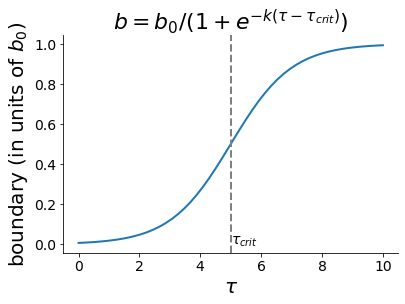

In [6]:
b_0 = 1
k = 1
tta_crit = 5
tau = np.linspace(0, 10)
b = lambda tau: b_0/(1+np.exp(-k*(tau-tta_crit)))

fig, ax = plt.subplots()
ax.plot(tau, b(tau))
ax.axvline(tta_crit, color='grey', ls='--')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('boundary (in units of $b_0$)')
# ax.legend(loc='lower right')
ax.set_title(r'$b = b_0/(1+e^{-k(\tau-\tau_{crit})})$')
ax.text(x=tta_crit, y=0, s=r'$\tau_{crit}$', fontsize=14);

In [7]:
class BoundCollapsingTta(ddm.models.Bound):
    name = 'Bounds collapsing with TTA'
    required_parameters = ['b_0', 'k', 'tta_crit']
    required_conditions = ['tta_condition'] 
    def get_bound(self, t, conditions, **kwargs):
        tau = conditions['tta_condition'] - t
        return self.b_0/(1+np.exp(-self.k*(tau-self.tta_crit)))

tta_crit = ddm.Fittable(minval=3, maxval=6)
    
model_TTA_bounds = ddm.Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time',
                             drift=DriftTtaDistance(alpha=ddm.Fittable(minval=0.1, maxval=3),
                                                     tta_crit=tta_crit,
                                                     beta=ddm.Fittable(minval=0, maxval=1),
                                                     d_crit=ddm.Fittable(minval=90, maxval=150)),
                             noise=ddm.NoiseConstant(noise=1),
                             bound=BoundCollapsingTta(b_0=ddm.Fittable(minval=0.5, maxval=5), 
                                                      k=ddm.Fittable(minval=0.1, maxval=2),
                                                      tta_crit=tta_crit),
                             overlay=ddm.OverlayNonDecisionUniform(nondectime=ddm.Fittable(minval=0, maxval=0.5),
                                                                   halfwidth=ddm.Fittable(minval=0, maxval=0.3)),
                             T_dur=T_dur)

# Model fitting to aggregate data

Reading experimental data

In [8]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition', 'd_condition'])
exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data, rt_column_name='RT', correct_column_name='is_turn_decision')

In [ ]:
models = [
#           model_tta_distance_dependent_drift #, 
#           model_nondecision_time_fixed, 
#           model_nondecision_time_variable,
#           model_collapsing_bounds, 
          model_TTA_bounds
         ]

fit_models = []
for model in models:
    print(model.name)
    directory = 'model_fit_results/tta_and_d/%s' % (model.name.lower().replace(' ', '_'))
    fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
    save_fitting_results(exp_data, fit_model, directory)
    fit_models.append(fit_model)

5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time
[0.7724358972550626, 4.675975994595085, 0.7841359079297632, 139.20080125713378, 3.5164617790208585, 0.9224882142546934, 0.3830699968871259, 0.10287254608262585]
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9459313928547608, minval=0.1, maxval=3), tta_crit=Fitted(3.705368045724668, minval=3, maxval=6), beta=Fitted(0.8582538566923834, minval=0, maxval=1), d_crit=Fitted(91.05183197269685, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7484213121724976, minval=0.5, maxval=5), k=Fitted(1.9570622555799662, minval=0.1, maxval=2), tta_crit=Fitted(3.705368045724668, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07875843321688758, minval=0, maxval=0.5), halfwidth=Fitted(0.09032026143558577, minval=0, maxval=0.3)), dx=0.005, d

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1407592518231426, minval=0.1, maxval=3), tta_crit=Fitted(4.059249075698989, minval=3, maxval=6), beta=Fitted(0.03146526489408252, minval=0, maxval=1), d_crit=Fitted(127.38547498649791, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5389042012762753, minval=0.5, maxval=5), k=Fitted(0.31382090343023983, minval=0.1, maxval=2), tta_crit=Fitted(4.059249075698989, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21464606266212763, minval=0, maxval=0.5), halfwidth=Fitted(0.11677268336104818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8539366489365148
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.0551379564537076, minval=0.1, maxval=3), tta_crit=Fitted(5.810

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8204540360643129, minval=0.1, maxval=3), tta_crit=Fitted(4.679708958941629, minval=3, maxval=6), beta=Fitted(0.8930365643901151, minval=0, maxval=1), d_crit=Fitted(136.62730734873026, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.805956389064459, minval=0.5, maxval=5), k=Fitted(1.3425987797413335, minval=0.1, maxval=2), tta_crit=Fitted(4.679708958941629, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2569499326266283, minval=0, maxval=0.5), halfwidth=Fitted(0.027890282975938874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.3275704805251545
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.3730209133272244, minval=0.1, maxval=3), tta_crit=Fitted(4.541079

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2038603596800863, minval=0.1, maxval=3), tta_crit=Fitted(4.359567893045495, minval=3, maxval=6), beta=Fitted(0.5746640688481813, minval=0, maxval=1), d_crit=Fitted(112.13249795227077, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6965663007526088, minval=0.5, maxval=5), k=Fitted(1.3649713418087277, minval=0.1, maxval=2), tta_crit=Fitted(4.359567893045495, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24831191775528696, minval=0, maxval=0.5), halfwidth=Fitted(0.21022146855714305, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.256099454093348
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9803721750808574, minval=0.1, maxval=3), tta_crit=Fitted(3.217552

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0620866731354865, minval=0.1, maxval=3), tta_crit=Fitted(4.091606271852537, minval=3, maxval=6), beta=Fitted(0.625661270958009, minval=0, maxval=1), d_crit=Fitted(141.91678208956563, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.3172191746257456, minval=0.5, maxval=5), k=Fitted(1.9377410831694757, minval=0.1, maxval=2), tta_crit=Fitted(4.091606271852537, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.02297588823136615, minval=0, maxval=0.5), halfwidth=Fitted(0.12122693784602603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.697355528562763
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.008013377626856, minval=0.1, maxval=3), tta_crit=Fitted(5.26869222

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9585507153029859, minval=0.1, maxval=3), tta_crit=Fitted(5.779806438909882, minval=3, maxval=6), beta=Fitted(0.6148530709958278, minval=0, maxval=1), d_crit=Fitted(113.35998022777038, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.196201666269822, minval=0.5, maxval=5), k=Fitted(0.7241844464727767, minval=0.1, maxval=2), tta_crit=Fitted(5.779806438909882, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.47434632695553247, minval=0, maxval=0.5), halfwidth=Fitted(0.17105135100945595, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.9598953827527468
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2786038052930253, minval=0.1, maxval=3), tta_crit=Fitted(3.107892

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2101853911999585, minval=0.1, maxval=3), tta_crit=Fitted(4.304766902461693, minval=3, maxval=6), beta=Fitted(0.26416986125797426, minval=0, maxval=1), d_crit=Fitted(130.2639253257327, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7986783775061468, minval=0.5, maxval=5), k=Fitted(1.0585046819098733, minval=0.1, maxval=2), tta_crit=Fitted(4.304766902461693, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3146611879086075, minval=0, maxval=0.5), halfwidth=Fitted(0.14546755926976548, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.337435456907973
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7970615080526305, minval=0.1, maxval=3), tta_crit=Fitted(4.8439474

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7303621131023788, minval=0.1, maxval=3), tta_crit=Fitted(3.185424995554957, minval=3, maxval=6), beta=Fitted(0.4416211951839307, minval=0, maxval=1), d_crit=Fitted(139.89668776838968, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.878343104605721, minval=0.5, maxval=5), k=Fitted(1.7709230543265713, minval=0.1, maxval=2), tta_crit=Fitted(3.185424995554957, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07464040955000115, minval=0, maxval=0.5), halfwidth=Fitted(0.2589109897297528, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.927359371720936
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.43666948072776046, minval=0.1, maxval=3), tta_crit=Fitted(5.8316321

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.1943268454465814, minval=0.1, maxval=3), tta_crit=Fitted(4.513204548724092, minval=3, maxval=6), beta=Fitted(0.6936113544984767, minval=0, maxval=1), d_crit=Fitted(138.13698757792116, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1490801172947511, minval=0.5, maxval=5), k=Fitted(0.48727855386722274, minval=0.1, maxval=2), tta_crit=Fitted(4.513204548724092, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3831068485888506, minval=0, maxval=0.5), halfwidth=Fitted(0.2756057336801239, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.598605691805994
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6140728050500117, minval=0.1, maxval=3), tta_crit=Fitted(5.9092633

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.11663764936260179, minval=0.1, maxval=3), tta_crit=Fitted(5.197358267285822, minval=3, maxval=6), beta=Fitted(0.12015197160732571, minval=0, maxval=1), d_crit=Fitted(101.51329158544766, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.173303978277837, minval=0.5, maxval=5), k=Fitted(1.3939100595778593, minval=0.1, maxval=2), tta_crit=Fitted(5.197358267285822, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.44692138935884923, minval=0, maxval=0.5), halfwidth=Fitted(0.09459345749149015, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=13.918107465108012
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2706538656319135, minval=0.1, maxval=3), tta_crit=Fitted(5.5217

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3001314344272534, minval=0.1, maxval=3), tta_crit=Fitted(5.667435095743055, minval=3, maxval=6), beta=Fitted(0.6231170917648342, minval=0, maxval=1), d_crit=Fitted(145.72606882736278, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.935305316874684, minval=0.5, maxval=5), k=Fitted(1.9863704751560998, minval=0.1, maxval=2), tta_crit=Fitted(5.667435095743055, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18658345741705737, minval=0, maxval=0.5), halfwidth=Fitted(0.04028023666593877, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.17444040424758
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2249375801864293, minval=0.1, maxval=3), tta_crit=Fitted(3.51099308

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.24903974676444318, minval=0.1, maxval=3), tta_crit=Fitted(5.9763175577443794, minval=3, maxval=6), beta=Fitted(0.4790621290173497, minval=0, maxval=1), d_crit=Fitted(129.0160704871916, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.956289845934898, minval=0.5, maxval=5), k=Fitted(0.7482806932146413, minval=0.1, maxval=2), tta_crit=Fitted(5.9763175577443794, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23704729512877498, minval=0, maxval=0.5), halfwidth=Fitted(0.09582222319240524, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.143503601432249
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3237344591977207, minval=0.1, maxval=3), tta_crit=Fitted(3.42769

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6071204058316055, minval=0.1, maxval=3), tta_crit=Fitted(4.255078957836294, minval=3, maxval=6), beta=Fitted(0.5698701462902785, minval=0, maxval=1), d_crit=Fitted(148.51700738679625, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1737086068939544, minval=0.5, maxval=5), k=Fitted(1.2428723490620164, minval=0.1, maxval=2), tta_crit=Fitted(4.255078957836294, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2419758669455689, minval=0, maxval=0.5), halfwidth=Fitted(0.17090769439835501, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.1777992368906505
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3860730668791781, minval=0.1, maxval=3), tta_crit=Fitted(4.657585

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5888498188198348, minval=0.1, maxval=3), tta_crit=Fitted(3.2834102003514145, minval=3, maxval=6), beta=Fitted(0.4665194093884194, minval=0, maxval=1), d_crit=Fitted(104.83073123746175, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5379623665684163, minval=0.5, maxval=5), k=Fitted(0.4550841689287163, minval=0.1, maxval=2), tta_crit=Fitted(3.2834102003514145, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2060776948483765, minval=0, maxval=0.5), halfwidth=Fitted(0.07567033189616461, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.820892616735544
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4359175394321153, minval=0.1, maxval=3), tta_crit=Fitted(4.28080

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9803721750808574, minval=0.1, maxval=3), tta_crit=Fitted(4.151056981025698, minval=3, maxval=6), beta=Fitted(0.0060903971082139075, minval=0, maxval=1), d_crit=Fitted(101.98648018667687, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6492093983746896, minval=0.5, maxval=5), k=Fitted(1.1906509164864998, minval=0.1, maxval=2), tta_crit=Fitted(4.151056981025698, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.025753809908279246, minval=0, maxval=0.5), halfwidth=Fitted(0.20517230152290322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.253818626702122
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6860999865036113, minval=0.1, maxval=3), tta_crit=Fitted(4.23

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3149916533561099, minval=0.1, maxval=3), tta_crit=Fitted(3.744226795344816, minval=3, maxval=6), beta=Fitted(0.3953123469009404, minval=0, maxval=1), d_crit=Fitted(116.19071226562528, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.700570140694971, minval=0.5, maxval=5), k=Fitted(0.5448407575660184, minval=0.1, maxval=2), tta_crit=Fitted(3.744226795344816, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12172013471909926, minval=0, maxval=0.5), halfwidth=Fitted(0.07304114655929932, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.8844512276643672
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.1318058217681939, minval=0.1, maxval=3), tta_crit=Fitted(5.128990

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8514556742730266, minval=0.1, maxval=3), tta_crit=Fitted(3.17258777292581, minval=3, maxval=6), beta=Fitted(0.08905067673734102, minval=0, maxval=1), d_crit=Fitted(109.09178497042603, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.8279920620629575, minval=0.5, maxval=5), k=Fitted(1.9073178326144204, minval=0.1, maxval=2), tta_crit=Fitted(3.17258777292581, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.030492211802223668, minval=0, maxval=0.5), halfwidth=Fitted(0.07743975145457642, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4799908858846003
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8840408894640146, minval=0.1, maxval=3), tta_crit=Fitted(4.35967

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5249025801834282, minval=0.1, maxval=3), tta_crit=Fitted(3.3949053339909905, minval=3, maxval=6), beta=Fitted(0.028768289959466176, minval=0, maxval=1), d_crit=Fitted(127.7030727653609, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.987389951510901, minval=0.5, maxval=5), k=Fitted(1.6179598425444537, minval=0.1, maxval=2), tta_crit=Fitted(3.3949053339909905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.128959075065312, minval=0, maxval=0.5), halfwidth=Fitted(0.045655669522978184, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=36.10190394759943
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.687265155565829, minval=0.1, maxval=3), tta_crit=Fitted(3.167680

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0271335237405017, minval=0.1, maxval=3), tta_crit=Fitted(4.258256339279578, minval=3, maxval=6), beta=Fitted(0.6341979496071519, minval=0, maxval=1), d_crit=Fitted(143.27895313252898, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.787776499924905, minval=0.5, maxval=5), k=Fitted(0.5281488721502213, minval=0.1, maxval=2), tta_crit=Fitted(4.258256339279578, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.028184751704707967, minval=0, maxval=0.5), halfwidth=Fitted(0.13784677440450774, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=9.607299256138564
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5072842472664683, minval=0.1, maxval=3), tta_crit=Fitted(4.516612

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0058258262191473, minval=0.1, maxval=3), tta_crit=Fitted(5.909263336900944, minval=3, maxval=6), beta=Fitted(0.5116420075209756, minval=0, maxval=1), d_crit=Fitted(99.5788111429805, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5222592572968243, minval=0.5, maxval=5), k=Fitted(0.21766612116541484, minval=0.1, maxval=2), tta_crit=Fitted(5.909263336900944, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13771536936671155, minval=0, maxval=0.5), halfwidth=Fitted(0.14405151699607793, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=10.397565674720274
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.49195909650656033, minval=0.1, maxval=3), tta_crit=Fitted(3.27892

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9647706346010372, minval=0.1, maxval=3), tta_crit=Fitted(3.4331120424169503, minval=3, maxval=6), beta=Fitted(0.812454981184116, minval=0, maxval=1), d_crit=Fitted(101.95693881400922, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.4914182790333834, minval=0.5, maxval=5), k=Fitted(1.2447087255113647, minval=0.1, maxval=2), tta_crit=Fitted(3.4331120424169503, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4436508482495584, minval=0, maxval=0.5), halfwidth=Fitted(0.10930500114894635, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.8462632783472115
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1436856836142157, minval=0.1, maxval=3), tta_crit=Fitted(3.90903

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1100930635326602, minval=0.1, maxval=3), tta_crit=Fitted(3.350848460759569, minval=3, maxval=6), beta=Fitted(0.7808676941854664, minval=0, maxval=1), d_crit=Fitted(90.00894369941909, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.6583230287797734, minval=0.5, maxval=5), k=Fitted(0.5445217802521085, minval=0.1, maxval=2), tta_crit=Fitted(3.350848460759569, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3002933294946888, minval=0, maxval=0.5), halfwidth=Fitted(0.14266921264201274, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.821329265169792
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.077726742283132, minval=0.1, maxval=3), tta_crit=Fitted(3.750292942

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9818674240072394, minval=0.1, maxval=3), tta_crit=Fitted(5.919893282167341, minval=3, maxval=6), beta=Fitted(0.24885953323291754, minval=0, maxval=1), d_crit=Fitted(132.85053015613877, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2132945065436584, minval=0.5, maxval=5), k=Fitted(1.0977564225385068, minval=0.1, maxval=2), tta_crit=Fitted(5.919893282167341, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.014358159365205458, minval=0, maxval=0.5), halfwidth=Fitted(0.17784218580713404, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.582293140077316
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.4640791535399456, minval=0.1, maxval=3), tta_crit=Fitted(3.9737

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5395157945850586, minval=0.1, maxval=3), tta_crit=Fitted(3.387168762147894, minval=3, maxval=6), beta=Fitted(0.20354768781085808, minval=0, maxval=1), d_crit=Fitted(123.78831918379382, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.476139097722466, minval=0.5, maxval=5), k=Fitted(0.60770235152943, minval=0.1, maxval=2), tta_crit=Fitted(3.387168762147894, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.029997464118356354, minval=0, maxval=0.5), halfwidth=Fitted(0.11260223810364964, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.7652236728863056
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8251747014407197, minval=0.1, maxval=3), tta_crit=Fitted(4.212306

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2416354327114547, minval=0.1, maxval=3), tta_crit=Fitted(4.280801893969148, minval=3, maxval=6), beta=Fitted(0.41614511207857663, minval=0, maxval=1), d_crit=Fitted(134.50161638497391, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6782716244901004, minval=0.5, maxval=5), k=Fitted(0.8374047236020024, minval=0.1, maxval=2), tta_crit=Fitted(4.280801893969148, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17728242023429439, minval=0, maxval=0.5), halfwidth=Fitted(0.15489745238771996, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.05228528307108
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8536865400768007, minval=0.1, maxval=3), tta_crit=Fitted(3.552146

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.5351710709124258, minval=0.1, maxval=3), tta_crit=Fitted(4.236004401003332, minval=3, maxval=6), beta=Fitted(0.19780455262160512, minval=0, maxval=1), d_crit=Fitted(140.77367981463775, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.1708352834255935, minval=0.5, maxval=5), k=Fitted(0.364005455351742, minval=0.1, maxval=2), tta_crit=Fitted(4.236004401003332, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08617464689995857, minval=0, maxval=0.5), halfwidth=Fitted(0.20884939584952872, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.319818481967686
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4106503669399513, minval=0.1, maxval=3), tta_crit=Fitted(3.580921

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9784445545993758, minval=0.1, maxval=3), tta_crit=Fitted(5.6962755527850435, minval=3, maxval=6), beta=Fitted(0.029141927657318156, minval=0, maxval=1), d_crit=Fitted(111.69358798585435, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1675801312413268, minval=0.5, maxval=5), k=Fitted(1.7684736616712389, minval=0.1, maxval=2), tta_crit=Fitted(5.6962755527850435, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36890439503623884, minval=0, maxval=0.5), halfwidth=Fitted(0.07141235376152033, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3684759241074556
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8746755871011557, minval=0.1, maxval=3), tta_crit=Fitted(4.2

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2647065923564762, minval=0.1, maxval=3), tta_crit=Fitted(4.876780757246792, minval=3, maxval=6), beta=Fitted(0.2478293216095997, minval=0, maxval=1), d_crit=Fitted(129.26940934373926, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.3043358890394194, minval=0.5, maxval=5), k=Fitted(1.5915491289157795, minval=0.1, maxval=2), tta_crit=Fitted(4.876780757246792, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23966867025019983, minval=0, maxval=0.5), halfwidth=Fitted(0.27258283158219054, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.687349281919961
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9152469084240988, minval=0.1, maxval=3), tta_crit=Fitted(5.389289

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8376510109543358, minval=0.1, maxval=3), tta_crit=Fitted(5.0746417886233495, minval=3, maxval=6), beta=Fitted(0.2165320063275128, minval=0, maxval=1), d_crit=Fitted(107.6647257229075, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9026927178832538, minval=0.5, maxval=5), k=Fitted(1.7488643286734509, minval=0.1, maxval=2), tta_crit=Fitted(5.0746417886233495, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20542430235944079, minval=0, maxval=0.5), halfwidth=Fitted(0.12746090837622925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.327783352109765
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6331739176555677, minval=0.1, maxval=3), tta_crit=Fitted(4.41848

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2134897289919713, minval=0.1, maxval=3), tta_crit=Fitted(4.998532124635771, minval=3, maxval=6), beta=Fitted(0.8349795268522512, minval=0, maxval=1), d_crit=Fitted(93.25984806273586, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1013249310140627, minval=0.5, maxval=5), k=Fitted(0.7039546423953975, minval=0.1, maxval=2), tta_crit=Fitted(4.998532124635771, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2950915338401832, minval=0, maxval=0.5), halfwidth=Fitted(0.10070127948718453, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.245785754424126
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.063270794972457, minval=0.1, maxval=3), tta_crit=Fitted(5.085233207

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2547682281156174, minval=0.1, maxval=3), tta_crit=Fitted(3.2789265872132516, minval=3, maxval=6), beta=Fitted(0.30607432634303555, minval=0, maxval=1), d_crit=Fitted(132.7305033862285, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8914755742494402, minval=0.5, maxval=5), k=Fitted(0.194683022581837, minval=0.1, maxval=2), tta_crit=Fitted(3.2789265872132516, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15975717644279677, minval=0, maxval=0.5), halfwidth=Fitted(0.02254869329781281, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.122992496082846
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.5036593417520927, minval=0.1, maxval=3), tta_crit=Fitted(4.11105

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3904425679526453, minval=0.1, maxval=3), tta_crit=Fitted(5.262897878737199, minval=3, maxval=6), beta=Fitted(0.35029623941822985, minval=0, maxval=1), d_crit=Fitted(126.73592777987717, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.504036876309833, minval=0.5, maxval=5), k=Fitted(0.8622025900067902, minval=0.1, maxval=2), tta_crit=Fitted(5.262897878737199, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10645895138085826, minval=0, maxval=0.5), halfwidth=Fitted(0.11129092889123196, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4607944323024458
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6386469693700353, minval=0.1, maxval=3), tta_crit=Fitted(4.77396

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.077726742283132, minval=0.1, maxval=3), tta_crit=Fitted(3.75029294267293, minval=3, maxval=6), beta=Fitted(0.3887616220755987, minval=0, maxval=1), d_crit=Fitted(114.89750866019304, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.760335400901139, minval=0.5, maxval=5), k=Fitted(0.6537736354423225, minval=0.1, maxval=2), tta_crit=Fitted(3.75029294267293, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35035493935864304, minval=0, maxval=0.5), halfwidth=Fitted(0.20051858508858675, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.390250272515094
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7805570859363182, minval=0.1, maxval=3), tta_crit=Fitted(3.5619673669

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.4640791535399456, minval=0.1, maxval=3), tta_crit=Fitted(3.9737295188644666, minval=3, maxval=6), beta=Fitted(0.31440224518751325, minval=0, maxval=1), d_crit=Fitted(107.71303271086995, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2623251837016256, minval=0.5, maxval=5), k=Fitted(0.13121020779003756, minval=0.1, maxval=2), tta_crit=Fitted(3.9737295188644666, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30716827914577005, minval=0, maxval=0.5), halfwidth=Fitted(0.053171556412158455, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.829213924947231
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7294726187857545, minval=0.1, maxval=3), tta_crit=Fitted(4.0

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0727185721038808, minval=0.1, maxval=3), tta_crit=Fitted(4.961473750809908, minval=3, maxval=6), beta=Fitted(0.011701204670421073, minval=0, maxval=1), d_crit=Fitted(113.5263371663217, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2625568047957616, minval=0.5, maxval=5), k=Fitted(0.444619144649396, minval=0.1, maxval=2), tta_crit=Fitted(4.961473750809908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30467600945050605, minval=0, maxval=0.5), halfwidth=Fitted(0.08352302976321374, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2028244945709883
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8136600984899778, minval=0.1, maxval=3), tta_crit=Fitted(5.41473

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8536865400768007, minval=0.1, maxval=3), tta_crit=Fitted(4.053464804319183, minval=3, maxval=6), beta=Fitted(0.23020795634477204, minval=0, maxval=1), d_crit=Fitted(116.9306367809522, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.159082514002388, minval=0.5, maxval=5), k=Fitted(0.29207028371145893, minval=0.1, maxval=2), tta_crit=Fitted(4.053464804319183, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11698384553029118, minval=0, maxval=0.5), halfwidth=Fitted(0.008204782318655401, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.523969446091967
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7645503643749167, minval=0.1, maxval=3), tta_crit=Fitted(3.32297

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2749895674106848, minval=0.1, maxval=3), tta_crit=Fitted(4.157234157658766, minval=3, maxval=6), beta=Fitted(0.1037314313116387, minval=0, maxval=1), d_crit=Fitted(111.93659886474695, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9016961416278775, minval=0.5, maxval=5), k=Fitted(0.826491811643228, minval=0.1, maxval=2), tta_crit=Fitted(4.157234157658766, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.263646805789915, minval=0, maxval=0.5), halfwidth=Fitted(0.016989783143417675, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.8738600645966486
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0592633605002981, minval=0.1, maxval=3), tta_crit=Fitted(4.6694584

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7850941325042857, minval=0.1, maxval=3), tta_crit=Fitted(4.25034606425172, minval=3, maxval=6), beta=Fitted(0.07392957222048563, minval=0, maxval=1), d_crit=Fitted(111.47994921209856, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.613352824629223, minval=0.5, maxval=5), k=Fitted(0.5067227219075706, minval=0.1, maxval=2), tta_crit=Fitted(4.25034606425172, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.06253284009636001, minval=0, maxval=0.5), halfwidth=Fitted(0.24484413469706695, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.602594357640489
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3473087242861084, minval=0.1, maxval=3), tta_crit=Fitted(4.11892111

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5261461695071477, minval=0.1, maxval=3), tta_crit=Fitted(4.958476057996635, minval=3, maxval=6), beta=Fitted(0.056076015895008824, minval=0, maxval=1), d_crit=Fitted(123.32554450973285, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9746839807016348, minval=0.5, maxval=5), k=Fitted(0.8284736845689835, minval=0.1, maxval=2), tta_crit=Fitted(4.958476057996635, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3313068412640725, minval=0, maxval=0.5), halfwidth=Fitted(0.07986909603086714, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.107737562692066
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.43625171642149185, minval=0.1, maxval=3), tta_crit=Fitted(3.6580

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5835979058096559, minval=0.1, maxval=3), tta_crit=Fitted(5.426800994232322, minval=3, maxval=6), beta=Fitted(0.011809725609528643, minval=0, maxval=1), d_crit=Fitted(139.91592759536758, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5369806212798545, minval=0.5, maxval=5), k=Fitted(1.536977799147748, minval=0.1, maxval=2), tta_crit=Fitted(5.426800994232322, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23804600361736875, minval=0, maxval=0.5), halfwidth=Fitted(0.16249050044068916, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.472926450980317
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.423054741475307, minval=0.1, maxval=3), tta_crit=Fitted(4.471635

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2573444357110717, minval=0.1, maxval=3), tta_crit=Fitted(4.61654506826368, minval=3, maxval=6), beta=Fitted(0.06537455609273857, minval=0, maxval=1), d_crit=Fitted(127.2800178889911, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.709018885757386, minval=0.5, maxval=5), k=Fitted(1.1208834078430412, minval=0.1, maxval=2), tta_crit=Fitted(4.61654506826368, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17815552156343104, minval=0, maxval=0.5), halfwidth=Fitted(0.1629820086961317, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.2739813166979483
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.14971537015603, minval=0.1, maxval=3), tta_crit=Fitted(4.20430243311

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5842359297510202, minval=0.1, maxval=3), tta_crit=Fitted(5.233683740495686, minval=3, maxval=6), beta=Fitted(0.07713764510672849, minval=0, maxval=1), d_crit=Fitted(142.4041609203516, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.792698387420703, minval=0.5, maxval=5), k=Fitted(0.20423562725388533, minval=0.1, maxval=2), tta_crit=Fitted(5.233683740495686, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23826978300625667, minval=0, maxval=0.5), halfwidth=Fitted(0.06947904597231609, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.898352626574873
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.321170757083821, minval=0.1, maxval=3), tta_crit=Fitted(4.3844224

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6148149639050375, minval=0.1, maxval=3), tta_crit=Fitted(5.18541483412601, minval=3, maxval=6), beta=Fitted(0.23417648195733642, minval=0, maxval=1), d_crit=Fitted(131.4385853843746, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.942494037245131, minval=0.5, maxval=5), k=Fitted(1.5355132268454295, minval=0.1, maxval=2), tta_crit=Fitted(5.18541483412601, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32907339142468983, minval=0, maxval=0.5), halfwidth=Fitted(0.185746135568625, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.9685800118731183
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.16635259655582635, minval=0.1, maxval=3), tta_crit=Fitted(3.427972247

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.1310361892950325, minval=0.1, maxval=3), tta_crit=Fitted(4.371632765818014, minval=3, maxval=6), beta=Fitted(0.22348355660552754, minval=0, maxval=1), d_crit=Fitted(122.95186728733638, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6429879989368408, minval=0.5, maxval=5), k=Fitted(1.4693822633283018, minval=0.1, maxval=2), tta_crit=Fitted(4.371632765818014, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15413379052556836, minval=0, maxval=0.5), halfwidth=Fitted(0.06484446496314476, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.759634003839214
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6942823381299092, minval=0.1, maxval=3), tta_crit=Fitted(3.23279

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.777829954931453, minval=0.1, maxval=3), tta_crit=Fitted(3.7420494941847107, minval=3, maxval=6), beta=Fitted(0.4918236908424105, minval=0, maxval=1), d_crit=Fitted(110.83351850878549, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9789866602029842, minval=0.5, maxval=5), k=Fitted(0.9384167359535055, minval=0.1, maxval=2), tta_crit=Fitted(3.7420494941847107, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42075920531002203, minval=0, maxval=0.5), halfwidth=Fitted(0.1891459211152109, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.7111297668640573
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.057240573229115, minval=0.1, maxval=3), tta_crit=Fitted(3.457827

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.23828997705572807, minval=0.1, maxval=3), tta_crit=Fitted(4.652733985541479, minval=3, maxval=6), beta=Fitted(0.5277526900624879, minval=0, maxval=1), d_crit=Fitted(134.5949929573963, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2962438338046705, minval=0.5, maxval=5), k=Fitted(0.37003635680864755, minval=0.1, maxval=2), tta_crit=Fitted(4.652733985541479, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15893683414323173, minval=0, maxval=0.5), halfwidth=Fitted(0.28417981844475276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.537487377144442
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.933669447989276, minval=0.1, maxval=3), tta_crit=Fitted(3.042032

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3012622065468555, minval=0.1, maxval=3), tta_crit=Fitted(4.40532575634337, minval=3, maxval=6), beta=Fitted(0.1438761820665707, minval=0, maxval=1), d_crit=Fitted(108.68146327449048, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6426388146243653, minval=0.5, maxval=5), k=Fitted(1.0969312200137986, minval=0.1, maxval=2), tta_crit=Fitted(4.40532575634337, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26193377783058885, minval=0, maxval=0.5), halfwidth=Fitted(0.17601208663967768, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.692856843076613
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.106686205732831, minval=0.1, maxval=3), tta_crit=Fitted(4.392817302

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8959424492119717, minval=0.1, maxval=3), tta_crit=Fitted(3.4059970026313477, minval=3, maxval=6), beta=Fitted(0.7921365857552907, minval=0, maxval=1), d_crit=Fitted(126.12921540687137, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.2086379186720744, minval=0.5, maxval=5), k=Fitted(1.5071786671640979, minval=0.1, maxval=2), tta_crit=Fitted(3.4059970026313477, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21863968048409144, minval=0, maxval=0.5), halfwidth=Fitted(0.21067732265148212, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.030951714894382
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1783879747895987, minval=0.1, maxval=3), tta_crit=Fitted(4.5297

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.2941658055075336, minval=0.1, maxval=3), tta_crit=Fitted(4.11892111754737, minval=3, maxval=6), beta=Fitted(0.13582575992247126, minval=0, maxval=1), d_crit=Fitted(113.35558632018736, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.2116788508900798, minval=0.5, maxval=5), k=Fitted(0.9319472044104395, minval=0.1, maxval=2), tta_crit=Fitted(4.11892111754737, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20422989571381123, minval=0, maxval=0.5), halfwidth=Fitted(0.2502417509401391, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.8087693593778233
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6037435105511813, minval=0.1, maxval=3), tta_crit=Fitted(5.8974183

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7137937014980422, minval=0.1, maxval=3), tta_crit=Fitted(3.790326186549259, minval=3, maxval=6), beta=Fitted(0.17708740106113485, minval=0, maxval=1), d_crit=Fitted(139.9047783822343, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.923263627026057, minval=0.5, maxval=5), k=Fitted(1.247999987335989, minval=0.1, maxval=2), tta_crit=Fitted(3.790326186549259, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.02885645582175958, minval=0, maxval=0.5), halfwidth=Fitted(0.17046747755422764, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.9684232732587175
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8897277922255119, minval=0.1, maxval=3), tta_crit=Fitted(4.4451614

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4946942283457962, minval=0.1, maxval=3), tta_crit=Fitted(3.938798297572731, minval=3, maxval=6), beta=Fitted(0.40133107669755586, minval=0, maxval=1), d_crit=Fitted(136.2538559981652, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.068347289404861, minval=0.5, maxval=5), k=Fitted(0.9841856646850408, minval=0.1, maxval=2), tta_crit=Fitted(3.938798297572731, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14093691690247767, minval=0, maxval=0.5), halfwidth=Fitted(0.0936313949746477, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.8383342415940485
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6942135552206042, minval=0.1, maxval=3), tta_crit=Fitted(3.3373732

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.14971537015603, minval=0.1, maxval=3), tta_crit=Fitted(4.204302433116303, minval=3, maxval=6), beta=Fitted(0.9854238061491494, minval=0, maxval=1), d_crit=Fitted(122.31992994755001, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4952135837146405, minval=0.5, maxval=5), k=Fitted(1.6367096575200244, minval=0.1, maxval=2), tta_crit=Fitted(4.204302433116303, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.021000212030548693, minval=0, maxval=0.5), halfwidth=Fitted(0.12305886905740772, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.33906449426145
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8287724031458596, minval=0.1, maxval=3), tta_crit=Fitted(4.76342182

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6866767830305449, minval=0.1, maxval=3), tta_crit=Fitted(3.241802786862964, minval=3, maxval=6), beta=Fitted(0.14840779259313153, minval=0, maxval=1), d_crit=Fitted(142.12327126521188, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.360459249506654, minval=0.5, maxval=5), k=Fitted(0.5776387899491833, minval=0.1, maxval=2), tta_crit=Fitted(3.241802786862964, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3001919073330821, minval=0, maxval=0.5), halfwidth=Fitted(0.07734940248985647, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=13.64311522109359
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.543257424993725, minval=0.1, maxval=3), tta_crit=Fitted(4.24794647

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.40573892231863784, minval=0.1, maxval=3), tta_crit=Fitted(5.8592283559823315, minval=3, maxval=6), beta=Fitted(0.3294783105510386, minval=0, maxval=1), d_crit=Fitted(136.69878125916028, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.94818956835386, minval=0.5, maxval=5), k=Fitted(0.4992024845653964, minval=0.1, maxval=2), tta_crit=Fitted(5.8592283559823315, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09455373581765064, minval=0, maxval=0.5), halfwidth=Fitted(0.025528668803949134, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.557686693611965
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8049464193431978, minval=0.1, maxval=3), tta_crit=Fitted(3.4922

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9247435696001945, minval=0.1, maxval=3), tta_crit=Fitted(3.7733653110872507, minval=3, maxval=6), beta=Fitted(0.043499381166541784, minval=0, maxval=1), d_crit=Fitted(147.5539746104883, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.091803711451592, minval=0.5, maxval=5), k=Fitted(0.11932655750204502, minval=0.1, maxval=2), tta_crit=Fitted(3.7733653110872507, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1946500889860543, minval=0, maxval=0.5), halfwidth=Fitted(0.16346906438096717, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.920725014644017
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1009193562421438, minval=0.1, maxval=3), tta_crit=Fitted(4.1477

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2512543698099883, minval=0.1, maxval=3), tta_crit=Fitted(5.347242805294838, minval=3, maxval=6), beta=Fitted(0.11259335897037093, minval=0, maxval=1), d_crit=Fitted(133.65368436671963, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8735670802107818, minval=0.5, maxval=5), k=Fitted(0.24610836142816772, minval=0.1, maxval=2), tta_crit=Fitted(5.347242805294838, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14623973605340812, minval=0, maxval=0.5), halfwidth=Fitted(0.09319101841618907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.417017875156554
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.898170481747273, minval=0.1, maxval=3), tta_crit=Fitted(3.77534

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8836294454722095, minval=0.1, maxval=3), tta_crit=Fitted(4.435161837828919, minval=3, maxval=6), beta=Fitted(0.7301155451278114, minval=0, maxval=1), d_crit=Fitted(118.40553526647487, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.751348109275706, minval=0.5, maxval=5), k=Fitted(0.564130331793192, minval=0.1, maxval=2), tta_crit=Fitted(4.435161837828919, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11412560567513125, minval=0, maxval=0.5), halfwidth=Fitted(0.26140806284362594, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.459766682459898
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.646565871886513, minval=0.1, maxval=3), tta_crit=Fitted(4.563055123

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.3910287322011725, minval=0.1, maxval=3), tta_crit=Fitted(5.816442510306287, minval=3, maxval=6), beta=Fitted(0.1906218157738585, minval=0, maxval=1), d_crit=Fitted(142.30510550070454, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.543723265729288, minval=0.5, maxval=5), k=Fitted(0.3929189242495926, minval=0.1, maxval=2), tta_crit=Fitted(5.816442510306287, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35969416006024335, minval=0, maxval=0.5), halfwidth=Fitted(0.1489616773361472, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.990741190130789
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.11274514291288007, minval=0.1, maxval=3), tta_crit=Fitted(4.6032243

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2192646058453358, minval=0.1, maxval=3), tta_crit=Fitted(3.633972781272239, minval=3, maxval=6), beta=Fitted(0.04400177759254875, minval=0, maxval=1), d_crit=Fitted(108.35317709857644, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.720533533616744, minval=0.5, maxval=5), k=Fitted(0.9682044030300849, minval=0.1, maxval=2), tta_crit=Fitted(3.633972781272239, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12498368691341882, minval=0, maxval=0.5), halfwidth=Fitted(0.15260242521337464, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.9312022580168025
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5004101542703339, minval=0.1, maxval=3), tta_crit=Fitted(4.14020

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6037435105511813, minval=0.1, maxval=3), tta_crit=Fitted(5.753380896364908, minval=3, maxval=6), beta=Fitted(0.9651308450062435, minval=0, maxval=1), d_crit=Fitted(125.4834197114761, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.227225579191887, minval=0.5, maxval=5), k=Fitted(0.5526872965915666, minval=0.1, maxval=2), tta_crit=Fitted(5.753380896364908, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.49592756001918553, minval=0, maxval=0.5), halfwidth=Fitted(0.273100044671, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.180450513019016
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.120160662244389, minval=0.1, maxval=3), tta_crit=Fitted(3.60093566871589

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.437660749879035, minval=0.1, maxval=3), tta_crit=Fitted(4.938107684042867, minval=3, maxval=6), beta=Fitted(0.019304396870548524, minval=0, maxval=1), d_crit=Fitted(122.38537032600165, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.7779540352428316, minval=0.5, maxval=5), k=Fitted(0.5891542833780784, minval=0.1, maxval=2), tta_crit=Fitted(4.938107684042867, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17065735115348982, minval=0, maxval=0.5), halfwidth=Fitted(0.2258116720548785, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.133642595186929
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5332505830915777, minval=0.1, maxval=3), tta_crit=Fitted(3.144645

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6687262496773183, minval=0.1, maxval=3), tta_crit=Fitted(4.996875795043409, minval=3, maxval=6), beta=Fitted(0.3475673130791647, minval=0, maxval=1), d_crit=Fitted(124.19833459508004, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.716039111058319, minval=0.5, maxval=5), k=Fitted(0.4441807686081668, minval=0.1, maxval=2), tta_crit=Fitted(4.996875795043409, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28540339225540445, minval=0, maxval=0.5), halfwidth=Fitted(0.12230479066539361, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.909434958002423
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7085053106636928, minval=0.1, maxval=3), tta_crit=Fitted(5.3769535

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.250576076531819, minval=0.1, maxval=3), tta_crit=Fitted(3.5407973060665605, minval=3, maxval=6), beta=Fitted(0.779039607794787, minval=0, maxval=1), d_crit=Fitted(120.08536102431395, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5995790929634555, minval=0.5, maxval=5), k=Fitted(0.3337965757636009, minval=0.1, maxval=2), tta_crit=Fitted(3.5407973060665605, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15548102322458104, minval=0, maxval=0.5), halfwidth=Fitted(0.20235052079064098, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.204639305896749
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0475921123806553, minval=0.1, maxval=3), tta_crit=Fitted(5.608223

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.12422369639115782, minval=0.1, maxval=3), tta_crit=Fitted(3.0840268598193465, minval=3, maxval=6), beta=Fitted(0.29820015082415907, minval=0, maxval=1), d_crit=Fitted(132.50628040454276, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8564223769699169, minval=0.5, maxval=5), k=Fitted(1.4138969229668894, minval=0.1, maxval=2), tta_crit=Fitted(3.0840268598193465, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.39970169856639803, minval=0, maxval=0.5), halfwidth=Fitted(0.10889725301193624, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2537452265579847
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6930401270810789, minval=0.1, maxval=3), tta_crit=Fitted(3.8

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9764341041216906, minval=0.1, maxval=3), tta_crit=Fitted(3.060009083755415, minval=3, maxval=6), beta=Fitted(0.4638216729088799, minval=0, maxval=1), d_crit=Fitted(116.71527081131613, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7779169661901282, minval=0.5, maxval=5), k=Fitted(1.0577292023284954, minval=0.1, maxval=2), tta_crit=Fitted(3.060009083755415, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1785803364759717, minval=0, maxval=0.5), halfwidth=Fitted(0.048397213156608096, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.9143678631264947
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.224968166403461, minval=0.1, maxval=3), tta_crit=Fitted(4.347230

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1009193562421438, minval=0.1, maxval=3), tta_crit=Fitted(3.760177683050637, minval=3, maxval=6), beta=Fitted(0.18864248792138655, minval=0, maxval=1), d_crit=Fitted(138.37438848096326, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5723662850044717, minval=0.5, maxval=5), k=Fitted(0.8009454834163167, minval=0.1, maxval=2), tta_crit=Fitted(3.760177683050637, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4345969733543574, minval=0, maxval=0.5), halfwidth=Fitted(0.11359484440694584, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.043009457121344
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.981477772379671, minval=0.1, maxval=3), tta_crit=Fitted(4.7690900

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9255255526390199, minval=0.1, maxval=3), tta_crit=Fitted(3.7344875804345072, minval=3, maxval=6), beta=Fitted(0.08508240043749526, minval=0, maxval=1), d_crit=Fitted(121.94002577870852, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.180664644370844, minval=0.5, maxval=5), k=Fitted(0.30473782058933696, minval=0.1, maxval=2), tta_crit=Fitted(3.7344875804345072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23596829542649156, minval=0, maxval=0.5), halfwidth=Fitted(0.061504917985021015, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5768599115707256
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.42995938960169755, minval=0.1, maxval=3), tta_crit=Fitted(5.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.3515861365031236, minval=0.1, maxval=3), tta_crit=Fitted(3.6309940552778133, minval=3, maxval=6), beta=Fitted(0.06430558701771594, minval=0, maxval=1), d_crit=Fitted(116.0728120475708, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.48618083129463, minval=0.5, maxval=5), k=Fitted(0.48451176686371866, minval=0.1, maxval=2), tta_crit=Fitted(3.6309940552778133, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38730582374283534, minval=0, maxval=0.5), halfwidth=Fitted(0.15481381621307655, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1864235860542904
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3424112289172434, minval=0.1, maxval=3), tta_crit=Fitted(3.6641

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8829907877103756, minval=0.1, maxval=3), tta_crit=Fitted(3.6726387859803307, minval=3, maxval=6), beta=Fitted(0.15329627255295786, minval=0, maxval=1), d_crit=Fitted(124.54014766542332, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.865669778403252, minval=0.5, maxval=5), k=Fitted(0.7141799179142064, minval=0.1, maxval=2), tta_crit=Fitted(3.6726387859803307, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3375560649286404, minval=0, maxval=0.5), halfwidth=Fitted(0.11354408305246072, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.619609442756885
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9366792812047847, minval=0.1, maxval=3), tta_crit=Fitted(4.83106

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3436013054399756, minval=0.1, maxval=3), tta_crit=Fitted(4.297532283682787, minval=3, maxval=6), beta=Fitted(0.27736600658667887, minval=0, maxval=1), d_crit=Fitted(123.51889426570698, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.916093199785689, minval=0.5, maxval=5), k=Fitted(0.8174910327852835, minval=0.1, maxval=2), tta_crit=Fitted(4.297532283682787, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.026572097372847603, minval=0, maxval=0.5), halfwidth=Fitted(0.23797803312030896, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.119802791295006
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6827418547742273, minval=0.1, maxval=3), tta_crit=Fitted(3.60004

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5225428717657201, minval=0.1, maxval=3), tta_crit=Fitted(3.145598815320353, minval=3, maxval=6), beta=Fitted(0.3814355410862164, minval=0, maxval=1), d_crit=Fitted(125.80052703555145, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3741808411271161, minval=0.5, maxval=5), k=Fitted(0.6676213006065994, minval=0.1, maxval=2), tta_crit=Fitted(3.145598815320353, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43643726295823143, minval=0, maxval=0.5), halfwidth=Fitted(0.059697882365899874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.464394477671323
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5618336366733206, minval=0.1, maxval=3), tta_crit=Fitted(3.61605

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8603546135146047, minval=0.1, maxval=3), tta_crit=Fitted(4.326168456281554, minval=3, maxval=6), beta=Fitted(0.0924200214541751, minval=0, maxval=1), d_crit=Fitted(113.60425133887014, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7900579197515678, minval=0.5, maxval=5), k=Fitted(1.066062674190729, minval=0.1, maxval=2), tta_crit=Fitted(4.326168456281554, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.160680420227369, minval=0, maxval=0.5), halfwidth=Fitted(0.07695886894458966, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.0871469224427286
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.321956294438185, minval=0.1, maxval=3), tta_crit=Fitted(3.351536881

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9864711926524161, minval=0.1, maxval=3), tta_crit=Fitted(4.513526976577743, minval=3, maxval=6), beta=Fitted(0.0034113979058946198, minval=0, maxval=1), d_crit=Fitted(144.82642448876166, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5898150960329585, minval=0.5, maxval=5), k=Fitted(0.3235737108487434, minval=0.1, maxval=2), tta_crit=Fitted(4.513526976577743, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13903082421644825, minval=0, maxval=0.5), halfwidth=Fitted(0.2611908522930016, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.631349820733896
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3509137989466509, minval=0.1, maxval=3), tta_crit=Fitted(3.4816

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7472079114078602, minval=0.1, maxval=3), tta_crit=Fitted(4.726931526065204, minval=3, maxval=6), beta=Fitted(0.07090313478560734, minval=0, maxval=1), d_crit=Fitted(99.52497732763965, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.99632265679318, minval=0.5, maxval=5), k=Fitted(0.6014972968474972, minval=0.1, maxval=2), tta_crit=Fitted(4.726931526065204, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4953951071549402, minval=0, maxval=0.5), halfwidth=Fitted(0.13649404058968623, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=12.576327338771879
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8477367159455635, minval=0.1, maxval=3), tta_crit=Fitted(5.05190420

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.019790029126355, minval=0.1, maxval=3), tta_crit=Fitted(3.8921419388637144, minval=3, maxval=6), beta=Fitted(0.7138648313711524, minval=0, maxval=1), d_crit=Fitted(117.06391510785438, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9796778560135122, minval=0.5, maxval=5), k=Fitted(0.6082921954602744, minval=0.1, maxval=2), tta_crit=Fitted(3.8921419388637144, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27038984387786774, minval=0, maxval=0.5), halfwidth=Fitted(0.021519063972240543, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.444760824575147
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.422385059194024, minval=0.1, maxval=3), tta_crit=Fitted(5.34419

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4339737989073462, minval=0.1, maxval=3), tta_crit=Fitted(5.013459167190787, minval=3, maxval=6), beta=Fitted(0.4011187676170419, minval=0, maxval=1), d_crit=Fitted(114.44103199963934, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.458565253542917, minval=0.5, maxval=5), k=Fitted(0.40650166343783045, minval=0.1, maxval=2), tta_crit=Fitted(5.013459167190787, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14145970999893848, minval=0, maxval=0.5), halfwidth=Fitted(0.05484750586719553, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.454231701496855
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.0986799705903967, minval=0.1, maxval=3), tta_crit=Fitted(4.091990

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.981477772379671, minval=0.1, maxval=3), tta_crit=Fitted(3.9198451132724226, minval=3, maxval=6), beta=Fitted(0.37784097579508175, minval=0, maxval=1), d_crit=Fitted(106.67020675554886, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.462422055375124, minval=0.5, maxval=5), k=Fitted(0.7262738325211261, minval=0.1, maxval=2), tta_crit=Fitted(3.9198451132724226, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28640416211054526, minval=0, maxval=0.5), halfwidth=Fitted(0.1583846906815862, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.076384143881219
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8120524799297488, minval=0.1, maxval=3), tta_crit=Fitted(3.391725

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.42995938960169755, minval=0.1, maxval=3), tta_crit=Fitted(5.64474027326662, minval=3, maxval=6), beta=Fitted(0.07304371878195509, minval=0, maxval=1), d_crit=Fitted(143.07048409205146, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.1757113281463054, minval=0.5, maxval=5), k=Fitted(0.3911719409019697, minval=0.1, maxval=2), tta_crit=Fitted(5.64474027326662, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19184682144891652, minval=0, maxval=0.5), halfwidth=Fitted(0.023048685635073674, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.906912460668979
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6598082082949375, minval=0.1, maxval=3), tta_crit=Fitted(3.32681

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1807127257679004, minval=0.1, maxval=3), tta_crit=Fitted(5.143459003702112, minval=3, maxval=6), beta=Fitted(0.29151995928006774, minval=0, maxval=1), d_crit=Fitted(127.33309527095575, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.701345159273404, minval=0.5, maxval=5), k=Fitted(1.5539504943617883, minval=0.1, maxval=2), tta_crit=Fitted(5.143459003702112, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2255058307745187, minval=0, maxval=0.5), halfwidth=Fitted(0.11756414660714856, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.385960251290099
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.882579853556761, minval=0.1, maxval=3), tta_crit=Fitted(3.77372861

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.245047576582157, minval=0.1, maxval=3), tta_crit=Fitted(4.831060134414516, minval=3, maxval=6), beta=Fitted(0.04390370486839218, minval=0, maxval=1), d_crit=Fitted(120.9132048929156, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7048934061334813, minval=0.5, maxval=5), k=Fitted(0.8439229937814956, minval=0.1, maxval=2), tta_crit=Fitted(4.831060134414516, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08163060789997797, minval=0, maxval=0.5), halfwidth=Fitted(0.17224863133011725, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1207037421315227
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8003693233844812, minval=0.1, maxval=3), tta_crit=Fitted(4.427270

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2899424784592683, minval=0.1, maxval=3), tta_crit=Fitted(3.6000408232084005, minval=3, maxval=6), beta=Fitted(0.25686830781935716, minval=0, maxval=1), d_crit=Fitted(123.74968348223175, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0020848188747666, minval=0.5, maxval=5), k=Fitted(1.5424578230910824, minval=0.1, maxval=2), tta_crit=Fitted(3.6000408232084005, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30782177301515024, minval=0, maxval=0.5), halfwidth=Fitted(0.2218243133833156, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.3978670960421367
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6224653884209904, minval=0.1, maxval=3), tta_crit=Fitted(3.878

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5417890279172932, minval=0.1, maxval=3), tta_crit=Fitted(4.76285570212175, minval=3, maxval=6), beta=Fitted(0.6444595028421314, minval=0, maxval=1), d_crit=Fitted(135.41940319030056, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.9114526452799168, minval=0.5, maxval=5), k=Fitted(0.4758003626394114, minval=0.1, maxval=2), tta_crit=Fitted(4.76285570212175, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15339309362662554, minval=0, maxval=0.5), halfwidth=Fitted(0.16186659877811174, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.434838302431962
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.35863731890903594, minval=0.1, maxval=3), tta_crit=Fitted(4.1622432

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.907407597273724, minval=0.1, maxval=3), tta_crit=Fitted(3.3515368817215103, minval=3, maxval=6), beta=Fitted(0.1174828680304707, minval=0, maxval=1), d_crit=Fitted(123.35947907378258, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.3140983535217807, minval=0.5, maxval=5), k=Fitted(0.300891611555026, minval=0.1, maxval=2), tta_crit=Fitted(3.3515368817215103, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22871922457161156, minval=0, maxval=0.5), halfwidth=Fitted(0.007115871992044082, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.3355020884892808
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4815971116229192, minval=0.1, maxval=3), tta_crit=Fitted(4.6339

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0304835667924177, minval=0.1, maxval=3), tta_crit=Fitted(4.012573031348915, minval=3, maxval=6), beta=Fitted(0.024694553047298673, minval=0, maxval=1), d_crit=Fitted(132.66402882700345, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8162835900133982, minval=0.5, maxval=5), k=Fitted(0.7435509438305046, minval=0.1, maxval=2), tta_crit=Fitted(4.012573031348915, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3235075349115123, minval=0, maxval=0.5), halfwidth=Fitted(0.1744427800616266, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.33762034712269
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.45482709178709757, minval=0.1, maxval=3), tta_crit=Fitted(3.977920

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8884047793171879, minval=0.1, maxval=3), tta_crit=Fitted(3.6930760932857116, minval=3, maxval=6), beta=Fitted(0.8763597984682954, minval=0, maxval=1), d_crit=Fitted(112.52439479903985, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.014065254829759, minval=0.5, maxval=5), k=Fitted(0.4298198154700378, minval=0.1, maxval=2), tta_crit=Fitted(3.6930760932857116, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2511950632803726, minval=0, maxval=0.5), halfwidth=Fitted(0.05168690766041929, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.499486119206466
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.38841125723543235, minval=0.1, maxval=3), tta_crit=Fitted(4.35716

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.8987869388488026, minval=0.1, maxval=3), tta_crit=Fitted(4.138079329989174, minval=3, maxval=6), beta=Fitted(0.08829941324571555, minval=0, maxval=1), d_crit=Fitted(123.65762032736905, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7412588311417467, minval=0.5, maxval=5), k=Fitted(0.8002031601365994, minval=0.1, maxval=2), tta_crit=Fitted(4.138079329989174, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3568519544128521, minval=0, maxval=0.5), halfwidth=Fitted(0.022638220883953092, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.04526192862426
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.856861727245606, minval=0.1, maxval=3), tta_crit=Fitted(3.9972976

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1375154228849522, minval=0.1, maxval=3), tta_crit=Fitted(5.209159113769665, minval=3, maxval=6), beta=Fitted(0.18829810613511433, minval=0, maxval=1), d_crit=Fitted(114.80644051371874, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8034270769038003, minval=0.5, maxval=5), k=Fitted(0.7898619149170516, minval=0.1, maxval=2), tta_crit=Fitted(5.209159113769665, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17231946763714573, minval=0, maxval=0.5), halfwidth=Fitted(0.20839372794016311, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.4427543516850614
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.911109520679402, minval=0.1, maxval=3), tta_crit=Fitted(5.47674

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.051185485071736, minval=0.1, maxval=3), tta_crit=Fitted(3.8787897988318187, minval=3, maxval=6), beta=Fitted(0.05861726099046666, minval=0, maxval=1), d_crit=Fitted(132.69024350061335, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9732809767414201, minval=0.5, maxval=5), k=Fitted(1.147735337614998, minval=0.1, maxval=2), tta_crit=Fitted(3.8787897988318187, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0963532775199284, minval=0, maxval=0.5), halfwidth=Fitted(0.12223410004730606, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7439170455697126
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.911109520679402, minval=0.1, maxval=3), tta_crit=Fitted(3.754783

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6598082082949375, minval=0.1, maxval=3), tta_crit=Fitted(3.9228901432394925, minval=3, maxval=6), beta=Fitted(0.09781157979163568, minval=0, maxval=1), d_crit=Fitted(135.6954166984438, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.116035493779162, minval=0.5, maxval=5), k=Fitted(0.8583839040120719, minval=0.1, maxval=2), tta_crit=Fitted(3.9228901432394925, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3278650497129474, minval=0, maxval=0.5), halfwidth=Fitted(0.09676702120878658, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1112959268846154
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6758229291367326, minval=0.1, maxval=3), tta_crit=Fitted(3.90108

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6960658561854742, minval=0.1, maxval=3), tta_crit=Fitted(4.206202471045903, minval=3, maxval=6), beta=Fitted(0.04113900744798871, minval=0, maxval=1), d_crit=Fitted(121.90513278786771, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.414315515221832, minval=0.5, maxval=5), k=Fitted(0.15844064500127275, minval=0.1, maxval=2), tta_crit=Fitted(4.206202471045903, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18063250935263503, minval=0, maxval=0.5), halfwidth=Fitted(0.26088063922502863, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5620042193663544
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7758130371708698, minval=0.1, maxval=3), tta_crit=Fitted(3.8423

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8003693233844812, minval=0.1, maxval=3), tta_crit=Fitted(4.688856931862541, minval=3, maxval=6), beta=Fitted(0.5773243360208284, minval=0, maxval=1), d_crit=Fitted(114.03042062223125, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.0503370349017604, minval=0.5, maxval=5), k=Fitted(0.7439783626630698, minval=0.1, maxval=2), tta_crit=Fitted(4.688856931862541, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3188865112237018, minval=0, maxval=0.5), halfwidth=Fitted(0.031627976452768436, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.992179825179875
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7818335818225984, minval=0.1, maxval=3), tta_crit=Fitted(3.643988

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2948439419590398, minval=0.1, maxval=3), tta_crit=Fitted(3.5905415477885287, minval=3, maxval=6), beta=Fitted(0.007102754961104796, minval=0, maxval=1), d_crit=Fitted(118.11711355028817, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.460607300831134, minval=0.5, maxval=5), k=Fitted(0.6280968412787138, minval=0.1, maxval=2), tta_crit=Fitted(3.5905415477885287, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20791048814589347, minval=0, maxval=0.5), halfwidth=Fitted(0.06104536552358654, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.239188401014998
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3416782551857616, minval=0.1, maxval=3), tta_crit=Fitted(3.693

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.065640096662186, minval=0.1, maxval=3), tta_crit=Fitted(3.5310392343463652, minval=3, maxval=6), beta=Fitted(0.019921718199634952, minval=0, maxval=1), d_crit=Fitted(126.4544151039561, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8132900330035728, minval=0.5, maxval=5), k=Fitted(0.4044060417874701, minval=0.1, maxval=2), tta_crit=Fitted(3.5310392343463652, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22017827848046825, minval=0, maxval=0.5), halfwidth=Fitted(0.042829294937263215, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.821446872083363
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1109344033733477, minval=0.1, maxval=3), tta_crit=Fitted(4.209

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4553323719880633, minval=0.1, maxval=3), tta_crit=Fitted(4.63394519446414, minval=3, maxval=6), beta=Fitted(0.3703505462504143, minval=0, maxval=1), d_crit=Fitted(128.4170534539122, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.2783657715547196, minval=0.5, maxval=5), k=Fitted(0.6073001182933498, minval=0.1, maxval=2), tta_crit=Fitted(4.63394519446414, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.038176913899164944, minval=0, maxval=0.5), halfwidth=Fitted(0.16667995170905825, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.9265323714607945
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8449679342171671, minval=0.1, maxval=3), tta_crit=Fitted(4.9441298

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3496350991699966, minval=0.1, maxval=3), tta_crit=Fitted(3.5818826746866304, minval=3, maxval=6), beta=Fitted(0.07894668506497837, minval=0, maxval=1), d_crit=Fitted(124.9430860690848, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0656547005864723, minval=0.5, maxval=5), k=Fitted(0.5984101105578297, minval=0.1, maxval=2), tta_crit=Fitted(3.5818826746866304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.264451331728666, minval=0, maxval=0.5), halfwidth=Fitted(0.2846548718499325, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.619873154796599
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2323223331965587, minval=0.1, maxval=3), tta_crit=Fitted(3.9617090

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.38841125723543235, minval=0.1, maxval=3), tta_crit=Fitted(3.369916742506715, minval=3, maxval=6), beta=Fitted(0.13474146480973886, minval=0, maxval=1), d_crit=Fitted(126.8441551583707, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.4328501311531223, minval=0.5, maxval=5), k=Fitted(0.5110752018880373, minval=0.1, maxval=2), tta_crit=Fitted(3.369916742506715, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1898628507257775, minval=0, maxval=0.5), halfwidth=Fitted(0.08391615608545826, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.675489354973283
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8260904853961072, minval=0.1, maxval=3), tta_crit=Fitted(3.834748

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4772402711338446, minval=0.1, maxval=3), tta_crit=Fitted(3.997297663664308, minval=3, maxval=6), beta=Fitted(0.08190995211237251, minval=0, maxval=1), d_crit=Fitted(130.01671026052622, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6866702823730388, minval=0.5, maxval=5), k=Fitted(0.3817465176711753, minval=0.1, maxval=2), tta_crit=Fitted(3.997297663664308, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30909497225787713, minval=0, maxval=0.5), halfwidth=Fitted(0.03536220088724343, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8041026947432335
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4810174496337871, minval=0.1, maxval=3), tta_crit=Fitted(4.4034

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3506432454151025, minval=0.1, maxval=3), tta_crit=Fitted(5.47674665031772, minval=3, maxval=6), beta=Fitted(0.02670732601527176, minval=0, maxval=1), d_crit=Fitted(117.18283237751001, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8564164285562061, minval=0.5, maxval=5), k=Fitted(0.3066110878707171, minval=0.1, maxval=2), tta_crit=Fitted(5.47674665031772, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30097167679159476, minval=0, maxval=0.5), halfwidth=Fitted(0.2853657654987226, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3639876034028937
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1946674427342676, minval=0.1, maxval=3), tta_crit=Fitted(4.9621153

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.9210446038563351, minval=0.1, maxval=3), tta_crit=Fitted(3.6394811389549258, minval=3, maxval=6), beta=Fitted(0.036290530546749245, minval=0, maxval=1), d_crit=Fitted(132.38798333717023, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.492657226816195, minval=0.5, maxval=5), k=Fitted(1.2412093849333383, minval=0.1, maxval=2), tta_crit=Fitted(3.6394811389549258, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.40340297947902454, minval=0, maxval=0.5), halfwidth=Fitted(0.19197257255468636, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7095106893126466
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7265845087287068, minval=0.1, maxval=3), tta_crit=Fitted(4.80

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4530263100377767, minval=0.1, maxval=3), tta_crit=Fitted(4.970407437236324, minval=3, maxval=6), beta=Fitted(0.0038587627029823546, minval=0, maxval=1), d_crit=Fitted(121.8003434694308, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6626399739056097, minval=0.5, maxval=5), k=Fitted(0.550484319996792, minval=0.1, maxval=2), tta_crit=Fitted(4.970407437236324, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19465883924103522, minval=0, maxval=0.5), halfwidth=Fitted(0.02963621014163688, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.616838251551868
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2371393556455046, minval=0.1, maxval=3), tta_crit=Fitted(3.25303

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7758130371708698, minval=0.1, maxval=3), tta_crit=Fitted(3.4962537697135465, minval=3, maxval=6), beta=Fitted(0.013758136384331099, minval=0, maxval=1), d_crit=Fitted(120.16222756578195, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.798636772900935, minval=0.5, maxval=5), k=Fitted(0.9127154086569785, minval=0.1, maxval=2), tta_crit=Fitted(3.4962537697135465, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.04320392749339155, minval=0, maxval=0.5), halfwidth=Fitted(0.1083182107031925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.37229634539456
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.769664442787448, minval=0.1, maxval=3), tta_crit=Fitted(3.763627

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5869278552149988, minval=0.1, maxval=3), tta_crit=Fitted(3.4363457619695192, minval=3, maxval=6), beta=Fitted(0.1633415413072663, minval=0, maxval=1), d_crit=Fitted(114.35687596304888, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.020812682819999, minval=0.5, maxval=5), k=Fitted(0.7026816363844701, minval=0.1, maxval=2), tta_crit=Fitted(3.4363457619695192, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0848138529003315, minval=0, maxval=0.5), halfwidth=Fitted(0.07249071600418382, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.067294148725541
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0482240971426995, minval=0.1, maxval=3), tta_crit=Fitted(4.191733

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2123356803959437, minval=0.1, maxval=3), tta_crit=Fitted(4.522571866571926, minval=3, maxval=6), beta=Fitted(0.3127037370913116, minval=0, maxval=1), d_crit=Fitted(123.89729035475655, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6518225394224262, minval=0.5, maxval=5), k=Fitted(0.97103685722853, minval=0.1, maxval=2), tta_crit=Fitted(4.522571866571926, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0537170448556433, minval=0, maxval=0.5), halfwidth=Fitted(0.16769616743731944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.424608745866417
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3792232074712274, minval=0.1, maxval=3), tta_crit=Fitted(4.054155819

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9103269379462657, minval=0.1, maxval=3), tta_crit=Fitted(3.9870499652229574, minval=3, maxval=6), beta=Fitted(0.027938542709167236, minval=0, maxval=1), d_crit=Fitted(124.52782113439137, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.475725015743377, minval=0.5, maxval=5), k=Fitted(0.5842635696643592, minval=0.1, maxval=2), tta_crit=Fitted(3.9870499652229574, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.022810468305679538, minval=0, maxval=0.5), halfwidth=Fitted(0.26035948855395363, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2426627327522701
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8816961710452115, minval=0.1, maxval=3), tta_crit=Fitted(4.4

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5254890339878984, minval=0.1, maxval=3), tta_crit=Fitted(5.158025647116812, minval=3, maxval=6), beta=Fitted(0.0007716387946121728, minval=0, maxval=1), d_crit=Fitted(126.99333709881391, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.900183149481893, minval=0.5, maxval=5), k=Fitted(0.20911915625864186, minval=0.1, maxval=2), tta_crit=Fitted(5.158025647116812, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10946468752052724, minval=0, maxval=0.5), halfwidth=Fitted(0.028805524447300945, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.686206188692048
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3770415615614253, minval=0.1, maxval=3), tta_crit=Fitted(4.65

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6438961691724947, minval=0.1, maxval=3), tta_crit=Fitted(4.2889872087223555, minval=3, maxval=6), beta=Fitted(0.04509872420855743, minval=0, maxval=1), d_crit=Fitted(128.33873757767546, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.180849782346367, minval=0.5, maxval=5), k=Fitted(0.42385384486700506, minval=0.1, maxval=2), tta_crit=Fitted(4.2889872087223555, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3545484453494458, minval=0, maxval=0.5), halfwidth=Fitted(0.03703906265671575, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9623727349220588
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5962986515828217, minval=0.1, maxval=3), tta_crit=Fitted(3.667

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1808684930671922, minval=0.1, maxval=3), tta_crit=Fitted(3.078783112761136, minval=3, maxval=6), beta=Fitted(0.65342304431698, minval=0, maxval=1), d_crit=Fitted(127.51268253127098, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.144531341620576, minval=0.5, maxval=5), k=Fitted(0.5857721215798066, minval=0.1, maxval=2), tta_crit=Fitted(3.078783112761136, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43585571504712406, minval=0, maxval=0.5), halfwidth=Fitted(0.021653286327419613, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.434018060228541
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5586279586427895, minval=0.1, maxval=3), tta_crit=Fitted(4.48192497

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4810174496337871, minval=0.1, maxval=3), tta_crit=Fitted(5.216867583601542, minval=3, maxval=6), beta=Fitted(0.7415034698505127, minval=0, maxval=1), d_crit=Fitted(126.97296944010897, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.409865111468839, minval=0.5, maxval=5), k=Fitted(0.3392956999427418, minval=0.1, maxval=2), tta_crit=Fitted(5.216867583601542, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15867182130615098, minval=0, maxval=0.5), halfwidth=Fitted(0.07981101945562355, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.74058906014429
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7527713483009177, minval=0.1, maxval=3), tta_crit=Fitted(4.20661555

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1946674427342676, minval=0.1, maxval=3), tta_crit=Fitted(3.833320728847224, minval=3, maxval=6), beta=Fitted(0.9583837466356911, minval=0, maxval=1), d_crit=Fitted(126.61385244810506, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.247069145841871, minval=0.5, maxval=5), k=Fitted(0.10244312784665477, minval=0.1, maxval=2), tta_crit=Fitted(3.833320728847224, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16210453405575095, minval=0, maxval=0.5), halfwidth=Fitted(0.08614580418378266, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.953796440629324
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.44008874749066784, minval=0.1, maxval=3), tta_crit=Fitted(4.49065

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.157452697817569, minval=0.1, maxval=3), tta_crit=Fitted(4.3348245567397905, minval=3, maxval=6), beta=Fitted(0.05817130770781581, minval=0, maxval=1), d_crit=Fitted(126.05246263840549, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6757123131017468, minval=0.5, maxval=5), k=Fitted(0.856012747145416, minval=0.1, maxval=2), tta_crit=Fitted(4.3348245567397905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13643568568863004, minval=0, maxval=0.5), halfwidth=Fitted(0.06986617777395801, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9004184564773534
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3618210415302934, minval=0.1, maxval=3), tta_crit=Fitted(5.7155

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8455744042046484, minval=0.1, maxval=3), tta_crit=Fitted(3.9559585627404337, minval=3, maxval=6), beta=Fitted(0.4754892075737579, minval=0, maxval=1), d_crit=Fitted(110.94404807142494, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5429677367185504, minval=0.5, maxval=5), k=Fitted(0.6922853757831446, minval=0.1, maxval=2), tta_crit=Fitted(3.9559585627404337, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24061072183546334, minval=0, maxval=0.5), halfwidth=Fitted(0.08451136454130732, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.723204712352077
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.776298493480049, minval=0.1, maxval=3), tta_crit=Fitted(4.46428

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.090497475411816, minval=0.1, maxval=3), tta_crit=Fitted(3.7636271210977132, minval=3, maxval=6), beta=Fitted(0.38295291806407394, minval=0, maxval=1), d_crit=Fitted(129.0170852740312, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.866673065069278, minval=0.5, maxval=5), k=Fitted(1.968174853502969, minval=0.1, maxval=2), tta_crit=Fitted(3.7636271210977132, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07640725658227762, minval=0, maxval=0.5), halfwidth=Fitted(0.08205955345866597, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.558200153577729
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.74468765721319, minval=0.1, maxval=3), tta_crit=Fitted(3.634345107

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7371603341601677, minval=0.1, maxval=3), tta_crit=Fitted(4.563318618398, minval=3, maxval=6), beta=Fitted(0.024879927588655204, minval=0, maxval=1), d_crit=Fitted(124.63061281446917, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7551567712270304, minval=0.5, maxval=5), k=Fitted(0.6249732657289817, minval=0.1, maxval=2), tta_crit=Fitted(4.563318618398, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.15200472022263964, minval=0, maxval=0.5), halfwidth=Fitted(0.2667890853369661, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.883077525970798
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4556178898029475, minval=0.1, maxval=3), tta_crit=Fitted(4.55140769564

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8978271824350837, minval=0.1, maxval=3), tta_crit=Fitted(3.760083225091011, minval=3, maxval=6), beta=Fitted(0.12531085333573533, minval=0, maxval=1), d_crit=Fitted(118.38375934048713, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4840471143683467, minval=0.5, maxval=5), k=Fitted(0.1029141564978161, minval=0.1, maxval=2), tta_crit=Fitted(3.760083225091011, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.029771156622597605, minval=0, maxval=0.5), halfwidth=Fitted(0.09117346965213122, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.324550311606009
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0400135003072415, minval=0.1, maxval=3), tta_crit=Fitted(4.5334

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94236568656653, minval=0.1, maxval=3), tta_crit=Fitted(4.671300805810303, minval=3, maxval=6), beta=Fitted(0.023570160422731357, minval=0, maxval=1), d_crit=Fitted(137.03488759340323, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.629183241882436, minval=0.5, maxval=5), k=Fitted(0.2512682263501457, minval=0.1, maxval=2), tta_crit=Fitted(4.671300805810303, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13449967108857674, minval=0, maxval=0.5), halfwidth=Fitted(0.012433041140405193, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.056208902379887
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.40405464711442063, minval=0.1, maxval=3), tta_crit=Fitted(3.11118

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9780135851350616, minval=0.1, maxval=3), tta_crit=Fitted(3.322266256264937, minval=3, maxval=6), beta=Fitted(0.024125917855934653, minval=0, maxval=1), d_crit=Fitted(141.98416221729244, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8208266175007761, minval=0.5, maxval=5), k=Fitted(0.5379838725643646, minval=0.1, maxval=2), tta_crit=Fitted(3.322266256264937, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10213810863593692, minval=0, maxval=0.5), halfwidth=Fitted(0.05519406303742909, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1179907853828877
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2375883293300904, minval=0.1, maxval=3), tta_crit=Fitted(3.936

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3892329411792264, minval=0.1, maxval=3), tta_crit=Fitted(4.644205011462124, minval=3, maxval=6), beta=Fitted(0.05536106965059451, minval=0, maxval=1), d_crit=Fitted(128.4522816321472, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.241648211765945, minval=0.5, maxval=5), k=Fitted(1.570505863627086, minval=0.1, maxval=2), tta_crit=Fitted(4.644205011462124, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3047248860812095, minval=0, maxval=0.5), halfwidth=Fitted(0.06929267566025302, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9939158602742131
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.208665386016117, minval=0.1, maxval=3), tta_crit=Fitted(3.469733065

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5586279586427895, minval=0.1, maxval=3), tta_crit=Fitted(4.149983433236441, minval=3, maxval=6), beta=Fitted(0.05212949319646054, minval=0, maxval=1), d_crit=Fitted(127.89074124020004, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.4760888390457683, minval=0.5, maxval=5), k=Fitted(1.1335692522353413, minval=0.1, maxval=2), tta_crit=Fitted(4.149983433236441, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29437800735433856, minval=0, maxval=0.5), halfwidth=Fitted(0.2772320858235078, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=9.951468346048095
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.1357344681853767, minval=0.1, maxval=3), tta_crit=Fitted(4.829911

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.47879996696875593, minval=0.1, maxval=3), tta_crit=Fitted(4.2066155503406755, minval=3, maxval=6), beta=Fitted(0.008682990436879923, minval=0, maxval=1), d_crit=Fitted(135.26778750503362, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.652379444642298, minval=0.5, maxval=5), k=Fitted(0.6823211745992805, minval=0.1, maxval=2), tta_crit=Fitted(4.2066155503406755, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12245393664120718, minval=0, maxval=0.5), halfwidth=Fitted(0.27982745221062605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=28.200517162405056
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9213135315732103, minval=0.1, maxval=3), tta_crit=Fitted(3.8

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.2910871674940294, minval=0.1, maxval=3), tta_crit=Fitted(4.342909253259851, minval=3, maxval=6), beta=Fitted(0.02125328637599555, minval=0, maxval=1), d_crit=Fitted(136.2107031898468, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.505512969818424, minval=0.5, maxval=5), k=Fitted(0.5684289131744737, minval=0.1, maxval=2), tta_crit=Fitted(4.342909253259851, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36792538193585733, minval=0, maxval=0.5), halfwidth=Fitted(0.15630712617844653, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=11.355837821749454
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2950812590269316, minval=0.1, maxval=3), tta_crit=Fitted(4.397406

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3618210415302934, minval=0.1, maxval=3), tta_crit=Fitted(4.748185694200209, minval=3, maxval=6), beta=Fitted(0.002966091009007965, minval=0, maxval=1), d_crit=Fitted(125.97804274181365, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6516756916466584, minval=0.5, maxval=5), k=Fitted(0.6536470100713565, minval=0.1, maxval=2), tta_crit=Fitted(4.748185694200209, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27115829324938706, minval=0, maxval=0.5), halfwidth=Fitted(0.006089571707188157, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.569541581875069
differential_evolution step 10: f(x)= 0.290728
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.881636836285585

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4789321833203599, minval=0.1, maxval=3), tta_crit=Fitted(4.24952448488036, minval=3, maxval=6), beta=Fitted(0.06542993829831173, minval=0, maxval=1), d_crit=Fitted(106.58316559706697, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.3525753923746215, minval=0.5, maxval=5), k=Fitted(0.9110221724235257, minval=0.1, maxval=2), tta_crit=Fitted(4.24952448488036, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21464606266212763, minval=0, maxval=0.5), halfwidth=Fitted(0.11677268336104818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=11.0402734041898
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.0872976409862494, minval=0.1, maxval=3), tta_crit=Fitted(4.34135227

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.877629244856591, minval=0.1, maxval=3), tta_crit=Fitted(3.629321096929093, minval=3, maxval=6), beta=Fitted(0.0340842859174974, minval=0, maxval=1), d_crit=Fitted(132.04283653900953, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.863631880432786, minval=0.5, maxval=5), k=Fitted(0.21162445197442004, minval=0.1, maxval=2), tta_crit=Fitted(3.629321096929093, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.044102627911480896, minval=0, maxval=0.5), halfwidth=Fitted(0.015335584293857563, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5355751334448925
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1023269792417283, minval=0.1, maxval=3), tta_crit=Fitted(4.4499

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.876120087039121, minval=0.1, maxval=3), tta_crit=Fitted(3.632967673223991, minval=3, maxval=6), beta=Fitted(0.09503076804890087, minval=0, maxval=1), d_crit=Fitted(128.58866393671, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9922693311701225, minval=0.5, maxval=5), k=Fitted(0.26355583365563706, minval=0.1, maxval=2), tta_crit=Fitted(3.632967673223991, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07432448907079431, minval=0, maxval=0.5), halfwidth=Fitted(0.06627798720793378, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.534911080953267
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.29894979573444, minval=0.1, maxval=3), tta_crit=Fitted(4.6334707716

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9181000518344646, minval=0.1, maxval=3), tta_crit=Fitted(4.533497203887682, minval=3, maxval=6), beta=Fitted(0.03398393367546715, minval=0, maxval=1), d_crit=Fitted(133.3548945574852, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6577075495751739, minval=0.5, maxval=5), k=Fitted(0.29989274171384084, minval=0.1, maxval=2), tta_crit=Fitted(4.533497203887682, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1552298635949843, minval=0, maxval=0.5), halfwidth=Fitted(0.12713822953696022, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.737183015243691
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8044407265082616, minval=0.1, maxval=3), tta_crit=Fitted(4.255078

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8707624266906108, minval=0.1, maxval=3), tta_crit=Fitted(3.8890456238533835, minval=3, maxval=6), beta=Fitted(0.20341961772027894, minval=0, maxval=1), d_crit=Fitted(119.02733930065779, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.422713543931974, minval=0.5, maxval=5), k=Fitted(0.5017165477889348, minval=0.1, maxval=2), tta_crit=Fitted(3.8890456238533835, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42538577168655195, minval=0, maxval=0.5), halfwidth=Fitted(0.03631612155949007, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2964207035799977
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.034222506582391, minval=0.1, maxval=3), tta_crit=Fitted(3.4822

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.084100289279946, minval=0.1, maxval=3), tta_crit=Fitted(3.4171299075441075, minval=3, maxval=6), beta=Fitted(0.2853302390004958, minval=0, maxval=1), d_crit=Fitted(136.25965204682734, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0122126826541566, minval=0.5, maxval=5), k=Fitted(0.51514322498136, minval=0.1, maxval=2), tta_crit=Fitted(3.4171299075441075, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14401488671699614, minval=0, maxval=0.5), halfwidth=Fitted(0.05245071641826163, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.5029290975808007
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94236568656653, minval=0.1, maxval=3), tta_crit=Fitted(3.53874484

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8170807105044525, minval=0.1, maxval=3), tta_crit=Fitted(3.8504750311133598, minval=3, maxval=6), beta=Fitted(0.2855567225206237, minval=0, maxval=1), d_crit=Fitted(135.33004635837378, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1639288104703134, minval=0.5, maxval=5), k=Fitted(1.1256662823747314, minval=0.1, maxval=2), tta_crit=Fitted(3.8504750311133598, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3348504634512163, minval=0, maxval=0.5), halfwidth=Fitted(0.03768440417182062, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6111447020182195
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5794015621588596, minval=0.1, maxval=3), tta_crit=Fitted(3.4500

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.613289190629303, minval=0.1, maxval=3), tta_crit=Fitted(4.2816188097055905, minval=3, maxval=6), beta=Fitted(0.15430332295148874, minval=0, maxval=1), d_crit=Fitted(132.41843965190736, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.481978669236435, minval=0.5, maxval=5), k=Fitted(0.25856223398276135, minval=0.1, maxval=2), tta_crit=Fitted(4.2816188097055905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.286216440643046, minval=0, maxval=0.5), halfwidth=Fitted(0.10866544137347353, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6053941075360743
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.6140728050500117, minval=0.1, maxval=3), tta_crit=Fitted(3.79875

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9213135315732103, minval=0.1, maxval=3), tta_crit=Fitted(4.971432263923726, minval=3, maxval=6), beta=Fitted(0.0514348820419539, minval=0, maxval=1), d_crit=Fitted(127.13180208978437, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4386365451842005, minval=0.5, maxval=5), k=Fitted(0.33821652347132447, minval=0.1, maxval=2), tta_crit=Fitted(4.971432263923726, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10316961350519147, minval=0, maxval=0.5), halfwidth=Fitted(0.01800975535567681, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4519303394430338
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8645094146784008, minval=0.1, maxval=3), tta_crit=Fitted(3.9258

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2367283131443485, minval=0.1, maxval=3), tta_crit=Fitted(3.936186587421264, minval=3, maxval=6), beta=Fitted(0.03830314147181474, minval=0, maxval=1), d_crit=Fitted(134.39165782090788, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5552550779521845, minval=0.5, maxval=5), k=Fitted(0.680351004673857, minval=0.1, maxval=2), tta_crit=Fitted(3.936186587421264, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24202900981989725, minval=0, maxval=0.5), halfwidth=Fitted(0.001700760183723088, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3965014488523221
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2427554553846276, minval=0.1, maxval=3), tta_crit=Fitted(4.6768

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8343488020961566, minval=0.1, maxval=3), tta_crit=Fitted(4.00791385930145, minval=3, maxval=6), beta=Fitted(0.008158539678468524, minval=0, maxval=1), d_crit=Fitted(128.39720739808183, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.329617958341311, minval=0.5, maxval=5), k=Fitted(1.8229962866527052, minval=0.1, maxval=2), tta_crit=Fitted(4.00791385930145, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20129845994195894, minval=0, maxval=0.5), halfwidth=Fitted(0.024676901384560218, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=10.067264283657634
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4718927426950372, minval=0.1, maxval=3), tta_crit=Fitted(4.15188

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.915350412911585, minval=0.1, maxval=3), tta_crit=Fitted(4.341352275137686, minval=3, maxval=6), beta=Fitted(0.07097002783955575, minval=0, maxval=1), d_crit=Fitted(114.96824282293893, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.238614944728757, minval=0.5, maxval=5), k=Fitted(0.7551417330863393, minval=0.1, maxval=2), tta_crit=Fitted(4.341352275137686, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.061529199695092185, minval=0, maxval=0.5), halfwidth=Fitted(0.23348027689229472, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0804283742973233
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1798028139988541, minval=0.1, maxval=3), tta_crit=Fitted(4.25400

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.14205937879745734, minval=0.1, maxval=3), tta_crit=Fitted(4.534808024220164, minval=3, maxval=6), beta=Fitted(0.015339187224385264, minval=0, maxval=1), d_crit=Fitted(127.42968356048533, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.9134644092189377, minval=0.5, maxval=5), k=Fitted(0.5424545078062876, minval=0.1, maxval=2), tta_crit=Fitted(4.534808024220164, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11944768935996458, minval=0, maxval=0.5), halfwidth=Fitted(0.1276483106606172, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=23.78474583947892
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.1934703336268266, minval=0.1, maxval=3), tta_crit=Fitted(3.6290

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0830605516678415, minval=0.1, maxval=3), tta_crit=Fitted(3.0970461407007863, minval=3, maxval=6), beta=Fitted(0.06176510048323702, minval=0, maxval=1), d_crit=Fitted(131.78953681476193, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.031090205290129, minval=0.5, maxval=5), k=Fitted(0.3054785984663555, minval=0.1, maxval=2), tta_crit=Fitted(3.0970461407007863, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.04648919713917182, minval=0, maxval=0.5), halfwidth=Fitted(0.19629619536912907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9916126006634163
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7408682928294962, minval=0.1, maxval=3), tta_crit=Fitted(5.562

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9030810911622768, minval=0.1, maxval=3), tta_crit=Fitted(3.7105237824181003, minval=3, maxval=6), beta=Fitted(0.05268067070802118, minval=0, maxval=1), d_crit=Fitted(116.78790516740641, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.038470254129947, minval=0.5, maxval=5), k=Fitted(0.6164232073114517, minval=0.1, maxval=2), tta_crit=Fitted(3.7105237824181003, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23053301569925377, minval=0, maxval=0.5), halfwidth=Fitted(0.02593712441063921, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4221172714904384
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6526656279487597, minval=0.1, maxval=3), tta_crit=Fitted(4.363

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2323142361409818, minval=0.1, maxval=3), tta_crit=Fitted(5.804092640199718, minval=3, maxval=6), beta=Fitted(0.0301359705631164, minval=0, maxval=1), d_crit=Fitted(142.44268375459365, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.542357815559154, minval=0.5, maxval=5), k=Fitted(0.35371008943143345, minval=0.1, maxval=2), tta_crit=Fitted(5.804092640199718, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16024654870677757, minval=0, maxval=0.5), halfwidth=Fitted(0.13109235055723548, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.755216325382783
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5351726630507923, minval=0.1, maxval=3), tta_crit=Fitted(3.752947

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94236568656653, minval=0.1, maxval=3), tta_crit=Fitted(4.279976638573317, minval=3, maxval=6), beta=Fitted(0.15656485175631862, minval=0, maxval=1), d_crit=Fitted(122.34542801315472, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7518186610987243, minval=0.5, maxval=5), k=Fitted(0.8332602921963362, minval=0.1, maxval=2), tta_crit=Fitted(4.279976638573317, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07804951915404706, minval=0, maxval=0.5), halfwidth=Fitted(0.2417102500821537, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.7400968369749683
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.48344490837997767, minval=0.1, maxval=3), tta_crit=Fitted(4.002379

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0412290135464555, minval=0.1, maxval=3), tta_crit=Fitted(4.496126509004916, minval=3, maxval=6), beta=Fitted(0.06854701298165966, minval=0, maxval=1), d_crit=Fitted(122.5614527959157, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.167025566754437, minval=0.5, maxval=5), k=Fitted(0.8952595186372821, minval=0.1, maxval=2), tta_crit=Fitted(4.496126509004916, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.12039641141007013, minval=0, maxval=0.5), halfwidth=Fitted(0.17397996996771245, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4314587347799352
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.018141858303922, minval=0.1, maxval=3), tta_crit=Fitted(3.4291220

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.594645216713058, minval=0.1, maxval=3), tta_crit=Fitted(4.156093713231214, minval=3, maxval=6), beta=Fitted(0.04235638769711314, minval=0, maxval=1), d_crit=Fitted(128.35963427999232, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.283536782171847, minval=0.5, maxval=5), k=Fitted(0.39097201244812774, minval=0.1, maxval=2), tta_crit=Fitted(4.156093713231214, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3365058777680897, minval=0, maxval=0.5), halfwidth=Fitted(0.19823790293598526, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.206841340504966
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7796780210411622, minval=0.1, maxval=3), tta_crit=Fitted(4.2929990

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3383531540869016, minval=0.1, maxval=3), tta_crit=Fitted(4.791230064702776, minval=3, maxval=6), beta=Fitted(0.08710659575950319, minval=0, maxval=1), d_crit=Fitted(123.78144939661833, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7397871470315533, minval=0.5, maxval=5), k=Fitted(0.4621570679122249, minval=0.1, maxval=2), tta_crit=Fitted(4.791230064702776, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.0836187392988611, minval=0, maxval=0.5), halfwidth=Fitted(0.09750743132888993, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.743248531611968
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.820393512222479, minval=0.1, maxval=3), tta_crit=Fitted(4.9706927

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2427554553846276, minval=0.1, maxval=3), tta_crit=Fitted(3.712153412404559, minval=3, maxval=6), beta=Fitted(0.3880305291513475, minval=0, maxval=1), d_crit=Fitted(140.80540384825972, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.456548881981772, minval=0.5, maxval=5), k=Fitted(1.7443348847148559, minval=0.1, maxval=2), tta_crit=Fitted(3.712153412404559, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.034351198673312905, minval=0, maxval=0.5), halfwidth=Fitted(0.21020044653476044, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.248395158562295
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8954189441295887, minval=0.1, maxval=3), tta_crit=Fitted(4.340109

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.150786755270339, minval=0.1, maxval=3), tta_crit=Fitted(3.433678117962877, minval=3, maxval=6), beta=Fitted(0.07518620965770029, minval=0, maxval=1), d_crit=Fitted(130.42222954688498, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2811971647505138, minval=0.5, maxval=5), k=Fitted(0.7061851404794632, minval=0.1, maxval=2), tta_crit=Fitted(3.433678117962877, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2977789714998266, minval=0, maxval=0.5), halfwidth=Fitted(0.08629495907445243, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2637953360738288
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.22791705587291, minval=0.1, maxval=3), tta_crit=Fitted(4.96147707

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9022358525985971, minval=0.1, maxval=3), tta_crit=Fitted(4.254003549294669, minval=3, maxval=6), beta=Fitted(0.014302405545630226, minval=0, maxval=1), d_crit=Fitted(134.07443708958732, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3602783865667663, minval=0.5, maxval=5), k=Fitted(0.9112233134522691, minval=0.1, maxval=2), tta_crit=Fitted(4.254003549294669, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.052378979991878766, minval=0, maxval=0.5), halfwidth=Fitted(0.02547990694665321, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6857107520003756
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0727185721038808, minval=0.1, maxval=3), tta_crit=Fitted(4.19

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2833017384552008, minval=0.1, maxval=3), tta_crit=Fitted(4.197298645664153, minval=3, maxval=6), beta=Fitted(0.0024579406590723996, minval=0, maxval=1), d_crit=Fitted(127.00079274401855, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5099008118580162, minval=0.5, maxval=5), k=Fitted(0.9601628190696359, minval=0.1, maxval=2), tta_crit=Fitted(4.197298645664153, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14539969777297962, minval=0, maxval=0.5), halfwidth=Fitted(0.15285176349364568, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.848207654449484
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8536865400768007, minval=0.1, maxval=3), tta_crit=Fitted(3.206

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7408682928294962, minval=0.1, maxval=3), tta_crit=Fitted(3.677479014374977, minval=3, maxval=6), beta=Fitted(0.02388137092389825, minval=0, maxval=1), d_crit=Fitted(141.55047414820314, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.059489925409668, minval=0.5, maxval=5), k=Fitted(0.2873989112492362, minval=0.1, maxval=2), tta_crit=Fitted(3.677479014374977, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.06716279399699532, minval=0, maxval=0.5), halfwidth=Fitted(0.18531915627745782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0182746233047384
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.2488802890675625, minval=0.1, maxval=3), tta_crit=Fitted(4.78901

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1797766007856456, minval=0.1, maxval=3), tta_crit=Fitted(4.589256971844053, minval=3, maxval=6), beta=Fitted(0.005777774210297515, minval=0, maxval=1), d_crit=Fitted(126.1130317654872, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9675559543453862, minval=0.5, maxval=5), k=Fitted(0.3603533112802637, minval=0.1, maxval=2), tta_crit=Fitted(4.589256971844053, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1592095162588274, minval=0, maxval=0.5), halfwidth=Fitted(0.012008138584654826, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1367693865381656
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3458687584552564, minval=0.1, maxval=3), tta_crit=Fitted(4.2503

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0469072033440396, minval=0.1, maxval=3), tta_crit=Fitted(4.345884594319702, minval=3, maxval=6), beta=Fitted(0.017517657738795822, minval=0, maxval=1), d_crit=Fitted(131.20374391857584, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8163942148616723, minval=0.5, maxval=5), k=Fitted(0.5914962632107056, minval=0.1, maxval=2), tta_crit=Fitted(4.345884594319702, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18287223760083676, minval=0, maxval=0.5), halfwidth=Fitted(0.11731174955335293, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0550980882853962
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6721178910504549, minval=0.1, maxval=3), tta_crit=Fitted(3.981

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.39938696547501507, minval=0.1, maxval=3), tta_crit=Fitted(4.002379070824236, minval=3, maxval=6), beta=Fitted(0.03640721323496798, minval=0, maxval=1), d_crit=Fitted(139.30784483241146, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1497227753353298, minval=0.5, maxval=5), k=Fitted(0.4243759906678496, minval=0.1, maxval=2), tta_crit=Fitted(4.002379070824236, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.254782128025157, minval=0, maxval=0.5), halfwidth=Fitted(0.021281565663288787, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0924853234671368
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8531634506230105, minval=0.1, maxval=3), tta_crit=Fitted(3.9907

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3888250571434702, minval=0.1, maxval=3), tta_crit=Fitted(4.236991817878658, minval=3, maxval=6), beta=Fitted(0.027215121036099688, minval=0, maxval=1), d_crit=Fitted(129.35062519924114, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8249847439534368, minval=0.5, maxval=5), k=Fitted(0.30894043749899247, minval=0.1, maxval=2), tta_crit=Fitted(4.236991817878658, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.17550012722663988, minval=0, maxval=0.5), halfwidth=Fitted(0.09237773274760289, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5070664700767202
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7233146787007293, minval=0.1, maxval=3), tta_crit=Fitted(4.88

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4914235071169508, minval=0.1, maxval=3), tta_crit=Fitted(4.4078467844687825, minval=3, maxval=6), beta=Fitted(0.06540320510914394, minval=0, maxval=1), d_crit=Fitted(111.90869728436256, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0373245316966933, minval=0.5, maxval=5), k=Fitted(0.41524369257396054, minval=0.1, maxval=2), tta_crit=Fitted(4.4078467844687825, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4214537076539544, minval=0, maxval=0.5), halfwidth=Fitted(0.09540166785139834, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4105987962237578
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.12615542393939538, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.820393512222479, minval=0.1, maxval=3), tta_crit=Fitted(5.154622698519761, minval=3, maxval=6), beta=Fitted(0.04842225690649543, minval=0, maxval=1), d_crit=Fitted(122.4833334188039, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9471307879376891, minval=0.5, maxval=5), k=Fitted(0.7030549117692888, minval=0.1, maxval=2), tta_crit=Fitted(5.154622698519761, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28929810730969696, minval=0, maxval=0.5), halfwidth=Fitted(0.21226546813386976, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5727564339964413
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3349065988848485, minval=0.1, maxval=3), tta_crit=Fitted(4.968204

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.729847537725495, minval=0.1, maxval=3), tta_crit=Fitted(4.991907857797909, minval=3, maxval=6), beta=Fitted(0.005868399305529459, minval=0, maxval=1), d_crit=Fitted(109.7056987666345, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.207534348998405, minval=0.5, maxval=5), k=Fitted(0.4285612250623435, minval=0.1, maxval=2), tta_crit=Fitted(4.991907857797909, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2617374501512223, minval=0, maxval=0.5), halfwidth=Fitted(0.10395637103718525, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.342350000938282
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5795642066640868, minval=0.1, maxval=3), tta_crit=Fitted(4.85151676

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8821328952078035, minval=0.1, maxval=3), tta_crit=Fitted(4.9614770715647545, minval=3, maxval=6), beta=Fitted(0.14241744952670654, minval=0, maxval=1), d_crit=Fitted(100.46214127447789, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2850841682290244, minval=0.5, maxval=5), k=Fitted(0.11690522354746136, minval=0.1, maxval=2), tta_crit=Fitted(4.9614770715647545, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31860412232305824, minval=0, maxval=0.5), halfwidth=Fitted(0.11523529889310535, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.9671894091335775
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5141429634265944, minval=0.1, maxval=3), tta_crit=Fitted(4.2

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.17420049332522, minval=0.1, maxval=3), tta_crit=Fitted(4.956501036107959, minval=3, maxval=6), beta=Fitted(0.04314943735748522, minval=0, maxval=1), d_crit=Fitted(112.05229643105864, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3265066095129194, minval=0.5, maxval=5), k=Fitted(0.45585422971555833, minval=0.1, maxval=2), tta_crit=Fitted(4.956501036107959, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30467600945050605, minval=0, maxval=0.5), halfwidth=Fitted(0.07022155553693307, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2967075604923098
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8400141278299575, minval=0.1, maxval=3), tta_crit=Fitted(5.73931

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.046021928422726, minval=0.1, maxval=3), tta_crit=Fitted(5.840743456181587, minval=3, maxval=6), beta=Fitted(0.07328424376750198, minval=0, maxval=1), d_crit=Fitted(106.47732498848352, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.406331285012552, minval=0.5, maxval=5), k=Fitted(0.16742727097899912, minval=0.1, maxval=2), tta_crit=Fitted(5.840743456181587, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4335452724974028, minval=0, maxval=0.5), halfwidth=Fitted(0.1102801775721112, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7843254316002779
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.21467222225297622, minval=0.1, maxval=3), tta_crit=Fitted(4.430204

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.726949265706848, minval=0.1, maxval=3), tta_crit=Fitted(5.511891645115612, minval=3, maxval=6), beta=Fitted(0.06969320588431732, minval=0, maxval=1), d_crit=Fitted(97.8408186574207, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5357782702463847, minval=0.5, maxval=5), k=Fitted(0.12609862301695518, minval=0.1, maxval=2), tta_crit=Fitted(5.511891645115612, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3612052058134037, minval=0, maxval=0.5), halfwidth=Fitted(0.015229881402795464, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7767020767427756
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2574827058536744, minval=0.1, maxval=3), tta_crit=Fitted(4.436390

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5092722586222467, minval=0.1, maxval=3), tta_crit=Fitted(4.661213686925912, minval=3, maxval=6), beta=Fitted(0.07392957222048563, minval=0, maxval=1), d_crit=Fitted(108.48631098339018, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.705922742968825, minval=0.5, maxval=5), k=Fitted(0.34188176122684477, minval=0.1, maxval=2), tta_crit=Fitted(4.661213686925912, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2925268695827438, minval=0, maxval=0.5), halfwidth=Fitted(0.09781360216280642, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.0618010133718214
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.1143493489487768, minval=0.1, maxval=3), tta_crit=Fitted(4.42144

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6721178910504549, minval=0.1, maxval=3), tta_crit=Fitted(4.758841262629647, minval=3, maxval=6), beta=Fitted(0.07265166081591223, minval=0, maxval=1), d_crit=Fitted(99.25430260141994, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0098224461800167, minval=0.5, maxval=5), k=Fitted(0.2685130662648251, minval=0.1, maxval=2), tta_crit=Fitted(4.758841262629647, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37199824592788205, minval=0, maxval=0.5), halfwidth=Fitted(0.11296392167560654, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.3592604736806204
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.15017005721544452, minval=0.1, maxval=3), tta_crit=Fitted(5.6232

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8531634506230105, minval=0.1, maxval=3), tta_crit=Fitted(3.5369669962915364, minval=3, maxval=6), beta=Fitted(0.0645020468959211, minval=0, maxval=1), d_crit=Fitted(115.06106287575095, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3581951740813374, minval=0.5, maxval=5), k=Fitted(0.23211054742709236, minval=0.1, maxval=2), tta_crit=Fitted(3.5369669962915364, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25730949183075413, minval=0, maxval=0.5), halfwidth=Fitted(0.014381841233895104, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2500060343598047
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6746805001785048, minval=0.1, maxval=3), tta_crit=Fitted(4.9

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8816368362855853, minval=0.1, maxval=3), tta_crit=Fitted(5.374550169174265, minval=3, maxval=6), beta=Fitted(0.04963238725949337, minval=0, maxval=1), d_crit=Fitted(127.82508333397178, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.700570140694971, minval=0.5, maxval=5), k=Fitted(0.9734290280808516, minval=0.1, maxval=2), tta_crit=Fitted(5.374550169174265, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07079899256608588, minval=0, maxval=0.5), halfwidth=Fitted(0.28852533372231864, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.5033068666517124
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.18963040035825518, minval=0.1, maxval=3), tta_crit=Fitted(4.3501

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.012443815090538, minval=0.1, maxval=3), tta_crit=Fitted(4.571479467858101, minval=3, maxval=6), beta=Fitted(0.0808888262033084, minval=0, maxval=1), d_crit=Fitted(107.09593131660978, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9094926207925942, minval=0.5, maxval=5), k=Fitted(0.23424820202449315, minval=0.1, maxval=2), tta_crit=Fitted(4.571479467858101, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11575210866633823, minval=0, maxval=0.5), halfwidth=Fitted(0.07395471260124888, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.414802292265442
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6213083520457531, minval=0.1, maxval=3), tta_crit=Fitted(3.651869

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6528217519033614, minval=0.1, maxval=3), tta_crit=Fitted(4.968204933101855, minval=3, maxval=6), beta=Fitted(0.06837259462160372, minval=0, maxval=1), d_crit=Fitted(108.29073117391229, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5648957113835018, minval=0.5, maxval=5), k=Fitted(1.390211040176967, minval=0.1, maxval=2), tta_crit=Fitted(4.968204933101855, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2465509990229858, minval=0, maxval=0.5), halfwidth=Fitted(0.1042773742952558, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4082533369253567
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8101789382901426, minval=0.1, maxval=3), tta_crit=Fitted(4.6226910

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1689337448767776, minval=0.1, maxval=3), tta_crit=Fitted(4.768988458325879, minval=3, maxval=6), beta=Fitted(0.8596685436519116, minval=0, maxval=1), d_crit=Fitted(113.09892747311939, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6089387948279015, minval=0.5, maxval=5), k=Fitted(0.1871212479176474, minval=0.1, maxval=2), tta_crit=Fitted(4.768988458325879, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18732185764403142, minval=0, maxval=0.5), halfwidth=Fitted(0.02339227005658026, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=6.343624949145417
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9773833737665266, minval=0.1, maxval=3), tta_crit=Fitted(4.667210

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.4508519577009906, minval=0.1, maxval=3), tta_crit=Fitted(5.216687316446643, minval=3, maxval=6), beta=Fitted(0.03116833098605931, minval=0, maxval=1), d_crit=Fitted(97.20558892395663, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.376380128003008, minval=0.5, maxval=5), k=Fitted(0.374618078387287, minval=0.1, maxval=2), tta_crit=Fitted(5.216687316446643, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.07463958183947852, minval=0, maxval=0.5), halfwidth=Fitted(0.11959286823796382, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7989125910933659
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.292975590196022, minval=0.1, maxval=3), tta_crit=Fitted(5.44116072

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8382933605073323, minval=0.1, maxval=3), tta_crit=Fitted(4.275652927985565, minval=3, maxval=6), beta=Fitted(0.07474956029289631, minval=0, maxval=1), d_crit=Fitted(115.00509094339081, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7403185163327302, minval=0.5, maxval=5), k=Fitted(1.2892081698506268, minval=0.1, maxval=2), tta_crit=Fitted(4.275652927985565, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2589969576502105, minval=0, maxval=0.5), halfwidth=Fitted(0.11315308126039894, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7622027769077673
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6959065492413194, minval=0.1, maxval=3), tta_crit=Fitted(4.30610

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8734933565318015, minval=0.1, maxval=3), tta_crit=Fitted(5.295397573783252, minval=3, maxval=6), beta=Fitted(0.054706414165040684, minval=0, maxval=1), d_crit=Fitted(108.26631316196077, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.108619084270097, minval=0.5, maxval=5), k=Fitted(0.27456013285075476, minval=0.1, maxval=2), tta_crit=Fitted(5.295397573783252, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16398114276932424, minval=0, maxval=0.5), halfwidth=Fitted(0.04690876242218649, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.37316392790957
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3207725099281336, minval=0.1, maxval=3), tta_crit=Fitted(4.39281

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3955406577420948, minval=0.1, maxval=3), tta_crit=Fitted(4.436390031792898, minval=3, maxval=6), beta=Fitted(0.04972783144447268, minval=0, maxval=1), d_crit=Fitted(114.65491249819353, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8803175449790959, minval=0.5, maxval=5), k=Fitted(1.545778845557451, minval=0.1, maxval=2), tta_crit=Fitted(4.436390031792898, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10509583190780819, minval=0, maxval=0.5), halfwidth=Fitted(0.09567356196079524, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.291775934388749
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4509125551260096, minval=0.1, maxval=3), tta_crit=Fitted(3.870127

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3198508427847846, minval=0.1, maxval=3), tta_crit=Fitted(5.076170132145014, minval=3, maxval=6), beta=Fitted(0.02811567181451502, minval=0, maxval=1), d_crit=Fitted(149.07015984005545, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0720490620445653, minval=0.5, maxval=5), k=Fitted(1.7138406848555683, minval=0.1, maxval=2), tta_crit=Fitted(5.076170132145014, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1810858537458429, minval=0, maxval=0.5), halfwidth=Fitted(0.26993503830338783, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.971045183464624
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3084248588641303, minval=0.1, maxval=3), tta_crit=Fitted(5.631386

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5658327448302631, minval=0.1, maxval=3), tta_crit=Fitted(4.242442906831095, minval=3, maxval=6), beta=Fitted(0.04420953976819009, minval=0, maxval=1), d_crit=Fitted(114.33032519155311, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8332887481193514, minval=0.5, maxval=5), k=Fitted(0.3142956826860883, minval=0.1, maxval=2), tta_crit=Fitted(4.242442906831095, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3448981129805582, minval=0, maxval=0.5), halfwidth=Fitted(0.13163987062138408, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1537381851058524
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4840327206641295, minval=0.1, maxval=3), tta_crit=Fitted(4.27992

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5231917537729827, minval=0.1, maxval=3), tta_crit=Fitted(3.9173256559173417, minval=3, maxval=6), beta=Fitted(0.02750245127389639, minval=0, maxval=1), d_crit=Fitted(91.41436316256845, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2267819039195613, minval=0.5, maxval=5), k=Fitted(1.1552247181607878, minval=0.1, maxval=2), tta_crit=Fitted(3.9173256559173417, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4073981205451495, minval=0, maxval=0.5), halfwidth=Fitted(0.08411704369582151, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=5.827380941980612
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5512726648472426, minval=0.1, maxval=3), tta_crit=Fitted(4.92141

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.1871374975536297, minval=0.1, maxval=3), tta_crit=Fitted(5.160271528856491, minval=3, maxval=6), beta=Fitted(0.026651098983593302, minval=0, maxval=1), d_crit=Fitted(110.91222010252288, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(3.153757922197893, minval=0.5, maxval=5), k=Fitted(0.10621513237654756, minval=0.1, maxval=2), tta_crit=Fitted(5.160271528856491, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20951657997111825, minval=0, maxval=0.5), halfwidth=Fitted(0.0999060467552865, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.5695600546590884
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6616359133494158, minval=0.1, maxval=3), tta_crit=Fitted(5.0914

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.350257309716908, minval=0.1, maxval=3), tta_crit=Fitted(3.6518691962382444, minval=3, maxval=6), beta=Fitted(0.03665573835238223, minval=0, maxval=1), d_crit=Fitted(109.29788077180821, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0613129453056411, minval=0.5, maxval=5), k=Fitted(0.18889573658511438, minval=0.1, maxval=2), tta_crit=Fitted(3.6518691962382444, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.134322323631616, minval=0, maxval=0.5), halfwidth=Fitted(0.039879053074207305, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.307644084675009
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94137490382663, minval=0.1, maxval=3), tta_crit=Fitted(3.932955

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3553163346854924, minval=0.1, maxval=3), tta_crit=Fitted(4.622691028798438, minval=3, maxval=6), beta=Fitted(0.0838368258797601, minval=0, maxval=1), d_crit=Fitted(115.5602667247856, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0584329172369262, minval=0.5, maxval=5), k=Fitted(1.0638104598230784, minval=0.1, maxval=2), tta_crit=Fitted(4.622691028798438, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14411864367832772, minval=0, maxval=0.5), halfwidth=Fitted(0.08924834149993285, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5953983921948782
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3120695632408903, minval=0.1, maxval=3), tta_crit=Fitted(4.628230

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.974955493010679, minval=0.1, maxval=3), tta_crit=Fitted(4.398639097770475, minval=3, maxval=6), beta=Fitted(0.01731087294117789, minval=0, maxval=1), d_crit=Fitted(117.39536954951895, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3463397000489339, minval=0.5, maxval=5), k=Fitted(0.5779131306463531, minval=0.1, maxval=2), tta_crit=Fitted(4.398639097770475, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14666188710386777, minval=0, maxval=0.5), halfwidth=Fitted(0.04255689504827065, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.577522071876022
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8510713586845527, minval=0.1, maxval=3), tta_crit=Fitted(5.323570

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6214921540729624, minval=0.1, maxval=3), tta_crit=Fitted(4.6908071634655215, minval=3, maxval=6), beta=Fitted(0.023923051347124358, minval=0, maxval=1), d_crit=Fitted(105.22905545314642, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9515148945036573, minval=0.5, maxval=5), k=Fitted(0.22655629234274677, minval=0.1, maxval=2), tta_crit=Fitted(4.6908071634655215, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.363440785592716, minval=0, maxval=0.5), halfwidth=Fitted(0.13677131058674874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7468188537897398
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6150191578245296, minval=0.1, maxval=3), tta_crit=Fitted(5.15

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.877899938906509, minval=0.1, maxval=3), tta_crit=Fitted(4.306105106762466, minval=3, maxval=6), beta=Fitted(0.11417373053515756, minval=0, maxval=1), d_crit=Fitted(104.01788410336952, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.1404609284821072, minval=0.5, maxval=5), k=Fitted(0.22107117880129457, minval=0.1, maxval=2), tta_crit=Fitted(4.306105106762466, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.06520370608023837, minval=0, maxval=0.5), halfwidth=Fitted(0.03192128241778831, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.438480572241717
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8701950737781472, minval=0.1, maxval=3), tta_crit=Fitted(5.55160

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.283075539212472, minval=0.1, maxval=3), tta_crit=Fitted(4.386115850960096, minval=3, maxval=6), beta=Fitted(0.011329051585259264, minval=0, maxval=1), d_crit=Fitted(104.87498872046831, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6579336642729916, minval=0.5, maxval=5), k=Fitted(0.3929189242495926, minval=0.1, maxval=2), tta_crit=Fitted(4.386115850960096, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35969416006024335, minval=0, maxval=0.5), halfwidth=Fitted(0.07133864119550715, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.530556860220652
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7177313990465382, minval=0.1, maxval=3), tta_crit=Fitted(4.35498

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.438827911728117, minval=0.1, maxval=3), tta_crit=Fitted(4.733392668842839, minval=3, maxval=6), beta=Fitted(0.08880649962214271, minval=0, maxval=1), d_crit=Fitted(128.96214666684926, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.6858201729805731, minval=0.5, maxval=5), k=Fitted(0.6228154813069375, minval=0.1, maxval=2), tta_crit=Fitted(4.733392668842839, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33071066378397584, minval=0, maxval=0.5), halfwidth=Fitted(0.11033206313664976, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3404192601707894
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5941924271716537, minval=0.1, maxval=3), tta_crit=Fitted(3.29135

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3332593492796585, minval=0.1, maxval=3), tta_crit=Fitted(3.959847435495342, minval=3, maxval=6), beta=Fitted(0.08836936280556434, minval=0, maxval=1), d_crit=Fitted(119.53250283682853, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(4.543214668242855, minval=0.5, maxval=5), k=Fitted(1.300779137954596, minval=0.1, maxval=2), tta_crit=Fitted(3.959847435495342, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21993920434521852, minval=0, maxval=0.5), halfwidth=Fitted(0.0581144234732235, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=35.140449821635706
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8617532623581639, minval=0.1, maxval=3), tta_crit=Fitted(4.9239491

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2558319898198382, minval=0.1, maxval=3), tta_crit=Fitted(4.883725094229883, minval=3, maxval=6), beta=Fitted(0.02300702737012328, minval=0, maxval=1), d_crit=Fitted(98.40009267843428, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.6090565885579378, minval=0.5, maxval=5), k=Fitted(0.4144569951153422, minval=0.1, maxval=2), tta_crit=Fitted(4.883725094229883, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.053989608587649174, minval=0, maxval=0.5), halfwidth=Fitted(0.290100281735518, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8506322201970518
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5332505830915777, minval=0.1, maxval=3), tta_crit=Fitted(5.354091

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8767201350080684, minval=0.1, maxval=3), tta_crit=Fitted(5.849284975814689, minval=3, maxval=6), beta=Fitted(0.10766541132721069, minval=0, maxval=1), d_crit=Fitted(108.70175914075307, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5159520082677567, minval=0.5, maxval=5), k=Fitted(0.45016119804295673, minval=0.1, maxval=2), tta_crit=Fitted(5.849284975814689, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18187976643983378, minval=0, maxval=0.5), halfwidth=Fitted(0.25547867605146846, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.035716132116751
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.38019749499391775, minval=0.1, maxval=3), tta_crit=Fitted(3.084

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.40671066581025217, minval=0.1, maxval=3), tta_crit=Fitted(4.763421824059013, minval=3, maxval=6), beta=Fitted(0.08067139486475627, minval=0, maxval=1), d_crit=Fitted(120.08536102431395, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8136713106415543, minval=0.5, maxval=5), k=Fitted(0.27354471082122167, minval=0.1, maxval=2), tta_crit=Fitted(4.763421824059013, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3512781796817683, minval=0, maxval=0.5), halfwidth=Fitted(0.013161853377402555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9619260790248554
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6066817401373505, minval=0.1, maxval=3), tta_crit=Fitted(5.64

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94137490382663, minval=0.1, maxval=3), tta_crit=Fitted(4.13078631997235, minval=3, maxval=6), beta=Fitted(0.03144379842510581, minval=0, maxval=1), d_crit=Fitted(95.5713221341884, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9810503501098393, minval=0.5, maxval=5), k=Fitted(1.010120756471555, minval=0.1, maxval=2), tta_crit=Fitted(4.13078631997235, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28850871885868257, minval=0, maxval=0.5), halfwidth=Fitted(0.07763019195694124, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.238361258768399
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6675585343201713, minval=0.1, maxval=3), tta_crit=Fitted(4.276817817119

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7420605703969217, minval=0.1, maxval=3), tta_crit=Fitted(5.740050294899312, minval=3, maxval=6), beta=Fitted(0.043464139502424115, minval=0, maxval=1), d_crit=Fitted(122.7458432234599, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6899149615847373, minval=0.5, maxval=5), k=Fitted(0.5629597275956958, minval=0.1, maxval=2), tta_crit=Fitted(5.740050294899312, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2749601168498955, minval=0, maxval=0.5), halfwidth=Fitted(0.05008270907260383, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.575105745013601
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.7318372782112685, minval=0.1, maxval=3), tta_crit=Fitted(5.437769

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1380353761271373, minval=0.1, maxval=3), tta_crit=Fitted(5.138179357041119, minval=3, maxval=6), beta=Fitted(0.04521912964360186, minval=0, maxval=1), d_crit=Fitted(110.78413870862593, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4360918346080316, minval=0.5, maxval=5), k=Fitted(0.42548607056516086, minval=0.1, maxval=2), tta_crit=Fitted(5.138179357041119, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1316050616230583, minval=0, maxval=0.5), halfwidth=Fitted(0.04273752607885031, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8964999473644043
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9043818131926692, minval=0.1, maxval=3), tta_crit=Fitted(5.3033

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8437191369299804, minval=0.1, maxval=3), tta_crit=Fitted(5.89997504692059, minval=3, maxval=6), beta=Fitted(0.08910591111662969, minval=0, maxval=1), d_crit=Fitted(105.12527505786679, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3462141143726352, minval=0.5, maxval=5), k=Fitted(0.4783191052606839, minval=0.1, maxval=2), tta_crit=Fitted(5.89997504692059, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26321693801816015, minval=0, maxval=0.5), halfwidth=Fitted(0.06721868697761867, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.183721154960939
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6856232888725946, minval=0.1, maxval=3), tta_crit=Fitted(5.1354315

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.33560996665721254, minval=0.1, maxval=3), tta_crit=Fitted(5.874014858412316, minval=3, maxval=6), beta=Fitted(0.08908113663423267, minval=0, maxval=1), d_crit=Fitted(131.64072287755874, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.617713282449934, minval=0.5, maxval=5), k=Fitted(0.17301156233653758, minval=0.1, maxval=2), tta_crit=Fitted(5.874014858412316, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.329732495581949, minval=0, maxval=0.5), halfwidth=Fitted(0.08794852464960284, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.442377528082803
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9203806833863097, minval=0.1, maxval=3), tta_crit=Fitted(5.713144

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.41921062151079913, minval=0.1, maxval=3), tta_crit=Fitted(4.839706601020737, minval=3, maxval=6), beta=Fitted(0.03746348396714627, minval=0, maxval=1), d_crit=Fitted(115.29523567803098, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6373405434983832, minval=0.5, maxval=5), k=Fitted(0.7729057387721813, minval=0.1, maxval=2), tta_crit=Fitted(4.839706601020737, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18501478239680086, minval=0, maxval=0.5), halfwidth=Fitted(0.06359424710112124, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.527039031019645
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6489458950529507, minval=0.1, maxval=3), tta_crit=Fitted(4.5251

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2681476622804575, minval=0.1, maxval=3), tta_crit=Fitted(3.494433393160263, minval=3, maxval=6), beta=Fitted(0.057647948512307756, minval=0, maxval=1), d_crit=Fitted(122.11997143523197, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.3640469103448583, minval=0.5, maxval=5), k=Fitted(0.558663889376706, minval=0.1, maxval=2), tta_crit=Fitted(3.494433393160263, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09086913551338563, minval=0, maxval=0.5), halfwidth=Fitted(0.23797803312030896, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=7.024708898192133
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6458423094103234, minval=0.1, maxval=3), tta_crit=Fitted(5.17731

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.381822241966723, minval=0.1, maxval=3), tta_crit=Fitted(5.006650778616894, minval=3, maxval=6), beta=Fitted(0.08841100655139517, minval=0, maxval=1), d_crit=Fitted(106.97392900568178, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8748149235096656, minval=0.5, maxval=5), k=Fitted(0.4475724832392617, minval=0.1, maxval=2), tta_crit=Fitted(5.006650778616894, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33000253296250703, minval=0, maxval=0.5), halfwidth=Fitted(0.15502204824117452, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7573452874092692
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5698491552085229, minval=0.1, maxval=3), tta_crit=Fitted(4.15452

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5332505830915777, minval=0.1, maxval=3), tta_crit=Fitted(5.063687861928855, minval=3, maxval=6), beta=Fitted(0.07409030752295481, minval=0, maxval=1), d_crit=Fitted(101.30191068298487, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.444188926809458, minval=0.5, maxval=5), k=Fitted(0.6866025827032803, minval=0.1, maxval=2), tta_crit=Fitted(5.063687861928855, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.238245795473124, minval=0, maxval=0.5), halfwidth=Fitted(0.1274980529337214, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.2508437583094825
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7982464048556546, minval=0.1, maxval=3), tta_crit=Fitted(5.04450932

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4522872488640457, minval=0.1, maxval=3), tta_crit=Fitted(4.732574976387222, minval=3, maxval=6), beta=Fitted(0.01897111611152802, minval=0, maxval=1), d_crit=Fitted(104.56232827499096, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.825623363694127, minval=0.5, maxval=5), k=Fitted(1.5334762285394157, minval=0.1, maxval=2), tta_crit=Fitted(4.732574976387222, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2023451782187017, minval=0, maxval=0.5), halfwidth=Fitted(0.05498625965602634, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.417594210103216
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8994894737272391, minval=0.1, maxval=3), tta_crit=Fitted(3.6744312

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.525768313523741, minval=0.1, maxval=3), tta_crit=Fitted(4.378320336611765, minval=3, maxval=6), beta=Fitted(0.04087294956646309, minval=0, maxval=1), d_crit=Fitted(112.84934754129584, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5319846791516105, minval=0.5, maxval=5), k=Fitted(0.2840284595337851, minval=0.1, maxval=2), tta_crit=Fitted(4.378320336611765, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19814569126368928, minval=0, maxval=0.5), halfwidth=Fitted(0.2347193626849971, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.220079983867959
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5053572838792126, minval=0.1, maxval=3), tta_crit=Fitted(5.3314398

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.20444209188859674, minval=0.1, maxval=3), tta_crit=Fitted(4.8197611243576075, minval=3, maxval=6), beta=Fitted(0.07947841949123796, minval=0, maxval=1), d_crit=Fitted(116.37615515185061, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2162259115223257, minval=0.5, maxval=5), k=Fitted(0.3159206665562666, minval=0.1, maxval=2), tta_crit=Fitted(4.8197611243576075, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.020178743738892974, minval=0, maxval=0.5), halfwidth=Fitted(0.08384183633126774, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.763404235447564
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7209481507429808, minval=0.1, maxval=3), tta_crit=Fitted(4.9

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.428826997259574, minval=0.1, maxval=3), tta_crit=Fitted(5.1118764160727235, minval=3, maxval=6), beta=Fitted(0.04473293408410489, minval=0, maxval=1), d_crit=Fitted(108.78887623108082, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4760379552534872, minval=0.5, maxval=5), k=Fitted(0.11286787719004976, minval=0.1, maxval=2), tta_crit=Fitted(5.1118764160727235, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37356859751738913, minval=0, maxval=0.5), halfwidth=Fitted(0.12084674216001477, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4745383497193553
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0924842055812085, minval=0.1, maxval=3), tta_crit=Fitted(4.13

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9043818131926692, minval=0.1, maxval=3), tta_crit=Fitted(4.63622685575443, minval=3, maxval=6), beta=Fitted(0.06749403750535343, minval=0, maxval=1), d_crit=Fitted(110.49763032663253, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9697906890487011, minval=0.5, maxval=5), k=Fitted(0.46292524859807826, minval=0.1, maxval=2), tta_crit=Fitted(4.63622685575443, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1456357933404542, minval=0, maxval=0.5), halfwidth=Fitted(0.28077489211043216, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8067170417842463
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2316016669531278, minval=0.1, maxval=3), tta_crit=Fitted(5.192470

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0773872156235682, minval=0.1, maxval=3), tta_crit=Fitted(5.143876016021949, minval=3, maxval=6), beta=Fitted(0.054772585563899634, minval=0, maxval=1), d_crit=Fitted(108.58890491054328, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1658709620983727, minval=0.5, maxval=5), k=Fitted(0.19562811799298097, minval=0.1, maxval=2), tta_crit=Fitted(5.143876016021949, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30744285816577555, minval=0, maxval=0.5), halfwidth=Fitted(0.024174658130523136, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5785864955554284
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9926224423529506, minval=0.1, maxval=3), tta_crit=Fitted(5.4

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6102424101469641, minval=0.1, maxval=3), tta_crit=Fitted(3.1689093196816063, minval=3, maxval=6), beta=Fitted(0.15348627165958384, minval=0, maxval=1), d_crit=Fitted(107.1261086143623, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.489872606103477, minval=0.5, maxval=5), k=Fitted(0.21673288783646671, minval=0.1, maxval=2), tta_crit=Fitted(3.1689093196816063, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.04641891343682486, minval=0, maxval=0.5), halfwidth=Fitted(0.03359223881946438, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.817089064295745
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6960658561854742, minval=0.1, maxval=3), tta_crit=Fitted(4.6140

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6489458950529507, minval=0.1, maxval=3), tta_crit=Fitted(4.525157267885301, minval=3, maxval=6), beta=Fitted(0.04896968035892624, minval=0, maxval=1), d_crit=Fitted(119.74391997843065, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4293173215077914, minval=0.5, maxval=5), k=Fitted(0.15151947035159452, minval=0.1, maxval=2), tta_crit=Fitted(4.525157267885301, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2906526230984258, minval=0, maxval=0.5), halfwidth=Fitted(0.06576887234683733, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.265075406202291
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5292162984904922, minval=0.1, maxval=3), tta_crit=Fitted(4.80573

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3036090635134574, minval=0.1, maxval=3), tta_crit=Fitted(3.533352112430367, minval=3, maxval=6), beta=Fitted(0.02856741882887054, minval=0, maxval=1), d_crit=Fitted(124.10005870964063, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.5439144854583082, minval=0.5, maxval=5), k=Fitted(0.6256400045839888, minval=0.1, maxval=2), tta_crit=Fitted(3.533352112430367, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27506856363082194, minval=0, maxval=0.5), halfwidth=Fitted(0.1392894675382269, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.1495676636733942
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0057585211529252, minval=0.1, maxval=3), tta_crit=Fitted(4.24162

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.41962516630604885, minval=0.1, maxval=3), tta_crit=Fitted(4.649603828000948, minval=3, maxval=6), beta=Fitted(0.023856602282253614, minval=0, maxval=1), d_crit=Fitted(112.6146326255667, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0728634905152812, minval=0.5, maxval=5), k=Fitted(0.33506871498812707, minval=0.1, maxval=2), tta_crit=Fitted(4.649603828000948, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20545685003488215, minval=0, maxval=0.5), halfwidth=Fitted(0.06357027918189859, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.0036806687770574
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7665675337022825, minval=0.1, maxval=3), tta_crit=Fitted(5.92

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6407244146600188, minval=0.1, maxval=3), tta_crit=Fitted(5.489089280379773, minval=3, maxval=6), beta=Fitted(0.06481075190323071, minval=0, maxval=1), d_crit=Fitted(123.35947907378258, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2275572338984209, minval=0.5, maxval=5), k=Fitted(0.9009273798977324, minval=0.1, maxval=2), tta_crit=Fitted(5.489089280379773, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4199123916428252, minval=0, maxval=0.5), halfwidth=Fitted(0.09427487694761807, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1542558755755845
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6219132911655542, minval=0.1, maxval=3), tta_crit=Fitted(4.85351

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8097253049407376, minval=0.1, maxval=3), tta_crit=Fitted(5.51274866089885, minval=3, maxval=6), beta=Fitted(0.039579529321202456, minval=0, maxval=1), d_crit=Fitted(102.5719106127021, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.273741020228449, minval=0.5, maxval=5), k=Fitted(0.2813519283387843, minval=0.1, maxval=2), tta_crit=Fitted(5.51274866089885, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23148521872108446, minval=0, maxval=0.5), halfwidth=Fitted(0.047283607058879185, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5034169024351076
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2605075873303342, minval=0.1, maxval=3), tta_crit=Fitted(4.714776

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.5663055273736464, minval=0.1, maxval=3), tta_crit=Fitted(3.671357375370154, minval=3, maxval=6), beta=Fitted(0.059339701208921514, minval=0, maxval=1), d_crit=Fitted(133.66652090514629, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6778374278684873, minval=0.5, maxval=5), k=Fitted(0.194690559382509, minval=0.1, maxval=2), tta_crit=Fitted(3.671357375370154, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1893846103403206, minval=0, maxval=0.5), halfwidth=Fitted(0.2953529352366695, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2178909481430051
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.38841125723543235, minval=0.1, maxval=3), tta_crit=Fitted(4.81839

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4548961752891294, minval=0.1, maxval=3), tta_crit=Fitted(4.908112906854839, minval=3, maxval=6), beta=Fitted(0.0584773839053494, minval=0, maxval=1), d_crit=Fitted(121.66242703348205, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.234901067209353, minval=0.5, maxval=5), k=Fitted(0.7741373242705131, minval=0.1, maxval=2), tta_crit=Fitted(4.908112906854839, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26511446635037894, minval=0, maxval=0.5), halfwidth=Fitted(0.14136399909942743, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8631305409690195
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7828757843763208, minval=0.1, maxval=3), tta_crit=Fitted(5.739896

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.447800334843615, minval=0.1, maxval=3), tta_crit=Fitted(4.361989073728411, minval=3, maxval=6), beta=Fitted(0.018587039446016196, minval=0, maxval=1), d_crit=Fitted(118.75106188772028, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5687635011154628, minval=0.5, maxval=5), k=Fitted(0.5663195113012409, minval=0.1, maxval=2), tta_crit=Fitted(4.361989073728411, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2178357037500914, minval=0, maxval=0.5), halfwidth=Fitted(0.13822062964873288, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2598817568595735
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6753233780401425, minval=0.1, maxval=3), tta_crit=Fitted(4.93927

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6718419763261384, minval=0.1, maxval=3), tta_crit=Fitted(5.083497517990082, minval=3, maxval=6), beta=Fitted(0.021871059542151627, minval=0, maxval=1), d_crit=Fitted(116.10977003770685, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.987674187643826, minval=0.5, maxval=5), k=Fitted(0.8564267777795107, minval=0.1, maxval=2), tta_crit=Fitted(5.083497517990082, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3256923314783542, minval=0, maxval=0.5), halfwidth=Fitted(0.171206896939167, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.493619479149716
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5966410558426645, minval=0.1, maxval=3), tta_crit=Fitted(3.86445001

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.582862108139129, minval=0.1, maxval=3), tta_crit=Fitted(5.171986252299431, minval=3, maxval=6), beta=Fitted(0.08695257874355683, minval=0, maxval=1), d_crit=Fitted(113.61152888836915, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7790275268970335, minval=0.5, maxval=5), k=Fitted(0.2356897250787695, minval=0.1, maxval=2), tta_crit=Fitted(5.171986252299431, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37740411414465436, minval=0, maxval=0.5), halfwidth=Fitted(0.25354064992264463, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8543676161721807
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7645981728413694, minval=0.1, maxval=3), tta_crit=Fitted(5.31979

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.595148911938958, minval=0.1, maxval=3), tta_crit=Fitted(4.962702333990562, minval=3, maxval=6), beta=Fitted(0.04113900744798871, minval=0, maxval=1), d_crit=Fitted(91.72716751917943, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3606270025318385, minval=0.5, maxval=5), k=Fitted(0.3225417463197965, minval=0.1, maxval=2), tta_crit=Fitted(4.962702333990562, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3826751577144458, minval=0, maxval=0.5), halfwidth=Fitted(0.15206668961969838, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8516125313268113
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3897729363908504, minval=0.1, maxval=3), tta_crit=Fitted(3.9890312

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1381407413516536, minval=0.1, maxval=3), tta_crit=Fitted(4.805730315313186, minval=3, maxval=6), beta=Fitted(0.03864828747886073, minval=0, maxval=1), d_crit=Fitted(101.38115664416277, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.973979317597998, minval=0.5, maxval=5), k=Fitted(0.4536809677522541, minval=0.1, maxval=2), tta_crit=Fitted(4.805730315313186, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34185247464852286, minval=0, maxval=0.5), halfwidth=Fitted(0.2669209658117694, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.037814166829865
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7535819864674401, minval=0.1, maxval=3), tta_crit=Fitted(4.7864927

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.16346523613428965, minval=0.1, maxval=3), tta_crit=Fitted(5.4403488888063265, minval=3, maxval=6), beta=Fitted(0.10442147247685729, minval=0, maxval=1), d_crit=Fitted(93.76616450514081, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8107435851644964, minval=0.5, maxval=5), k=Fitted(1.1510818290482103, minval=0.1, maxval=2), tta_crit=Fitted(5.4403488888063265, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22863332676161527, minval=0, maxval=0.5), halfwidth=Fitted(0.10241258642326956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.646674408040933
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9064468024091971, minval=0.1, maxval=3), tta_crit=Fitted(4.603

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.065640096662186, minval=0.1, maxval=3), tta_crit=Fitted(4.508717011071541, minval=3, maxval=6), beta=Fitted(0.03957678675125359, minval=0, maxval=1), d_crit=Fitted(109.12184968351488, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4249849466359459, minval=0.5, maxval=5), k=Fitted(0.21481727541624385, minval=0.1, maxval=2), tta_crit=Fitted(4.508717011071541, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33349464565439885, minval=0, maxval=0.5), halfwidth=Fitted(0.023703862190995184, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9882498402236064
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6350274952093337, minval=0.1, maxval=3), tta_crit=Fitted(4.975

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7996005690425644, minval=0.1, maxval=3), tta_crit=Fitted(5.117270655917446, minval=3, maxval=6), beta=Fitted(0.056259453578348884, minval=0, maxval=1), d_crit=Fitted(106.76696886792386, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6224828435603786, minval=0.5, maxval=5), k=Fitted(0.2799188498294335, minval=0.1, maxval=2), tta_crit=Fitted(5.117270655917446, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1631039471663126, minval=0, maxval=0.5), halfwidth=Fitted(0.0523584448746167, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3886707426411584
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8449679342171671, minval=0.1, maxval=3), tta_crit=Fitted(5.21863

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9339348318143023, minval=0.1, maxval=3), tta_crit=Fitted(4.527202308931695, minval=3, maxval=6), beta=Fitted(0.07870263634051011, minval=0, maxval=1), d_crit=Fitted(102.02186293021006, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4834686237701378, minval=0.5, maxval=5), k=Fitted(0.1923369120536842, minval=0.1, maxval=2), tta_crit=Fitted(4.527202308931695, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18985952449303461, minval=0, maxval=0.5), halfwidth=Fitted(0.14849385203247775, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.9199787673146234
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6336722527879789, minval=0.1, maxval=3), tta_crit=Fitted(4.5924

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.38841125723543235, minval=0.1, maxval=3), tta_crit=Fitted(4.5516470102280255, minval=3, maxval=6), beta=Fitted(0.07039450249134505, minval=0, maxval=1), d_crit=Fitted(130.27572188250988, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7750432222297265, minval=0.5, maxval=5), k=Fitted(0.3281415292074663, minval=0.1, maxval=2), tta_crit=Fitted(4.5516470102280255, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4596845457492942, minval=0, maxval=0.5), halfwidth=Fitted(0.03193031940993368, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2520062672120247
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8317057442905912, minval=0.1, maxval=3), tta_crit=Fitted(4.70

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.999650749729315, minval=0.1, maxval=3), tta_crit=Fitted(4.361814132496073, minval=3, maxval=6), beta=Fitted(0.048570409319533436, minval=0, maxval=1), d_crit=Fitted(136.96408966803403, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6798159425138217, minval=0.5, maxval=5), k=Fitted(0.5635406749810328, minval=0.1, maxval=2), tta_crit=Fitted(4.361814132496073, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2985489805212022, minval=0, maxval=0.5), halfwidth=Fitted(0.026349153416743737, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7918569421421946
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4810174496337871, minval=0.1, maxval=3), tta_crit=Fitted(4.4034

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.8164094503403638, minval=0.1, maxval=3), tta_crit=Fitted(3.6931407107808187, minval=3, maxval=6), beta=Fitted(0.053729754689861575, minval=0, maxval=1), d_crit=Fitted(125.62645943695159, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9789591932792274, minval=0.5, maxval=5), k=Fitted(0.3592212248262372, minval=0.1, maxval=2), tta_crit=Fitted(3.6931407107808187, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11710611349214661, minval=0, maxval=0.5), halfwidth=Fitted(0.060227406266596575, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7457497774442041
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9665373823315632, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.045051982095939, minval=0.1, maxval=3), tta_crit=Fitted(5.602335656533424, minval=3, maxval=6), beta=Fitted(0.06058605815702989, minval=0, maxval=1), d_crit=Fitted(113.39744879217282, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3199799135427568, minval=0.5, maxval=5), k=Fitted(0.41622124978632347, minval=0.1, maxval=2), tta_crit=Fitted(5.602335656533424, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31921193587111496, minval=0, maxval=0.5), halfwidth=Fitted(0.11132051105148755, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.44544230150688124
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8633870364227243, minval=0.1, maxval=3), tta_crit=Fitted(4.757

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7645981728413694, minval=0.1, maxval=3), tta_crit=Fitted(5.31979608219753, minval=3, maxval=6), beta=Fitted(0.0615468495703444, minval=0, maxval=1), d_crit=Fitted(90.32412822760318, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.842574498038569, minval=0.5, maxval=5), k=Fitted(0.14991078703694471, minval=0.1, maxval=2), tta_crit=Fitted(5.31979608219753, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1812621890039067, minval=0, maxval=0.5), halfwidth=Fitted(0.09932686625033871, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0600535107950602
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3075887214079776, minval=0.1, maxval=3), tta_crit=Fitted(4.525685702

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6806226502838677, minval=0.1, maxval=3), tta_crit=Fitted(5.710121598464, minval=3, maxval=6), beta=Fitted(0.02976243634585063, minval=0, maxval=1), d_crit=Fitted(97.43080533976519, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4034872728769243, minval=0.5, maxval=5), k=Fitted(0.15463071194754208, minval=0.1, maxval=2), tta_crit=Fitted(5.710121598464, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30257857733790433, minval=0, maxval=0.5), halfwidth=Fitted(0.042295451628363956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6203385322907501
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.49182866208384524, minval=0.1, maxval=3), tta_crit=Fitted(5.20604724

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9639036990715513, minval=0.1, maxval=3), tta_crit=Fitted(5.41415841374821, minval=3, maxval=6), beta=Fitted(0.030201998187698642, minval=0, maxval=1), d_crit=Fitted(114.35687596304888, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8815993024608968, minval=0.5, maxval=5), k=Fitted(0.3775377903932483, minval=0.1, maxval=2), tta_crit=Fitted(5.41415841374821, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22661450985893536, minval=0, maxval=0.5), halfwidth=Fitted(0.12442064172349016, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2819430097251723
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.2711228702585027, minval=0.1, maxval=3), tta_crit=Fitted(5.26711

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9064468024091971, minval=0.1, maxval=3), tta_crit=Fitted(4.6031124452933065, minval=3, maxval=6), beta=Fitted(0.05808848821093254, minval=0, maxval=1), d_crit=Fitted(100.75953799158935, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.934121299072322, minval=0.5, maxval=5), k=Fitted(0.33187181634823804, minval=0.1, maxval=2), tta_crit=Fitted(4.6031124452933065, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21646813698158623, minval=0, maxval=0.5), halfwidth=Fitted(0.04480990053684775, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1875788852420204
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6966306106615369, minval=0.1, maxval=3), tta_crit=Fitted(5.64

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6570514992895798, minval=0.1, maxval=3), tta_crit=Fitted(5.236798370498975, minval=3, maxval=6), beta=Fitted(0.04944721613974101, minval=0, maxval=1), d_crit=Fitted(101.31890497784451, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8184167857019133, minval=0.5, maxval=5), k=Fitted(0.15823403949978454, minval=0.1, maxval=2), tta_crit=Fitted(5.236798370498975, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26910741295179974, minval=0, maxval=0.5), halfwidth=Fitted(0.056560825821113825, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4177611833358419
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94236568656653, minval=0.1, maxval=3), tta_crit=Fitted(5.1766

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9331040023558064, minval=0.1, maxval=3), tta_crit=Fitted(4.944129808170379, minval=3, maxval=6), beta=Fitted(0.024869317707451766, minval=0, maxval=1), d_crit=Fitted(106.81480412844525, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.468742029453407, minval=0.5, maxval=5), k=Fitted(0.5364126415354783, minval=0.1, maxval=2), tta_crit=Fitted(4.944129808170379, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.03129127243885632, minval=0, maxval=0.5), halfwidth=Fitted(0.05505512360223612, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5923211254557637
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.029741402461704, minval=0.1, maxval=3), tta_crit=Fitted(5.24881

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.05898408377713, minval=0.1, maxval=3), tta_crit=Fitted(5.167204735173252, minval=3, maxval=6), beta=Fitted(0.03968544909349031, minval=0, maxval=1), d_crit=Fitted(106.06435917298823, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4692601240898249, minval=0.5, maxval=5), k=Fitted(0.7665939775005857, minval=0.1, maxval=2), tta_crit=Fitted(5.167204735173252, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14108884964040563, minval=0, maxval=0.5), halfwidth=Fitted(0.10769532474165974, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9229001132353426
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8546489080546941, minval=0.1, maxval=3), tta_crit=Fitted(3.667712

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9455202622274683, minval=0.1, maxval=3), tta_crit=Fitted(5.487110186760045, minval=3, maxval=6), beta=Fitted(0.03132634706172771, minval=0, maxval=1), d_crit=Fitted(130.47420225130548, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8161088399771566, minval=0.5, maxval=5), k=Fitted(0.3094920928858881, minval=0.1, maxval=2), tta_crit=Fitted(5.487110186760045, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21618868568294186, minval=0, maxval=0.5), halfwidth=Fitted(0.08292911944208188, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.031517255258308
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8873517524361567, minval=0.1, maxval=3), tta_crit=Fitted(5.26311

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.767321465304992, minval=0.1, maxval=3), tta_crit=Fitted(5.218633163728478, minval=3, maxval=6), beta=Fitted(0.04028502344653084, minval=0, maxval=1), d_crit=Fitted(134.6346049298615, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6256794382961055, minval=0.5, maxval=5), k=Fitted(0.19033891253979696, minval=0.1, maxval=2), tta_crit=Fitted(5.218633163728478, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22116503623326994, minval=0, maxval=0.5), halfwidth=Fitted(0.26777344729286534, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.290037800695535
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1674046183980877, minval=0.1, maxval=3), tta_crit=Fitted(5.068434

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.261054989943152, minval=0.1, maxval=3), tta_crit=Fitted(4.555709972801347, minval=3, maxval=6), beta=Fitted(0.04645244685256383, minval=0, maxval=1), d_crit=Fitted(120.57184755588882, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3047415467999728, minval=0.5, maxval=5), k=Fitted(0.3246474043536528, minval=0.1, maxval=2), tta_crit=Fitted(4.555709972801347, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.021637190237661807, minval=0, maxval=0.5), halfwidth=Fitted(0.2936793337256034, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9027907377454492
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1273650901848007, minval=0.1, maxval=3), tta_crit=Fitted(4.47959

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.381990826016335, minval=0.1, maxval=3), tta_crit=Fitted(5.165158375964858, minval=3, maxval=6), beta=Fitted(0.07726344254637468, minval=0, maxval=1), d_crit=Fitted(113.52930697730595, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.959573482621094, minval=0.5, maxval=5), k=Fitted(0.3535539412217018, minval=0.1, maxval=2), tta_crit=Fitted(5.165158375964858, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18876509197865243, minval=0, maxval=0.5), halfwidth=Fitted(0.01211138828197475, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.4710955775167218
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7380493843771823, minval=0.1, maxval=3), tta_crit=Fitted(5.065577

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6241032682335327, minval=0.1, maxval=3), tta_crit=Fitted(5.320110027660789, minval=3, maxval=6), beta=Fitted(0.05865953414982311, minval=0, maxval=1), d_crit=Fitted(100.68973588302889, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.209650968591422, minval=0.5, maxval=5), k=Fitted(0.5066708459569562, minval=0.1, maxval=2), tta_crit=Fitted(5.320110027660789, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2870293658747639, minval=0, maxval=0.5), halfwidth=Fitted(0.25523497336821893, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0541310875446719
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.49983043174550557, minval=0.1, maxval=3), tta_crit=Fitted(5.19395

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9984670575594549, minval=0.1, maxval=3), tta_crit=Fitted(5.088346186941283, minval=3, maxval=6), beta=Fitted(0.034644100309149106, minval=0, maxval=1), d_crit=Fitted(138.13551987115164, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9511417312388994, minval=0.5, maxval=5), k=Fitted(0.22757477484340716, minval=0.1, maxval=2), tta_crit=Fitted(5.088346186941283, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1560841638697395, minval=0, maxval=0.5), halfwidth=Fitted(0.1808885421820665, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.6081587589314528
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1065596999894933, minval=0.1, maxval=3), tta_crit=Fitted(4.0476

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4418481643821668, minval=0.1, maxval=3), tta_crit=Fitted(4.537792318638816, minval=3, maxval=6), beta=Fitted(0.06131726449537889, minval=0, maxval=1), d_crit=Fitted(125.42154291121567, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3255041022070386, minval=0.5, maxval=5), k=Fitted(0.25273338225425224, minval=0.1, maxval=2), tta_crit=Fitted(4.537792318638816, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14200647989704193, minval=0, maxval=0.5), halfwidth=Fitted(0.17402797352109023, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6952673992491392
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7964366759445166, minval=0.1, maxval=3), tta_crit=Fitted(5.170

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1860461828666333, minval=0.1, maxval=3), tta_crit=Fitted(5.643785093459689, minval=3, maxval=6), beta=Fitted(0.051608303077094964, minval=0, maxval=1), d_crit=Fitted(131.47593515363448, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.105584903043463, minval=0.5, maxval=5), k=Fitted(0.2969432838650272, minval=0.1, maxval=2), tta_crit=Fitted(5.643785093459689, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21303964476066686, minval=0, maxval=0.5), halfwidth=Fitted(0.15773583494164772, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.708459167943811
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9985562797163254, minval=0.1, maxval=3), tta_crit=Fitted(4.53349

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5304792077671472, minval=0.1, maxval=3), tta_crit=Fitted(5.384906694043914, minval=3, maxval=6), beta=Fitted(0.10245412929418152, minval=0, maxval=1), d_crit=Fitted(109.60563929549694, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4779214173065762, minval=0.5, maxval=5), k=Fitted(0.20645024794114009, minval=0.1, maxval=2), tta_crit=Fitted(5.384906694043914, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.263911885949806, minval=0, maxval=0.5), halfwidth=Fitted(0.05061676705753072, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5665478421277982
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1584046898770708, minval=0.1, maxval=3), tta_crit=Fitted(4.93019

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.029741402461704, minval=0.1, maxval=3), tta_crit=Fitted(4.334126216882159, minval=3, maxval=6), beta=Fitted(0.03916000662059321, minval=0, maxval=1), d_crit=Fitted(100.78419294441275, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.061228511742559, minval=0.5, maxval=5), k=Fitted(0.21148088024615697, minval=0.1, maxval=2), tta_crit=Fitted(4.334126216882159, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3003691374899868, minval=0, maxval=0.5), halfwidth=Fitted(0.13627117782236206, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6126983621092383
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(2.666239162543392, minval=0.1, maxval=3), tta_crit=Fitted(4.7185370

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2483765003275062, minval=0.1, maxval=3), tta_crit=Fitted(4.8642688863067765, minval=3, maxval=6), beta=Fitted(0.027424049840036102, minval=0, maxval=1), d_crit=Fitted(110.77011874016776, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.476830747851709, minval=0.5, maxval=5), k=Fitted(0.42304191049669904, minval=0.1, maxval=2), tta_crit=Fitted(4.8642688863067765, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33706097771951843, minval=0, maxval=0.5), halfwidth=Fitted(0.09366501942630923, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5090443576349442
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3696830896628194, minval=0.1, maxval=3), tta_crit=Fitted(5.3

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8298490796035091, minval=0.1, maxval=3), tta_crit=Fitted(5.537594708295497, minval=3, maxval=6), beta=Fitted(0.06368779643099937, minval=0, maxval=1), d_crit=Fitted(94.7659577061444, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.474349438847116, minval=0.5, maxval=5), k=Fitted(0.1676589194710596, minval=0.1, maxval=2), tta_crit=Fitted(5.537594708295497, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30404822729385445, minval=0, maxval=0.5), halfwidth=Fitted(0.220596888068164, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8274662963626586
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1083568110098663, minval=0.1, maxval=3), tta_crit=Fitted(5.301327029

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1674046183980877, minval=0.1, maxval=3), tta_crit=Fitted(5.131618747143568, minval=3, maxval=6), beta=Fitted(0.044278374719584235, minval=0, maxval=1), d_crit=Fitted(110.71368970371832, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.240984788420259, minval=0.5, maxval=5), k=Fitted(0.5047487629202815, minval=0.1, maxval=2), tta_crit=Fitted(5.131618747143568, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35647918449864596, minval=0, maxval=0.5), halfwidth=Fitted(0.04479141893165285, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3414917198187025
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8954328897696058, minval=0.1, maxval=3), tta_crit=Fitted(5.1344

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5066441100355941, minval=0.1, maxval=3), tta_crit=Fitted(4.980218805270321, minval=3, maxval=6), beta=Fitted(0.06077285643864139, minval=0, maxval=1), d_crit=Fitted(110.00259444349327, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.112102396502051, minval=0.5, maxval=5), k=Fitted(0.3311667899904771, minval=0.1, maxval=2), tta_crit=Fitted(4.980218805270321, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2924147690544605, minval=0, maxval=0.5), halfwidth=Fitted(0.15053460733172522, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7891203730494627
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8280596705922009, minval=0.1, maxval=3), tta_crit=Fitted(4.645010

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7380493843771823, minval=0.1, maxval=3), tta_crit=Fitted(5.065577974823077, minval=3, maxval=6), beta=Fitted(0.03271695072407943, minval=0, maxval=1), d_crit=Fitted(108.26730502421653, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.546829889444741, minval=0.5, maxval=5), k=Fitted(0.43890363660096343, minval=0.1, maxval=2), tta_crit=Fitted(5.065577974823077, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23098803025426193, minval=0, maxval=0.5), halfwidth=Fitted(0.00458669190017541, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4165667144420508
differential_evolution step 21: f(x)= 0.16776
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.42954015715281013

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4537109791576197, minval=0.1, maxval=3), tta_crit=Fitted(4.73318862911796, minval=3, maxval=6), beta=Fitted(0.0397207080205792, minval=0, maxval=1), d_crit=Fitted(126.72190975962035, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5983672656343175, minval=0.5, maxval=5), k=Fitted(0.19285121443697262, minval=0.1, maxval=2), tta_crit=Fitted(4.73318862911796, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23318463888875168, minval=0, maxval=0.5), halfwidth=Fitted(0.11677268336104818, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9501036792957012
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8596010840700615, minval=0.1, maxval=3), tta_crit=Fitted(5.074060

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6815236886484491, minval=0.1, maxval=3), tta_crit=Fitted(4.925497549550732, minval=3, maxval=6), beta=Fitted(0.07934299329864974, minval=0, maxval=1), d_crit=Fitted(111.27085267302672, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1837544753447882, minval=0.5, maxval=5), k=Fitted(1.8090957551169704, minval=0.1, maxval=2), tta_crit=Fitted(4.925497549550732, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25137817724190775, minval=0, maxval=0.5), halfwidth=Fitted(0.12898780051247904, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.5365327802413868
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9626882946463443, minval=0.1, maxval=3), tta_crit=Fitted(4.4499

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3805374031271278, minval=0.1, maxval=3), tta_crit=Fitted(4.8262405156580765, minval=3, maxval=6), beta=Fitted(0.023344944612806007, minval=0, maxval=1), d_crit=Fitted(100.65036617187675, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.3636014942498234, minval=0.5, maxval=5), k=Fitted(1.4271684553247372, minval=0.1, maxval=2), tta_crit=Fitted(4.8262405156580765, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30693524657798626, minval=0, maxval=0.5), halfwidth=Fitted(0.1376117622278671, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=8.729423108656292
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0506993388848325, minval=0.1, maxval=3), tta_crit=Fitted(5.357

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4778217664928242, minval=0.1, maxval=3), tta_crit=Fitted(4.533497203887682, minval=3, maxval=6), beta=Fitted(0.0428668714899032, minval=0, maxval=1), d_crit=Fitted(118.32752728449316, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.080029264777746, minval=0.5, maxval=5), k=Fitted(0.48311511530548024, minval=0.1, maxval=2), tta_crit=Fitted(4.533497203887682, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14507643716520036, minval=0, maxval=0.5), halfwidth=Fitted(0.08253289706568531, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6095939874677486
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3761955762306113, minval=0.1, maxval=3), tta_crit=Fitted(3.47436

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.48440223442365604, minval=0.1, maxval=3), tta_crit=Fitted(5.653376105072817, minval=3, maxval=6), beta=Fitted(0.04369386456263963, minval=0, maxval=1), d_crit=Fitted(122.19682902497564, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.948215870631361, minval=0.5, maxval=5), k=Fitted(0.21133046478507023, minval=0.1, maxval=2), tta_crit=Fitted(5.653376105072817, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14207738445695822, minval=0, maxval=0.5), halfwidth=Fitted(0.0369459184489762, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.146217268914948
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2719559768917073, minval=0.1, maxval=3), tta_crit=Fitted(4.93927

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8931451598280754, minval=0.1, maxval=3), tta_crit=Fitted(5.790240250390434, minval=3, maxval=6), beta=Fitted(0.04616773443891942, minval=0, maxval=1), d_crit=Fitted(122.45667904177796, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.7234395483082929, minval=0.5, maxval=5), k=Fitted(0.3742643390080036, minval=0.1, maxval=2), tta_crit=Fitted(5.790240250390434, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36981253789161106, minval=0, maxval=0.5), halfwidth=Fitted(0.03491483734362097, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.280972897595646
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1101005459307836, minval=0.1, maxval=3), tta_crit=Fitted(4.25782

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0834340422454654, minval=0.1, maxval=3), tta_crit=Fitted(5.670399702649971, minval=3, maxval=6), beta=Fitted(0.012831730810879016, minval=0, maxval=1), d_crit=Fitted(107.21448949951964, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1616358039810981, minval=0.5, maxval=5), k=Fitted(0.8411176269445274, minval=0.1, maxval=2), tta_crit=Fitted(5.670399702649971, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4683654196426881, minval=0, maxval=0.5), halfwidth=Fitted(0.09007624550406743, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7446391635516472
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6729968453999138, minval=0.1, maxval=3), tta_crit=Fitted(5.9297

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9410020450705658, minval=0.1, maxval=3), tta_crit=Fitted(4.2816188097055905, minval=3, maxval=6), beta=Fitted(0.05407972208907008, minval=0, maxval=1), d_crit=Fitted(99.9136176656776, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.5662232626783266, minval=0.5, maxval=5), k=Fitted(0.6441647286120795, minval=0.1, maxval=2), tta_crit=Fitted(4.2816188097055905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.42492887761965814, minval=0, maxval=0.5), halfwidth=Fitted(0.11916550772439691, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.731529669197406
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9446174322776071, minval=0.1, maxval=3), tta_crit=Fitted(5.59866

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9252850829050404, minval=0.1, maxval=3), tta_crit=Fitted(5.251198091014877, minval=3, maxval=6), beta=Fitted(0.015165359801757872, minval=0, maxval=1), d_crit=Fitted(133.66139229014476, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8724901161671061, minval=0.5, maxval=5), k=Fitted(0.6785844904402683, minval=0.1, maxval=2), tta_crit=Fitted(5.251198091014877, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1392608227427356, minval=0, maxval=0.5), halfwidth=Fitted(0.14255543395159911, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.171640272962189
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.101484712965426, minval=0.1, maxval=3), tta_crit=Fitted(5.430095

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0653198502351713, minval=0.1, maxval=3), tta_crit=Fitted(4.969217244257186, minval=3, maxval=6), beta=Fitted(0.04826589166832368, minval=0, maxval=1), d_crit=Fitted(114.50142592783286, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9608004192597162, minval=0.5, maxval=5), k=Fitted(0.24988266260572156, minval=0.1, maxval=2), tta_crit=Fitted(4.969217244257186, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16661987741129947, minval=0, maxval=0.5), halfwidth=Fitted(0.0773299061577134, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5744074360673983
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2427554553846276, minval=0.1, maxval=3), tta_crit=Fitted(5.9765

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2962223231885446, minval=0.1, maxval=3), tta_crit=Fitted(4.692163535925518, minval=3, maxval=6), beta=Fitted(0.01989381587747069, minval=0, maxval=1), d_crit=Fitted(114.95603351830488, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6009761203827781, minval=0.5, maxval=5), k=Fitted(0.6127760367796564, minval=0.1, maxval=2), tta_crit=Fitted(4.692163535925518, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25176513380985654, minval=0, maxval=0.5), halfwidth=Fitted(0.07463304452982987, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6845667362748229
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1845738117018754, minval=0.1, maxval=3), tta_crit=Fitted(5.1766

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6981765670239276, minval=0.1, maxval=3), tta_crit=Fitted(4.205817596410024, minval=3, maxval=6), beta=Fitted(0.05051436939045778, minval=0, maxval=1), d_crit=Fitted(117.57045730305583, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0308196182342995, minval=0.5, maxval=5), k=Fitted(0.7528126760799366, minval=0.1, maxval=2), tta_crit=Fitted(4.205817596410024, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.033977738775861466, minval=0, maxval=0.5), halfwidth=Fitted(0.03322827019049293, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6373036923590748
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7125083293745302, minval=0.1, maxval=3), tta_crit=Fitted(4.886

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2183417911654792, minval=0.1, maxval=3), tta_crit=Fitted(5.2907117778001425, minval=3, maxval=6), beta=Fitted(0.030180333040737417, minval=0, maxval=1), d_crit=Fitted(127.42968356048533, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9194113016303198, minval=0.5, maxval=5), k=Fitted(0.7926048271731119, minval=0.1, maxval=2), tta_crit=Fitted(5.2907117778001425, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1889816790177394, minval=0, maxval=0.5), halfwidth=Fitted(0.011793001163681538, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.1044621685484617
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1472760037889174, minval=0.1, maxval=3), tta_crit=Fitted(4.2

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8447119178557666, minval=0.1, maxval=3), tta_crit=Fitted(4.378813454990072, minval=3, maxval=6), beta=Fitted(0.048318002541549, minval=0, maxval=1), d_crit=Fitted(114.18438853808107, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.363711431375536, minval=0.5, maxval=5), k=Fitted(0.3043754154617683, minval=0.1, maxval=2), tta_crit=Fitted(4.378813454990072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2544625511927847, minval=0, maxval=0.5), halfwidth=Fitted(0.1634494225288911, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6133123461303446
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4336951780443201, minval=0.1, maxval=3), tta_crit=Fitted(4.843789261

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1403629929952053, minval=0.1, maxval=3), tta_crit=Fitted(4.772114068067602, minval=3, maxval=6), beta=Fitted(0.06417940314439285, minval=0, maxval=1), d_crit=Fitted(94.54473754695209, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.380449456622152, minval=0.5, maxval=5), k=Fitted(0.19583304154678238, minval=0.1, maxval=2), tta_crit=Fitted(4.772114068067602, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4215920886441672, minval=0, maxval=0.5), halfwidth=Fitted(0.21593442080396602, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.395576229136458
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.6526656279487597, minval=0.1, maxval=3), tta_crit=Fitted(5.1800669

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2361297688904012, minval=0.1, maxval=3), tta_crit=Fitted(5.750024317903538, minval=3, maxval=6), beta=Fitted(0.037468491294355866, minval=0, maxval=1), d_crit=Fitted(114.65832162537968, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1058532927937743, minval=0.5, maxval=5), k=Fitted(0.35371008943143345, minval=0.1, maxval=2), tta_crit=Fitted(5.750024317903538, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.16024654870677757, minval=0, maxval=0.5), halfwidth=Fitted(0.20399466597799082, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.9311345314030015
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6823933477917354, minval=0.1, maxval=3), tta_crit=Fitted(5.22

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.3186553839354971, minval=0.1, maxval=3), tta_crit=Fitted(5.886968058839353, minval=3, maxval=6), beta=Fitted(0.030624919055579236, minval=0, maxval=1), d_crit=Fitted(149.15503079663944, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6363796665847357, minval=0.5, maxval=5), k=Fitted(0.7352540533439373, minval=0.1, maxval=2), tta_crit=Fitted(5.886968058839353, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19544673065141654, minval=0, maxval=0.5), halfwidth=Fitted(0.1797194786327875, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.7952575010699694
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9149032526660841, minval=0.1, maxval=3), tta_crit=Fitted(5.7873

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8735400921519807, minval=0.1, maxval=3), tta_crit=Fitted(4.151830800638657, minval=3, maxval=6), beta=Fitted(0.03673581740573156, minval=0, maxval=1), d_crit=Fitted(125.63380509997363, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.1750282827043357, minval=0.5, maxval=5), k=Fitted(0.6199066218609863, minval=0.1, maxval=2), tta_crit=Fitted(4.151830800638657, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.09905588807398097, minval=0, maxval=0.5), halfwidth=Fitted(0.2861748204722462, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0664384239447973
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8432009770860116, minval=0.1, maxval=3), tta_crit=Fitted(5.50285

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2701785083533024, minval=0.1, maxval=3), tta_crit=Fitted(5.598660524896923, minval=3, maxval=6), beta=Fitted(0.9151259678718567, minval=0, maxval=1), d_crit=Fitted(117.16447108520876, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7018944453256935, minval=0.5, maxval=5), k=Fitted(0.662627564608036, minval=0.1, maxval=2), tta_crit=Fitted(5.598660524896923, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23026849432605284, minval=0, maxval=0.5), halfwidth=Fitted(0.002389098424836117, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=4.498003057598251
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.4657888453015011, minval=0.1, maxval=3), tta_crit=Fitted(4.574132

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4681066606219948, minval=0.1, maxval=3), tta_crit=Fitted(5.345033961701683, minval=3, maxval=6), beta=Fitted(0.05012141906848194, minval=0, maxval=1), d_crit=Fitted(121.57162963516801, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1666903418741021, minval=0.5, maxval=5), k=Fitted(0.5978557349645091, minval=0.1, maxval=2), tta_crit=Fitted(5.345033961701683, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4120128788195404, minval=0, maxval=0.5), halfwidth=Fitted(0.07119748736754801, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7146803777019617
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9557550262657665, minval=0.1, maxval=3), tta_crit=Fitted(4.86861

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2395376117110177, minval=0.1, maxval=3), tta_crit=Fitted(5.29221020685528, minval=3, maxval=6), beta=Fitted(0.02419939462212234, minval=0, maxval=1), d_crit=Fitted(102.559643957679, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4305457418508953, minval=0.5, maxval=5), k=Fitted(0.5651504826173591, minval=0.1, maxval=2), tta_crit=Fitted(5.29221020685528, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3352995265233402, minval=0, maxval=0.5), halfwidth=Fitted(0.18356368942895876, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4163692836217669
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2002556699247653, minval=0.1, maxval=3), tta_crit=Fitted(3.095638532

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3131769982786028, minval=0.1, maxval=3), tta_crit=Fitted(5.176695977931277, minval=3, maxval=6), beta=Fitted(0.022512271634475445, minval=0, maxval=1), d_crit=Fitted(104.52445487688857, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.260908013292299, minval=0.5, maxval=5), k=Fitted(0.33480882684233504, minval=0.1, maxval=2), tta_crit=Fitted(5.176695977931277, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19433046599629536, minval=0, maxval=0.5), halfwidth=Fitted(0.11229602010562778, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9570288948330068
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.09217058558385, minval=0.1, maxval=3), tta_crit=Fitted(5.69760

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9320393094226033, minval=0.1, maxval=3), tta_crit=Fitted(5.1253928449397135, minval=3, maxval=6), beta=Fitted(0.04812577830995057, minval=0, maxval=1), d_crit=Fitted(108.65724646065638, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.269779266326016, minval=0.5, maxval=5), k=Fitted(0.6042510935751673, minval=0.1, maxval=2), tta_crit=Fitted(5.1253928449397135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2637541642326601, minval=0, maxval=0.5), halfwidth=Fitted(0.004168907861807902, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0445966065877748
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8325743189374168, minval=0.1, maxval=3), tta_crit=Fitted(4.956

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2199400597489543, minval=0.1, maxval=3), tta_crit=Fitted(5.714608929033882, minval=3, maxval=6), beta=Fitted(0.02776403370846542, minval=0, maxval=1), d_crit=Fitted(99.94373835530433, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4631149247329196, minval=0.5, maxval=5), k=Fitted(0.4363054472417667, minval=0.1, maxval=2), tta_crit=Fitted(5.714608929033882, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26691840374730624, minval=0, maxval=0.5), halfwidth=Fitted(0.2036916878950704, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.45986148419336076
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9693790222208657, minval=0.1, maxval=3), tta_crit=Fitted(4.74552

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.086375913514431, minval=0.1, maxval=3), tta_crit=Fitted(5.620757301380655, minval=3, maxval=6), beta=Fitted(0.03277076270545065, minval=0, maxval=1), d_crit=Fitted(112.56199393687481, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1214336666654134, minval=0.5, maxval=5), k=Fitted(0.28382651058143327, minval=0.1, maxval=2), tta_crit=Fitted(5.620757301380655, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2937795977130484, minval=0, maxval=0.5), halfwidth=Fitted(0.07812082019963743, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6552260999083827
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.726949265706848, minval=0.1, maxval=3), tta_crit=Fitted(5.428355

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7357977534941419, minval=0.1, maxval=3), tta_crit=Fitted(5.449293611566863, minval=3, maxval=6), beta=Fitted(0.05974042468459306, minval=0, maxval=1), d_crit=Fitted(115.46745142230915, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9868321313351738, minval=0.5, maxval=5), k=Fitted(0.4920285280545943, minval=0.1, maxval=2), tta_crit=Fitted(5.449293611566863, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29730110669772014, minval=0, maxval=0.5), halfwidth=Fitted(0.07638094863631299, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7842010455359428
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9807779553573771, minval=0.1, maxval=3), tta_crit=Fitted(4.9764

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7830108396170102, minval=0.1, maxval=3), tta_crit=Fitted(5.28360099335938, minval=3, maxval=6), beta=Fitted(0.038163943199816475, minval=0, maxval=1), d_crit=Fitted(103.04100592839254, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7692644282784513, minval=0.5, maxval=5), k=Fitted(0.2910873904753779, minval=0.1, maxval=2), tta_crit=Fitted(5.28360099335938, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21458718169444213, minval=0, maxval=0.5), halfwidth=Fitted(0.04194516444259731, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24380562743730827
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0105621674191494, minval=0.1, maxval=3), tta_crit=Fitted(5.0017

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0936744404439513, minval=0.1, maxval=3), tta_crit=Fitted(5.787350703064192, minval=3, maxval=6), beta=Fitted(0.04634120082715765, minval=0, maxval=1), d_crit=Fitted(101.1535806055479, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.987553900137355, minval=0.5, maxval=5), k=Fitted(0.27041732305920785, minval=0.1, maxval=2), tta_crit=Fitted(5.787350703064192, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11577624464514077, minval=0, maxval=0.5), halfwidth=Fitted(0.20551666824089493, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.4475775713929835
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0498539279338148, minval=0.1, maxval=3), tta_crit=Fitted(5.12724

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0966334879975521, minval=0.1, maxval=3), tta_crit=Fitted(4.236991817878658, minval=3, maxval=6), beta=Fitted(0.038955998028006644, minval=0, maxval=1), d_crit=Fitted(118.62243549980161, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1286424439249936, minval=0.5, maxval=5), k=Fitted(0.30894043749899247, minval=0.1, maxval=2), tta_crit=Fitted(4.236991817878658, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33147675197511667, minval=0, maxval=0.5), halfwidth=Fitted(0.09237773274760289, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0930652409213701
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8816368362855853, minval=0.1, maxval=3), tta_crit=Fitted(4.84

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9331227276398635, minval=0.1, maxval=3), tta_crit=Fitted(4.754785893589824, minval=3, maxval=6), beta=Fitted(0.05311977438340393, minval=0, maxval=1), d_crit=Fitted(116.275300569893, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5345303140868438, minval=0.5, maxval=5), k=Fitted(0.109540842591486, minval=0.1, maxval=2), tta_crit=Fitted(4.754785893589824, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3112418461971994, minval=0, maxval=0.5), halfwidth=Fitted(0.1609052470027614, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2276470914971787
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4852892160293547, minval=0.1, maxval=3), tta_crit=Fitted(4.994727556

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9226305485999337, minval=0.1, maxval=3), tta_crit=Fitted(4.4416247522153425, minval=3, maxval=6), beta=Fitted(0.045767076159431375, minval=0, maxval=1), d_crit=Fitted(118.25582610787686, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9203062666272745, minval=0.5, maxval=5), k=Fitted(0.16934921498326427, minval=0.1, maxval=2), tta_crit=Fitted(4.4416247522153425, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30366359036912915, minval=0, maxval=0.5), halfwidth=Fitted(0.021022414220684377, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7123075524369892
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7627511988770719, minval=0.1, maxval=3), tta_crit=Fitted(5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2002556699247653, minval=0.1, maxval=3), tta_crit=Fitted(4.581120550578062, minval=3, maxval=6), beta=Fitted(0.04582130656101241, minval=0, maxval=1), d_crit=Fitted(117.90983550226483, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6118929872426677, minval=0.5, maxval=5), k=Fitted(0.17068057324327057, minval=0.1, maxval=2), tta_crit=Fitted(4.581120550578062, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36477845072562903, minval=0, maxval=0.5), halfwidth=Fitted(0.191242948016946, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4874051193958186
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9760427950406435, minval=0.1, maxval=3), tta_crit=Fitted(5.11558

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9495807946780439, minval=0.1, maxval=3), tta_crit=Fitted(4.945216076797153, minval=3, maxval=6), beta=Fitted(0.028431618153518412, minval=0, maxval=1), d_crit=Fitted(99.28051287950296, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3698538933871756, minval=0.5, maxval=5), k=Fitted(0.3880888532933847, minval=0.1, maxval=2), tta_crit=Fitted(4.945216076797153, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21996667884618035, minval=0, maxval=0.5), halfwidth=Fitted(0.07029522321810681, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9600055749625855
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.066138937283068, minval=0.1, maxval=3), tta_crit=Fitted(4.38631

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7724202742301992, minval=0.1, maxval=3), tta_crit=Fitted(4.992120770835744, minval=3, maxval=6), beta=Fitted(0.04314943735748522, minval=0, maxval=1), d_crit=Fitted(106.35204800318931, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3265066095129194, minval=0.5, maxval=5), k=Fitted(0.38707688383634953, minval=0.1, maxval=2), tta_crit=Fitted(4.992120770835744, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.14695735969839102, minval=0, maxval=0.5), halfwidth=Fitted(0.06268931294660052, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9668746597475506
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7080009931518539, minval=0.1, maxval=3), tta_crit=Fitted(4.452

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3038908430300407, minval=0.1, maxval=3), tta_crit=Fitted(5.3035391364117475, minval=3, maxval=6), beta=Fitted(0.045162391056724704, minval=0, maxval=1), d_crit=Fitted(106.0371034207381, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0810817837159068, minval=0.5, maxval=5), k=Fitted(0.44924856354575304, minval=0.1, maxval=2), tta_crit=Fitted(5.3035391364117475, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3949293659508694, minval=0, maxval=0.5), halfwidth=Fitted(0.07758055294803101, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5417043229480654
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9610676280931711, minval=0.1, maxval=3), tta_crit=Fitted(5.15

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.379281363183734, minval=0.1, maxval=3), tta_crit=Fitted(4.419758092999837, minval=3, maxval=6), beta=Fitted(0.053013984355598454, minval=0, maxval=1), d_crit=Fitted(106.18599029194853, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2000453948423164, minval=0.5, maxval=5), k=Fitted(0.364905562353271, minval=0.1, maxval=2), tta_crit=Fitted(4.419758092999837, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1874205877636917, minval=0, maxval=0.5), halfwidth=Fitted(0.12525905609780244, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.373844908879091
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1402966430905872, minval=0.1, maxval=3), tta_crit=Fitted(4.7000418

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.103884021762565, minval=0.1, maxval=3), tta_crit=Fitted(4.6527693510854276, minval=3, maxval=6), beta=Fitted(0.031731673516855574, minval=0, maxval=1), d_crit=Fitted(111.82833529910113, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3096427270007185, minval=0.5, maxval=5), k=Fitted(0.5321044261540092, minval=0.1, maxval=2), tta_crit=Fitted(4.6527693510854276, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.08069240568307531, minval=0, maxval=0.5), halfwidth=Fitted(0.10487006621762304, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6514976985437197
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.35912719175546437, minval=0.1, maxval=3), tta_crit=Fitted(5.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7986533807518841, minval=0.1, maxval=3), tta_crit=Fitted(4.9991239773110365, minval=3, maxval=6), beta=Fitted(0.030668933764742556, minval=0, maxval=1), d_crit=Fitted(112.06677136927786, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4756860173273458, minval=0.5, maxval=5), k=Fitted(0.22162733768648601, minval=0.1, maxval=2), tta_crit=Fitted(4.9991239773110365, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28509705833793664, minval=0, maxval=0.5), halfwidth=Fitted(0.08123512475887051, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4099978767422979
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1198238809582333, minval=0.1, maxval=3), tta_crit=Fitted(5.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0498539279338148, minval=0.1, maxval=3), tta_crit=Fitted(5.138735283109581, minval=3, maxval=6), beta=Fitted(0.04445919471699289, minval=0, maxval=1), d_crit=Fitted(106.11083744449792, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5421978002620373, minval=0.5, maxval=5), k=Fitted(0.2005248656873012, minval=0.1, maxval=2), tta_crit=Fitted(5.138735283109581, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2777870950474966, minval=0, maxval=0.5), halfwidth=Fitted(0.07125422755600135, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20339129799495437
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6283019433784651, minval=0.1, maxval=3), tta_crit=Fitted(4.4136

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6887750523545817, minval=0.1, maxval=3), tta_crit=Fitted(4.8154131352374545, minval=3, maxval=6), beta=Fitted(0.03833729481321135, minval=0, maxval=1), d_crit=Fitted(127.82508333397178, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9163662003938877, minval=0.5, maxval=5), k=Fitted(0.37295929052837906, minval=0.1, maxval=2), tta_crit=Fitted(4.8154131352374545, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13104443129978335, minval=0, maxval=0.5), halfwidth=Fitted(0.022367473800641774, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3010825872510436
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6384979115428806, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.811999138901564, minval=0.1, maxval=3), tta_crit=Fitted(5.274645726649313, minval=3, maxval=6), beta=Fitted(0.03660353556930068, minval=0, maxval=1), d_crit=Fitted(101.6465543841201, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5762467912271834, minval=0.5, maxval=5), k=Fitted(0.48036205809922694, minval=0.1, maxval=2), tta_crit=Fitted(5.274645726649313, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28914078543537214, minval=0, maxval=0.5), halfwidth=Fitted(0.034093406164075274, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4118713547985236
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1241963468695961, minval=0.1, maxval=3), tta_crit=Fitted(4.9184

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0209371216318741, minval=0.1, maxval=3), tta_crit=Fitted(5.179125793467781, minval=3, maxval=6), beta=Fitted(0.04869672942025893, minval=0, maxval=1), d_crit=Fitted(104.3477150946104, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6797041817368696, minval=0.5, maxval=5), k=Fitted(0.4123430079505248, minval=0.1, maxval=2), tta_crit=Fitted(5.179125793467781, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22261533890213708, minval=0, maxval=0.5), halfwidth=Fitted(0.09679617021306466, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.31745436154202905
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7592646620993269, minval=0.1, maxval=3), tta_crit=Fitted(4.7569

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2295783671038012, minval=0.1, maxval=3), tta_crit=Fitted(5.4375939869761725, minval=3, maxval=6), beta=Fitted(0.04642056645520182, minval=0, maxval=1), d_crit=Fitted(104.46571542689814, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3132068810322257, minval=0.5, maxval=5), k=Fitted(0.3943703029214656, minval=0.1, maxval=2), tta_crit=Fitted(5.4375939869761725, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35485840733214286, minval=0, maxval=0.5), halfwidth=Fitted(0.10926054277232652, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.30478652342003265
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9761162414356884, minval=0.1, maxval=3), tta_crit=Fitted(4.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8726180237014521, minval=0.1, maxval=3), tta_crit=Fitted(4.685897434548522, minval=3, maxval=6), beta=Fitted(0.042302996485368616, minval=0, maxval=1), d_crit=Fitted(120.66601006352427, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4805457377177522, minval=0.5, maxval=5), k=Fitted(0.36854017061236555, minval=0.1, maxval=2), tta_crit=Fitted(4.685897434548522, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2432984410086036, minval=0, maxval=0.5), halfwidth=Fitted(0.10941753478030841, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16132448885529557
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.994308466890493, minval=0.1, maxval=3), tta_crit=Fitted(4.960

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8382933605073323, minval=0.1, maxval=3), tta_crit=Fitted(4.313016438238739, minval=3, maxval=6), beta=Fitted(0.03175579068994705, minval=0, maxval=1), d_crit=Fitted(128.84439476352125, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7421615002763469, minval=0.5, maxval=5), k=Fitted(0.2406311373529203, minval=0.1, maxval=2), tta_crit=Fitted(4.313016438238739, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11867169959598695, minval=0, maxval=0.5), halfwidth=Fitted(0.012785413517625771, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3982423153852515
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6448347167425925, minval=0.1, maxval=3), tta_crit=Fitted(4.795

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9290114830529845, minval=0.1, maxval=3), tta_crit=Fitted(5.158205606732756, minval=3, maxval=6), beta=Fitted(0.026074117808860542, minval=0, maxval=1), d_crit=Fitted(115.25629984812436, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.30110791745328, minval=0.5, maxval=5), k=Fitted(0.2922878956899413, minval=0.1, maxval=2), tta_crit=Fitted(5.158205606732756, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2740505200016821, minval=0, maxval=0.5), halfwidth=Fitted(0.23780799114049528, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4889549188448311
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9370776598833443, minval=0.1, maxval=3), tta_crit=Fitted(4.379866

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5934070297801916, minval=0.1, maxval=3), tta_crit=Fitted(4.52556230818264, minval=3, maxval=6), beta=Fitted(0.0586453082318939, minval=0, maxval=1), d_crit=Fitted(113.59305009369969, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.758349628150726, minval=0.5, maxval=5), k=Fitted(0.16320485888847758, minval=0.1, maxval=2), tta_crit=Fitted(4.52556230818264, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18383564783065956, minval=0, maxval=0.5), halfwidth=Fitted(0.050803705410445044, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22103698763817617
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7097084689417097, minval=0.1, maxval=3), tta_crit=Fitted(4.93939

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.46949945629804657, minval=0.1, maxval=3), tta_crit=Fitted(5.558087862966678, minval=3, maxval=6), beta=Fitted(0.051572827523957476, minval=0, maxval=1), d_crit=Fitted(99.14686269438235, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2566092611115818, minval=0.5, maxval=5), k=Fitted(0.12425126053833924, minval=0.1, maxval=2), tta_crit=Fitted(5.558087862966678, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2571539334315935, minval=0, maxval=0.5), halfwidth=Fitted(0.0624833617782537, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.708397013713897
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0925785326571025, minval=0.1, maxval=3), tta_crit=Fitted(4.62134

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6564832698055785, minval=0.1, maxval=3), tta_crit=Fitted(5.027623339197833, minval=3, maxval=6), beta=Fitted(0.044897876264222536, minval=0, maxval=1), d_crit=Fitted(120.64386438289702, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6133763663545646, minval=0.5, maxval=5), k=Fitted(0.34316486191741014, minval=0.1, maxval=2), tta_crit=Fitted(5.027623339197833, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20059691997893048, minval=0, maxval=0.5), halfwidth=Fitted(0.2202151491018866, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5612293537516085
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6707144219374497, minval=0.1, maxval=3), tta_crit=Fitted(3.790

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0265103978123702, minval=0.1, maxval=3), tta_crit=Fitted(5.0153999763155905, minval=3, maxval=6), beta=Fitted(0.039410408866996816, minval=0, maxval=1), d_crit=Fitted(118.03830163123831, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2829987039891126, minval=0.5, maxval=5), k=Fitted(0.42227070482943496, minval=0.1, maxval=2), tta_crit=Fitted(5.0153999763155905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35281357563286203, minval=0, maxval=0.5), halfwidth=Fitted(0.12057101233076517, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22749481669291371
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.120867640640702, minval=0.1, maxval=3), tta_crit=Fitted(5.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9680137070724949, minval=0.1, maxval=3), tta_crit=Fitted(4.9822951926721855, minval=3, maxval=6), beta=Fitted(0.04875219199022657, minval=0, maxval=1), d_crit=Fitted(117.20548271188385, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4871816492968142, minval=0.5, maxval=5), k=Fitted(0.5336287712745781, minval=0.1, maxval=2), tta_crit=Fitted(4.9822951926721855, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29203941032519976, minval=0, maxval=0.5), halfwidth=Fitted(0.19043296568686383, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26026990470251427
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7528451097747173, minval=0.1, maxval=3), tta_crit=Fitted(4.4

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5906400652436248, minval=0.1, maxval=3), tta_crit=Fitted(4.656305470076099, minval=3, maxval=6), beta=Fitted(0.04660248085890123, minval=0, maxval=1), d_crit=Fitted(117.80299352567567, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3047185844073401, minval=0.5, maxval=5), k=Fitted(0.19673226363600893, minval=0.1, maxval=2), tta_crit=Fitted(4.656305470076099, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23849534274750267, minval=0, maxval=0.5), halfwidth=Fitted(0.05563160571859699, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.39080623892195965
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8686245753637656, minval=0.1, maxval=3), tta_crit=Fitted(4.88

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7592646620993269, minval=0.1, maxval=3), tta_crit=Fitted(5.403939921927647, minval=3, maxval=6), beta=Fitted(0.04606013941874765, minval=0, maxval=1), d_crit=Fitted(115.65671535748588, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5609714126737466, minval=0.5, maxval=5), k=Fitted(0.339252692674304, minval=0.1, maxval=2), tta_crit=Fitted(5.403939921927647, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19521868448202295, minval=0, maxval=0.5), halfwidth=Fitted(0.0682647300584608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5786194032620618
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0108776617585384, minval=0.1, maxval=3), tta_crit=Fitted(5.134675

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.823817720433674, minval=0.1, maxval=3), tta_crit=Fitted(4.349098344964277, minval=3, maxval=6), beta=Fitted(0.04280258407593823, minval=0, maxval=1), d_crit=Fitted(134.14277968018035, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3691662167852605, minval=0.5, maxval=5), k=Fitted(0.3458583772635797, minval=0.1, maxval=2), tta_crit=Fitted(4.349098344964277, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24261291485445322, minval=0, maxval=0.5), halfwidth=Fitted(0.10711306779686297, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.294953698523238
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0209518726847606, minval=0.1, maxval=3), tta_crit=Fitted(4.805485

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8273231509186812, minval=0.1, maxval=3), tta_crit=Fitted(4.479956537450033, minval=3, maxval=6), beta=Fitted(0.04668324830979986, minval=0, maxval=1), d_crit=Fitted(128.22117228953334, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4306215625772893, minval=0.5, maxval=5), k=Fitted(0.4676400683287363, minval=0.1, maxval=2), tta_crit=Fitted(4.479956537450033, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23313067453724232, minval=0, maxval=0.5), halfwidth=Fitted(0.28830047692233973, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3349331324599246
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7750446062674569, minval=0.1, maxval=3), tta_crit=Fitted(4.8403

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.082845391728134, minval=0.1, maxval=3), tta_crit=Fitted(4.34058434097186, minval=3, maxval=6), beta=Fitted(0.02735407171077847, minval=0, maxval=1), d_crit=Fitted(131.622479956584, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3310756724432864, minval=0.5, maxval=5), k=Fitted(0.44775218052500865, minval=0.1, maxval=2), tta_crit=Fitted(4.34058434097186, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34207475223553213, minval=0, maxval=0.5), halfwidth=Fitted(0.131981529819371, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5492876456320486
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.153247176470481, minval=0.1, maxval=3), tta_crit=Fitted(4.94907258720

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9797097749823086, minval=0.1, maxval=3), tta_crit=Fitted(4.785913824317072, minval=3, maxval=6), beta=Fitted(0.04547117351911106, minval=0, maxval=1), d_crit=Fitted(124.64375690839194, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0603065431418734, minval=0.5, maxval=5), k=Fitted(0.3610850428954001, minval=0.1, maxval=2), tta_crit=Fitted(4.785913824317072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3560250781653743, minval=0, maxval=0.5), halfwidth=Fitted(0.13214181695279784, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.4927364646648504
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7107163693388977, minval=0.1, maxval=3), tta_crit=Fitted(4.34569

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9661330347555602, minval=0.1, maxval=3), tta_crit=Fitted(4.733342650143489, minval=3, maxval=6), beta=Fitted(0.03201057331390156, minval=0, maxval=1), d_crit=Fitted(116.42326805024854, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2439300015929904, minval=0.5, maxval=5), k=Fitted(1.0950660126470508, minval=0.1, maxval=2), tta_crit=Fitted(4.733342650143489, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.320870294085511, minval=0, maxval=0.5), halfwidth=Fitted(0.21637721772493546, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7642079383123062
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8877899533199185, minval=0.1, maxval=3), tta_crit=Fitted(4.875770

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0861514511731132, minval=0.1, maxval=3), tta_crit=Fitted(4.621341368260025, minval=3, maxval=6), beta=Fitted(0.036851494393351836, minval=0, maxval=1), d_crit=Fitted(112.11326841341513, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.454727140424507, minval=0.5, maxval=5), k=Fitted(0.5860480518516631, minval=0.1, maxval=2), tta_crit=Fitted(4.621341368260025, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30963904079654586, minval=0, maxval=0.5), halfwidth=Fitted(0.1610575366279277, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5540730941394231
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5542199366029972, minval=0.1, maxval=3), tta_crit=Fitted(4.62548

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0839547937602696, minval=0.1, maxval=3), tta_crit=Fitted(4.928550967969091, minval=3, maxval=6), beta=Fitted(0.04408567527836821, minval=0, maxval=1), d_crit=Fitted(116.74758399967365, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3187226668817356, minval=0.5, maxval=5), k=Fitted(0.28178583271805113, minval=0.1, maxval=2), tta_crit=Fitted(4.928550967969091, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22276707012215327, minval=0, maxval=0.5), halfwidth=Fitted(0.08156206388797228, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.34753614893756546
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8453926775231594, minval=0.1, maxval=3), tta_crit=Fitted(4.13

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8361616494070258, minval=0.1, maxval=3), tta_crit=Fitted(4.671559197591066, minval=3, maxval=6), beta=Fitted(0.040335005148022296, minval=0, maxval=1), d_crit=Fitted(124.49924508712724, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3593382702906662, minval=0.5, maxval=5), k=Fitted(0.3095283239279233, minval=0.1, maxval=2), tta_crit=Fitted(4.671559197591066, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26898676887491824, minval=0, maxval=0.5), halfwidth=Fitted(0.14046462508342375, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18998691575612234
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.151556921406758, minval=0.1, maxval=3), tta_crit=Fitted(4.628

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8519767693423412, minval=0.1, maxval=3), tta_crit=Fitted(4.391782490262487, minval=3, maxval=6), beta=Fitted(0.043515446653176915, minval=0, maxval=1), d_crit=Fitted(127.4138834331207, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5659115822258027, minval=0.5, maxval=5), k=Fitted(0.32880574550073793, minval=0.1, maxval=2), tta_crit=Fitted(4.391782490262487, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24530390968736276, minval=0, maxval=0.5), halfwidth=Fitted(0.0762122377492937, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28962982796964354
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0434970119055569, minval=0.1, maxval=3), tta_crit=Fitted(4.677

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9405706430756892, minval=0.1, maxval=3), tta_crit=Fitted(4.684733492274304, minval=3, maxval=6), beta=Fitted(0.04123584544984815, minval=0, maxval=1), d_crit=Fitted(123.420536421072, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2517994732202613, minval=0.5, maxval=5), k=Fitted(0.43650660265655306, minval=0.1, maxval=2), tta_crit=Fitted(4.684733492274304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30602649045626407, minval=0, maxval=0.5), halfwidth=Fitted(0.015619453626074031, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19979132636791352
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8711736200161729, minval=0.1, maxval=3), tta_crit=Fitted(4.594

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9302961662039451, minval=0.1, maxval=3), tta_crit=Fitted(4.267459404478375, minval=3, maxval=6), beta=Fitted(0.04627441431438706, minval=0, maxval=1), d_crit=Fitted(125.07597258582965, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.450451944406753, minval=0.5, maxval=5), k=Fitted(0.532695212919399, minval=0.1, maxval=2), tta_crit=Fitted(4.267459404478375, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23774885152623879, minval=0, maxval=0.5), halfwidth=Fitted(0.06564153387758648, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21341204048017234
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7696157916330986, minval=0.1, maxval=3), tta_crit=Fitted(5.07864

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.720090453137259, minval=0.1, maxval=3), tta_crit=Fitted(4.640717023544585, minval=3, maxval=6), beta=Fitted(0.04029947953102231, minval=0, maxval=1), d_crit=Fitted(119.93139868750917, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5605597437185383, minval=0.5, maxval=5), k=Fitted(0.20952308857686008, minval=0.1, maxval=2), tta_crit=Fitted(4.640717023544585, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19823216457164036, minval=0, maxval=0.5), halfwidth=Fitted(0.10768705754629751, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22779419499740694
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9362129141117925, minval=0.1, maxval=3), tta_crit=Fitted(4.940

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6750928483797706, minval=0.1, maxval=3), tta_crit=Fitted(4.145480395500804, minval=3, maxval=6), beta=Fitted(0.04647766515342705, minval=0, maxval=1), d_crit=Fitted(135.11387584010177, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5539253637489105, minval=0.5, maxval=5), k=Fitted(0.4061460206153784, minval=0.1, maxval=2), tta_crit=Fitted(4.145480395500804, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22431956323728972, minval=0, maxval=0.5), halfwidth=Fitted(0.061155833917002814, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6404688661954632
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7727619340165321, minval=0.1, maxval=3), tta_crit=Fitted(4.315

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.139577483283753, minval=0.1, maxval=3), tta_crit=Fitted(5.401320205523269, minval=3, maxval=6), beta=Fitted(0.04669084667495221, minval=0, maxval=1), d_crit=Fitted(108.84817640105383, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2041654522249943, minval=0.5, maxval=5), k=Fitted(0.4177371847076913, minval=0.1, maxval=2), tta_crit=Fitted(5.401320205523269, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3921045050842318, minval=0, maxval=0.5), halfwidth=Fitted(0.19608713604650316, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20170962294149877
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2547265864478998, minval=0.1, maxval=3), tta_crit=Fitted(3.99629

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8598805010831416, minval=0.1, maxval=3), tta_crit=Fitted(4.304870838734678, minval=3, maxval=6), beta=Fitted(0.038963668021932296, minval=0, maxval=1), d_crit=Fitted(119.09539981595928, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9214869224990907, minval=0.5, maxval=5), k=Fitted(0.3201852271810174, minval=0.1, maxval=2), tta_crit=Fitted(4.304870838734678, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3741737175808469, minval=0, maxval=0.5), halfwidth=Fitted(0.08656551467702991, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8931574758430911
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6815791146922928, minval=0.1, maxval=3), tta_crit=Fitted(4.5326

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0014425253494585, minval=0.1, maxval=3), tta_crit=Fitted(5.54560433488093, minval=3, maxval=6), beta=Fitted(0.041016474200116004, minval=0, maxval=1), d_crit=Fitted(120.85278126684537, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3720992504915286, minval=0.5, maxval=5), k=Fitted(0.31421169536981686, minval=0.1, maxval=2), tta_crit=Fitted(5.54560433488093, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3893747458985273, minval=0, maxval=0.5), halfwidth=Fitted(0.12275105771951775, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1162577423805506
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6540333214674104, minval=0.1, maxval=3), tta_crit=Fitted(4.65803

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6314142276403893, minval=0.1, maxval=3), tta_crit=Fitted(4.656924944000804, minval=3, maxval=6), beta=Fitted(0.06694853933900907, minval=0, maxval=1), d_crit=Fitted(112.44291028559859, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8759094891498318, minval=0.5, maxval=5), k=Fitted(0.36275259388483727, minval=0.1, maxval=2), tta_crit=Fitted(4.656924944000804, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.10108973682204705, minval=0, maxval=0.5), halfwidth=Fitted(0.12185827373554867, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.41357281005378105
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0701922138351665, minval=0.1, maxval=3), tta_crit=Fitted(4.21

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.573207951268221, minval=0.1, maxval=3), tta_crit=Fitted(4.351079198464328, minval=3, maxval=6), beta=Fitted(0.04684194312951939, minval=0, maxval=1), d_crit=Fitted(120.81172652723231, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4513400867566917, minval=0.5, maxval=5), k=Fitted(0.18867325642922583, minval=0.1, maxval=2), tta_crit=Fitted(4.351079198464328, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13440505870968983, minval=0, maxval=0.5), halfwidth=Fitted(0.014556144513939107, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.48032158238446504
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8467471436792148, minval=0.1, maxval=3), tta_crit=Fitted(4.77

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7843188849984172, minval=0.1, maxval=3), tta_crit=Fitted(4.628039920779009, minval=3, maxval=6), beta=Fitted(0.0401724670917063, minval=0, maxval=1), d_crit=Fitted(135.29021577130757, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.0127094893640116, minval=0.5, maxval=5), k=Fitted(0.33162072983122914, minval=0.1, maxval=2), tta_crit=Fitted(4.628039920779009, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30664231653357615, minval=0, maxval=0.5), halfwidth=Fitted(0.14808705830826513, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.141537260115243
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2212103751942214, minval=0.1, maxval=3), tta_crit=Fitted(4.43943

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5818384806707176, minval=0.1, maxval=3), tta_crit=Fitted(4.6161221800415015, minval=3, maxval=6), beta=Fitted(0.034108233507909425, minval=0, maxval=1), d_crit=Fitted(116.89048953792226, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7511058572310974, minval=0.5, maxval=5), k=Fitted(0.5845081931726601, minval=0.1, maxval=2), tta_crit=Fitted(4.6161221800415015, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2826206799403075, minval=0, maxval=0.5), halfwidth=Fitted(0.07039369536981556, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7434459692246076
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0098288613262425, minval=0.1, maxval=3), tta_crit=Fitted(4.92

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8711736200161729, minval=0.1, maxval=3), tta_crit=Fitted(4.072979994196583, minval=3, maxval=6), beta=Fitted(0.043768341333843, minval=0, maxval=1), d_crit=Fitted(124.97867327526588, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9280293216299351, minval=0.5, maxval=5), k=Fitted(0.3559080840005002, minval=0.1, maxval=2), tta_crit=Fitted(4.072979994196583, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2960795145187848, minval=0, maxval=0.5), halfwidth=Fitted(0.127586819734057, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1751405234478627
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1445769492607574, minval=0.1, maxval=3), tta_crit=Fitted(5.083037445

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.846754619693192, minval=0.1, maxval=3), tta_crit=Fitted(5.987878636605828, minval=3, maxval=6), beta=Fitted(0.0427626315698415, minval=0, maxval=1), d_crit=Fitted(119.8038934897677, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4570565542783733, minval=0.5, maxval=5), k=Fitted(0.5701131672224784, minval=0.1, maxval=2), tta_crit=Fitted(5.987878636605828, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2202610516524797, minval=0, maxval=0.5), halfwidth=Fitted(0.25932603791052145, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7771583531357293
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8876539509827829, minval=0.1, maxval=3), tta_crit=Fitted(4.41665791

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1719158955812965, minval=0.1, maxval=3), tta_crit=Fitted(4.61778411224684, minval=3, maxval=6), beta=Fitted(0.03820016909290236, minval=0, maxval=1), d_crit=Fitted(119.07305471695877, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4177408923845138, minval=0.5, maxval=5), k=Fitted(0.18991005176161657, minval=0.1, maxval=2), tta_crit=Fitted(4.61778411224684, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.22411050566171423, minval=0, maxval=0.5), halfwidth=Fitted(0.1460318345228374, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3280190908810392
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.113304701907991, minval=0.1, maxval=3), tta_crit=Fitted(5.6297012

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1933313070871687, minval=0.1, maxval=3), tta_crit=Fitted(4.231265574252728, minval=3, maxval=6), beta=Fitted(0.04447032457119099, minval=0, maxval=1), d_crit=Fitted(124.60922556243709, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.59613179480428, minval=0.5, maxval=5), k=Fitted(0.29298630893125976, minval=0.1, maxval=2), tta_crit=Fitted(4.231265574252728, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21643552450730047, minval=0, maxval=0.5), halfwidth=Fitted(0.1317829813739284, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.29094918125907854
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0892911640788707, minval=0.1, maxval=3), tta_crit=Fitted(5.32476

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2547265864478998, minval=0.1, maxval=3), tta_crit=Fitted(5.240801383977071, minval=3, maxval=6), beta=Fitted(0.05489213484964772, minval=0, maxval=1), d_crit=Fitted(109.00006290317947, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3861113888719387, minval=0.5, maxval=5), k=Fitted(0.25437343286880776, minval=0.1, maxval=2), tta_crit=Fitted(5.240801383977071, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32841449172551684, minval=0, maxval=0.5), halfwidth=Fitted(0.17932475788420693, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4008873117889771
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0978862481749951, minval=0.1, maxval=3), tta_crit=Fitted(4.903

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9265510539589342, minval=0.1, maxval=3), tta_crit=Fitted(4.532638167239453, minval=3, maxval=6), beta=Fitted(0.04896968035892624, minval=0, maxval=1), d_crit=Fitted(122.31533246024401, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.228056908367168, minval=0.5, maxval=5), k=Fitted(0.23422798105637344, minval=0.1, maxval=2), tta_crit=Fitted(4.532638167239453, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2700686647463071, minval=0, maxval=0.5), halfwidth=Fitted(0.13312307585142202, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2261040554278147
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1286954658145656, minval=0.1, maxval=3), tta_crit=Fitted(4.84498

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.836880282121522, minval=0.1, maxval=3), tta_crit=Fitted(4.058561016103194, minval=3, maxval=6), beta=Fitted(0.06288898767953255, minval=0, maxval=1), d_crit=Fitted(130.69909205545338, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.8964521850751535, minval=0.5, maxval=5), k=Fitted(0.42750975061821284, minval=0.1, maxval=2), tta_crit=Fitted(4.058561016103194, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2137041574341537, minval=0, maxval=0.5), halfwidth=Fitted(0.1011334598136002, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2019930527740479
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.36258742175855785, minval=0.1, maxval=3), tta_crit=Fitted(4.46852

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0421402255503347, minval=0.1, maxval=3), tta_crit=Fitted(4.21924354009834, minval=3, maxval=6), beta=Fitted(0.050565439846800064, minval=0, maxval=1), d_crit=Fitted(119.67954367370254, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3552664301291506, minval=0.5, maxval=5), k=Fitted(0.483100778214962, minval=0.1, maxval=2), tta_crit=Fitted(4.21924354009834, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1472017062891718, minval=0, maxval=0.5), halfwidth=Fitted(0.04026249658007376, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9165961950190902
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8512513998601509, minval=0.1, maxval=3), tta_crit=Fitted(4.6643827

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7405727103411456, minval=0.1, maxval=3), tta_crit=Fitted(4.522793820221366, minval=3, maxval=6), beta=Fitted(0.03444709599806206, minval=0, maxval=1), d_crit=Fitted(114.60416987094821, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.9940162303283004, minval=0.5, maxval=5), k=Fitted(0.19230336876480303, minval=0.1, maxval=2), tta_crit=Fitted(4.522793820221366, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13187736312145973, minval=0, maxval=0.5), halfwidth=Fitted(0.09351114323909257, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4267824642939251
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7920250248380215, minval=0.1, maxval=3), tta_crit=Fitted(4.271

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6234548264392418, minval=0.1, maxval=3), tta_crit=Fitted(4.966560893301571, minval=3, maxval=6), beta=Fitted(0.053127057260176136, minval=0, maxval=1), d_crit=Fitted(103.84762441580051, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(2.1086023348994454, minval=0.5, maxval=5), k=Fitted(0.1369530285161168, minval=0.1, maxval=2), tta_crit=Fitted(4.966560893301571, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.11202501587924049, minval=0, maxval=0.5), halfwidth=Fitted(0.2693711081269745, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3745951352764414
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.133502914245926, minval=0.1, maxval=3), tta_crit=Fitted(4.62554

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0098288613262425, minval=0.1, maxval=3), tta_crit=Fitted(3.5702234323341235, minval=3, maxval=6), beta=Fitted(0.03468950935333187, minval=0, maxval=1), d_crit=Fitted(132.82251480005218, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3663608300446046, minval=0.5, maxval=5), k=Fitted(0.45722889939075095, minval=0.1, maxval=2), tta_crit=Fitted(3.5702234323341235, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27091392547663234, minval=0, maxval=0.5), halfwidth=Fitted(0.11135279007999191, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9367928561828085
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9782341424739458, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.034666737304872, minval=0.1, maxval=3), tta_crit=Fitted(5.083037445478045, minval=3, maxval=6), beta=Fitted(0.040129169152635424, minval=0, maxval=1), d_crit=Fitted(124.32534717201285, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.331762017552474, minval=0.5, maxval=5), k=Fitted(0.5276946139151739, minval=0.1, maxval=2), tta_crit=Fitted(5.083037445478045, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2936084068829185, minval=0, maxval=0.5), halfwidth=Fitted(0.12093668602369435, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4572264412755303
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5913543473458756, minval=0.1, maxval=3), tta_crit=Fitted(5.118733

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9755293031151733, minval=0.1, maxval=3), tta_crit=Fitted(5.387584945088746, minval=3, maxval=6), beta=Fitted(0.0492941094076319, minval=0, maxval=1), d_crit=Fitted(107.04266759209833, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5028078398131326, minval=0.5, maxval=5), k=Fitted(0.21649372015572643, minval=0.1, maxval=2), tta_crit=Fitted(5.387584945088746, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29888298633164384, minval=0, maxval=0.5), halfwidth=Fitted(0.13605740521431406, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1678553813175543
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1773460432122884, minval=0.1, maxval=3), tta_crit=Fitted(3.8478

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9089206646201247, minval=0.1, maxval=3), tta_crit=Fitted(4.9071097074046115, minval=3, maxval=6), beta=Fitted(0.04797924126406222, minval=0, maxval=1), d_crit=Fitted(119.90543367119535, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2970748955429245, minval=0.5, maxval=5), k=Fitted(0.31957004851675974, minval=0.1, maxval=2), tta_crit=Fitted(4.9071097074046115, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32158357575146773, minval=0, maxval=0.5), halfwidth=Fitted(0.14868680348799515, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16565774921889387
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8145047273205585, minval=0.1, maxval=3), tta_crit=Fitted(3.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9432134655833317, minval=0.1, maxval=3), tta_crit=Fitted(4.331262883560661, minval=3, maxval=6), beta=Fitted(0.03845205177039107, minval=0, maxval=1), d_crit=Fitted(128.15188530492253, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2043418365486047, minval=0.5, maxval=5), k=Fitted(0.34409918167051645, minval=0.1, maxval=2), tta_crit=Fitted(4.331262883560661, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3144453498137613, minval=0, maxval=0.5), halfwidth=Fitted(0.023376036255971427, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25692330981733424
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7694613934765654, minval=0.1, maxval=3), tta_crit=Fitted(4.22

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8186905614425976, minval=0.1, maxval=3), tta_crit=Fitted(4.472559445163588, minval=3, maxval=6), beta=Fitted(0.04443210014045679, minval=0, maxval=1), d_crit=Fitted(118.0300631739078, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3897952870698043, minval=0.5, maxval=5), k=Fitted(0.28756423451866664, minval=0.1, maxval=2), tta_crit=Fitted(4.472559445163588, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32667594906424247, minval=0, maxval=0.5), halfwidth=Fitted(0.16643618130609436, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3761655022011795
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0054676222563614, minval=0.1, maxval=3), tta_crit=Fitted(4.4361

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6942702201109634, minval=0.1, maxval=3), tta_crit=Fitted(4.624073274279542, minval=3, maxval=6), beta=Fitted(0.054915263572595796, minval=0, maxval=1), d_crit=Fitted(115.26333232063793, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7121556882645035, minval=0.5, maxval=5), k=Fitted(0.3349424068451242, minval=0.1, maxval=2), tta_crit=Fitted(4.624073274279542, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1987697368626477, minval=0, maxval=0.5), halfwidth=Fitted(0.0343631105965944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23252547522887584
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0727899184900878, minval=0.1, maxval=3), tta_crit=Fitted(4.6245

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0094995852748228, minval=0.1, maxval=3), tta_crit=Fitted(4.550655751563774, minval=3, maxval=6), beta=Fitted(0.04225915025295873, minval=0, maxval=1), d_crit=Fitted(121.5557764116296, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.236995514524087, minval=0.5, maxval=5), k=Fitted(0.29838319744356967, minval=0.1, maxval=2), tta_crit=Fitted(4.550655751563774, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31500514264701396, minval=0, maxval=0.5), halfwidth=Fitted(0.2041059244068726, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18962328595732447
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8282828504738797, minval=0.1, maxval=3), tta_crit=Fitted(4.89238

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9410805165591208, minval=0.1, maxval=3), tta_crit=Fitted(4.708608634671484, minval=3, maxval=6), beta=Fitted(0.04490616012764742, minval=0, maxval=1), d_crit=Fitted(123.72322760561923, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3202038067857258, minval=0.5, maxval=5), k=Fitted(0.22069733081374954, minval=0.1, maxval=2), tta_crit=Fitted(4.708608634671484, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33425259770820304, minval=0, maxval=0.5), halfwidth=Fitted(0.23618956326498242, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17276375329291488
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7798818477551495, minval=0.1, maxval=3), tta_crit=Fitted(4.15

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7381507717850921, minval=0.1, maxval=3), tta_crit=Fitted(4.97839443145708, minval=3, maxval=6), beta=Fitted(0.05497374628452589, minval=0, maxval=1), d_crit=Fitted(112.89561617271714, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2610775994769075, minval=0.5, maxval=5), k=Fitted(0.254909235230948, minval=0.1, maxval=2), tta_crit=Fitted(4.97839443145708, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26515599085778035, minval=0, maxval=0.5), halfwidth=Fitted(0.05626710868176467, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3154713463415593
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.801528174180844, minval=0.1, maxval=3), tta_crit=Fitted(5.15234041

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9036662020350335, minval=0.1, maxval=3), tta_crit=Fitted(4.5542172307758335, minval=3, maxval=6), beta=Fitted(0.03746786717595835, minval=0, maxval=1), d_crit=Fitted(123.94491498760573, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4719281249913672, minval=0.5, maxval=5), k=Fitted(0.4020397292872743, minval=0.1, maxval=2), tta_crit=Fitted(4.5542172307758335, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2494080126499365, minval=0, maxval=0.5), halfwidth=Fitted(0.0944000150435414, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19549284785954424
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8122801360733397, minval=0.1, maxval=3), tta_crit=Fitted(5.515

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.041387340598037, minval=0.1, maxval=3), tta_crit=Fitted(4.476275830112489, minval=3, maxval=6), beta=Fitted(0.035475790484262915, minval=0, maxval=1), d_crit=Fitted(128.6548839287066, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2452538593058107, minval=0.5, maxval=5), k=Fitted(0.25189310376068885, minval=0.1, maxval=2), tta_crit=Fitted(4.476275830112489, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2980898141129402, minval=0, maxval=0.5), halfwidth=Fitted(0.273602786977473, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19842570467559023
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9708961709423095, minval=0.1, maxval=3), tta_crit=Fitted(5.191574

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.122109006017875, minval=0.1, maxval=3), tta_crit=Fitted(4.8932883241963285, minval=3, maxval=6), beta=Fitted(0.03745894401042976, minval=0, maxval=1), d_crit=Fitted(109.25500529879488, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4164447650280363, minval=0.5, maxval=5), k=Fitted(0.3346338744931935, minval=0.1, maxval=2), tta_crit=Fitted(4.8932883241963285, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29257929627201856, minval=0, maxval=0.5), halfwidth=Fitted(0.18501970135319037, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2925970600382457
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.833798397354416, minval=0.1, maxval=3), tta_crit=Fitted(4.6057

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8444527390231996, minval=0.1, maxval=3), tta_crit=Fitted(4.306297663595922, minval=3, maxval=6), beta=Fitted(0.04264145130136349, minval=0, maxval=1), d_crit=Fitted(114.47063984098108, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5411323804269532, minval=0.5, maxval=5), k=Fitted(0.20290539806135344, minval=0.1, maxval=2), tta_crit=Fitted(4.306297663595922, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2541627631522049, minval=0, maxval=0.5), halfwidth=Fitted(0.19891485782200205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5230810613079755
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3469374013134694, minval=0.1, maxval=3), tta_crit=Fitted(4.6027

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8145047273205585, minval=0.1, maxval=3), tta_crit=Fitted(4.882897692890217, minval=3, maxval=6), beta=Fitted(0.04342594123247201, minval=0, maxval=1), d_crit=Fitted(134.32188543563228, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4110266300202794, minval=0.5, maxval=5), k=Fitted(0.16993708214399195, minval=0.1, maxval=2), tta_crit=Fitted(4.882897692890217, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.13687437564349317, minval=0, maxval=0.5), halfwidth=Fitted(0.1346470169519019, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.493261197526768
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9670730995862755, minval=0.1, maxval=3), tta_crit=Fitted(5.02914

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7694613934765654, minval=0.1, maxval=3), tta_crit=Fitted(4.62708878939054, minval=3, maxval=6), beta=Fitted(0.04547646755041623, minval=0, maxval=1), d_crit=Fitted(117.39408216194985, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5939073097571685, minval=0.5, maxval=5), k=Fitted(0.35801412317803627, minval=0.1, maxval=2), tta_crit=Fitted(4.62708878939054, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3075808893927297, minval=0, maxval=0.5), halfwidth=Fitted(0.24472241463267774, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4512689809571079
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6372634740226307, minval=0.1, maxval=3), tta_crit=Fitted(4.694408

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9774164640829368, minval=0.1, maxval=3), tta_crit=Fitted(4.817215174156551, minval=3, maxval=6), beta=Fitted(0.0387519627915387, minval=0, maxval=1), d_crit=Fitted(123.61079781235563, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2083333308965645, minval=0.5, maxval=5), k=Fitted(0.22129897628444628, minval=0.1, maxval=2), tta_crit=Fitted(4.817215174156551, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34605398651250047, minval=0, maxval=0.5), halfwidth=Fitted(0.11288585114958603, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21967511806838677
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.992231482257173, minval=0.1, maxval=3), tta_crit=Fitted(4.2455

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7065433542864753, minval=0.1, maxval=3), tta_crit=Fitted(5.566714650833189, minval=3, maxval=6), beta=Fitted(0.04957288362974044, minval=0, maxval=1), d_crit=Fitted(125.49730218120804, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.7326125037672666, minval=0.5, maxval=5), k=Fitted(0.1857237796671689, minval=0.1, maxval=2), tta_crit=Fitted(5.566714650833189, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18266679815318032, minval=0, maxval=0.5), halfwidth=Fitted(0.1469122157401589, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.2366507693589304
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7597375986587314, minval=0.1, maxval=3), tta_crit=Fitted(4.37781

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7860835404664253, minval=0.1, maxval=3), tta_crit=Fitted(5.072970542031331, minval=3, maxval=6), beta=Fitted(0.049493301923770106, minval=0, maxval=1), d_crit=Fitted(111.92728000891276, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5032870527461855, minval=0.5, maxval=5), k=Fitted(0.35281095588898415, minval=0.1, maxval=2), tta_crit=Fitted(5.072970542031331, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2726343297690442, minval=0, maxval=0.5), halfwidth=Fitted(0.10530182644156344, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1822202472085101
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8219320214310762, minval=0.1, maxval=3), tta_crit=Fitted(4.582

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0595740613738829, minval=0.1, maxval=3), tta_crit=Fitted(5.311793225879278, minval=3, maxval=6), beta=Fitted(0.04008378285403541, minval=0, maxval=1), d_crit=Fitted(124.30058253756299, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4403784027739794, minval=0.5, maxval=5), k=Fitted(0.2661546610473233, minval=0.1, maxval=2), tta_crit=Fitted(5.311793225879278, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.19778717369195137, minval=0, maxval=0.5), halfwidth=Fitted(0.11155162311523018, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3134293749225008
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1531037042844576, minval=0.1, maxval=3), tta_crit=Fitted(4.8819

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.860570395283904, minval=0.1, maxval=3), tta_crit=Fitted(4.528880640550498, minval=3, maxval=6), beta=Fitted(0.05374356084142162, minval=0, maxval=1), d_crit=Fitted(116.36628541278105, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6961478046455718, minval=0.5, maxval=5), k=Fitted(0.41762834229766144, minval=0.1, maxval=2), tta_crit=Fitted(4.528880640550498, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20637030090377292, minval=0, maxval=0.5), halfwidth=Fitted(0.1574269199017183, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2720415186869224
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0136552102770624, minval=0.1, maxval=3), tta_crit=Fitted(4.45842

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.205723349379813, minval=0.1, maxval=3), tta_crit=Fitted(5.307967215481096, minval=3, maxval=6), beta=Fitted(0.04146263691443114, minval=0, maxval=1), d_crit=Fitted(121.49989850727073, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3604572643963937, minval=0.5, maxval=5), k=Fitted(0.31065430705942243, minval=0.1, maxval=2), tta_crit=Fitted(5.307967215481096, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28319913778734657, minval=0, maxval=0.5), halfwidth=Fitted(0.1772235452038798, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7521895165010402
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7682681831611217, minval=0.1, maxval=3), tta_crit=Fitted(4.34104

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9718440311612517, minval=0.1, maxval=3), tta_crit=Fitted(4.619592546575813, minval=3, maxval=6), beta=Fitted(0.04440635526721626, minval=0, maxval=1), d_crit=Fitted(126.00792322528746, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0980718203856186, minval=0.5, maxval=5), k=Fitted(0.1741602939939665, minval=0.1, maxval=2), tta_crit=Fitted(4.619592546575813, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3407310338985273, minval=0, maxval=0.5), halfwidth=Fitted(0.13650891042825866, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17887445874091112
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8843649828828306, minval=0.1, maxval=3), tta_crit=Fitted(5.5353

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9425741257721343, minval=0.1, maxval=3), tta_crit=Fitted(4.11734407534115, minval=3, maxval=6), beta=Fitted(0.0404632230573585, minval=0, maxval=1), d_crit=Fitted(130.69252744666326, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2488012278058744, minval=0.5, maxval=5), k=Fitted(0.21682686692716313, minval=0.1, maxval=2), tta_crit=Fitted(4.11734407534115, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32929003218304465, minval=0, maxval=0.5), halfwidth=Fitted(0.14482721042304678, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2513215598738219
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.976595056386551, minval=0.1, maxval=3), tta_crit=Fitted(3.9485259

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8486807520628977, minval=0.1, maxval=3), tta_crit=Fitted(4.5887053332948105, minval=3, maxval=6), beta=Fitted(0.04893916673138721, minval=0, maxval=1), d_crit=Fitted(106.22246130413619, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3551550641365628, minval=0.5, maxval=5), k=Fitted(0.3441398999261064, minval=0.1, maxval=2), tta_crit=Fitted(4.5887053332948105, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20106666605445955, minval=0, maxval=0.5), halfwidth=Fitted(0.15363124746733495, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.237718202889246
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9766114266926804, minval=0.1, maxval=3), tta_crit=Fitted(4.215

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7957042042127161, minval=0.1, maxval=3), tta_crit=Fitted(5.384733702656119, minval=3, maxval=6), beta=Fitted(0.04652739137299294, minval=0, maxval=1), d_crit=Fitted(110.96842773242764, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5207074287582532, minval=0.5, maxval=5), k=Fitted(0.5269786769312431, minval=0.1, maxval=2), tta_crit=Fitted(5.384733702656119, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2624764914176188, minval=0, maxval=0.5), halfwidth=Fitted(0.2062330611559088, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.307473379528369
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0088682760794665, minval=0.1, maxval=3), tta_crit=Fitted(4.4285209

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7221336558054344, minval=0.1, maxval=3), tta_crit=Fitted(4.7806999002175665, minval=3, maxval=6), beta=Fitted(0.05085258865965575, minval=0, maxval=1), d_crit=Fitted(109.05510837483985, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4837605179254894, minval=0.5, maxval=5), k=Fitted(0.12401496516014965, minval=0.1, maxval=2), tta_crit=Fitted(4.7806999002175665, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20776218421881615, minval=0, maxval=0.5), halfwidth=Fitted(0.16770977512458068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3628330449378789
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8147791607901849, minval=0.1, maxval=3), tta_crit=Fitted(4.8

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.992231482257173, minval=0.1, maxval=3), tta_crit=Fitted(4.908587687680823, minval=3, maxval=6), beta=Fitted(0.04655127102931278, minval=0, maxval=1), d_crit=Fitted(115.28393923875657, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2828127120821744, minval=0.5, maxval=5), k=Fitted(0.2816024448967853, minval=0.1, maxval=2), tta_crit=Fitted(4.908587687680823, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2742695121218701, minval=0, maxval=0.5), halfwidth=Fitted(0.16879763023870306, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20876971618565254
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8538047452996966, minval=0.1, maxval=3), tta_crit=Fitted(4.90233

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9973776328353836, minval=0.1, maxval=3), tta_crit=Fitted(4.377819108137801, minval=3, maxval=6), beta=Fitted(0.04181393288118368, minval=0, maxval=1), d_crit=Fitted(117.56982731188877, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2856316062392106, minval=0.5, maxval=5), k=Fitted(0.18012658071986143, minval=0.1, maxval=2), tta_crit=Fitted(4.377819108137801, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30540069044307344, minval=0, maxval=0.5), halfwidth=Fitted(0.1798721582354671, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5529893265271476
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2077774972936695, minval=0.1, maxval=3), tta_crit=Fitted(5.2756

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8454870565152762, minval=0.1, maxval=3), tta_crit=Fitted(4.8684326814217584, minval=3, maxval=6), beta=Fitted(0.040904139905762305, minval=0, maxval=1), d_crit=Fitted(112.65350069482369, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4772352855444657, minval=0.5, maxval=5), k=Fitted(0.2004491518320658, minval=0.1, maxval=2), tta_crit=Fitted(4.8684326814217584, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27619697899414974, minval=0, maxval=0.5), halfwidth=Fitted(0.22319831789241718, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18077097553237698
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9796762045010969, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0004365552561807, minval=0.1, maxval=3), tta_crit=Fitted(4.881994255591389, minval=3, maxval=6), beta=Fitted(0.051393859314437074, minval=0, maxval=1), d_crit=Fitted(132.05592597126315, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4848930693194282, minval=0.5, maxval=5), k=Fitted(0.14550140259265676, minval=0.1, maxval=2), tta_crit=Fitted(4.881994255591389, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2530464416543262, minval=0, maxval=0.5), halfwidth=Fitted(0.2907689760446377, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3741292251915542
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.837979551657759, minval=0.1, maxval=3), tta_crit=Fitted(5.32671

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.774940433923348, minval=0.1, maxval=3), tta_crit=Fitted(4.691218838590964, minval=3, maxval=6), beta=Fitted(0.03998311137644306, minval=0, maxval=1), d_crit=Fitted(113.58683101336669, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5684594485350436, minval=0.5, maxval=5), k=Fitted(0.24255996284437742, minval=0.1, maxval=2), tta_crit=Fitted(4.691218838590964, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.174921575654311, minval=0, maxval=0.5), halfwidth=Fitted(0.2377418480314522, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.30803310184678523
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0818837553620764, minval=0.1, maxval=3), tta_crit=Fitted(4.416033

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8810368859464378, minval=0.1, maxval=3), tta_crit=Fitted(4.341047287716946, minval=3, maxval=6), beta=Fitted(0.04913346599603696, minval=0, maxval=1), d_crit=Fitted(127.26622955082998, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.309962208883329, minval=0.5, maxval=5), k=Fitted(0.11363330862014831, minval=0.1, maxval=2), tta_crit=Fitted(4.341047287716946, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2765090249772987, minval=0, maxval=0.5), halfwidth=Fitted(0.2740636343965156, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18319469020998697
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3183768478393478, minval=0.1, maxval=3), tta_crit=Fitted(5.55644

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0843797648113882, minval=0.1, maxval=3), tta_crit=Fitted(5.551955060054661, minval=3, maxval=6), beta=Fitted(0.035653829419433014, minval=0, maxval=1), d_crit=Fitted(101.98218492979561, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1659118456138622, minval=0.5, maxval=5), k=Fitted(0.44373494826005055, minval=0.1, maxval=2), tta_crit=Fitted(5.551955060054661, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3150850007015655, minval=0, maxval=0.5), halfwidth=Fitted(0.19919885703462722, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.38795194205082484
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9362922962807018, minval=0.1, maxval=3), tta_crit=Fitted(4.69

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.240101279224627, minval=0.1, maxval=3), tta_crit=Fitted(5.068233912539483, minval=3, maxval=6), beta=Fitted(0.03032834615217428, minval=0, maxval=1), d_crit=Fitted(118.77529868522892, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2191665897539776, minval=0.5, maxval=5), k=Fitted(0.4801497924268828, minval=0.1, maxval=2), tta_crit=Fitted(5.068233912539483, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28502799991151023, minval=0, maxval=0.5), halfwidth=Fitted(0.22644059022042204, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3057065047478933
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9887540465467574, minval=0.1, maxval=3), tta_crit=Fitted(4.01973

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9766114266926804, minval=0.1, maxval=3), tta_crit=Fitted(4.224055149423728, minval=3, maxval=6), beta=Fitted(0.041415598780717044, minval=0, maxval=1), d_crit=Fitted(114.05211648019632, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.208015629362284, minval=0.5, maxval=5), k=Fitted(0.3951297893621607, minval=0.1, maxval=2), tta_crit=Fitted(4.224055149423728, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3054979348507718, minval=0, maxval=0.5), halfwidth=Fitted(0.1553631559231181, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3025121552745444
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7693499835108596, minval=0.1, maxval=3), tta_crit=Fitted(4.346128

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1274623650922293, minval=0.1, maxval=3), tta_crit=Fitted(4.626025240564773, minval=3, maxval=6), beta=Fitted(0.04205032836176098, minval=0, maxval=1), d_crit=Fitted(122.73170949457688, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5565685350780791, minval=0.5, maxval=5), k=Fitted(0.29119442572706544, minval=0.1, maxval=2), tta_crit=Fitted(4.626025240564773, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2587815621194606, minval=0, maxval=0.5), halfwidth=Fitted(0.20972883876874138, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24772387054949901
differential_evolution step 32: f(x)= 0.133129
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.025092438401203

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9371813468592747, minval=0.1, maxval=3), tta_crit=Fitted(4.861018675750707, minval=3, maxval=6), beta=Fitted(0.03862421445345127, minval=0, maxval=1), d_crit=Fitted(118.40829401028299, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5156221711137206, minval=0.5, maxval=5), k=Fitted(0.4423172634407415, minval=0.1, maxval=2), tta_crit=Fitted(4.861018675750707, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.1561013923402511, minval=0, maxval=0.5), halfwidth=Fitted(0.14870907787992213, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.350628563855454
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8353335311130529, minval=0.1, maxval=3), tta_crit=Fitted(4.243700

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.4712717788795577, minval=0.1, maxval=3), tta_crit=Fitted(5.56950794283221, minval=3, maxval=6), beta=Fitted(0.032333515661741474, minval=0, maxval=1), d_crit=Fitted(119.31352378992993, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2563218689784814, minval=0.5, maxval=5), k=Fitted(0.5558008031383214, minval=0.1, maxval=2), tta_crit=Fitted(5.56950794283221, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.401774658765081, minval=0, maxval=0.5), halfwidth=Fitted(0.035880624030368194, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.999709662395406
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9626882946463443, minval=0.1, maxval=3), tta_crit=Fitted(4.4520414

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9098771019185176, minval=0.1, maxval=3), tta_crit=Fitted(5.544534973599436, minval=3, maxval=6), beta=Fitted(0.040567373484173996, minval=0, maxval=1), d_crit=Fitted(99.60579301092659, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.631599456582421, minval=0.5, maxval=5), k=Fitted(0.3267750038422571, minval=0.1, maxval=2), tta_crit=Fitted(5.544534973599436, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26673748035791217, minval=0, maxval=0.5), halfwidth=Fitted(0.26261820301627353, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1724073089817483
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0100618200454092, minval=0.1, maxval=3), tta_crit=Fitted(4.26874

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9796762045010969, minval=0.1, maxval=3), tta_crit=Fitted(5.802281538638876, minval=3, maxval=6), beta=Fitted(0.046613320756426435, minval=0, maxval=1), d_crit=Fitted(96.97225171113841, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0481163140586323, minval=0.5, maxval=5), k=Fitted(0.12450682439009464, minval=0.1, maxval=2), tta_crit=Fitted(5.802281538638876, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26253756807266804, minval=0, maxval=0.5), halfwidth=Fitted(0.1328367122832793, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7109392076791312
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7524448745403692, minval=0.1, maxval=3), tta_crit=Fitted(5.1164

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8140511781849203, minval=0.1, maxval=3), tta_crit=Fitted(4.2008180322470645, minval=3, maxval=6), beta=Fitted(0.047828852647912035, minval=0, maxval=1), d_crit=Fitted(123.57807854257048, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4970451443884514, minval=0.5, maxval=5), k=Fitted(1.0882751137654854, minval=0.1, maxval=2), tta_crit=Fitted(4.2008180322470645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36534261969566706, minval=0, maxval=0.5), halfwidth=Fitted(0.2170943539913724, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8599960254074075
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1186410868010674, minval=0.1, maxval=3), tta_crit=Fitted(4.58

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7979200075529023, minval=0.1, maxval=3), tta_crit=Fitted(4.416033155335468, minval=3, maxval=6), beta=Fitted(0.04316303981906178, minval=0, maxval=1), d_crit=Fitted(111.58530172715513, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.420728167564451, minval=0.5, maxval=5), k=Fitted(0.1912838017479297, minval=0.1, maxval=2), tta_crit=Fitted(4.416033155335468, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3056815859061788, minval=0, maxval=0.5), halfwidth=Fitted(0.14463073335549292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7337741989624599
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7077209952987314, minval=0.1, maxval=3), tta_crit=Fitted(4.446899

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1476329897489277, minval=0.1, maxval=3), tta_crit=Fitted(5.226316308432571, minval=3, maxval=6), beta=Fitted(0.046452812347301586, minval=0, maxval=1), d_crit=Fitted(124.49566104110139, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8845103612071172, minval=0.5, maxval=5), k=Fitted(0.36724064278685475, minval=0.1, maxval=2), tta_crit=Fitted(5.226316308432571, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.436957701830356, minval=0, maxval=0.5), halfwidth=Fitted(0.21119120313066364, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3011580385493522
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9105959855507538, minval=0.1, maxval=3), tta_crit=Fitted(4.3244

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9661053217215708, minval=0.1, maxval=3), tta_crit=Fitted(5.038950242707901, minval=3, maxval=6), beta=Fitted(0.037365369325503606, minval=0, maxval=1), d_crit=Fitted(122.18172818265782, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1445273431067904, minval=0.5, maxval=5), k=Fitted(0.5355274784255359, minval=0.1, maxval=2), tta_crit=Fitted(5.038950242707901, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3287668293276154, minval=0, maxval=0.5), halfwidth=Fitted(0.19149118033867557, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28114217014797405
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942793239887547, minval=0.1, maxval=3), tta_crit=Fitted(5.094

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1837403851750001, minval=0.1, maxval=3), tta_crit=Fitted(5.341257910379717, minval=3, maxval=6), beta=Fitted(0.03162555949745083, minval=0, maxval=1), d_crit=Fitted(108.97626305283663, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3395169490149044, minval=0.5, maxval=5), k=Fitted(0.2715646633189214, minval=0.1, maxval=2), tta_crit=Fitted(5.341257910379717, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2607889070751862, minval=0, maxval=0.5), halfwidth=Fitted(0.20839868189690944, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.34819607393600005
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1294390120800961, minval=0.1, maxval=3), tta_crit=Fitted(4.3312

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8658117338263095, minval=0.1, maxval=3), tta_crit=Fitted(5.237726446605249, minval=3, maxval=6), beta=Fitted(0.04483314195144983, minval=0, maxval=1), d_crit=Fitted(110.71882745934234, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3872738781215923, minval=0.5, maxval=5), k=Fitted(0.19499013014122624, minval=0.1, maxval=2), tta_crit=Fitted(5.237726446605249, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2789706517109034, minval=0, maxval=0.5), halfwidth=Fitted(0.19768712610557446, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14408053302429685
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0026709784798271, minval=0.1, maxval=3), tta_crit=Fitted(4.428

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1503216676278782, minval=0.1, maxval=3), tta_crit=Fitted(4.97833836140149, minval=3, maxval=6), beta=Fitted(0.038702990044342356, minval=0, maxval=1), d_crit=Fitted(115.85862141033502, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2044784523988057, minval=0.5, maxval=5), k=Fitted(0.3032421259548621, minval=0.1, maxval=2), tta_crit=Fitted(4.97833836140149, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3295556879428927, minval=0, maxval=0.5), halfwidth=Fitted(0.19552297170623067, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16149946319504446
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0729608169079192, minval=0.1, maxval=3), tta_crit=Fitted(4.49677

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8353335311130529, minval=0.1, maxval=3), tta_crit=Fitted(5.134488518443909, minval=3, maxval=6), beta=Fitted(0.03797301078759313, minval=0, maxval=1), d_crit=Fitted(109.99042711891495, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.443979576780654, minval=0.5, maxval=5), k=Fitted(0.25348009529225524, minval=0.1, maxval=2), tta_crit=Fitted(5.134488518443909, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28540791737453225, minval=0, maxval=0.5), halfwidth=Fitted(0.15175028582080619, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20011505281855085
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0252997514999418, minval=0.1, maxval=3), tta_crit=Fitted(5.216

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0715422995867707, minval=0.1, maxval=3), tta_crit=Fitted(4.458753172236596, minval=3, maxval=6), beta=Fitted(0.03903059907966561, minval=0, maxval=1), d_crit=Fitted(107.18127791575563, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5937519975047125, minval=0.5, maxval=5), k=Fitted(0.3091936225651726, minval=0.1, maxval=2), tta_crit=Fitted(4.458753172236596, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.322019004948308, minval=0, maxval=0.5), halfwidth=Fitted(0.09147216441703054, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.122313011056984
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0146473742405129, minval=0.1, maxval=3), tta_crit=Fitted(4.9612591

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0046423289622328, minval=0.1, maxval=3), tta_crit=Fitted(5.286465833313759, minval=3, maxval=6), beta=Fitted(0.044758386076942935, minval=0, maxval=1), d_crit=Fitted(109.71275549400853, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6100630993392315, minval=0.5, maxval=5), k=Fitted(0.29214964864980053, minval=0.1, maxval=2), tta_crit=Fitted(5.286465833313759, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27518276777589806, minval=0, maxval=0.5), halfwidth=Fitted(0.16425364653109187, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21682777986033583
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7975865948593909, minval=0.1, maxval=3), tta_crit=Fitted(5.1

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0088886738986418, minval=0.1, maxval=3), tta_crit=Fitted(4.438526466335261, minval=3, maxval=6), beta=Fitted(0.04618838948521875, minval=0, maxval=1), d_crit=Fitted(116.2326794223544, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1669401146657177, minval=0.5, maxval=5), k=Fitted(0.1176242861640624, minval=0.1, maxval=2), tta_crit=Fitted(4.438526466335261, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3137655277470115, minval=0, maxval=0.5), halfwidth=Fitted(0.2849067692909403, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7542819137105785
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.071806008064422, minval=0.1, maxval=3), tta_crit=Fitted(4.90719686

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8012255732948766, minval=0.1, maxval=3), tta_crit=Fitted(4.587684565183214, minval=3, maxval=6), beta=Fitted(0.04433423069356762, minval=0, maxval=1), d_crit=Fitted(119.70080504587321, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5984018872515455, minval=0.5, maxval=5), k=Fitted(0.4356424575390827, minval=0.1, maxval=2), tta_crit=Fitted(4.587684565183214, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28046921339724457, minval=0, maxval=0.5), halfwidth=Fitted(0.21445016597298067, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3953138177286625
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9897918211973339, minval=0.1, maxval=3), tta_crit=Fitted(5.2836

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7077209952987314, minval=0.1, maxval=3), tta_crit=Fitted(5.037468657359332, minval=3, maxval=6), beta=Fitted(0.03807734399000329, minval=0, maxval=1), d_crit=Fitted(124.69177162523016, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5313870572880832, minval=0.5, maxval=5), k=Fitted(0.262679351297615, minval=0.1, maxval=2), tta_crit=Fitted(5.037468657359332, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28825008129460594, minval=0, maxval=0.5), halfwidth=Fitted(0.2324057333504464, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8041587049416512
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1755615119118537, minval=0.1, maxval=3), tta_crit=Fitted(4.503207

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2262285923792446, minval=0.1, maxval=3), tta_crit=Fitted(4.324434182008547, minval=3, maxval=6), beta=Fitted(0.045555584929090565, minval=0, maxval=1), d_crit=Fitted(116.55531762407007, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9870392247946782, minval=0.5, maxval=5), k=Fitted(0.2434979188242088, minval=0.1, maxval=2), tta_crit=Fitted(4.324434182008547, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33765755754885296, minval=0, maxval=0.5), halfwidth=Fitted(0.27505877614657065, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3834461112317573
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.110153317241241, minval=0.1, maxval=3), tta_crit=Fitted(5.0138

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.043251763648743, minval=0.1, maxval=3), tta_crit=Fitted(5.094280286992645, minval=3, maxval=6), beta=Fitted(0.0486801000419918, minval=0, maxval=1), d_crit=Fitted(104.97971940764506, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1509131918071962, minval=0.5, maxval=5), k=Fitted(0.31826890912026196, minval=0.1, maxval=2), tta_crit=Fitted(5.094280286992645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36068262258167144, minval=0, maxval=0.5), halfwidth=Fitted(0.2690652686427263, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6481262044616234
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9280168453421984, minval=0.1, maxval=3), tta_crit=Fitted(4.800372

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9442328013723583, minval=0.1, maxval=3), tta_crit=Fitted(5.211799104768206, minval=3, maxval=6), beta=Fitted(0.044391460632931035, minval=0, maxval=1), d_crit=Fitted(112.85204799948525, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4511271557130074, minval=0.5, maxval=5), k=Fitted(0.29636468610698263, minval=0.1, maxval=2), tta_crit=Fitted(5.211799104768206, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26369670864514144, minval=0, maxval=0.5), halfwidth=Fitted(0.14295324473595356, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1806314839540505
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0035346740771327, minval=0.1, maxval=3), tta_crit=Fitted(4.75

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0201817766719272, minval=0.1, maxval=3), tta_crit=Fitted(4.280828962413998, minval=3, maxval=6), beta=Fitted(0.04859699689696234, minval=0, maxval=1), d_crit=Fitted(121.74164004085216, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4259622591085983, minval=0.5, maxval=5), k=Fitted(0.19014821726404296, minval=0.1, maxval=2), tta_crit=Fitted(4.280828962413998, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2792538805381641, minval=0, maxval=0.5), halfwidth=Fitted(0.17022933731801754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28119625465951015
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9891492103167507, minval=0.1, maxval=3), tta_crit=Fitted(4.934

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.94236568656653, minval=0.1, maxval=3), tta_crit=Fitted(4.824882305928657, minval=3, maxval=6), beta=Fitted(0.03880745190588364, minval=0, maxval=1), d_crit=Fitted(117.82940346871243, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3093112068574366, minval=0.5, maxval=5), k=Fitted(0.251894051396402, minval=0.1, maxval=2), tta_crit=Fitted(4.824882305928657, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29951127751581674, minval=0, maxval=0.5), halfwidth=Fitted(0.21153206360651147, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15721699323165433
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1666221881156909, minval=0.1, maxval=3), tta_crit=Fitted(4.675284

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.047390536356954, minval=0.1, maxval=3), tta_crit=Fitted(4.54314943468109, minval=3, maxval=6), beta=Fitted(0.04368050210318214, minval=0, maxval=1), d_crit=Fitted(114.22097779662127, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1045215472784673, minval=0.5, maxval=5), k=Fitted(0.4873575613860378, minval=0.1, maxval=2), tta_crit=Fitted(4.54314943468109, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3025039890720186, minval=0, maxval=0.5), halfwidth=Fitted(0.22362390056324188, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8418658056684534
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1501167359512834, minval=0.1, maxval=3), tta_crit=Fitted(4.62890257

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9522782200610915, minval=0.1, maxval=3), tta_crit=Fitted(5.094877058522753, minval=3, maxval=6), beta=Fitted(0.04328743403148755, minval=0, maxval=1), d_crit=Fitted(118.69558162834507, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6317380711264635, minval=0.5, maxval=5), k=Fitted(0.3723754440531889, minval=0.1, maxval=2), tta_crit=Fitted(5.094877058522753, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21569994047458943, minval=0, maxval=0.5), halfwidth=Fitted(0.04030825938740752, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.49143184570329024
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8292158132858012, minval=0.1, maxval=3), tta_crit=Fitted(4.956

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0312333315959181, minval=0.1, maxval=3), tta_crit=Fitted(4.585960545130358, minval=3, maxval=6), beta=Fitted(0.04073508687173144, minval=0, maxval=1), d_crit=Fitted(123.49023140701406, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.620048375842774, minval=0.5, maxval=5), k=Fitted(0.4055432350887551, minval=0.1, maxval=2), tta_crit=Fitted(4.585960545130358, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23627401280826596, minval=0, maxval=0.5), halfwidth=Fitted(0.10122712843414419, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27236335262616296
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.093489132039911, minval=0.1, maxval=3), tta_crit=Fitted(5.00183

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9523561095910867, minval=0.1, maxval=3), tta_crit=Fitted(4.975678687741024, minval=3, maxval=6), beta=Fitted(0.037883617750449905, minval=0, maxval=1), d_crit=Fitted(116.3522491647927, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2341455333655256, minval=0.5, maxval=5), k=Fitted(0.34575953262175374, minval=0.1, maxval=2), tta_crit=Fitted(4.975678687741024, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3175287937492044, minval=0, maxval=0.5), halfwidth=Fitted(0.19941724408741568, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1838884984539082
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0837142818070367, minval=0.1, maxval=3), tta_crit=Fitted(4.2691

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8821064240965005, minval=0.1, maxval=3), tta_crit=Fitted(5.28360099335938, minval=3, maxval=6), beta=Fitted(0.03757978205375134, minval=0, maxval=1), d_crit=Fitted(117.20347561505667, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2989909273575597, minval=0.5, maxval=5), k=Fitted(0.2989094824290196, minval=0.1, maxval=2), tta_crit=Fitted(5.28360099335938, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.309710239861172, minval=0, maxval=0.5), halfwidth=Fitted(0.04194516444259731, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.38122437526366876
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9573955731092996, minval=0.1, maxval=3), tta_crit=Fitted(4.8477402

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2181569146385194, minval=0.1, maxval=3), tta_crit=Fitted(4.24672973610738, minval=3, maxval=6), beta=Fitted(0.04210824367483196, minval=0, maxval=1), d_crit=Fitted(121.28672433809352, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2860617379210089, minval=0.5, maxval=5), k=Fitted(0.36202008230804283, minval=0.1, maxval=2), tta_crit=Fitted(4.24672973610738, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3240357102937005, minval=0, maxval=0.5), halfwidth=Fitted(0.21739727183444707, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5640362877359667
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9654659530775671, minval=0.1, maxval=3), tta_crit=Fitted(4.413732

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0400637238671162, minval=0.1, maxval=3), tta_crit=Fitted(4.668175458003882, minval=3, maxval=6), beta=Fitted(0.0393269093286126, minval=0, maxval=1), d_crit=Fitted(127.3471752453163, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2286513025047807, minval=0.5, maxval=5), k=Fitted(0.23115717673847824, minval=0.1, maxval=2), tta_crit=Fitted(4.668175458003882, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3628882192508893, minval=0, maxval=0.5), halfwidth=Fitted(0.2738391500695265, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19913566639767444
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9574957872263018, minval=0.1, maxval=3), tta_crit=Fitted(4.837214

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9280168453421984, minval=0.1, maxval=3), tta_crit=Fitted(5.703410083004579, minval=3, maxval=6), beta=Fitted(0.05291833523915784, minval=0, maxval=1), d_crit=Fitted(94.3221283309382, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6208331321358531, minval=0.5, maxval=5), k=Fitted(0.2606110541164883, minval=0.1, maxval=2), tta_crit=Fitted(5.703410083004579, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27105890974707547, minval=0, maxval=0.5), halfwidth=Fitted(0.11329068655220914, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.34420362719251163
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9574694248400292, minval=0.1, maxval=3), tta_crit=Fitted(4.86478

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0493077674667688, minval=0.1, maxval=3), tta_crit=Fitted(4.682811490598339, minval=3, maxval=6), beta=Fitted(0.044559986680223096, minval=0, maxval=1), d_crit=Fitted(120.64776981188517, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3756469654769123, minval=0.5, maxval=5), k=Fitted(0.4440386878655683, minval=0.1, maxval=2), tta_crit=Fitted(4.682811490598339, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27239905897028693, minval=0, maxval=0.5), halfwidth=Fitted(0.261099287839515, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17923892726646035
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9040411469511507, minval=0.1, maxval=3), tta_crit=Fitted(4.6892

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1514935059856128, minval=0.1, maxval=3), tta_crit=Fitted(4.735426709422998, minval=3, maxval=6), beta=Fitted(0.035850275819655164, minval=0, maxval=1), d_crit=Fitted(117.48645792457555, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4149956797042678, minval=0.5, maxval=5), k=Fitted(0.4228689528657874, minval=0.1, maxval=2), tta_crit=Fitted(4.735426709422998, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25249876438931507, minval=0, maxval=0.5), halfwidth=Fitted(0.11634952614652028, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18972357838819356
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9457149100096128, minval=0.1, maxval=3), tta_crit=Fitted(4.70

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1481823966980436, minval=0.1, maxval=3), tta_crit=Fitted(4.67528452499234, minval=3, maxval=6), beta=Fitted(0.03602585662832786, minval=0, maxval=1), d_crit=Fitted(127.63953591894862, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2323283956222193, minval=0.5, maxval=5), k=Fitted(0.36018450403057145, minval=0.1, maxval=2), tta_crit=Fitted(4.67528452499234, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2624900832624176, minval=0, maxval=0.5), halfwidth=Fitted(0.21012114073550348, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24867024005783334
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9901493394697701, minval=0.1, maxval=3), tta_crit=Fitted(4.89015

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8726180237014521, minval=0.1, maxval=3), tta_crit=Fitted(4.942855540918693, minval=3, maxval=6), beta=Fitted(0.04176760039855604, minval=0, maxval=1), d_crit=Fitted(120.66601006352427, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.5332026991954308, minval=0.5, maxval=5), k=Fitted(0.27250788329821596, minval=0.1, maxval=2), tta_crit=Fitted(4.942855540918693, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2432984410086036, minval=0, maxval=0.5), halfwidth=Fitted(0.10941753478030841, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3423914038511846
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1385282248304778, minval=0.1, maxval=3), tta_crit=Fitted(4.5593

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9931382818203799, minval=0.1, maxval=3), tta_crit=Fitted(4.850753400227077, minval=3, maxval=6), beta=Fitted(0.04111616824641301, minval=0, maxval=1), d_crit=Fitted(122.14874438230332, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0235108114999591, minval=0.5, maxval=5), k=Fitted(0.13971713658180573, minval=0.1, maxval=2), tta_crit=Fitted(4.850753400227077, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23424641376784347, minval=0, maxval=0.5), halfwidth=Fitted(0.26734004124783733, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7972021403540228
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0158877241199757, minval=0.1, maxval=3), tta_crit=Fitted(4.825

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.093489132039911, minval=0.1, maxval=3), tta_crit=Fitted(5.026614619496287, minval=3, maxval=6), beta=Fitted(0.03991959663109057, minval=0, maxval=1), d_crit=Fitted(108.09655295014777, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2163389825048063, minval=0.5, maxval=5), k=Fitted(0.2543430746687039, minval=0.1, maxval=2), tta_crit=Fitted(5.026614619496287, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3467150544197526, minval=0, maxval=0.5), halfwidth=Fitted(0.28940930117298314, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3587874041034873
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8941159114659222, minval=0.1, maxval=3), tta_crit=Fitted(4.690724

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9701339670417819, minval=0.1, maxval=3), tta_crit=Fitted(5.280953486678564, minval=3, maxval=6), beta=Fitted(0.038472215568043866, minval=0, maxval=1), d_crit=Fitted(107.62440157524064, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3503350375843084, minval=0.5, maxval=5), k=Fitted(0.16441428926824908, minval=0.1, maxval=2), tta_crit=Fitted(5.280953486678564, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29675482661301705, minval=0, maxval=0.5), halfwidth=Fitted(0.19519843410173304, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16257262903072406
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6797683287578028, minval=0.1, maxval=3), tta_crit=Fitted(4.8

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0381836816830192, minval=0.1, maxval=3), tta_crit=Fitted(5.299559732278381, minval=3, maxval=6), beta=Fitted(0.038553523539043455, minval=0, maxval=1), d_crit=Fitted(118.17187757397357, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6230968329524362, minval=0.5, maxval=5), k=Fitted(0.14121520566535795, minval=0.1, maxval=2), tta_crit=Fitted(5.299559732278381, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31332980780362063, minval=0, maxval=0.5), halfwidth=Fitted(0.0997751909963207, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1325116303682299
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.071712412979323, minval=0.1, maxval=3), tta_crit=Fitted(5.6169

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9654659530775671, minval=0.1, maxval=3), tta_crit=Fitted(4.22912170423755, minval=3, maxval=6), beta=Fitted(0.039450289263174954, minval=0, maxval=1), d_crit=Fitted(130.78783443726073, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4592799962035583, minval=0.5, maxval=5), k=Fitted(0.2833934718214801, minval=0.1, maxval=2), tta_crit=Fitted(4.22912170423755, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23873332241034806, minval=0, maxval=0.5), halfwidth=Fitted(0.13161763428008239, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.160113413669828
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9252731083226634, minval=0.1, maxval=3), tta_crit=Fitted(5.268976

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9586801231724381, minval=0.1, maxval=3), tta_crit=Fitted(5.185182029744748, minval=3, maxval=6), beta=Fitted(0.03802355995391943, minval=0, maxval=1), d_crit=Fitted(108.76149811070651, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.421807402391469, minval=0.5, maxval=5), k=Fitted(0.2536492265589573, minval=0.1, maxval=2), tta_crit=Fitted(5.185182029744748, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2815767939833263, minval=0, maxval=0.5), halfwidth=Fitted(0.25150526750626806, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16914793217853263
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0882260084590796, minval=0.1, maxval=3), tta_crit=Fitted(4.76470

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0297128992498443, minval=0.1, maxval=3), tta_crit=Fitted(4.864781982090095, minval=3, maxval=6), beta=Fitted(0.037870079692343184, minval=0, maxval=1), d_crit=Fitted(115.45393890124615, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2322769590871896, minval=0.5, maxval=5), k=Fitted(0.3232847925855158, minval=0.1, maxval=2), tta_crit=Fitted(4.864781982090095, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28617412840663015, minval=0, maxval=0.5), halfwidth=Fitted(0.20526175000879535, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2475359224588149
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9127795417917902, minval=0.1, maxval=3), tta_crit=Fitted(4.906

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0024834636452362, minval=0.1, maxval=3), tta_crit=Fitted(4.515721313106079, minval=3, maxval=6), beta=Fitted(0.04019605539543131, minval=0, maxval=1), d_crit=Fitted(126.97348171455874, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.264783077014894, minval=0.5, maxval=5), k=Fitted(0.12574337568034422, minval=0.1, maxval=2), tta_crit=Fitted(4.515721313106079, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3495376778536099, minval=0, maxval=0.5), halfwidth=Fitted(0.18179980370781534, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18446436763012394
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9608289139289548, minval=0.1, maxval=3), tta_crit=Fitted(4.7451

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0337549347316104, minval=0.1, maxval=3), tta_crit=Fitted(5.100196887730754, minval=3, maxval=6), beta=Fitted(0.043391086308988525, minval=0, maxval=1), d_crit=Fitted(111.27370020591009, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4519097969114223, minval=0.5, maxval=5), k=Fitted(0.4614338831875344, minval=0.1, maxval=2), tta_crit=Fitted(5.100196887730754, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2926159879011502, minval=0, maxval=0.5), halfwidth=Fitted(0.19639080473886344, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.157571549740566
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1958956966024121, minval=0.1, maxval=3), tta_crit=Fitted(4.89569

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9810444232196277, minval=0.1, maxval=3), tta_crit=Fitted(4.546647443560384, minval=3, maxval=6), beta=Fitted(0.03926846996907718, minval=0, maxval=1), d_crit=Fitted(111.6773373565421, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1687368700846745, minval=0.5, maxval=5), k=Fitted(0.4225901296370378, minval=0.1, maxval=2), tta_crit=Fitted(4.546647443560384, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32310342808265596, minval=0, maxval=0.5), halfwidth=Fitted(0.22994069478766876, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.921948333974944
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0413397121540962, minval=0.1, maxval=3), tta_crit=Fitted(4.908159

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1385282248304778, minval=0.1, maxval=3), tta_crit=Fitted(4.559355117795452, minval=3, maxval=6), beta=Fitted(0.03398630722879703, minval=0, maxval=1), d_crit=Fitted(126.23300877606094, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.436671761067012, minval=0.5, maxval=5), k=Fitted(0.33691735937125944, minval=0.1, maxval=2), tta_crit=Fitted(4.559355117795452, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.21943022701049733, minval=0, maxval=0.5), halfwidth=Fitted(0.0766959789040491, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25017933527309166
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8918012645074023, minval=0.1, maxval=3), tta_crit=Fitted(4.3429

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9695651276077838, minval=0.1, maxval=3), tta_crit=Fitted(4.967762006643245, minval=3, maxval=6), beta=Fitted(0.03766798648552111, minval=0, maxval=1), d_crit=Fitted(117.66824792151799, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4573513993222613, minval=0.5, maxval=5), k=Fitted(0.4844607632379917, minval=0.1, maxval=2), tta_crit=Fitted(4.967762006643245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2208350538714456, minval=0, maxval=0.5), halfwidth=Fitted(0.11374759144959024, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23518052833243677
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1193578757963063, minval=0.1, maxval=3), tta_crit=Fitted(4.9804

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.5934070297801916, minval=0.1, maxval=3), tta_crit=Fitted(5.210908932562017, minval=3, maxval=6), beta=Fitted(0.04046463088998131, minval=0, maxval=1), d_crit=Fitted(110.03061313918305, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3515148193522848, minval=0.5, maxval=5), k=Fitted(0.2151361582294321, minval=0.1, maxval=2), tta_crit=Fitted(5.210908932562017, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2558170486247885, minval=0, maxval=0.5), halfwidth=Fitted(0.17829380640524028, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4313653250624498
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6201629179820672, minval=0.1, maxval=3), tta_crit=Fitted(5.24257

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0158631120350072, minval=0.1, maxval=3), tta_crit=Fitted(4.884421525027983, minval=3, maxval=6), beta=Fitted(0.03892458085539785, minval=0, maxval=1), d_crit=Fitted(116.44757089303259, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0942785557811607, minval=0.5, maxval=5), k=Fitted(0.1226207302681881, minval=0.1, maxval=2), tta_crit=Fitted(4.884421525027983, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2992072328020384, minval=0, maxval=0.5), halfwidth=Fitted(0.1197747873625099, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3858049637416688
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1957248695380267, minval=0.1, maxval=3), tta_crit=Fitted(4.696649

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8713869247899765, minval=0.1, maxval=3), tta_crit=Fitted(4.552428162372827, minval=3, maxval=6), beta=Fitted(0.04910132463540606, minval=0, maxval=1), d_crit=Fitted(102.51447101793298, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.305208229899267, minval=0.5, maxval=5), k=Fitted(0.20840327829402927, minval=0.1, maxval=2), tta_crit=Fitted(4.552428162372827, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3349515987777517, minval=0, maxval=0.5), halfwidth=Fitted(0.23128986141790558, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.6727484268665263
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8438335616780299, minval=0.1, maxval=3), tta_crit=Fitted(4.97990

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9963654663616409, minval=0.1, maxval=3), tta_crit=Fitted(5.1769549003072255, minval=3, maxval=6), beta=Fitted(0.03998437492273205, minval=0, maxval=1), d_crit=Fitted(108.93373734364866, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3340717708826832, minval=0.5, maxval=5), k=Fitted(0.3287432726849637, minval=0.1, maxval=2), tta_crit=Fitted(5.1769549003072255, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23946364301775588, minval=0, maxval=0.5), halfwidth=Fitted(0.12415002549832396, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2894986264087209
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0559767834590357, minval=0.1, maxval=3), tta_crit=Fitted(4.76

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0122584012810845, minval=0.1, maxval=3), tta_crit=Fitted(4.76470181397437, minval=3, maxval=6), beta=Fitted(0.04025489874479643, minval=0, maxval=1), d_crit=Fitted(120.76511956526937, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0828854402874937, minval=0.5, maxval=5), k=Fitted(0.2879477745710074, minval=0.1, maxval=2), tta_crit=Fitted(4.76470181397437, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3316379896355916, minval=0, maxval=0.5), halfwidth=Fitted(0.2933970090193737, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.25521758243850823
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1142287077285817, minval=0.1, maxval=3), tta_crit=Fitted(4.8347915

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.072563853710157, minval=0.1, maxval=3), tta_crit=Fitted(4.753637555799799, minval=3, maxval=6), beta=Fitted(0.0436664283262031, minval=0, maxval=1), d_crit=Fitted(119.06136920285793, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3444222121570115, minval=0.5, maxval=5), k=Fitted(0.15829673195304228, minval=0.1, maxval=2), tta_crit=Fitted(4.753637555799799, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2909609337753337, minval=0, maxval=0.5), halfwidth=Fitted(0.18626582650161605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16252917593411426
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0882483832048329, minval=0.1, maxval=3), tta_crit=Fitted(4.97909

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2252848349189884, minval=0.1, maxval=3), tta_crit=Fitted(4.884442891852111, minval=3, maxval=6), beta=Fitted(0.03140845735888825, minval=0, maxval=1), d_crit=Fitted(125.71230284549068, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0676286003586026, minval=0.5, maxval=5), k=Fitted(0.37794421862480243, minval=0.1, maxval=2), tta_crit=Fitted(4.884442891852111, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35294856580778655, minval=0, maxval=0.5), halfwidth=Fitted(0.25082122543889684, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23886185081955133
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8558660293803145, minval=0.1, maxval=3), tta_crit=Fitted(4.65

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0917579274250462, minval=0.1, maxval=3), tta_crit=Fitted(5.768265790604718, minval=3, maxval=6), beta=Fitted(0.04531482779561463, minval=0, maxval=1), d_crit=Fitted(102.80621958365259, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2938639898260225, minval=0.5, maxval=5), k=Fitted(0.24703466038685706, minval=0.1, maxval=2), tta_crit=Fitted(5.768265790604718, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31361773126118775, minval=0, maxval=0.5), halfwidth=Fitted(0.2413934249841932, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18815949758598288
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9176307014881411, minval=0.1, maxval=3), tta_crit=Fitted(4.819

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.028628900372434, minval=0.1, maxval=3), tta_crit=Fitted(5.400056552537918, minval=3, maxval=6), beta=Fitted(0.03829742411087872, minval=0, maxval=1), d_crit=Fitted(114.3930353224449, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.444282911602519, minval=0.5, maxval=5), k=Fitted(0.2741723371796524, minval=0.1, maxval=2), tta_crit=Fitted(5.400056552537918, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23806159270176497, minval=0, maxval=0.5), halfwidth=Fitted(0.1634239096473205, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5238622087152472
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0508891827488247, minval=0.1, maxval=3), tta_crit=Fitted(5.31661161

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9496023329675969, minval=0.1, maxval=3), tta_crit=Fitted(4.204184633351481, minval=3, maxval=6), beta=Fitted(0.0456780952044713, minval=0, maxval=1), d_crit=Fitted(132.95737773073935, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2424023871292198, minval=0.5, maxval=5), k=Fitted(0.3220905273928616, minval=0.1, maxval=2), tta_crit=Fitted(4.204184633351481, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30317066824815847, minval=0, maxval=0.5), halfwidth=Fitted(0.07800390538481455, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1679045314461274
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1636976244559323, minval=0.1, maxval=3), tta_crit=Fitted(5.30695

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.068719649401976, minval=0.1, maxval=3), tta_crit=Fitted(4.917498308323344, minval=3, maxval=6), beta=Fitted(0.04643661189487558, minval=0, maxval=1), d_crit=Fitted(118.08943746524025, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3029344349123066, minval=0.5, maxval=5), k=Fitted(0.263535025592606, minval=0.1, maxval=2), tta_crit=Fitted(4.917498308323344, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3166983516163239, minval=0, maxval=0.5), halfwidth=Fitted(0.19239123815909484, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14447423055345995
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.084859443500448, minval=0.1, maxval=3), tta_crit=Fitted(5.2359302

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0697634047293647, minval=0.1, maxval=3), tta_crit=Fitted(4.531254071659738, minval=3, maxval=6), beta=Fitted(0.04378450453955812, minval=0, maxval=1), d_crit=Fitted(109.58922120448823, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0518004132783048, minval=0.5, maxval=5), k=Fitted(0.18469639472731336, minval=0.1, maxval=2), tta_crit=Fitted(4.531254071659738, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3688952359607754, minval=0, maxval=0.5), halfwidth=Fitted(0.2944181701972286, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.3815634342035774
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0295470257907007, minval=0.1, maxval=3), tta_crit=Fitted(4.55312

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1664008097914904, minval=0.1, maxval=3), tta_crit=Fitted(4.747125503782891, minval=3, maxval=6), beta=Fitted(0.04340697072684174, minval=0, maxval=1), d_crit=Fitted(128.016414618763, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8754828107445927, minval=0.5, maxval=5), k=Fitted(0.32232161327263487, minval=0.1, maxval=2), tta_crit=Fitted(4.747125503782891, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24024787657229282, minval=0, maxval=0.5), halfwidth=Fitted(0.22777429194943424, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9462035584266825
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9931021858420122, minval=0.1, maxval=3), tta_crit=Fitted(4.73058

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8438335616780299, minval=0.1, maxval=3), tta_crit=Fitted(3.966819092028048, minval=3, maxval=6), beta=Fitted(0.04480699703663843, minval=0, maxval=1), d_crit=Fitted(135.55190706932262, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2430581704206085, minval=0.5, maxval=5), k=Fitted(0.1770093827616115, minval=0.1, maxval=2), tta_crit=Fitted(3.966819092028048, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.318951298142607, minval=0, maxval=0.5), halfwidth=Fitted(0.21786337846198725, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15586891693942784
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.198732474915846, minval=0.1, maxval=3), tta_crit=Fitted(4.915370

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1367489657989895, minval=0.1, maxval=3), tta_crit=Fitted(4.0660022836498, minval=3, maxval=6), beta=Fitted(0.040335005148022296, minval=0, maxval=1), d_crit=Fitted(139.27132323349497, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.027399932578565, minval=0.5, maxval=5), k=Fitted(0.16978171796197472, minval=0.1, maxval=2), tta_crit=Fitted(4.0660022836498, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36111387491294517, minval=0, maxval=0.5), halfwidth=Fitted(0.2419020898512779, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17050280077045055
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8854777833491734, minval=0.1, maxval=3), tta_crit=Fitted(4.2349613

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.125517081922123, minval=0.1, maxval=3), tta_crit=Fitted(4.834791555059542, minval=3, maxval=6), beta=Fitted(0.043515446653176915, minval=0, maxval=1), d_crit=Fitted(123.39592620498838, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0720345314438786, minval=0.5, maxval=5), k=Fitted(0.26069841595812915, minval=0.1, maxval=2), tta_crit=Fitted(4.834791555059542, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3762950514920443, minval=0, maxval=0.5), halfwidth=Fitted(0.24306457257672054, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1280673182685524
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1173849415479493, minval=0.1, maxval=3), tta_crit=Fitted(4.9884

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0882483832048329, minval=0.1, maxval=3), tta_crit=Fitted(4.670462656572658, minval=3, maxval=6), beta=Fitted(0.04063241122442285, minval=0, maxval=1), d_crit=Fitted(125.2503570500336, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0639131948018428, minval=0.5, maxval=5), k=Fitted(0.33366270906584694, minval=0.1, maxval=2), tta_crit=Fitted(4.670462656572658, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3669215788427339, minval=0, maxval=0.5), halfwidth=Fitted(0.2752559395132209, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1500237223705547
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.091438467190101, minval=0.1, maxval=3), tta_crit=Fitted(5.1232827

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.188986935549091, minval=0.1, maxval=3), tta_crit=Fitted(4.989903181728298, minval=3, maxval=6), beta=Fitted(0.04431831708901135, minval=0, maxval=1), d_crit=Fitted(121.87943566832148, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.016601214927162, minval=0.5, maxval=5), k=Fitted(0.34817710571754457, minval=0.1, maxval=2), tta_crit=Fitted(4.989903181728298, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3866980556283308, minval=0, maxval=0.5), halfwidth=Fitted(0.2584541952735765, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14038537878418478
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1916781743460474, minval=0.1, maxval=3), tta_crit=Fitted(5.064082

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8808670820015293, minval=0.1, maxval=3), tta_crit=Fitted(4.84861529053428, minval=3, maxval=6), beta=Fitted(0.03996515781229154, minval=0, maxval=1), d_crit=Fitted(124.39426586553584, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.010142242014988, minval=0.5, maxval=5), k=Fitted(0.14707961531445057, minval=0.1, maxval=2), tta_crit=Fitted(4.84861529053428, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.374945561002293, minval=0, maxval=0.5), halfwidth=Fitted(0.23139754206508384, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2656487398291406
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.354208445249125, minval=0.1, maxval=3), tta_crit=Fitted(5.098488153

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.300564018623719, minval=0.1, maxval=3), tta_crit=Fitted(4.8728319976930825, minval=3, maxval=6), beta=Fitted(0.05067535372948451, minval=0, maxval=1), d_crit=Fitted(127.43419635260878, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.309794501326098, minval=0.5, maxval=5), k=Fitted(0.21896982804765697, minval=0.1, maxval=2), tta_crit=Fitted(4.8728319976930825, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.43147137896777094, minval=0, maxval=0.5), halfwidth=Fitted(0.04831449918363297, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0025714264668686
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2539188314827843, minval=0.1, maxval=3), tta_crit=Fitted(4.367

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2597428606252583, minval=0.1, maxval=3), tta_crit=Fitted(5.156422760442081, minval=3, maxval=6), beta=Fitted(0.04613021034925269, minval=0, maxval=1), d_crit=Fitted(115.39102655018928, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2041654522249943, minval=0.5, maxval=5), k=Fitted(0.2501933486592429, minval=0.1, maxval=2), tta_crit=Fitted(5.156422760442081, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38455088735045595, minval=0, maxval=0.5), halfwidth=Fitted(0.23297101174934354, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18437613076217452
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1667243662239815, minval=0.1, maxval=3), tta_crit=Fitted(5.288

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0951844773399473, minval=0.1, maxval=3), tta_crit=Fitted(5.091661463753988, minval=3, maxval=6), beta=Fitted(0.04644597379585619, minval=0, maxval=1), d_crit=Fitted(110.00127361884316, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4240553523437214, minval=0.5, maxval=5), k=Fitted(0.5465387854327878, minval=0.1, maxval=2), tta_crit=Fitted(5.091661463753988, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2798945394967366, minval=0, maxval=0.5), halfwidth=Fitted(0.19247059439046418, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27870623465731437
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1090317186466796, minval=0.1, maxval=3), tta_crit=Fitted(5.2537

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1211133012329926, minval=0.1, maxval=3), tta_crit=Fitted(4.755735336113957, minval=3, maxval=6), beta=Fitted(0.047445421099277574, minval=0, maxval=1), d_crit=Fitted(125.30343387238197, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1187075174402321, minval=0.5, maxval=5), k=Fitted(0.3149301687744873, minval=0.1, maxval=2), tta_crit=Fitted(4.755735336113957, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3077358007319041, minval=0, maxval=0.5), halfwidth=Fitted(0.19375293574774458, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22553633228438275
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9264192051425549, minval=0.1, maxval=3), tta_crit=Fitted(4.408

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.132245397984282, minval=0.1, maxval=3), tta_crit=Fitted(4.4074506085870295, minval=3, maxval=6), beta=Fitted(0.04458191032861464, minval=0, maxval=1), d_crit=Fitted(127.52589210835204, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.232755456997797, minval=0.5, maxval=5), k=Fitted(0.14146138662156948, minval=0.1, maxval=2), tta_crit=Fitted(4.4074506085870295, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3393807810607822, minval=0, maxval=0.5), halfwidth=Fitted(0.19608441472795846, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16537229094812786
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2743845621664736, minval=0.1, maxval=3), tta_crit=Fitted(5.492

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9744926646801004, minval=0.1, maxval=3), tta_crit=Fitted(4.452212896649606, minval=3, maxval=6), beta=Fitted(0.04489727224254669, minval=0, maxval=1), d_crit=Fitted(117.66405312570988, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0371100646536497, minval=0.5, maxval=5), k=Fitted(0.29060036782638665, minval=0.1, maxval=2), tta_crit=Fitted(4.452212896649606, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34553160724133053, minval=0, maxval=0.5), halfwidth=Fitted(0.13473893863113595, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7426901950525191
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2321772033952034, minval=0.1, maxval=3), tta_crit=Fitted(4.862

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0946057428121723, minval=0.1, maxval=3), tta_crit=Fitted(4.32063645412126, minval=3, maxval=6), beta=Fitted(0.04131812492965958, minval=0, maxval=1), d_crit=Fitted(121.51557789190265, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0254906646524244, minval=0.5, maxval=5), k=Fitted(0.2417723116190511, minval=0.1, maxval=2), tta_crit=Fitted(4.32063645412126, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35829352409551857, minval=0, maxval=0.5), halfwidth=Fitted(0.18381960360848004, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7256755258103129
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0371976700027423, minval=0.1, maxval=3), tta_crit=Fitted(4.358400

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2635802494825785, minval=0.1, maxval=3), tta_crit=Fitted(4.5392886423497885, minval=3, maxval=6), beta=Fitted(0.03869337724670252, minval=0, maxval=1), d_crit=Fitted(126.12592894673516, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9039689077059889, minval=0.5, maxval=5), k=Fitted(0.2411715527102326, minval=0.1, maxval=2), tta_crit=Fitted(4.5392886423497885, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3875582578361309, minval=0, maxval=0.5), halfwidth=Fitted(0.10296390162007929, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4278220584295676
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.049338751994958, minval=0.1, maxval=3), tta_crit=Fitted(5.3203

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0259106868921055, minval=0.1, maxval=3), tta_crit=Fitted(5.508354018484173, minval=3, maxval=6), beta=Fitted(0.03945913581248017, minval=0, maxval=1), d_crit=Fitted(112.80329161608057, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3942303173274468, minval=0.5, maxval=5), k=Fitted(0.3486059583027993, minval=0.1, maxval=2), tta_crit=Fitted(5.508354018484173, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2746465544553484, minval=0, maxval=0.5), halfwidth=Fitted(0.13212645209440607, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.41546355351510555
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2849883968247406, minval=0.1, maxval=3), tta_crit=Fitted(5.2648

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9918184226891357, minval=0.1, maxval=3), tta_crit=Fitted(3.9529566074685016, minval=3, maxval=6), beta=Fitted(0.05039265602156129, minval=0, maxval=1), d_crit=Fitted(126.23265855020803, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.845108734614443, minval=0.5, maxval=5), k=Fitted(1.300805023251766, minval=0.1, maxval=2), tta_crit=Fitted(3.9529566074685016, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4647186356379013, minval=0, maxval=0.5), halfwidth=Fitted(0.24940677465453115, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1873872752563333
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9547823906415362, minval=0.1, maxval=3), tta_crit=Fitted(4.98699

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.3932306665697287, minval=0.1, maxval=3), tta_crit=Fitted(4.197151026363157, minval=3, maxval=6), beta=Fitted(0.0439394020526358, minval=0, maxval=1), d_crit=Fitted(121.10225843435363, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9049238741173817, minval=0.5, maxval=5), k=Fitted(0.2644353546934419, minval=0.1, maxval=2), tta_crit=Fitted(4.197151026363157, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4430308762800775, minval=0, maxval=0.5), halfwidth=Fitted(0.14005345353746965, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.382514320229442
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1927670750649617, minval=0.1, maxval=3), tta_crit=Fitted(4.8109980

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9279260461542336, minval=0.1, maxval=3), tta_crit=Fitted(4.93041340080106, minval=3, maxval=6), beta=Fitted(0.03897288781953745, minval=0, maxval=1), d_crit=Fitted(121.31548897695383, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3083657966110978, minval=0.5, maxval=5), k=Fitted(0.21658159447647118, minval=0.1, maxval=2), tta_crit=Fitted(4.93041340080106, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27805218107609725, minval=0, maxval=0.5), halfwidth=Fitted(0.1212126909774008, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23142812831853027
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.096221610887993, minval=0.1, maxval=3), tta_crit=Fitted(4.983968

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9058453637766459, minval=0.1, maxval=3), tta_crit=Fitted(4.692219810323438, minval=3, maxval=6), beta=Fitted(0.039328004463087374, minval=0, maxval=1), d_crit=Fitted(116.37891688401686, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8762257322150555, minval=0.5, maxval=5), k=Fitted(0.3447641370229959, minval=0.1, maxval=2), tta_crit=Fitted(4.692219810323438, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3201961066350344, minval=0, maxval=0.5), halfwidth=Fitted(0.003146311873607033, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0361968161520871
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.211876048073025, minval=0.1, maxval=3), tta_crit=Fitted(4.5800

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2515717774403503, minval=0.1, maxval=3), tta_crit=Fitted(5.0393014625893215, minval=3, maxval=6), beta=Fitted(0.03828314995843546, minval=0, maxval=1), d_crit=Fitted(115.78073724334035, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9512971377581669, minval=0.5, maxval=5), k=Fitted(0.24258328634687554, minval=0.1, maxval=2), tta_crit=Fitted(5.0393014625893215, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41711726669319193, minval=0, maxval=0.5), halfwidth=Fitted(0.2912045315168018, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22983181939688266
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8717660491727923, minval=0.1, maxval=3), tta_crit=Fitted(4.7

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1264496198067133, minval=0.1, maxval=3), tta_crit=Fitted(4.790049616760527, minval=3, maxval=6), beta=Fitted(0.04650775103023941, minval=0, maxval=1), d_crit=Fitted(122.63847275101652, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1748049416457442, minval=0.5, maxval=5), k=Fitted(0.33321520353104195, minval=0.1, maxval=2), tta_crit=Fitted(4.790049616760527, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3378578005532547, minval=0, maxval=0.5), halfwidth=Fitted(0.2378051249617945, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1485426302458141
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9874137606866572, minval=0.1, maxval=3), tta_crit=Fitted(5.09002

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2810149919983822, minval=0.1, maxval=3), tta_crit=Fitted(5.170243334781253, minval=3, maxval=6), beta=Fitted(0.040966794606677626, minval=0, maxval=1), d_crit=Fitted(120.73576289114429, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8479323135214911, minval=0.5, maxval=5), k=Fitted(0.16160063858972318, minval=0.1, maxval=2), tta_crit=Fitted(5.170243334781253, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4371777911165472, minval=0, maxval=0.5), halfwidth=Fitted(0.1811594101954263, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.242270517937445
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2004953129851754, minval=0.1, maxval=3), tta_crit=Fitted(4.20817

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0348749513726965, minval=0.1, maxval=3), tta_crit=Fitted(5.185252101119, minval=3, maxval=6), beta=Fitted(0.04181351744525169, minval=0, maxval=1), d_crit=Fitted(117.3852222413487, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.180349033146825, minval=0.5, maxval=5), k=Fitted(0.1561132493048808, minval=0.1, maxval=2), tta_crit=Fitted(5.185252101119, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3280298930952528, minval=0, maxval=0.5), halfwidth=Fitted(0.13377547201466788, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2293766488642091
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7920250248380215, minval=0.1, maxval=3), tta_crit=Fitted(4.6777663713499

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0260591714348966, minval=0.1, maxval=3), tta_crit=Fitted(4.07561304003736, minval=3, maxval=6), beta=Fitted(0.04143785124230742, minval=0, maxval=1), d_crit=Fitted(140.12460868876093, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9399396104918876, minval=0.5, maxval=5), k=Fitted(0.20599829746629272, minval=0.1, maxval=2), tta_crit=Fitted(4.07561304003736, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38423078414426565, minval=0, maxval=0.5), halfwidth=Fitted(0.1360666714951127, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24335760617968577
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0280891106786114, minval=0.1, maxval=3), tta_crit=Fitted(4.64532

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1706529063379314, minval=0.1, maxval=3), tta_crit=Fitted(5.002809776169836, minval=3, maxval=6), beta=Fitted(0.04433452851738978, minval=0, maxval=1), d_crit=Fitted(120.55926748146835, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4152454624501707, minval=0.5, maxval=5), k=Fitted(0.2528331413571723, minval=0.1, maxval=2), tta_crit=Fitted(5.002809776169836, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.329201966769839, minval=0, maxval=0.5), halfwidth=Fitted(0.17472634747020713, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3699700337863801
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.963080756930697, minval=0.1, maxval=3), tta_crit=Fitted(4.5741097

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0872606244848404, minval=0.1, maxval=3), tta_crit=Fitted(4.4684919726003365, minval=3, maxval=6), beta=Fitted(0.03750424506623656, minval=0, maxval=1), d_crit=Fitted(123.477356420994, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.160281543283718, minval=0.5, maxval=5), k=Fitted(0.34291251639405396, minval=0.1, maxval=2), tta_crit=Fitted(4.4684919726003365, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.310564928392124, minval=0, maxval=0.5), halfwidth=Fitted(0.21126396744604573, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.30090205680912596
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2381390928338525, minval=0.1, maxval=3), tta_crit=Fitted(5.06951

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1899088688963797, minval=0.1, maxval=3), tta_crit=Fitted(4.889890047656775, minval=3, maxval=6), beta=Fitted(0.0492941094076319, minval=0, maxval=1), d_crit=Fitted(107.17849959562727, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9870802592149417, minval=0.5, maxval=5), k=Fitted(0.37451306860593847, minval=0.1, maxval=2), tta_crit=Fitted(4.889890047656775, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3786941058015092, minval=0, maxval=0.5), halfwidth=Fitted(0.23023343344643848, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.0960651988395367
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1545175290603673, minval=0.1, maxval=3), tta_crit=Fitted(5.50815

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.30790006107237, minval=0.1, maxval=3), tta_crit=Fitted(5.2286628010896985, minval=3, maxval=6), beta=Fitted(0.04332795610882817, minval=0, maxval=1), d_crit=Fitted(118.21309574829382, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9789710016893802, minval=0.5, maxval=5), k=Fitted(0.25374231074242404, minval=0.1, maxval=2), tta_crit=Fitted(5.2286628010896985, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4067357638776856, minval=0, maxval=0.5), halfwidth=Fitted(0.28771229848070945, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15386549436667596
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0241381575462918, minval=0.1, maxval=3), tta_crit=Fitted(4.630

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.12551947409565, minval=0.1, maxval=3), tta_crit=Fitted(5.248556642328626, minval=3, maxval=6), beta=Fitted(0.04358154315821472, minval=0, maxval=1), d_crit=Fitted(110.51596878365164, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.304110124825434, minval=0.5, maxval=5), k=Fitted(0.3214512442313876, minval=0.1, maxval=2), tta_crit=Fitted(5.248556642328626, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3486947547022581, minval=0, maxval=0.5), halfwidth=Fitted(0.24370397227676782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1349935355122379
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0250924384012035, minval=0.1, maxval=3), tta_crit=Fitted(4.94878921

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9615164173659307, minval=0.1, maxval=3), tta_crit=Fitted(4.580535148253409, minval=3, maxval=6), beta=Fitted(0.0436512030951115, minval=0, maxval=1), d_crit=Fitted(119.97586087765964, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1539152711648706, minval=0.5, maxval=5), k=Fitted(0.2514707399673203, minval=0.1, maxval=2), tta_crit=Fitted(4.580535148253409, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.25813516013551585, minval=0, maxval=0.5), halfwidth=Fitted(0.2344550097425045, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.45577897146691865
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0269359326409733, minval=0.1, maxval=3), tta_crit=Fitted(4.81858

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9541289739470183, minval=0.1, maxval=3), tta_crit=Fitted(4.574632262428194, minval=3, maxval=6), beta=Fitted(0.044844989856450135, minval=0, maxval=1), d_crit=Fitted(134.21345371542503, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.39445564629598, minval=0.5, maxval=5), k=Fitted(0.1506679865837306, minval=0.1, maxval=2), tta_crit=Fitted(4.574632262428194, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.300468363830029, minval=0, maxval=0.5), halfwidth=Fitted(0.19628017429457825, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6101020018566174
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9378052934839467, minval=0.1, maxval=3), tta_crit=Fitted(4.5503929

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.121195117907973, minval=0.1, maxval=3), tta_crit=Fitted(4.494378069137454, minval=3, maxval=6), beta=Fitted(0.04325789423192217, minval=0, maxval=1), d_crit=Fitted(121.89397554085949, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0968130017545428, minval=0.5, maxval=5), k=Fitted(0.3469322311313754, minval=0.1, maxval=2), tta_crit=Fitted(4.494378069137454, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3454470952936159, minval=0, maxval=0.5), halfwidth=Fitted(0.22474359224467605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3263250566616026
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.825827376495974, minval=0.1, maxval=3), tta_crit=Fitted(4.1557814

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.012136044247698, minval=0.1, maxval=3), tta_crit=Fitted(4.0492218839004614, minval=3, maxval=6), beta=Fitted(0.04726869226461827, minval=0, maxval=1), d_crit=Fitted(133.86439730436638, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3161048519470506, minval=0.5, maxval=5), k=Fitted(0.13378045431448182, minval=0.1, maxval=2), tta_crit=Fitted(4.0492218839004614, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2687648568112271, minval=0, maxval=0.5), halfwidth=Fitted(0.20606110150956575, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18861683035829663
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8878053766704771, minval=0.1, maxval=3), tta_crit=Fitted(4.26

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9218973686278872, minval=0.1, maxval=3), tta_crit=Fitted(4.256763471608362, minval=3, maxval=6), beta=Fitted(0.04738199294450346, minval=0, maxval=1), d_crit=Fitted(127.93097192777195, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3572800182375258, minval=0.5, maxval=5), k=Fitted(0.2029306354324414, minval=0.1, maxval=2), tta_crit=Fitted(4.256763471608362, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28709814201303974, minval=0, maxval=0.5), halfwidth=Fitted(0.1945181402583535, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13258753152495867
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.203514912618154, minval=0.1, maxval=3), tta_crit=Fitted(4.17103

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.133502914245926, minval=0.1, maxval=3), tta_crit=Fitted(5.080750591245775, minval=3, maxval=6), beta=Fitted(0.04417978363098218, minval=0, maxval=1), d_crit=Fitted(116.64207608349832, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2178533735541683, minval=0.5, maxval=5), k=Fitted(0.20228744193029857, minval=0.1, maxval=2), tta_crit=Fitted(5.080750591245775, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3157298345465312, minval=0, maxval=0.5), halfwidth=Fitted(0.23912786545374892, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1788247607790861
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0787333899724612, minval=0.1, maxval=3), tta_crit=Fitted(4.45704

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0842920274915757, minval=0.1, maxval=3), tta_crit=Fitted(4.861506645971912, minval=3, maxval=6), beta=Fitted(0.04350542779695116, minval=0, maxval=1), d_crit=Fitted(121.40192828279318, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2072305238907253, minval=0.5, maxval=5), k=Fitted(0.2825891626037773, minval=0.1, maxval=2), tta_crit=Fitted(4.861506645971912, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28292805267323473, minval=0, maxval=0.5), halfwidth=Fitted(0.17681834595253265, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20884825521826053
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8412773900077332, minval=0.1, maxval=3), tta_crit=Fitted(4.824

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0753851904143679, minval=0.1, maxval=3), tta_crit=Fitted(4.629314097641561, minval=3, maxval=6), beta=Fitted(0.043136078027196156, minval=0, maxval=1), d_crit=Fitted(125.3006240766583, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1899471797814993, minval=0.5, maxval=5), k=Fitted(0.3178583807527904, minval=0.1, maxval=2), tta_crit=Fitted(4.629314097641561, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3432184161439745, minval=0, maxval=0.5), halfwidth=Fitted(0.16548065086122685, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14401823086574894
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0834169637321134, minval=0.1, maxval=3), tta_crit=Fitted(4.3641

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0763660761217726, minval=0.1, maxval=3), tta_crit=Fitted(4.246854564845921, minval=3, maxval=6), beta=Fitted(0.04513491408857001, minval=0, maxval=1), d_crit=Fitted(133.44067234165, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.069520385439436, minval=0.5, maxval=5), k=Fitted(0.29618700037627976, minval=0.1, maxval=2), tta_crit=Fitted(4.246854564845921, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3830769086014412, minval=0, maxval=0.5), halfwidth=Fitted(0.2778883853375763, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14273025676922943
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9430726215140895, minval=0.1, maxval=3), tta_crit=Fitted(4.55263213

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9418957433784998, minval=0.1, maxval=3), tta_crit=Fitted(4.631806888537604, minval=3, maxval=6), beta=Fitted(0.041748738903348404, minval=0, maxval=1), d_crit=Fitted(123.04443017696154, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3166048794388066, minval=0.5, maxval=5), k=Fitted(0.3221625881024016, minval=0.1, maxval=2), tta_crit=Fitted(4.631806888537604, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3009121240652998, minval=0, maxval=0.5), halfwidth=Fitted(0.08151684459068233, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16258209443856733
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1375847067400264, minval=0.1, maxval=3), tta_crit=Fitted(4.455

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0250924384012035, minval=0.1, maxval=3), tta_crit=Fitted(4.97833836140149, minval=3, maxval=6), beta=Fitted(0.04101677816993332, minval=0, maxval=1), d_crit=Fitted(117.61948939801925, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2445281909668333, minval=0.5, maxval=5), k=Fitted(0.3032421259548621, minval=0.1, maxval=2), tta_crit=Fitted(4.97833836140149, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3506530663497741, minval=0, maxval=0.5), halfwidth=Fitted(0.24573549462614586, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1373309113643515
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9646565894389816, minval=0.1, maxval=3), tta_crit=Fitted(4.4638266

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0089988315194174, minval=0.1, maxval=3), tta_crit=Fitted(4.526089103445316, minval=3, maxval=6), beta=Fitted(0.043118815824281564, minval=0, maxval=1), d_crit=Fitted(126.74810998245587, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2516042146325375, minval=0.5, maxval=5), k=Fitted(0.18417562549717792, minval=0.1, maxval=2), tta_crit=Fitted(4.526089103445316, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3223377550056821, minval=0, maxval=0.5), halfwidth=Fitted(0.20247629820009028, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13129763629327196
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2021605660350274, minval=0.1, maxval=3), tta_crit=Fitted(4.35

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9244500986900123, minval=0.1, maxval=3), tta_crit=Fitted(4.034044114715427, minval=3, maxval=6), beta=Fitted(0.043887027974551296, minval=0, maxval=1), d_crit=Fitted(107.38122092107989, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2707044574808743, minval=0.5, maxval=5), k=Fitted(0.2681022919206154, minval=0.1, maxval=2), tta_crit=Fitted(4.034044114715427, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3080232510934603, minval=0, maxval=0.5), halfwidth=Fitted(0.23141682048868584, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.6407472504499823
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9209632455893967, minval=0.1, maxval=3), tta_crit=Fitted(4.4204

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9648387640798738, minval=0.1, maxval=3), tta_crit=Fitted(4.711200208034766, minval=3, maxval=6), beta=Fitted(0.04803985991118659, minval=0, maxval=1), d_crit=Fitted(126.76948764778943, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0420213931782185, minval=0.5, maxval=5), k=Fitted(0.178369302086279, minval=0.1, maxval=2), tta_crit=Fitted(4.711200208034766, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36985118202487466, minval=0, maxval=0.5), halfwidth=Fitted(0.2662481122127511, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14559847298936188
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9383804969095874, minval=0.1, maxval=3), tta_crit=Fitted(4.45357

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9830957555254358, minval=0.1, maxval=3), tta_crit=Fitted(4.133392217483364, minval=3, maxval=6), beta=Fitted(0.04334755229140885, minval=0, maxval=1), d_crit=Fitted(133.90298426232425, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1654738179399788, minval=0.5, maxval=5), k=Fitted(0.328562910319831, minval=0.1, maxval=2), tta_crit=Fitted(4.133392217483364, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33613337678650174, minval=0, maxval=0.5), halfwidth=Fitted(0.20176358949329928, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14912495809601325
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8977799783969842, minval=0.1, maxval=3), tta_crit=Fitted(4.2241

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0096752115047312, minval=0.1, maxval=3), tta_crit=Fitted(4.00583819144697, minval=3, maxval=6), beta=Fitted(0.046137348427929714, minval=0, maxval=1), d_crit=Fitted(139.05527610070737, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0723415461106844, minval=0.5, maxval=5), k=Fitted(0.27042458125261937, minval=0.1, maxval=2), tta_crit=Fitted(4.00583819144697, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35562775474419744, minval=0, maxval=0.5), halfwidth=Fitted(0.26175492101259085, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1258207065201582
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9786176511043599, minval=0.1, maxval=3), tta_crit=Fitted(4.6735

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.045105543414231, minval=0.1, maxval=3), tta_crit=Fitted(4.037894359919157, minval=3, maxval=6), beta=Fitted(0.0479177310218411, minval=0, maxval=1), d_crit=Fitted(140.19205436229805, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9137949739724269, minval=0.5, maxval=5), k=Fitted(0.24867159475617884, minval=0.1, maxval=2), tta_crit=Fitted(4.037894359919157, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31693609584448323, minval=0, maxval=0.5), halfwidth=Fitted(0.19318337032455637, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2795481309234614
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0603521790201613, minval=0.1, maxval=3), tta_crit=Fitted(4.36651

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7826859408290289, minval=0.1, maxval=3), tta_crit=Fitted(4.183564475212364, minval=3, maxval=6), beta=Fitted(0.04656404478848347, minval=0, maxval=1), d_crit=Fitted(130.13684938317306, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.29876425895913, minval=0.5, maxval=5), k=Fitted(0.24548146537447324, minval=0.1, maxval=2), tta_crit=Fitted(4.183564475212364, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30355473813032163, minval=0, maxval=0.5), halfwidth=Fitted(0.2765674829583039, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18691290855170287
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0703615195198621, minval=0.1, maxval=3), tta_crit=Fitted(4.41275

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0530680849759575, minval=0.1, maxval=3), tta_crit=Fitted(4.364136107896328, minval=3, maxval=6), beta=Fitted(0.0447842925161156, minval=0, maxval=1), d_crit=Fitted(130.4840093173563, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.231382416978264, minval=0.5, maxval=5), k=Fitted(0.2293763769820084, minval=0.1, maxval=2), tta_crit=Fitted(4.364136107896328, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32439072531907914, minval=0, maxval=0.5), halfwidth=Fitted(0.22957143141719805, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13633366164087443
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0268613833890399, minval=0.1, maxval=3), tta_crit=Fitted(3.836435

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9984878308134586, minval=0.1, maxval=3), tta_crit=Fitted(4.220066277475605, minval=3, maxval=6), beta=Fitted(0.03996062275754908, minval=0, maxval=1), d_crit=Fitted(134.7256652355993, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.09655811411891, minval=0.5, maxval=5), k=Fitted(0.33269487579342594, minval=0.1, maxval=2), tta_crit=Fitted(4.220066277475605, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34180018700757964, minval=0, maxval=0.5), halfwidth=Fitted(0.2600472486832778, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1535390116857095
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.973032765893387, minval=0.1, maxval=3), tta_crit=Fitted(4.35048272

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0068966792764016, minval=0.1, maxval=3), tta_crit=Fitted(4.481592264893779, minval=3, maxval=6), beta=Fitted(0.04475231746777464, minval=0, maxval=1), d_crit=Fitted(123.39513047202334, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3806535678030054, minval=0.5, maxval=5), k=Fitted(0.2764067569760824, minval=0.1, maxval=2), tta_crit=Fitted(4.481592264893779, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38234103889584686, minval=0, maxval=0.5), halfwidth=Fitted(0.18615141321521383, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3906881328410482
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0473572204021329, minval=0.1, maxval=3), tta_crit=Fitted(4.2198

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9667091164043227, minval=0.1, maxval=3), tta_crit=Fitted(4.425584252075291, minval=3, maxval=6), beta=Fitted(0.04609585258688964, minval=0, maxval=1), d_crit=Fitted(126.03934158873767, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2768590011862477, minval=0.5, maxval=5), k=Fitted(0.20085023732011875, minval=0.1, maxval=2), tta_crit=Fitted(4.425584252075291, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30875020255256086, minval=0, maxval=0.5), halfwidth=Fitted(0.21901363731181395, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13040806647231118
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0922177243572126, minval=0.1, maxval=3), tta_crit=Fitted(4.87

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0578423330317963, minval=0.1, maxval=3), tta_crit=Fitted(3.9524487807951245, minval=3, maxval=6), beta=Fitted(0.04569209179944017, minval=0, maxval=1), d_crit=Fitted(143.41956936969035, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8967961660749473, minval=0.5, maxval=5), k=Fitted(0.22029882795482714, minval=0.1, maxval=2), tta_crit=Fitted(3.9524487807951245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3931722302327881, minval=0, maxval=0.5), halfwidth=Fitted(0.19781746197747926, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16451439451035493
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0577025787088146, minval=0.1, maxval=3), tta_crit=Fitted(4.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9209632455893967, minval=0.1, maxval=3), tta_crit=Fitted(4.42049957614887, minval=3, maxval=6), beta=Fitted(0.04502145855887507, minval=0, maxval=1), d_crit=Fitted(122.44194088593912, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1301883655760896, minval=0.5, maxval=5), k=Fitted(0.2813253272052615, minval=0.1, maxval=2), tta_crit=Fitted(4.42049957614887, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28045980185246333, minval=0, maxval=0.5), halfwidth=Fitted(0.23681281000856275, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4024489117086315
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0271569142318935, minval=0.1, maxval=3), tta_crit=Fitted(5.214489

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.065586599202998, minval=0.1, maxval=3), tta_crit=Fitted(4.986438552697556, minval=3, maxval=6), beta=Fitted(0.044292931759516485, minval=0, maxval=1), d_crit=Fitted(136.66656565829766, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3375803609539054, minval=0.5, maxval=5), k=Fitted(0.1789375011772928, minval=0.1, maxval=2), tta_crit=Fitted(4.986438552697556, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.41697784437355256, minval=0, maxval=0.5), halfwidth=Fitted(0.20921586774406115, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.8103865700465454
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0312695045863458, minval=0.1, maxval=3), tta_crit=Fitted(4.3024

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0326926469107613, minval=0.1, maxval=3), tta_crit=Fitted(4.270844756504366, minval=3, maxval=6), beta=Fitted(0.04654420444682539, minval=0, maxval=1), d_crit=Fitted(130.6187926488127, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.220442811736319, minval=0.5, maxval=5), k=Fitted(0.24763938464709467, minval=0.1, maxval=2), tta_crit=Fitted(4.270844756504366, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31416451782232074, minval=0, maxval=0.5), halfwidth=Fitted(0.22717893429872232, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13629797154564083
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8627896494595498, minval=0.1, maxval=3), tta_crit=Fitted(4.0597

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9993996529152057, minval=0.1, maxval=3), tta_crit=Fitted(3.986864588930877, minval=3, maxval=6), beta=Fitted(0.04277833440987755, minval=0, maxval=1), d_crit=Fitted(101.7832552572016, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6025678643483903, minval=0.5, maxval=5), k=Fitted(0.24300083281573204, minval=0.1, maxval=2), tta_crit=Fitted(3.986864588930877, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2628105019940121, minval=0, maxval=0.5), halfwidth=Fitted(0.2229232334619693, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=3.252450594323471
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.144690944191105, minval=0.1, maxval=3), tta_crit=Fitted(4.47007059

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0603521790201613, minval=0.1, maxval=3), tta_crit=Fitted(4.3665170867593615, minval=3, maxval=6), beta=Fitted(0.04642117434978965, minval=0, maxval=1), d_crit=Fitted(138.46144204574892, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0376223103104059, minval=0.5, maxval=5), k=Fitted(0.28385985295990224, minval=0.1, maxval=2), tta_crit=Fitted(4.3665170867593615, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.381484832990206, minval=0, maxval=0.5), halfwidth=Fitted(0.2594411843186401, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24889648205207937
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1007128799655077, minval=0.1, maxval=3), tta_crit=Fitted(4.023

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0703615195198621, minval=0.1, maxval=3), tta_crit=Fitted(3.966334118830424, minval=3, maxval=6), beta=Fitted(0.0460947816146936, minval=0, maxval=1), d_crit=Fitted(138.60064299232926, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.085390694597504, minval=0.5, maxval=5), k=Fitted(0.30370348405752445, minval=0.1, maxval=2), tta_crit=Fitted(3.966334118830424, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32724790502009726, minval=0, maxval=0.5), halfwidth=Fitted(0.2721207066678203, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14673820979904098
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.962056888359641, minval=0.1, maxval=3), tta_crit=Fitted(3.729627

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7090784758549031, minval=0.1, maxval=3), tta_crit=Fitted(4.898378702844357, minval=3, maxval=6), beta=Fitted(0.05430211013409458, minval=0, maxval=1), d_crit=Fitted(125.85205331796303, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4954634191102891, minval=0.5, maxval=5), k=Fitted(0.16895956155620517, minval=0.1, maxval=2), tta_crit=Fitted(4.898378702844357, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.251127269521569, minval=0, maxval=0.5), halfwidth=Fitted(0.15260339929738423, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.59473964905988
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749424706110751, minval=0.1, maxval=3), tta_crit=Fitted(4.1253905

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1272184386137822, minval=0.1, maxval=3), tta_crit=Fitted(4.272001756762225, minval=3, maxval=6), beta=Fitted(0.03802595119884561, minval=0, maxval=1), d_crit=Fitted(136.429443955755, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9316805698240607, minval=0.5, maxval=5), k=Fitted(0.28056588117688663, minval=0.1, maxval=2), tta_crit=Fitted(4.272001756762225, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30106744810294783, minval=0, maxval=0.5), halfwidth=Fitted(0.22585930724726305, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3960616842978745
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8658117338263095, minval=0.1, maxval=3), tta_crit=Fitted(4.23130

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0473572204021329, minval=0.1, maxval=3), tta_crit=Fitted(4.531345295102526, minval=3, maxval=6), beta=Fitted(0.04520872737971471, minval=0, maxval=1), d_crit=Fitted(133.01756804555805, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1205061444803497, minval=0.5, maxval=5), k=Fitted(0.2734247456063229, minval=0.1, maxval=2), tta_crit=Fitted(4.531345295102526, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38103888829218, minval=0, maxval=0.5), halfwidth=Fitted(0.27395164438524555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2228040542618947
differential_evolution step 43: f(x)= 0.123739
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9644389595162538, m

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8978714138696525, minval=0.1, maxval=3), tta_crit=Fitted(3.924983343039851, minval=3, maxval=6), beta=Fitted(0.05391997873640364, minval=0, maxval=1), d_crit=Fitted(140.62060349090933, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9420425670982291, minval=0.5, maxval=5), k=Fitted(0.26464707744641724, minval=0.1, maxval=2), tta_crit=Fitted(3.924983343039851, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.4167457235935783, minval=0, maxval=0.5), halfwidth=Fitted(0.2963220249927918, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18135707602528617
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0163496262075573, minval=0.1, maxval=3), tta_crit=Fitted(4.2071

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0577025787088146, minval=0.1, maxval=3), tta_crit=Fitted(4.696621239689681, minval=3, maxval=6), beta=Fitted(0.040182566971291966, minval=0, maxval=1), d_crit=Fitted(131.3605223169632, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0823133866930756, minval=0.5, maxval=5), k=Fitted(0.18718596225828088, minval=0.1, maxval=2), tta_crit=Fitted(4.696621239689681, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37210553305789523, minval=0, maxval=0.5), halfwidth=Fitted(0.25043001755949224, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21866751534860746
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9695521420526848, minval=0.1, maxval=3), tta_crit=Fitted(3.17

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0892380521295104, minval=0.1, maxval=3), tta_crit=Fitted(5.214489830817444, minval=3, maxval=6), beta=Fitted(0.042760068560092124, minval=0, maxval=1), d_crit=Fitted(118.77061130149038, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4766299363974174, minval=0.5, maxval=5), k=Fitted(0.4398451438406098, minval=0.1, maxval=2), tta_crit=Fitted(5.214489830817444, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3468907046616487, minval=0, maxval=0.5), halfwidth=Fitted(0.19679004048649001, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.5065229850919503
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8173453024903407, minval=0.1, maxval=3), tta_crit=Fitted(3.8502

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1042193167653114, minval=0.1, maxval=3), tta_crit=Fitted(4.371588264231025, minval=3, maxval=6), beta=Fitted(0.03824095033733488, minval=0, maxval=1), d_crit=Fitted(127.04717214092697, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0765863960222073, minval=0.5, maxval=5), k=Fitted(0.40490892333788775, minval=0.1, maxval=2), tta_crit=Fitted(4.371588264231025, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27987068079589045, minval=0, maxval=0.5), halfwidth=Fitted(0.2158561468893979, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3907101806958343
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9681015655421613, minval=0.1, maxval=3), tta_crit=Fitted(4.7409

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.187025175490282, minval=0.1, maxval=3), tta_crit=Fitted(5.326710467622183, minval=3, maxval=6), beta=Fitted(0.044835526941049975, minval=0, maxval=1), d_crit=Fitted(120.75321290790771, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3208199921144463, minval=0.5, maxval=5), k=Fitted(0.3212377552572442, minval=0.1, maxval=2), tta_crit=Fitted(5.326710467622183, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28861925474773187, minval=0, maxval=0.5), halfwidth=Fitted(0.26554603917633823, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.672715612914068
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0683017313563763, minval=0.1, maxval=3), tta_crit=Fitted(4.82644

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8310269932318907, minval=0.1, maxval=3), tta_crit=Fitted(5.0773483894182085, minval=3, maxval=6), beta=Fitted(0.04495283990253074, minval=0, maxval=1), d_crit=Fitted(110.51377964684656, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4981166589649255, minval=0.5, maxval=5), k=Fitted(0.2613533535326301, minval=0.1, maxval=2), tta_crit=Fitted(5.0773483894182085, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.23282895667217307, minval=0, maxval=0.5), halfwidth=Fitted(0.11797379249701243, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15348722957409644
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6738768210087199, minval=0.1, maxval=3), tta_crit=Fitted(3.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0743745587961164, minval=0.1, maxval=3), tta_crit=Fitted(4.533089719625266, minval=3, maxval=6), beta=Fitted(0.042535812601185274, minval=0, maxval=1), d_crit=Fitted(127.52579150759749, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1518711806418267, minval=0.5, maxval=5), k=Fitted(0.3097746963906828, minval=0.1, maxval=2), tta_crit=Fitted(4.533089719625266, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34619677463122256, minval=0, maxval=0.5), halfwidth=Fitted(0.12772619437329502, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16547989797261067
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0328533821743564, minval=0.1, maxval=3), tta_crit=Fitted(4.17

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0661803120645579, minval=0.1, maxval=3), tta_crit=Fitted(4.538709579436943, minval=3, maxval=6), beta=Fitted(0.05179816952469285, minval=0, maxval=1), d_crit=Fitted(127.14228865825604, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0289300499410479, minval=0.5, maxval=5), k=Fitted(1.9748861047889459, minval=0.1, maxval=2), tta_crit=Fitted(4.538709579436943, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3336090632419835, minval=0, maxval=0.5), halfwidth=Fitted(0.20918879967048068, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7629140433749244
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.146452774081783, minval=0.1, maxval=3), tta_crit=Fitted(3.529257

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1512046467126151, minval=0.1, maxval=3), tta_crit=Fitted(3.782762074149799, minval=3, maxval=6), beta=Fitted(0.04065900637410452, minval=0, maxval=1), d_crit=Fitted(144.40935079792786, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9973666033565929, minval=0.5, maxval=5), k=Fitted(0.2715646633189214, minval=0.1, maxval=2), tta_crit=Fitted(3.782762074149799, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34426789491547977, minval=0, maxval=0.5), halfwidth=Fitted(0.2354982470915934, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18199857980857861
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0570611821812281, minval=0.1, maxval=3), tta_crit=Fitted(4.1774

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1233448292054056, minval=0.1, maxval=3), tta_crit=Fitted(5.237726446605249, minval=3, maxval=6), beta=Fitted(0.04483314195144983, minval=0, maxval=1), d_crit=Fitted(130.0106298698064, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3872738781215923, minval=0.5, maxval=5), k=Fitted(0.19499013014122624, minval=0.1, maxval=2), tta_crit=Fitted(5.237726446605249, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3587661431739024, minval=0, maxval=0.5), halfwidth=Fitted(0.2971611258317125, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.603968753729391
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.6873422711576997, minval=0.1, maxval=3), tta_crit=Fitted(4.1940483

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8514378436814019, minval=0.1, maxval=3), tta_crit=Fitted(4.257782640677022, minval=3, maxval=6), beta=Fitted(0.04530196519184748, minval=0, maxval=1), d_crit=Fitted(122.5468861557722, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1775880960182827, minval=0.5, maxval=5), k=Fitted(0.40780345029914933, minval=0.1, maxval=2), tta_crit=Fitted(4.257782640677022, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.18821705830691157, minval=0, maxval=0.5), halfwidth=Fitted(0.12490693103373257, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.6984080068253137
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9354196247394613, minval=0.1, maxval=3), tta_crit=Fitted(4.1147

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.2922704155089146, minval=0.1, maxval=3), tta_crit=Fitted(3.849351474455977, minval=3, maxval=6), beta=Fitted(0.047033940977526945, minval=0, maxval=1), d_crit=Fitted(125.50092829647646, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8070861655568886, minval=0.5, maxval=5), k=Fitted(0.26364653826176343, minval=0.1, maxval=2), tta_crit=Fitted(3.849351474455977, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.451326149332174, minval=0, maxval=0.5), halfwidth=Fitted(0.1176299849698301, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.7454317109220547
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0808861942396095, minval=0.1, maxval=3), tta_crit=Fitted(4.52482

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9133723280637017, minval=0.1, maxval=3), tta_crit=Fitted(4.856395600898996, minval=3, maxval=6), beta=Fitted(0.045598759027896896, minval=0, maxval=1), d_crit=Fitted(143.55363309741568, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9701092283168542, minval=0.5, maxval=5), k=Fitted(0.23253101888602812, minval=0.1, maxval=2), tta_crit=Fitted(4.856395600898996, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29544819675284745, minval=0, maxval=0.5), halfwidth=Fitted(0.20505919087185237, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.2422433144591
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0816366357413447, minval=0.1, maxval=3), tta_crit=Fitted(4.23521

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8173453024903407, minval=0.1, maxval=3), tta_crit=Fitted(5.3684764957165525, minval=3, maxval=6), beta=Fitted(0.04529171633896584, minval=0, maxval=1), d_crit=Fitted(111.6570966700011, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2210629414300205, minval=0.5, maxval=5), k=Fitted(0.2910496706374477, minval=0.1, maxval=2), tta_crit=Fitted(5.3684764957165525, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33939616956162877, minval=0, maxval=0.5), halfwidth=Fitted(0.14667259912805217, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2202918731862503
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9110471582422084, minval=0.1, maxval=3), tta_crit=Fitted(3.637

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.980325113011283, minval=0.1, maxval=3), tta_crit=Fitted(4.907876272504443, minval=3, maxval=6), beta=Fitted(0.04025986899800743, minval=0, maxval=1), d_crit=Fitted(115.80029811819874, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.091213451593174, minval=0.5, maxval=5), k=Fitted(0.2832841811122653, minval=0.1, maxval=2), tta_crit=Fitted(4.907876272504443, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27898077276380484, minval=0, maxval=0.5), halfwidth=Fitted(0.2721006946700611, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.48131433602672524
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9418583858877253, minval=0.1, maxval=3), tta_crit=Fitted(4.017843

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0598373766561817, minval=0.1, maxval=3), tta_crit=Fitted(4.957917375390554, minval=3, maxval=6), beta=Fitted(0.04577544520046212, minval=0, maxval=1), d_crit=Fitted(119.42707343455942, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2030188809187674, minval=0.5, maxval=5), k=Fitted(0.2400180080029003, minval=0.1, maxval=2), tta_crit=Fitted(4.957917375390554, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34213824394576703, minval=0, maxval=0.5), halfwidth=Fitted(0.19622169832779424, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13675654494663683
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0440239322458775, minval=0.1, maxval=3), tta_crit=Fitted(4.487

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0471222334214796, minval=0.1, maxval=3), tta_crit=Fitted(4.4468994616761, minval=3, maxval=6), beta=Fitted(0.04338474155590483, minval=0, maxval=1), d_crit=Fitted(137.9125543593836, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0059902514475758, minval=0.5, maxval=5), k=Fitted(0.37027347182618786, minval=0.1, maxval=2), tta_crit=Fitted(4.4468994616761, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3697198753930922, minval=0, maxval=0.5), halfwidth=Fitted(0.2826596810976728, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23248385241549865
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9500382369912835, minval=0.1, maxval=3), tta_crit=Fitted(4.275447508

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8929048960772775, minval=0.1, maxval=3), tta_crit=Fitted(4.026785039389759, minval=3, maxval=6), beta=Fitted(0.04218313488370751, minval=0, maxval=1), d_crit=Fitted(134.48916231800771, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3119575053429942, minval=0.5, maxval=5), k=Fitted(0.19544856108040976, minval=0.1, maxval=2), tta_crit=Fitted(4.026785039389759, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36746319508594416, minval=0, maxval=0.5), halfwidth=Fitted(0.2021293347619258, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.32735332688533525
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9614180125682686, minval=0.1, maxval=3), tta_crit=Fitted(4.328

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0696576502641297, minval=0.1, maxval=3), tta_crit=Fitted(4.567582025776602, minval=3, maxval=6), beta=Fitted(0.03839631976015573, minval=0, maxval=1), d_crit=Fitted(126.102550914277, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0397656763977883, minval=0.5, maxval=5), k=Fitted(0.2607554222508571, minval=0.1, maxval=2), tta_crit=Fitted(4.567582025776602, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3785879946749351, minval=0, maxval=0.5), halfwidth=Fitted(0.11058437399504306, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2889736397305801
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0429689270921352, minval=0.1, maxval=3), tta_crit=Fitted(3.7546803

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9254935053883031, minval=0.1, maxval=3), tta_crit=Fitted(4.1714102365852535, minval=3, maxval=6), beta=Fitted(0.043113678547697876, minval=0, maxval=1), d_crit=Fitted(128.6706578944628, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.6322584046521098, minval=0.5, maxval=5), k=Fitted(0.18099580300552365, minval=0.1, maxval=2), tta_crit=Fitted(4.1714102365852535, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.20621537021813868, minval=0, maxval=0.5), halfwidth=Fitted(0.14883099061469662, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1961798388801115
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0100511801134178, minval=0.1, maxval=3), tta_crit=Fitted(4.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8221610993593879, minval=0.1, maxval=3), tta_crit=Fitted(4.007722477276928, minval=3, maxval=6), beta=Fitted(0.04646750775842978, minval=0, maxval=1), d_crit=Fitted(133.6966723553, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2814742257077893, minval=0.5, maxval=5), k=Fitted(0.2160479395158883, minval=0.1, maxval=2), tta_crit=Fitted(4.007722477276928, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28658078814469196, minval=0, maxval=0.5), halfwidth=Fitted(0.22068964082089867, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13932328638889396
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0990547920546683, minval=0.1, maxval=3), tta_crit=Fitted(4.2347265

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9623214217021454, minval=0.1, maxval=3), tta_crit=Fitted(4.877116569461384, minval=3, maxval=6), beta=Fitted(0.04134833115033543, minval=0, maxval=1), d_crit=Fitted(117.04024761619394, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.673922065094657, minval=0.5, maxval=5), k=Fitted(0.44475893717049164, minval=0.1, maxval=2), tta_crit=Fitted(4.877116569461384, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.24569940709583227, minval=0, maxval=0.5), halfwidth=Fitted(0.1542297452760563, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.27163682732616745
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1112812175899585, minval=0.1, maxval=3), tta_crit=Fitted(4.3460

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9362475887320204, minval=0.1, maxval=3), tta_crit=Fitted(4.393459918476358, minval=3, maxval=6), beta=Fitted(0.042239665128147474, minval=0, maxval=1), d_crit=Fitted(129.08101504503412, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2134677437654093, minval=0.5, maxval=5), k=Fitted(0.2545765195599847, minval=0.1, maxval=2), tta_crit=Fitted(4.393459918476358, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3296519717774879, minval=0, maxval=0.5), halfwidth=Fitted(0.20952677253646018, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13923060926062808
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1240072322684893, minval=0.1, maxval=3), tta_crit=Fitted(4.749

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9590306687418689, minval=0.1, maxval=3), tta_crit=Fitted(4.1253067733998785, minval=3, maxval=6), beta=Fitted(0.04581337528913548, minval=0, maxval=1), d_crit=Fitted(118.69558162834507, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2270104680045573, minval=0.5, maxval=5), k=Fitted(0.3559398185560101, minval=0.1, maxval=2), tta_crit=Fitted(4.1253067733998785, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.26724471101931874, minval=0, maxval=0.5), halfwidth=Fitted(0.268820796351956, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9596379375099976
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8575922320393108, minval=0.1, maxval=3), tta_crit=Fitted(4.8148

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9110471582422084, minval=0.1, maxval=3), tta_crit=Fitted(4.384567191469242, minval=3, maxval=6), beta=Fitted(0.046042935875024726, minval=0, maxval=1), d_crit=Fitted(132.91973476732568, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.131018520794914, minval=0.5, maxval=5), k=Fitted(0.3451222411245851, minval=0.1, maxval=2), tta_crit=Fitted(4.384567191469242, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34576140138444733, minval=0, maxval=0.5), halfwidth=Fitted(0.2890415808592508, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17341731104927877
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0789732726677683, minval=0.1, maxval=3), tta_crit=Fitted(3.2886

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0480056216055225, minval=0.1, maxval=3), tta_crit=Fitted(4.152931262706691, minval=3, maxval=6), beta=Fitted(0.04449595103993753, minval=0, maxval=1), d_crit=Fitted(137.0779627519753, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0040426500685324, minval=0.5, maxval=5), k=Fitted(0.2717648951532168, minval=0.1, maxval=2), tta_crit=Fitted(4.152931262706691, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38367370400103024, minval=0, maxval=0.5), halfwidth=Fitted(0.1908504193344239, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15370243773939612
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8977308100184265, minval=0.1, maxval=3), tta_crit=Fitted(4.09190

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0668053226549425, minval=0.1, maxval=3), tta_crit=Fitted(4.178714904989725, minval=3, maxval=6), beta=Fitted(0.04046934183189199, minval=0, maxval=1), d_crit=Fitted(130.855310185593, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3052290871020555, minval=0.5, maxval=5), k=Fitted(0.3689224862685977, minval=0.1, maxval=2), tta_crit=Fitted(4.178714904989725, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3627137675644275, minval=0, maxval=0.5), halfwidth=Fitted(0.16750527298232812, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3442610185654889
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9156586535269736, minval=0.1, maxval=3), tta_crit=Fitted(4.2507172

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9500382369912835, minval=0.1, maxval=3), tta_crit=Fitted(4.050765508858856, minval=3, maxval=6), beta=Fitted(0.04463351760804646, minval=0, maxval=1), d_crit=Fitted(136.25584707322042, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0903322475186694, minval=0.5, maxval=5), k=Fitted(0.3053621883794977, minval=0.1, maxval=2), tta_crit=Fitted(4.050765508858856, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35542273643170963, minval=0, maxval=0.5), halfwidth=Fitted(0.23189653327213144, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14863410604645516
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9654659530775671, minval=0.1, maxval=3), tta_crit=Fitted(4.018

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0022913246539047, minval=0.1, maxval=3), tta_crit=Fitted(3.985160559172131, minval=3, maxval=6), beta=Fitted(0.04252948574633941, minval=0, maxval=1), d_crit=Fitted(137.03410658949207, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.286075201538951, minval=0.5, maxval=5), k=Fitted(0.22027014835006842, minval=0.1, maxval=2), tta_crit=Fitted(3.985160559172131, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33983127342485375, minval=0, maxval=0.5), halfwidth=Fitted(0.24907810887335533, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18294704963509398
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9574957872263018, minval=0.1, maxval=3), tta_crit=Fitted(3.855

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9811454145388562, minval=0.1, maxval=3), tta_crit=Fitted(4.4941124350576995, minval=3, maxval=6), beta=Fitted(0.04386695407226976, minval=0, maxval=1), d_crit=Fitted(128.53783667930918, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2709083933273773, minval=0.5, maxval=5), k=Fitted(0.2428125687643512, minval=0.1, maxval=2), tta_crit=Fitted(4.4941124350576995, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2987555364765641, minval=0, maxval=0.5), halfwidth=Fitted(0.17825748418377135, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14322593485465368
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9097859758697844, minval=0.1, maxval=3), tta_crit=Fitted(4.57

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9861877322604448, minval=0.1, maxval=3), tta_crit=Fitted(4.371365680582044, minval=3, maxval=6), beta=Fitted(0.04309719064317241, minval=0, maxval=1), d_crit=Fitted(128.1137940919762, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2204652534521694, minval=0.5, maxval=5), k=Fitted(0.2568767074818529, minval=0.1, maxval=2), tta_crit=Fitted(4.371365680582044, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31777039366802745, minval=0, maxval=0.5), halfwidth=Fitted(0.17518493979122143, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1376439062233695
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0053104768382424, minval=0.1, maxval=3), tta_crit=Fitted(3.87079

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9269024477917704, minval=0.1, maxval=3), tta_crit=Fitted(4.259852912780261, minval=3, maxval=6), beta=Fitted(0.04794425046211431, minval=0, maxval=1), d_crit=Fitted(131.3696852773317, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1775680142631955, minval=0.5, maxval=5), k=Fitted(0.2244869546391508, minval=0.1, maxval=2), tta_crit=Fitted(4.259852912780261, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3501614564416002, minval=0, maxval=0.5), halfwidth=Fitted(0.27421335708537786, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.139580837589236
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1941367321950787, minval=0.1, maxval=3), tta_crit=Fitted(4.1224904

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7826108660534086, minval=0.1, maxval=3), tta_crit=Fitted(4.068954283675369, minval=3, maxval=6), beta=Fitted(0.04776846354736036, minval=0, maxval=1), d_crit=Fitted(129.05086384727133, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2854499429100636, minval=0.5, maxval=5), k=Fitted(0.8667920968175306, minval=0.1, maxval=2), tta_crit=Fitted(4.068954283675369, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2952967295758803, minval=0, maxval=0.5), halfwidth=Fitted(0.11457198906521651, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.605204399980151
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.049637353991473, minval=0.1, maxval=3), tta_crit=Fitted(4.5158609

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1175000940867832, minval=0.1, maxval=3), tta_crit=Fitted(4.87098063284329, minval=3, maxval=6), beta=Fitted(0.042302996485368616, minval=0, maxval=1), d_crit=Fitted(120.66601006352427, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2269924544356872, minval=0.5, maxval=5), k=Fitted(0.29580820749763614, minval=0.1, maxval=2), tta_crit=Fitted(4.87098063284329, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3288683121464983, minval=0, maxval=0.5), halfwidth=Fitted(0.2805421685262244, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14679007384494822
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9665855250654429, minval=0.1, maxval=3), tta_crit=Fitted(4.24610

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8171296741424585, minval=0.1, maxval=3), tta_crit=Fitted(4.302940645617067, minval=3, maxval=6), beta=Fitted(0.04802857630013435, minval=0, maxval=1), d_crit=Fitted(127.27815035076688, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4269404852117846, minval=0.5, maxval=5), k=Fitted(0.24825561377581018, minval=0.1, maxval=2), tta_crit=Fitted(4.302940645617067, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2698300285040507, minval=0, maxval=0.5), halfwidth=Fitted(0.15701003908585334, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15489064075250772
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.991485259139533, minval=0.1, maxval=3), tta_crit=Fitted(4.6815

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0434210267030477, minval=0.1, maxval=3), tta_crit=Fitted(4.872634266053645, minval=3, maxval=6), beta=Fitted(0.04454212150441811, minval=0, maxval=1), d_crit=Fitted(120.93417681171555, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1741603950589816, minval=0.5, maxval=5), k=Fitted(0.3164884510594168, minval=0.1, maxval=2), tta_crit=Fitted(4.872634266053645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3541099830081709, minval=0, maxval=0.5), halfwidth=Fitted(0.21487391292792984, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13019418924649492
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9596504042661033, minval=0.1, maxval=3), tta_crit=Fitted(4.3815

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9131246863462535, minval=0.1, maxval=3), tta_crit=Fitted(4.750855666500947, minval=3, maxval=6), beta=Fitted(0.04488090337350531, minval=0, maxval=1), d_crit=Fitted(123.05426898044027, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2441931073240085, minval=0.5, maxval=5), k=Fitted(0.21355378781929468, minval=0.1, maxval=2), tta_crit=Fitted(4.750855666500947, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3162888409463843, minval=0, maxval=0.5), halfwidth=Fitted(0.21389736879192386, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13397160876213982
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0032304422269513, minval=0.1, maxval=3), tta_crit=Fitted(3.458

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.7329681843492397, minval=0.1, maxval=3), tta_crit=Fitted(4.730574893583251, minval=3, maxval=6), beta=Fitted(0.04752860377835588, minval=0, maxval=1), d_crit=Fitted(125.84701614231751, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0696320981293725, minval=0.5, maxval=5), k=Fitted(0.20575201344554805, minval=0.1, maxval=2), tta_crit=Fitted(4.730574893583251, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2227228920175307, minval=0, maxval=0.5), halfwidth=Fitted(0.27073316237754874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.7575595593576618
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0623795834746748, minval=0.1, maxval=3), tta_crit=Fitted(3.9053

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9654659530775671, minval=0.1, maxval=3), tta_crit=Fitted(4.454205666867766, minval=3, maxval=6), beta=Fitted(0.04240403066194309, minval=0, maxval=1), d_crit=Fitted(134.34910688140758, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.432259213547041, minval=0.5, maxval=5), k=Fitted(0.17944932613505593, minval=0.1, maxval=2), tta_crit=Fitted(4.454205666867766, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28002474114827486, minval=0, maxval=0.5), halfwidth=Fitted(0.21651819644170833, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4730046703687808
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9384967685294588, minval=0.1, maxval=3), tta_crit=Fitted(4.4776

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.051274085987482, minval=0.1, maxval=3), tta_crit=Fitted(4.734481763580528, minval=3, maxval=6), beta=Fitted(0.043916968938489453, minval=0, maxval=1), d_crit=Fitted(134.51952524055616, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2291325374535262, minval=0.5, maxval=5), k=Fitted(0.22371770858595097, minval=0.1, maxval=2), tta_crit=Fitted(4.734481763580528, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.368705274780909, minval=0, maxval=0.5), halfwidth=Fitted(0.1983651730717595, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.648895692269339
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9742335237295185, minval=0.1, maxval=3), tta_crit=Fitted(4.2811167

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9097859758697844, minval=0.1, maxval=3), tta_crit=Fitted(4.925360657022382, minval=3, maxval=6), beta=Fitted(0.050397578595096415, minval=0, maxval=1), d_crit=Fitted(120.7416654262363, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3946422435745909, minval=0.5, maxval=5), k=Fitted(0.2287437259493469, minval=0.1, maxval=2), tta_crit=Fitted(4.925360657022382, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36869606988478426, minval=0, maxval=0.5), halfwidth=Fitted(0.17686007287211133, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3835875010480161
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8291947726550493, minval=0.1, maxval=3), tta_crit=Fitted(4.8473

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0053104768382424, minval=0.1, maxval=3), tta_crit=Fitted(4.553823767111457, minval=3, maxval=6), beta=Fitted(0.039977286417710256, minval=0, maxval=1), d_crit=Fitted(131.06912780726594, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1260665502310943, minval=0.5, maxval=5), k=Fitted(0.31807783126934186, minval=0.1, maxval=2), tta_crit=Fitted(4.553823767111457, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34600522699369385, minval=0, maxval=0.5), halfwidth=Fitted(0.16935490616808146, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17536036913909603
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9391250139818618, minval=0.1, maxval=3), tta_crit=Fitted(4.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9909013196637205, minval=0.1, maxval=3), tta_crit=Fitted(4.4237834749108105, minval=3, maxval=6), beta=Fitted(0.04406834742494087, minval=0, maxval=1), d_crit=Fitted(127.92104144213617, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1314848346693156, minval=0.5, maxval=5), k=Fitted(0.27544604781213633, minval=0.1, maxval=2), tta_crit=Fitted(4.4237834749108105, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3313808195606437, minval=0, maxval=0.5), halfwidth=Fitted(0.23759846666548598, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14405270239124454
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8478919895140626, minval=0.1, maxval=3), tta_crit=Fitted(4.9

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9331610337974521, minval=0.1, maxval=3), tta_crit=Fitted(4.75194630234456, minval=3, maxval=6), beta=Fitted(0.04868291739412334, minval=0, maxval=1), d_crit=Fitted(121.90953993820382, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0720345314438786, minval=0.5, maxval=5), k=Fitted(0.29392047347919137, minval=0.1, maxval=2), tta_crit=Fitted(4.75194630234456, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34233986369985253, minval=0, maxval=0.5), halfwidth=Fitted(0.24306457257672054, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17897266872893702
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8802202462825106, minval=0.1, maxval=3), tta_crit=Fitted(4.7588

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0176825075205116, minval=0.1, maxval=3), tta_crit=Fitted(4.339304487556592, minval=3, maxval=6), beta=Fitted(0.04844939367347689, minval=0, maxval=1), d_crit=Fitted(128.44918970604266, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1639293205080583, minval=0.5, maxval=5), k=Fitted(0.20868866814870146, minval=0.1, maxval=2), tta_crit=Fitted(4.339304487556592, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32041297187556694, minval=0, maxval=0.5), halfwidth=Fitted(0.2584365679703019, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16309840090615532
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9729791629272969, minval=0.1, maxval=3), tta_crit=Fitted(4.159

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9336462075317831, minval=0.1, maxval=3), tta_crit=Fitted(4.2957939160545076, minval=3, maxval=6), beta=Fitted(0.04512986304218081, minval=0, maxval=1), d_crit=Fitted(128.10773369360328, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1365921684967273, minval=0.5, maxval=5), k=Fitted(0.3737346172697562, minval=0.1, maxval=2), tta_crit=Fitted(4.2957939160545076, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34178694950207494, minval=0, maxval=0.5), halfwidth=Fitted(0.23256881956285907, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19157991519545187
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9272985903863968, minval=0.1, maxval=3), tta_crit=Fitted(5.0

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9596504042661033, minval=0.1, maxval=3), tta_crit=Fitted(4.905322750555439, minval=3, maxval=6), beta=Fitted(0.04510580397447872, minval=0, maxval=1), d_crit=Fitted(117.06634163554553, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1225602437124236, minval=0.5, maxval=5), k=Fitted(0.25503726484367006, minval=0.1, maxval=2), tta_crit=Fitted(4.905322750555439, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2922057760284022, minval=0, maxval=0.5), halfwidth=Fitted(0.191349509996312, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28477105176691975
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9147427830950481, minval=0.1, maxval=3), tta_crit=Fitted(4.68088

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9490997285199435, minval=0.1, maxval=3), tta_crit=Fitted(4.803312363877442, minval=3, maxval=6), beta=Fitted(0.0456854907889942, minval=0, maxval=1), d_crit=Fitted(121.13060981543562, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0507623352418625, minval=0.5, maxval=5), k=Fitted(0.26631085289645173, minval=0.1, maxval=2), tta_crit=Fitted(4.803312363877442, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3391567956488069, minval=0, maxval=0.5), halfwidth=Fitted(0.26548637689091686, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21947914669052018
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9734285660050108, minval=0.1, maxval=3), tta_crit=Fitted(4.4081

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0722403581569817, minval=0.1, maxval=3), tta_crit=Fitted(4.666891640372708, minval=3, maxval=6), beta=Fitted(0.04131015550116396, minval=0, maxval=1), d_crit=Fitted(124.71507404559259, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.192208383943071, minval=0.5, maxval=5), k=Fitted(0.21583727597910796, minval=0.1, maxval=2), tta_crit=Fitted(4.666891640372708, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3473390640233383, minval=0, maxval=0.5), halfwidth=Fitted(0.2590719577383538, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1331261703870188
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0114779497287287, minval=0.1, maxval=3), tta_crit=Fitted(4.251721

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9384967685294588, minval=0.1, maxval=3), tta_crit=Fitted(4.521794437872106, minval=3, maxval=6), beta=Fitted(0.04297301934225045, minval=0, maxval=1), d_crit=Fitted(128.12034388363554, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.173117347435865, minval=0.5, maxval=5), k=Fitted(0.24497398144678373, minval=0.1, maxval=2), tta_crit=Fitted(4.521794437872106, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32456496648304467, minval=0, maxval=0.5), halfwidth=Fitted(0.22004168448944522, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13403641021462676
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1165680365135748, minval=0.1, maxval=3), tta_crit=Fitted(4.350

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.079844225663995, minval=0.1, maxval=3), tta_crit=Fitted(5.118411249468415, minval=3, maxval=6), beta=Fitted(0.042847011420157954, minval=0, maxval=1), d_crit=Fitted(114.7394647825808, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2923660134198998, minval=0.5, maxval=5), k=Fitted(0.27288436029766694, minval=0.1, maxval=2), tta_crit=Fitted(5.118411249468415, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3360701955711232, minval=0, maxval=0.5), halfwidth=Fitted(0.21614090126901642, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13286132809199855
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0223854940705572, minval=0.1, maxval=3), tta_crit=Fitted(4.5644

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9127795417917902, minval=0.1, maxval=3), tta_crit=Fitted(4.4196277725901245, minval=3, maxval=6), beta=Fitted(0.04803603581474214, minval=0, maxval=1), d_crit=Fitted(129.53622854513927, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1136429137351813, minval=0.5, maxval=5), k=Fitted(0.2084674657439639, minval=0.1, maxval=2), tta_crit=Fitted(4.4196277725901245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30682177106928427, minval=0, maxval=0.5), halfwidth=Fitted(0.22117317361100244, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17172511666892393
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9027251621128191, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8006095948363794, minval=0.1, maxval=3), tta_crit=Fitted(4.20269163113912, minval=3, maxval=6), beta=Fitted(0.045413019097242824, minval=0, maxval=1), d_crit=Fitted(128.17902166615855, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3605962283944624, minval=0.5, maxval=5), k=Fitted(0.1925766994213277, minval=0.1, maxval=2), tta_crit=Fitted(4.20269163113912, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28762981883224314, minval=0, maxval=0.5), halfwidth=Fitted(0.20296467193756002, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15970941779133024
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0764597391334496, minval=0.1, maxval=3), tta_crit=Fitted(5.1103

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0012064083559502, minval=0.1, maxval=3), tta_crit=Fitted(4.340679982346103, minval=3, maxval=6), beta=Fitted(0.044048010436648244, minval=0, maxval=1), d_crit=Fitted(120.73297809335473, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2350963064673932, minval=0.5, maxval=5), k=Fitted(0.3428064182686742, minval=0.1, maxval=2), tta_crit=Fitted(4.340679982346103, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3087941331919191, minval=0, maxval=0.5), halfwidth=Fitted(0.23871756167638203, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4087869288940511
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0520794239673008, minval=0.1, maxval=3), tta_crit=Fitted(5.1514

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1226404111303891, minval=0.1, maxval=3), tta_crit=Fitted(4.519436700968304, minval=3, maxval=6), beta=Fitted(0.044788375968463856, minval=0, maxval=1), d_crit=Fitted(129.3643102911953, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.9817033599804286, minval=0.5, maxval=5), k=Fitted(0.35473686591572995, minval=0.1, maxval=2), tta_crit=Fitted(4.519436700968304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3994937081575268, minval=0, maxval=0.5), halfwidth=Fitted(0.27759081566097055, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13874330803692375
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0508891827488247, minval=0.1, maxval=3), tta_crit=Fitted(4.842

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.837030198379437, minval=0.1, maxval=3), tta_crit=Fitted(4.665783766296514, minval=3, maxval=6), beta=Fitted(0.04696010658160016, minval=0, maxval=1), d_crit=Fitted(124.62165710451474, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2432367582434831, minval=0.5, maxval=5), k=Fitted(0.25611687919805226, minval=0.1, maxval=2), tta_crit=Fitted(4.665783766296514, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3093772356687102, minval=0, maxval=0.5), halfwidth=Fitted(0.21233385050962128, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1457307374792188
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0063787205490782, minval=0.1, maxval=3), tta_crit=Fitted(4.44715

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.024254462276927, minval=0.1, maxval=3), tta_crit=Fitted(5.249859120268869, minval=3, maxval=6), beta=Fitted(0.04086068195550352, minval=0, maxval=1), d_crit=Fitted(112.22042357871825, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.232740500440741, minval=0.5, maxval=5), k=Fitted(0.243811467648808, minval=0.1, maxval=2), tta_crit=Fitted(5.249859120268869, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34707867640248635, minval=0, maxval=0.5), halfwidth=Fitted(0.25224761518199196, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1372442676300249
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0114680400416665, minval=0.1, maxval=3), tta_crit=Fitted(4.9961349

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9474779552214612, minval=0.1, maxval=3), tta_crit=Fitted(5.148826289728371, minval=3, maxval=6), beta=Fitted(0.042862315390902794, minval=0, maxval=1), d_crit=Fitted(113.25304298376648, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3381069105669072, minval=0.5, maxval=5), k=Fitted(0.18469639472731336, minval=0.1, maxval=2), tta_crit=Fitted(5.148826289728371, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3148180965967235, minval=0, maxval=0.5), halfwidth=Fitted(0.20434380029625376, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13804448614059092
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.059369892639848, minval=0.1, maxval=3), tta_crit=Fitted(4.817

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8511187101425424, minval=0.1, maxval=3), tta_crit=Fitted(4.4081026501204565, minval=3, maxval=6), beta=Fitted(0.047061226718561444, minval=0, maxval=1), d_crit=Fitted(127.6090062788253, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3808426464199246, minval=0.5, maxval=5), k=Fitted(0.14691841380229675, minval=0.1, maxval=2), tta_crit=Fitted(4.4081026501204565, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2725832844931247, minval=0, maxval=0.5), halfwidth=Fitted(0.20183981703013115, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14939640107536206
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0583164141483612, minval=0.1, maxval=3), tta_crit=Fitted(4.2

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0866981675616274, minval=0.1, maxval=3), tta_crit=Fitted(4.251721522805304, minval=3, maxval=6), beta=Fitted(0.04109512912603891, minval=0, maxval=1), d_crit=Fitted(122.68731073267847, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0364150797905216, minval=0.5, maxval=5), k=Fitted(0.35756799418815166, minval=0.1, maxval=2), tta_crit=Fitted(4.251721522805304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2959300331271918, minval=0, maxval=0.5), halfwidth=Fitted(0.2853088737745114, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8509609186604924
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0258658883279215, minval=0.1, maxval=3), tta_crit=Fitted(4.10713

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9958162800376225, minval=0.1, maxval=3), tta_crit=Fitted(4.131517961517654, minval=3, maxval=6), beta=Fitted(0.04630960313242566, minval=0, maxval=1), d_crit=Fitted(123.8622560905499, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1967188035005785, minval=0.5, maxval=5), k=Fitted(0.24328145202383844, minval=0.1, maxval=2), tta_crit=Fitted(4.131517961517654, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3340215400625718, minval=0, maxval=0.5), halfwidth=Fitted(0.24486549561128412, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.49735468598165355
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9570276399849872, minval=0.1, maxval=3), tta_crit=Fitted(4.6831

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9347934728683849, minval=0.1, maxval=3), tta_crit=Fitted(4.564462853442207, minval=3, maxval=6), beta=Fitted(0.05004999615466055, minval=0, maxval=1), d_crit=Fitted(146.20019370070693, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0069287165601306, minval=0.5, maxval=5), k=Fitted(0.1626689320581035, minval=0.1, maxval=2), tta_crit=Fitted(4.564462853442207, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3845135340933938, minval=0, maxval=0.5), halfwidth=Fitted(0.281145624030108, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9797763419207436
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9703638110360744, minval=0.1, maxval=3), tta_crit=Fitted(4.6072071

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0292168781010598, minval=0.1, maxval=3), tta_crit=Fitted(4.670462656572658, minval=3, maxval=6), beta=Fitted(0.04518809768933596, minval=0, maxval=1), d_crit=Fitted(128.78441867110934, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1148381522301651, minval=0.5, maxval=5), k=Fitted(0.29740825081824185, minval=0.1, maxval=2), tta_crit=Fitted(4.670462656572658, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3669215788427339, minval=0, maxval=0.5), halfwidth=Fitted(0.25251119779996334, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16184280009315072
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9441661477178968, minval=0.1, maxval=3), tta_crit=Fitted(4.182

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.188986935549091, minval=0.1, maxval=3), tta_crit=Fitted(4.989903181728298, minval=3, maxval=6), beta=Fitted(0.04710628461606292, minval=0, maxval=1), d_crit=Fitted(122.83317243318858, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.23299403677386, minval=0.5, maxval=5), k=Fitted(0.29121809898296647, minval=0.1, maxval=2), tta_crit=Fitted(4.989903181728298, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3866980556283308, minval=0, maxval=0.5), halfwidth=Fitted(0.24155804879437232, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3089441159947892
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.951413525759439, minval=0.1, maxval=3), tta_crit=Fitted(4.94137030

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0618327594312378, minval=0.1, maxval=3), tta_crit=Fitted(4.948770971037814, minval=3, maxval=6), beta=Fitted(0.04464435796392824, minval=0, maxval=1), d_crit=Fitted(117.64934583049153, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1407622640146373, minval=0.5, maxval=5), k=Fitted(0.25949674928783273, minval=0.1, maxval=2), tta_crit=Fitted(4.948770971037814, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3412403647241898, minval=0, maxval=0.5), halfwidth=Fitted(0.2483009651507207, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15034055808461694
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9652758696034649, minval=0.1, maxval=3), tta_crit=Fitted(4.7008

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0508891827488247, minval=0.1, maxval=3), tta_crit=Fitted(4.480057780730624, minval=3, maxval=6), beta=Fitted(0.04258734640828904, minval=0, maxval=1), d_crit=Fitted(126.6940527123534, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.968668206761055, minval=0.5, maxval=5), k=Fitted(0.3429210920146578, minval=0.1, maxval=2), tta_crit=Fitted(4.480057780730624, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.38511862944159225, minval=0, maxval=0.5), halfwidth=Fitted(0.22123829614354412, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2532724374780038
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.935583172620031, minval=0.1, maxval=3), tta_crit=Fitted(3.8821754

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9619266670636015, minval=0.1, maxval=3), tta_crit=Fitted(4.651824405907939, minval=3, maxval=6), beta=Fitted(0.044768797713840014, minval=0, maxval=1), d_crit=Fitted(126.1028787160638, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2017065844995896, minval=0.5, maxval=5), k=Fitted(0.23887637527221428, minval=0.1, maxval=2), tta_crit=Fitted(4.651824405907939, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3613236454022082, minval=0, maxval=0.5), halfwidth=Fitted(0.28446829544467833, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15730210848360343
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9253812437620197, minval=0.1, maxval=3), tta_crit=Fitted(4.631

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0273078514717873, minval=0.1, maxval=3), tta_crit=Fitted(4.9961349712607905, minval=3, maxval=6), beta=Fitted(0.04141976998772273, minval=0, maxval=1), d_crit=Fitted(122.99645080964959, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.279551145305097, minval=0.5, maxval=5), k=Fitted(0.2304361623391662, minval=0.1, maxval=2), tta_crit=Fitted(4.9961349712607905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32080692465527183, minval=0, maxval=0.5), halfwidth=Fitted(0.23191773373324231, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.28126072861003315
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9797606682851436, minval=0.1, maxval=3), tta_crit=Fitted(4.78

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.036347176497078, minval=0.1, maxval=3), tta_crit=Fitted(4.0254258551426485, minval=3, maxval=6), beta=Fitted(0.04805269283379526, minval=0, maxval=1), d_crit=Fitted(143.75174706591613, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(0.8675728956677067, minval=0.5, maxval=5), k=Fitted(0.30692823924337664, minval=0.1, maxval=2), tta_crit=Fitted(4.0254258551426485, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3923733025449301, minval=0, maxval=0.5), halfwidth=Fitted(0.2973321829089989, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16713917732539801
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.137291561293056, minval=0.1, maxval=3), tta_crit=Fitted(3.8426

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0343014122252145, minval=0.1, maxval=3), tta_crit=Fitted(4.794370217905873, minval=3, maxval=6), beta=Fitted(0.046727136941364045, minval=0, maxval=1), d_crit=Fitted(123.94811022140968, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.104051029881407, minval=0.5, maxval=5), k=Fitted(0.2525254037590239, minval=0.1, maxval=2), tta_crit=Fitted(4.794370217905873, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3444810326189712, minval=0, maxval=0.5), halfwidth=Fitted(0.2537483521111121, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14138182408123884
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0797283936630755, minval=0.1, maxval=3), tta_crit=Fitted(4.26562

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1054333389432076, minval=0.1, maxval=3), tta_crit=Fitted(4.944267586704857, minval=3, maxval=6), beta=Fitted(0.041713367297743664, minval=0, maxval=1), d_crit=Fitted(121.95251350517843, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1532535061224019, minval=0.5, maxval=5), k=Fitted(0.27641034189490854, minval=0.1, maxval=2), tta_crit=Fitted(4.944267586704857, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.37752844034412186, minval=0, maxval=0.5), halfwidth=Fitted(0.25060191731117554, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15359668171226795
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9287797200414054, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8854777833491734, minval=0.1, maxval=3), tta_crit=Fitted(4.901556305280753, minval=3, maxval=6), beta=Fitted(0.044572897177347026, minval=0, maxval=1), d_crit=Fitted(117.19217098174326, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1256153359510124, minval=0.5, maxval=5), k=Fitted(0.2417723116190511, minval=0.1, maxval=2), tta_crit=Fitted(4.901556305280753, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2882267059638713, minval=0, maxval=0.5), halfwidth=Fitted(0.19349235671478593, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3000366342131527
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0812779570113196, minval=0.1, maxval=3), tta_crit=Fitted(4.3744

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9061439284021956, minval=0.1, maxval=3), tta_crit=Fitted(4.097846252382225, minval=3, maxval=6), beta=Fitted(0.04854566041765895, minval=0, maxval=1), d_crit=Fitted(135.7310259868815, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1163003980973902, minval=0.5, maxval=5), k=Fitted(0.35135557215011815, minval=0.1, maxval=2), tta_crit=Fitted(4.097846252382225, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3495857471754845, minval=0, maxval=0.5), halfwidth=Fitted(0.25439557929464296, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15702475430559157
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9638397938338407, minval=0.1, maxval=3), tta_crit=Fitted(4.6106

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8981913532536403, minval=0.1, maxval=3), tta_crit=Fitted(4.742187503670553, minval=3, maxval=6), beta=Fitted(0.044757319808509444, minval=0, maxval=1), d_crit=Fitted(118.84272132973327, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.161064114978779, minval=0.5, maxval=5), k=Fitted(0.22178456346075415, minval=0.1, maxval=2), tta_crit=Fitted(4.742187503670553, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3279817205395926, minval=0, maxval=0.5), halfwidth=Fitted(0.25687838271026364, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21194440600731795
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0440718755251424, minval=0.1, maxval=3), tta_crit=Fitted(4.427

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.902118864777624, minval=0.1, maxval=3), tta_crit=Fitted(4.583781049640423, minval=3, maxval=6), beta=Fitted(0.04708859098787571, minval=0, maxval=1), d_crit=Fitted(125.09729520132977, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1282269183749916, minval=0.5, maxval=5), k=Fitted(0.2755053242558613, minval=0.1, maxval=2), tta_crit=Fitted(4.583781049640423, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3544450588752575, minval=0, maxval=0.5), halfwidth=Fitted(0.19807995776215234, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15501047217978414
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0534625985504809, minval=0.1, maxval=3), tta_crit=Fitted(4.65931

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8168423612859694, minval=0.1, maxval=3), tta_crit=Fitted(3.8694099887858684, minval=3, maxval=6), beta=Fitted(0.04837313240519714, minval=0, maxval=1), d_crit=Fitted(138.63229987159878, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.4181283840054384, minval=0.5, maxval=5), k=Fitted(0.25170922913684857, minval=0.1, maxval=2), tta_crit=Fitted(3.8694099887858684, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2989592467388461, minval=0, maxval=0.5), halfwidth=Fitted(0.2555108985311464, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3383108819745355
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0151443688836572, minval=0.1, maxval=3), tta_crit=Fitted(4.241

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0187089281088864, minval=0.1, maxval=3), tta_crit=Fitted(4.472079095465124, minval=3, maxval=6), beta=Fitted(0.04309204242165843, minval=0, maxval=1), d_crit=Fitted(111.68860000772273, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3625165821211374, minval=0.5, maxval=5), k=Fitted(0.26123822087357873, minval=0.1, maxval=2), tta_crit=Fitted(4.472079095465124, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.351735121450198, minval=0, maxval=0.5), halfwidth=Fitted(0.23937716171192777, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8309566304200782
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9760627368388457, minval=0.1, maxval=3), tta_crit=Fitted(5.24855

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9253812437620197, minval=0.1, maxval=3), tta_crit=Fitted(4.631346113308098, minval=3, maxval=6), beta=Fitted(0.04283597371118836, minval=0, maxval=1), d_crit=Fitted(129.59984441157093, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1411721879422378, minval=0.5, maxval=5), k=Fitted(0.2783866388843388, minval=0.1, maxval=2), tta_crit=Fitted(4.631346113308098, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.329315203958475, minval=0, maxval=0.5), halfwidth=Fitted(0.2242852699543511, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1759882906194827
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.930097692452815, minval=0.1, maxval=3), tta_crit=Fitted(4.54616645

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9853748141621302, minval=0.1, maxval=3), tta_crit=Fitted(4.7050387922803285, minval=3, maxval=6), beta=Fitted(0.04678915792047644, minval=0, maxval=1), d_crit=Fitted(124.59801422876683, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1455956161370178, minval=0.5, maxval=5), k=Fitted(0.25526582161281264, minval=0.1, maxval=2), tta_crit=Fitted(4.7050387922803285, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3509468323035374, minval=0, maxval=0.5), halfwidth=Fitted(0.2560061951746279, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12631569052454775
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.072323077038882, minval=0.1, maxval=3), tta_crit=Fitted(4.374

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749512128598595, minval=0.1, maxval=3), tta_crit=Fitted(4.521145514345461, minval=3, maxval=6), beta=Fitted(0.0434376728841791, minval=0, maxval=1), d_crit=Fitted(120.82257891904533, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.236051349348266, minval=0.5, maxval=5), k=Fitted(0.19504988415855418, minval=0.1, maxval=2), tta_crit=Fitted(4.521145514345461, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34050100527421956, minval=0, maxval=0.5), halfwidth=Fitted(0.20865552370524393, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23435664354278737
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0194140002169443, minval=0.1, maxval=3), tta_crit=Fitted(4.6812

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9087739671342946, minval=0.1, maxval=3), tta_crit=Fitted(4.530461513123975, minval=3, maxval=6), beta=Fitted(0.046582550033950565, minval=0, maxval=1), d_crit=Fitted(125.22067807439119, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3503914239635522, minval=0.5, maxval=5), k=Fitted(0.20733106984579286, minval=0.1, maxval=2), tta_crit=Fitted(4.530461513123975, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28150760775413947, minval=0, maxval=0.5), halfwidth=Fitted(0.1869846526468513, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13514000423317094
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9712865686954191, minval=0.1, maxval=3), tta_crit=Fitted(4.21

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0873992931799679, minval=0.1, maxval=3), tta_crit=Fitted(4.488039365811804, minval=3, maxval=6), beta=Fitted(0.046453104904060405, minval=0, maxval=1), d_crit=Fitted(122.7863600439749, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2279111236186686, minval=0.5, maxval=5), k=Fitted(0.19889612372813514, minval=0.1, maxval=2), tta_crit=Fitted(4.488039365811804, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3388659602432245, minval=0, maxval=0.5), halfwidth=Fitted(0.2176917977231801, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.20204277777813623
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.073041415163123, minval=0.1, maxval=3), tta_crit=Fitted(4.46784

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0145263044597455, minval=0.1, maxval=3), tta_crit=Fitted(5.159078831676944, minval=3, maxval=6), beta=Fitted(0.04177248726182431, minval=0, maxval=1), d_crit=Fitted(111.7217929132848, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1312110172859582, minval=0.5, maxval=5), k=Fitted(0.3209118308027804, minval=0.1, maxval=2), tta_crit=Fitted(5.159078831676944, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35009854113396094, minval=0, maxval=0.5), halfwidth=Fitted(0.21453876815311856, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.204681932675499
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9172360361896097, minval=0.1, maxval=3), tta_crit=Fitted(4.520709

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9631837967153397, minval=0.1, maxval=3), tta_crit=Fitted(4.43057231047913, minval=3, maxval=6), beta=Fitted(0.04104721291656782, minval=0, maxval=1), d_crit=Fitted(128.29554062320793, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2288244003283326, minval=0.5, maxval=5), k=Fitted(0.34007207369876946, minval=0.1, maxval=2), tta_crit=Fitted(4.43057231047913, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29577817376607374, minval=0, maxval=0.5), halfwidth=Fitted(0.18661891563039146, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13528478172244102
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9201797578960202, minval=0.1, maxval=3), tta_crit=Fitted(4.6004

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0440718755251424, minval=0.1, maxval=3), tta_crit=Fitted(4.801840650349767, minval=3, maxval=6), beta=Fitted(0.04551974795822522, minval=0, maxval=1), d_crit=Fitted(120.36653754864021, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2481336325753112, minval=0.5, maxval=5), k=Fitted(0.2947267346963367, minval=0.1, maxval=2), tta_crit=Fitted(4.801840650349767, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3253245554975016, minval=0, maxval=0.5), halfwidth=Fitted(0.24886852123953848, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13150217539865705
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.034501844820442, minval=0.1, maxval=3), tta_crit=Fitted(4.51698

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0499459464071341, minval=0.1, maxval=3), tta_crit=Fitted(4.889331790409396, minval=3, maxval=6), beta=Fitted(0.043849653831612934, minval=0, maxval=1), d_crit=Fitted(122.91449323703856, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1531790880283093, minval=0.5, maxval=5), k=Fitted(0.2801751542592117, minval=0.1, maxval=2), tta_crit=Fitted(4.889331790409396, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29402866195349536, minval=0, maxval=0.5), halfwidth=Fitted(0.25230180969258764, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.23506155544936763
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9893399812419381, minval=0.1, maxval=3), tta_crit=Fitted(3.84

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9615756477768488, minval=0.1, maxval=3), tta_crit=Fitted(4.53992694581292, minval=3, maxval=6), beta=Fitted(0.03931603268403994, minval=0, maxval=1), d_crit=Fitted(129.6316031661883, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3839507043280952, minval=0.5, maxval=5), k=Fitted(0.2943304405276935, minval=0.1, maxval=2), tta_crit=Fitted(4.53992694581292, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3759609795679839, minval=0, maxval=0.5), halfwidth=Fitted(0.2888874571923812, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.4936169395418127
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9921038768462823, minval=0.1, maxval=3), tta_crit=Fitted(4.530330332

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.054313819069203, minval=0.1, maxval=3), tta_crit=Fitted(4.402888204795094, minval=3, maxval=6), beta=Fitted(0.04483570281080512, minval=0, maxval=1), d_crit=Fitted(110.51596878365164, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.304110124825434, minval=0.5, maxval=5), k=Fitted(0.2825140368969753, minval=0.1, maxval=2), tta_crit=Fitted(4.402888204795094, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36614959984464657, minval=0, maxval=0.5), halfwidth=Fitted(0.24370397227676782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.223543617853081
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9090051172717037, minval=0.1, maxval=3), tta_crit=Fitted(4.7543660

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.985241794416358, minval=0.1, maxval=3), tta_crit=Fitted(4.588990748791301, minval=3, maxval=6), beta=Fitted(0.04502105114573751, minval=0, maxval=1), d_crit=Fitted(125.98183744751964, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1868614706884335, minval=0.5, maxval=5), k=Fitted(0.2344219946666013, minval=0.1, maxval=2), tta_crit=Fitted(4.588990748791301, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33685938014336914, minval=0, maxval=0.5), halfwidth=Fitted(0.24154116393749292, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12283206377444802
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0481332557916594, minval=0.1, maxval=3), tta_crit=Fitted(4.4903

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0712714922909523, minval=0.1, maxval=3), tta_crit=Fitted(5.284908434007231, minval=3, maxval=6), beta=Fitted(0.04240722832889754, minval=0, maxval=1), d_crit=Fitted(110.18688939621586, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.331908608948765, minval=0.5, maxval=5), k=Fitted(0.31122063174004333, minval=0.1, maxval=2), tta_crit=Fitted(5.284908434007231, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3169007317436757, minval=0, maxval=0.5), halfwidth=Fitted(0.21376774549869404, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13039645390272678
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9893287540028574, minval=0.1, maxval=3), tta_crit=Fitted(4.6181

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9795816303935907, minval=0.1, maxval=3), tta_crit=Fitted(4.4848663348267515, minval=3, maxval=6), beta=Fitted(0.0451753992581172, minval=0, maxval=1), d_crit=Fitted(128.70161166519938, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1388253305342189, minval=0.5, maxval=5), k=Fitted(0.22409661207608567, minval=0.1, maxval=2), tta_crit=Fitted(4.4848663348267515, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3060841267799604, minval=0, maxval=0.5), halfwidth=Fitted(0.18032600077573152, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15684761167655398
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.950650137994369, minval=0.1, maxval=3), tta_crit=Fitted(4.709

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0238506798516593, minval=0.1, maxval=3), tta_crit=Fitted(4.577255039973278, minval=3, maxval=6), beta=Fitted(0.04490616012764742, minval=0, maxval=1), d_crit=Fitted(126.54846710140006, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1859845452950564, minval=0.5, maxval=5), k=Fitted(0.2677425061528971, minval=0.1, maxval=2), tta_crit=Fitted(4.577255039973278, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3485707186393235, minval=0, maxval=0.5), halfwidth=Fitted(0.23857116203144718, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12760590376230543
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9091876494475223, minval=0.1, maxval=3), tta_crit=Fitted(4.6064

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0294421714403943, minval=0.1, maxval=3), tta_crit=Fitted(4.3620988830197645, minval=3, maxval=6), beta=Fitted(0.04212165173830451, minval=0, maxval=1), d_crit=Fitted(130.01002515782355, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1359121744024439, minval=0.5, maxval=5), k=Fitted(0.2826642905936969, minval=0.1, maxval=2), tta_crit=Fitted(4.3620988830197645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3234695488453746, minval=0, maxval=0.5), halfwidth=Fitted(0.26123242150917103, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1506727690296928
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9473274984919043, minval=0.1, maxval=3), tta_crit=Fitted(4.103

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9051123205645772, minval=0.1, maxval=3), tta_crit=Fitted(4.715750864219029, minval=3, maxval=6), beta=Fitted(0.04624015014995164, minval=0, maxval=1), d_crit=Fitted(125.3110946691936, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2048308361169102, minval=0.5, maxval=5), k=Fitted(0.1807587895902132, minval=0.1, maxval=2), tta_crit=Fitted(4.715750864219029, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31738011804211397, minval=0, maxval=0.5), halfwidth=Fitted(0.18436505357676267, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15437859788467717
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9441589781719927, minval=0.1, maxval=3), tta_crit=Fitted(4.9329

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9956700091252201, minval=0.1, maxval=3), tta_crit=Fitted(4.155100083928216, minval=3, maxval=6), beta=Fitted(0.044233719049551035, minval=0, maxval=1), d_crit=Fitted(117.66960912476993, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2497224891520127, minval=0.5, maxval=5), k=Fitted(0.2689114183165584, minval=0.1, maxval=2), tta_crit=Fitted(4.155100083928216, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32005510141862353, minval=0, maxval=0.5), halfwidth=Fitted(0.23406488121012714, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9646418176033322
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.090140113944689, minval=0.1, maxval=3), tta_crit=Fitted(4.6462

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.016456579739156, minval=0.1, maxval=3), tta_crit=Fitted(4.080109309185504, minval=3, maxval=6), beta=Fitted(0.044953071620776996, minval=0, maxval=1), d_crit=Fitted(130.05242366365852, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1537341147889806, minval=0.5, maxval=5), k=Fitted(0.2666927942880384, minval=0.1, maxval=2), tta_crit=Fitted(4.080109309185504, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.346549029868891, minval=0, maxval=0.5), halfwidth=Fitted(0.27197206763770276, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2643592239516996
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9816057269774602, minval=0.1, maxval=3), tta_crit=Fitted(4.577479

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0158658452153961, minval=0.1, maxval=3), tta_crit=Fitted(4.577404812769464, minval=3, maxval=6), beta=Fitted(0.04453361312940546, minval=0, maxval=1), d_crit=Fitted(136.09170605536116, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1158902185345487, minval=0.5, maxval=5), k=Fitted(0.24488744354364378, minval=0.1, maxval=2), tta_crit=Fitted(4.577404812769464, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35407912697057964, minval=0, maxval=0.5), halfwidth=Fitted(0.22621867934363304, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.351516051509212
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9485565314646294, minval=0.1, maxval=3), tta_crit=Fitted(4.4440

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0135709998935665, minval=0.1, maxval=3), tta_crit=Fitted(4.520115219250017, minval=3, maxval=6), beta=Fitted(0.04351084157896906, minval=0, maxval=1), d_crit=Fitted(127.92844647213045, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1811987646290985, minval=0.5, maxval=5), k=Fitted(0.2585017815640608, minval=0.1, maxval=2), tta_crit=Fitted(4.520115219250017, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3396747926723771, minval=0, maxval=0.5), halfwidth=Fitted(0.2295652387871645, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12433306655792903
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9992431411194866, minval=0.1, maxval=3), tta_crit=Fitted(4.47014

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8994645540930699, minval=0.1, maxval=3), tta_crit=Fitted(3.8453586491222347, minval=3, maxval=6), beta=Fitted(0.04527160141158182, minval=0, maxval=1), d_crit=Fitted(140.4147735786547, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1113908378458512, minval=0.5, maxval=5), k=Fitted(0.18981271588228799, minval=0.1, maxval=2), tta_crit=Fitted(3.8453586491222347, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32295629111084256, minval=0, maxval=0.5), halfwidth=Fitted(0.27080997174623633, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15767093489603676
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.018188936450962, minval=0.1, maxval=3), tta_crit=Fitted(4.76

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0814442636038064, minval=0.1, maxval=3), tta_crit=Fitted(4.437059912235052, minval=3, maxval=6), beta=Fitted(0.04435760542185774, minval=0, maxval=1), d_crit=Fitted(130.1281873387353, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2516042146325375, minval=0.5, maxval=5), k=Fitted(0.2022757242677664, minval=0.1, maxval=2), tta_crit=Fitted(4.437059912235052, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3223377550056821, minval=0, maxval=0.5), halfwidth=Fitted(0.2657026593955496, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16694497022837518
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9861981484098677, minval=0.1, maxval=3), tta_crit=Fitted(4.638050

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9812860497642066, minval=0.1, maxval=3), tta_crit=Fitted(4.61814917145553, minval=3, maxval=6), beta=Fitted(0.045977246523042914, minval=0, maxval=1), d_crit=Fitted(125.43731193608357, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.140008319088941, minval=0.5, maxval=5), k=Fitted(0.22041252802943734, minval=0.1, maxval=2), tta_crit=Fitted(4.61814917145553, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35080230403987905, minval=0, maxval=0.5), halfwidth=Fitted(0.24926891423744924, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12447535817163853
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.02153953954384, minval=0.1, maxval=3), tta_crit=Fitted(4.564315

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.148819216243384, minval=0.1, maxval=3), tta_crit=Fitted(4.33301905066267, minval=3, maxval=6), beta=Fitted(0.04070475231487797, minval=0, maxval=1), d_crit=Fitted(117.06838087871496, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1915322452257548, minval=0.5, maxval=5), k=Fitted(0.2896593067258947, minval=0.1, maxval=2), tta_crit=Fitted(4.33301905066267, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35656588037216824, minval=0, maxval=0.5), halfwidth=Fitted(0.2662481122127511, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8863521694858171
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0252856891553526, minval=0.1, maxval=3), tta_crit=Fitted(4.65086922

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9775621195604605, minval=0.1, maxval=3), tta_crit=Fitted(4.4869941326951945, minval=3, maxval=6), beta=Fitted(0.04376238073328992, minval=0, maxval=1), d_crit=Fitted(128.4362280056908, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1439942795004754, minval=0.5, maxval=5), k=Fitted(0.22002468357267257, minval=0.1, maxval=2), tta_crit=Fitted(4.4869941326951945, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34829133171011406, minval=0, maxval=0.5), halfwidth=Fitted(0.24678929456121274, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12819468122023986
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0356176322076274, minval=0.1, maxval=3), tta_crit=Fitted(4.3

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.903814861252005, minval=0.1, maxval=3), tta_crit=Fitted(4.254022413636011, minval=3, maxval=6), beta=Fitted(0.047136712440668194, minval=0, maxval=1), d_crit=Fitted(139.05527610070737, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.148946670483332, minval=0.5, maxval=5), k=Fitted(0.27042458125261937, minval=0.1, maxval=2), tta_crit=Fitted(4.254022413636011, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.339561112061506, minval=0, maxval=0.5), halfwidth=Fitted(0.26175492101259085, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2732983759235282
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9725844883006011, minval=0.1, maxval=3), tta_crit=Fitted(5.008821

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9598624477725981, minval=0.1, maxval=3), tta_crit=Fitted(4.9329916968407375, minval=3, maxval=6), beta=Fitted(0.04423843553915929, minval=0, maxval=1), d_crit=Fitted(125.76252431446467, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2053876162935147, minval=0.5, maxval=5), k=Fitted(0.29341520980138147, minval=0.1, maxval=2), tta_crit=Fitted(4.9329916968407375, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30182460303976594, minval=0, maxval=0.5), halfwidth=Fitted(0.22159033159365832, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2953505092034665
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0069841448164296, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0322516164281854, minval=0.1, maxval=3), tta_crit=Fitted(4.53396016516155, minval=3, maxval=6), beta=Fitted(0.04521673832317591, minval=0, maxval=1), d_crit=Fitted(126.50927869656606, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1878724434001766, minval=0.5, maxval=5), k=Fitted(0.2199797731953521, minval=0.1, maxval=2), tta_crit=Fitted(4.53396016516155, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3426998329168032, minval=0, maxval=0.5), halfwidth=Fitted(0.2514622068982056, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12565503747091822
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9713350780998089, minval=0.1, maxval=3), tta_crit=Fitted(4.6498553

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8874284910339553, minval=0.1, maxval=3), tta_crit=Fitted(4.152557350792244, minval=3, maxval=6), beta=Fitted(0.04492795077594153, minval=0, maxval=1), d_crit=Fitted(135.78730609894438, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1076207637409654, minval=0.5, maxval=5), k=Fitted(0.17513336648980904, minval=0.1, maxval=2), tta_crit=Fitted(4.152557350792244, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3295347331008936, minval=0, maxval=0.5), halfwidth=Fitted(0.26424066902380444, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15868801508726826
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9867567437434489, minval=0.1, maxval=3), tta_crit=Fitted(4.610

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9485565314646294, minval=0.1, maxval=3), tta_crit=Fitted(5.044412928073434, minval=3, maxval=6), beta=Fitted(0.046227255360575426, minval=0, maxval=1), d_crit=Fitted(117.89352254686479, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1616182331880371, minval=0.5, maxval=5), k=Fitted(0.27814480771287353, minval=0.1, maxval=2), tta_crit=Fitted(5.044412928073434, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36339563628187616, minval=0, maxval=0.5), halfwidth=Fitted(0.2855845910581841, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14199952697162518
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8918431628872421, minval=0.1, maxval=3), tta_crit=Fitted(4.22

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9998667715502315, minval=0.1, maxval=3), tta_crit=Fitted(4.79379435602958, minval=3, maxval=6), beta=Fitted(0.04691972067559874, minval=0, maxval=1), d_crit=Fitted(121.70226336114798, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1561970604549998, minval=0.5, maxval=5), k=Fitted(0.17905358798547977, minval=0.1, maxval=2), tta_crit=Fitted(4.79379435602958, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3498202087737724, minval=0, maxval=0.5), halfwidth=Fitted(0.24537076375074507, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1257063802219609
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0095390787574485, minval=0.1, maxval=3), tta_crit=Fitted(4.173111

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9667091164043227, minval=0.1, maxval=3), tta_crit=Fitted(5.0537563267458445, minval=3, maxval=6), beta=Fitted(0.04370380875573576, minval=0, maxval=1), d_crit=Fitted(116.83022105885121, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1600217569823559, minval=0.5, maxval=5), k=Fitted(0.20085023732011875, minval=0.1, maxval=2), tta_crit=Fitted(5.0537563267458445, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3608200326884498, minval=0, maxval=0.5), halfwidth=Fitted(0.2709921884063401, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1389556432262279
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9437405249388249, minval=0.1, maxval=3), tta_crit=Fitted(4.190

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0699112125365116, minval=0.1, maxval=3), tta_crit=Fitted(5.2442109923759705, minval=3, maxval=6), beta=Fitted(0.044010447218573834, minval=0, maxval=1), d_crit=Fitted(113.19688422207797, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1522231972273071, minval=0.5, maxval=5), k=Fitted(0.34916567782493113, minval=0.1, maxval=2), tta_crit=Fitted(5.2442109923759705, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35397970011825475, minval=0, maxval=0.5), halfwidth=Fitted(0.27225846261761605, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15201403068013136
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9759620968934519, minval=0.1, maxval=3), tta_crit=Fitted(4

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8391025696909781, minval=0.1, maxval=3), tta_crit=Fitted(4.899809313604674, minval=3, maxval=6), beta=Fitted(0.04605591974179857, minval=0, maxval=1), d_crit=Fitted(117.38665238035745, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2503794861480277, minval=0.5, maxval=5), k=Fitted(0.18892071087156392, minval=0.1, maxval=2), tta_crit=Fitted(4.899809313604674, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3236924003152008, minval=0, maxval=0.5), halfwidth=Fitted(0.22107817322964718, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14479344182813103
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9588586852003017, minval=0.1, maxval=3), tta_crit=Fitted(4.746

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0336294257848455, minval=0.1, maxval=3), tta_crit=Fitted(4.413329545084471, minval=3, maxval=6), beta=Fitted(0.04361298516475398, minval=0, maxval=1), d_crit=Fitted(124.27382356339156, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0792632408664444, minval=0.5, maxval=5), k=Fitted(0.2519976451722047, minval=0.1, maxval=2), tta_crit=Fitted(4.413329545084471, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3307736670958421, minval=0, maxval=0.5), halfwidth=Fitted(0.275982049338925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.32953080783711985
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0083096530234215, minval=0.1, maxval=3), tta_crit=Fitted(4.684166

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9770976016503404, minval=0.1, maxval=3), tta_crit=Fitted(4.751873062254893, minval=3, maxval=6), beta=Fitted(0.045182134231200766, minval=0, maxval=1), d_crit=Fitted(121.30181041330052, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2033773582159246, minval=0.5, maxval=5), k=Fitted(0.1506400725488215, minval=0.1, maxval=2), tta_crit=Fitted(4.751873062254893, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32726027453518897, minval=0, maxval=0.5), halfwidth=Fitted(0.23942813355917458, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13566454176401635
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.187025175490282, minval=0.1, maxval=3), tta_crit=Fitted(5.326

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8794419916885572, minval=0.1, maxval=3), tta_crit=Fitted(4.67939014569304, minval=3, maxval=6), beta=Fitted(0.046349498466717765, minval=0, maxval=1), d_crit=Fitted(122.75049108464431, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2908659098942592, minval=0.5, maxval=5), k=Fitted(0.24036947065519487, minval=0.1, maxval=2), tta_crit=Fitted(4.67939014569304, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30182113048879, minval=0, maxval=0.5), halfwidth=Fitted(0.2067457895291701, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12866605791882785
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0735282743507615, minval=0.1, maxval=3), tta_crit=Fitted(4.4495892

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0353365583308953, minval=0.1, maxval=3), tta_crit=Fitted(4.3665170867593615, minval=3, maxval=6), beta=Fitted(0.04480779641411903, minval=0, maxval=1), d_crit=Fitted(132.22029883617063, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.015335445659482, minval=0.5, maxval=5), k=Fitted(0.2785057322051949, minval=0.1, maxval=2), tta_crit=Fitted(4.3665170867593615, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3771813803317798, minval=0, maxval=0.5), halfwidth=Fitted(0.2594411843186401, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13251012740778165
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.017038292891144, minval=0.1, maxval=3), tta_crit=Fitted(3.71783

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0972425568662967, minval=0.1, maxval=3), tta_crit=Fitted(4.699931957817054, minval=3, maxval=6), beta=Fitted(0.04837159281160924, minval=0, maxval=1), d_crit=Fitted(124.88784627131479, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1726871839915578, minval=0.5, maxval=5), k=Fitted(0.2819789934890964, minval=0.1, maxval=2), tta_crit=Fitted(4.699931957817054, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.345951063957898, minval=0, maxval=0.5), halfwidth=Fitted(0.25087027898358216, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1548425491808318
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8992227759790634, minval=0.1, maxval=3), tta_crit=Fitted(4.977101

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0473590821769063, minval=0.1, maxval=3), tta_crit=Fitted(4.564833397395034, minval=3, maxval=6), beta=Fitted(0.04317961498981293, minval=0, maxval=1), d_crit=Fitted(126.82746780670371, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1671852729001868, minval=0.5, maxval=5), k=Fitted(0.24792123515792608, minval=0.1, maxval=2), tta_crit=Fitted(4.564833397395034, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33917280175389586, minval=0, maxval=0.5), halfwidth=Fitted(0.20938611986580258, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12628286537702688
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749424706110751, minval=0.1, maxval=3), tta_crit=Fitted(5.15

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9800938257682176, minval=0.1, maxval=3), tta_crit=Fitted(5.097249002137398, minval=3, maxval=6), beta=Fitted(0.04914625966303865, minval=0, maxval=1), d_crit=Fitted(112.10980948600404, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3024643277460328, minval=0.5, maxval=5), k=Fitted(0.20965608620952747, minval=0.1, maxval=2), tta_crit=Fitted(5.097249002137398, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3305576368374445, minval=0, maxval=0.5), halfwidth=Fitted(0.24698053809769838, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14678942712871687
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.990247719652193, minval=0.1, maxval=3), tta_crit=Fitted(4.2556

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0110007359636015, minval=0.1, maxval=3), tta_crit=Fitted(4.662757236625698, minval=3, maxval=6), beta=Fitted(0.04267400278641176, minval=0, maxval=1), d_crit=Fitted(123.68383911854362, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2428972030643857, minval=0.5, maxval=5), k=Fitted(0.2810889649013737, minval=0.1, maxval=2), tta_crit=Fitted(4.662757236625698, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3178002853534669, minval=0, maxval=0.5), halfwidth=Fitted(0.2560177581519047, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1309578290128402
differential_evolution step 54: f(x)= 0.122832
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9486574841623003, 

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9663124295458636, minval=0.1, maxval=3), tta_crit=Fitted(4.860804673893906, minval=3, maxval=6), beta=Fitted(0.043580573552332524, minval=0, maxval=1), d_crit=Fitted(118.70250707898107, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3634133893505744, minval=0.5, maxval=5), k=Fitted(0.26269005186677485, minval=0.1, maxval=2), tta_crit=Fitted(4.860804673893906, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.28567589179635827, minval=0, maxval=0.5), halfwidth=Fitted(0.1803155459766192, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1324113012088315
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.976538180253499, minval=0.1, maxval=3), tta_crit=Fitted(4.5153

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0005287329340757, minval=0.1, maxval=3), tta_crit=Fitted(4.652063487461982, minval=3, maxval=6), beta=Fitted(0.04548720284104324, minval=0, maxval=1), d_crit=Fitted(124.592767281243, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1838683524957028, minval=0.5, maxval=5), k=Fitted(0.2250860227653395, minval=0.1, maxval=2), tta_crit=Fitted(4.652063487461982, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385462061889843, minval=0, maxval=0.5), halfwidth=Fitted(0.23640066477242933, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1228382455765412
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0412248644847693, minval=0.1, maxval=3), tta_crit=Fitted(4.4141909

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9231664636469155, minval=0.1, maxval=3), tta_crit=Fitted(4.841938346912249, minval=3, maxval=6), beta=Fitted(0.04693843204654813, minval=0, maxval=1), d_crit=Fitted(119.10109633086508, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3636916642065477, minval=0.5, maxval=5), k=Fitted(0.2666392216344149, minval=0.1, maxval=2), tta_crit=Fitted(4.841938346912249, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3190290090468225, minval=0, maxval=0.5), halfwidth=Fitted(0.24769626067072142, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1505039911913102
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0060284229208682, minval=0.1, maxval=3), tta_crit=Fitted(4.55064

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9374274745914593, minval=0.1, maxval=3), tta_crit=Fitted(4.308031791642303, minval=3, maxval=6), beta=Fitted(0.04572447004052094, minval=0, maxval=1), d_crit=Fitted(130.31515794946492, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1823448811054955, minval=0.5, maxval=5), k=Fitted(0.23500609751198387, minval=0.1, maxval=2), tta_crit=Fitted(4.308031791642303, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33940478612311215, minval=0, maxval=0.5), halfwidth=Fitted(0.23378419495564084, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12962231127064683
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9871931970413038, minval=0.1, maxval=3), tta_crit=Fitted(4.43

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.187025175490282, minval=0.1, maxval=3), tta_crit=Fitted(5.326710467622183, minval=3, maxval=6), beta=Fitted(0.04724143602496289, minval=0, maxval=1), d_crit=Fitted(128.60535503647372, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2435348133915722, minval=0.5, maxval=5), k=Fitted(0.3194616329387657, minval=0.1, maxval=2), tta_crit=Fitted(5.326710467622183, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33991905366773434, minval=0, maxval=0.5), halfwidth=Fitted(0.24772351534529163, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.1951827995812578
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0817105163589593, minval=0.1, maxval=3), tta_crit=Fitted(4.73659

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0167429179640424, minval=0.1, maxval=3), tta_crit=Fitted(4.465817250081903, minval=3, maxval=6), beta=Fitted(0.04495283990253074, minval=0, maxval=1), d_crit=Fitted(133.4211255475599, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2473999451609377, minval=0.5, maxval=5), k=Fitted(0.2549552983787282, minval=0.1, maxval=2), tta_crit=Fitted(4.465817250081903, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3195272431908467, minval=0, maxval=0.5), halfwidth=Fitted(0.23973710118765923, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2664262453087148
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9767753986059851, minval=0.1, maxval=3), tta_crit=Fitted(4.429976

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.965465644494972, minval=0.1, maxval=3), tta_crit=Fitted(4.649092443865773, minval=3, maxval=6), beta=Fitted(0.04601526821760932, minval=0, maxval=1), d_crit=Fitted(123.43496320723602, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1536665792024388, minval=0.5, maxval=5), k=Fitted(0.18140425951315597, minval=0.1, maxval=2), tta_crit=Fitted(4.649092443865773, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3548185681715545, minval=0, maxval=0.5), halfwidth=Fitted(0.26302110107151555, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13517265061533562
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9365156522213839, minval=0.1, maxval=3), tta_crit=Fitted(3.6211

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.095877847707339, minval=0.1, maxval=3), tta_crit=Fitted(4.597138633473208, minval=3, maxval=6), beta=Fitted(0.04603658752583539, minval=0, maxval=1), d_crit=Fitted(125.5893052633869, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.021348701059224, minval=0.5, maxval=5), k=Fitted(0.23612473784378962, minval=0.1, maxval=2), tta_crit=Fitted(4.597138633473208, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36981601180639323, minval=0, maxval=0.5), halfwidth=Fitted(0.247911908695309, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16421109776008813
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942840167545913, minval=0.1, maxval=3), tta_crit=Fitted(4.7189400

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749424706110751, minval=0.1, maxval=3), tta_crit=Fitted(4.52191156515107, minval=3, maxval=6), beta=Fitted(0.04382337170933942, minval=0, maxval=1), d_crit=Fitted(133.8300297899503, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.203353334358209, minval=0.5, maxval=5), k=Fitted(0.2637712205175018, minval=0.1, maxval=2), tta_crit=Fitted(4.52191156515107, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31531549300980366, minval=0, maxval=0.5), halfwidth=Fitted(0.21354017435925599, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.26720717266187277
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9668819179036512, minval=0.1, maxval=3), tta_crit=Fitted(4.7076459

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.990247719652193, minval=0.1, maxval=3), tta_crit=Fitted(4.169346332796286, minval=3, maxval=6), beta=Fitted(0.0446075923842143, minval=0, maxval=1), d_crit=Fitted(135.69111918204518, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.091949475072771, minval=0.5, maxval=5), k=Fitted(0.3622318201764989, minval=0.1, maxval=2), tta_crit=Fitted(4.169346332796286, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3584739034609568, minval=0, maxval=0.5), halfwidth=Fitted(0.27657156752618717, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14620118271890725
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9370667077575976, minval=0.1, maxval=3), tta_crit=Fitted(4.2874575

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9248662083908029, minval=0.1, maxval=3), tta_crit=Fitted(4.588990748791301, minval=3, maxval=6), beta=Fitted(0.04416079805712009, minval=0, maxval=1), d_crit=Fitted(120.74337261210253, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2649959135336073, minval=0.5, maxval=5), k=Fitted(0.2222065984967755, minval=0.1, maxval=2), tta_crit=Fitted(4.588990748791301, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33685938014336914, minval=0, maxval=0.5), halfwidth=Fitted(0.20534494501305312, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18310301454879443
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.036018878061955, minval=0.1, maxval=3), tta_crit=Fitted(4.4834

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9221822791543327, minval=0.1, maxval=3), tta_crit=Fitted(4.655848753630511, minval=3, maxval=6), beta=Fitted(0.04584268079058601, minval=0, maxval=1), d_crit=Fitted(124.18595264598325, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.216958933381342, minval=0.5, maxval=5), k=Fitted(0.25943565893231757, minval=0.1, maxval=2), tta_crit=Fitted(4.655848753630511, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.318450884524438, minval=0, maxval=0.5), halfwidth=Fitted(0.22306090510957488, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1267618603444648
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9462157075557218, minval=0.1, maxval=3), tta_crit=Fitted(4.547948

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0367445724750148, minval=0.1, maxval=3), tta_crit=Fitted(4.698227826949086, minval=3, maxval=6), beta=Fitted(0.04366665978875528, minval=0, maxval=1), d_crit=Fitted(113.99415878152607, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2257511396078098, minval=0.5, maxval=5), k=Fitted(0.22120023576866565, minval=0.1, maxval=2), tta_crit=Fitted(4.698227826949086, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3335752644736015, minval=0, maxval=0.5), halfwidth=Fitted(0.2428650475003885, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3951446338361017
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9560902330898332, minval=0.1, maxval=3), tta_crit=Fitted(4.57846

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9207925217216749, minval=0.1, maxval=3), tta_crit=Fitted(4.1398995285914655, minval=3, maxval=6), beta=Fitted(0.046982870104703534, minval=0, maxval=1), d_crit=Fitted(135.99399003856334, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1836056112755704, minval=0.5, maxval=5), k=Fitted(0.17739544307277222, minval=0.1, maxval=2), tta_crit=Fitted(4.1398995285914655, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34633517472329634, minval=0, maxval=0.5), halfwidth=Fitted(0.2503489275743236, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14282165582250553
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8405738707670772, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0245370360283172, minval=0.1, maxval=3), tta_crit=Fitted(4.54328314862547, minval=3, maxval=6), beta=Fitted(0.04482389507450091, minval=0, maxval=1), d_crit=Fitted(126.54625591123245, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.091213451593174, minval=0.5, maxval=5), k=Fitted(0.19895297473560125, minval=0.1, maxval=2), tta_crit=Fitted(4.54328314862547, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3729164462203603, minval=0, maxval=0.5), halfwidth=Fitted(0.25621881936215274, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13868081920400588
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9567644700475584, minval=0.1, maxval=3), tta_crit=Fitted(4.537482

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0342509851426813, minval=0.1, maxval=3), tta_crit=Fitted(4.736596285987096, minval=3, maxval=6), beta=Fitted(0.04577544520046212, minval=0, maxval=1), d_crit=Fitted(123.8361194359792, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3256427202467187, minval=0.5, maxval=5), k=Fitted(0.19649491477741543, minval=0.1, maxval=2), tta_crit=Fitted(4.736596285987096, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3560562489264892, minval=0, maxval=0.5), halfwidth=Fitted(0.21689199554579858, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22606431034953736
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942216998346586, minval=0.1, maxval=3), tta_crit=Fitted(4.7090

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9895027367041506, minval=0.1, maxval=3), tta_crit=Fitted(4.429976887663401, minval=3, maxval=6), beta=Fitted(0.04449543200903977, minval=0, maxval=1), d_crit=Fitted(128.86548387926214, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.192193999154218, minval=0.5, maxval=5), k=Fitted(0.22694524814975536, minval=0.1, maxval=2), tta_crit=Fitted(4.429976887663401, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33447650988939925, minval=0, maxval=0.5), halfwidth=Fitted(0.24912293004250874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1242000152874288
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9685956507175728, minval=0.1, maxval=3), tta_crit=Fitted(4.4704

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9405615642166987, minval=0.1, maxval=3), tta_crit=Fitted(4.568973166072702, minval=3, maxval=6), beta=Fitted(0.04523854152332568, minval=0, maxval=1), d_crit=Fitted(124.93171712565936, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2415981648072836, minval=0.5, maxval=5), k=Fitted(0.16112480421994424, minval=0.1, maxval=2), tta_crit=Fitted(4.568973166072702, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36746319508594416, minval=0, maxval=0.5), halfwidth=Fitted(0.23336626645345876, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16727098781719316
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0334437085677344, minval=0.1, maxval=3), tta_crit=Fitted(4.46

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942840167545913, minval=0.1, maxval=3), tta_crit=Fitted(4.539607466010343, minval=3, maxval=6), beta=Fitted(0.044438712096156185, minval=0, maxval=1), d_crit=Fitted(126.06503481044562, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2365734592265667, minval=0.5, maxval=5), k=Fitted(0.2437848806861308, minval=0.1, maxval=2), tta_crit=Fitted(4.539607466010343, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3259089941653526, minval=0, maxval=0.5), halfwidth=Fitted(0.20051400553570717, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12472509052353306
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0294386962242679, minval=0.1, maxval=3), tta_crit=Fitted(4.481

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0421016637991534, minval=0.1, maxval=3), tta_crit=Fitted(4.679416464925926, minval=3, maxval=6), beta=Fitted(0.04313176691938286, minval=0, maxval=1), d_crit=Fitted(124.31258466260762, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1510448771059116, minval=0.5, maxval=5), k=Fitted(0.24486539709430533, minval=0.1, maxval=2), tta_crit=Fitted(4.679416464925926, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3528705185873215, minval=0, maxval=0.5), halfwidth=Fitted(0.25854238833689863, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12679948712207828
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.064383873865177, minval=0.1, maxval=3), tta_crit=Fitted(4.0017

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0888710812307962, minval=0.1, maxval=3), tta_crit=Fitted(4.287457564496288, minval=3, maxval=6), beta=Fitted(0.044875390262111736, minval=0, maxval=1), d_crit=Fitted(117.38506504051387, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2302327842748793, minval=0.5, maxval=5), k=Fitted(0.30181141592322724, minval=0.1, maxval=2), tta_crit=Fitted(4.287457564496288, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34597379044641785, minval=0, maxval=0.5), halfwidth=Fitted(0.23855537777677527, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.8075395284483966
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9573544479122708, minval=0.1, maxval=3), tta_crit=Fitted(4.46

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.036018878061955, minval=0.1, maxval=3), tta_crit=Fitted(4.440396270511263, minval=3, maxval=6), beta=Fitted(0.04365894782743274, minval=0, maxval=1), d_crit=Fitted(127.34965180769096, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2530604564625116, minval=0.5, maxval=5), k=Fitted(0.25438795146186854, minval=0.1, maxval=2), tta_crit=Fitted(4.440396270511263, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3121234992416643, minval=0, maxval=0.5), halfwidth=Fitted(0.25671617661430707, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13589227601426934
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9793836329729617, minval=0.1, maxval=3), tta_crit=Fitted(4.5285

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0849590326787235, minval=0.1, maxval=3), tta_crit=Fitted(4.657649901707127, minval=3, maxval=6), beta=Fitted(0.04216610358651701, minval=0, maxval=1), d_crit=Fitted(125.45121924611946, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1653498228218082, minval=0.5, maxval=5), k=Fitted(0.30887028394287963, minval=0.1, maxval=2), tta_crit=Fitted(4.657649901707127, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3302735586280018, minval=0, maxval=0.5), halfwidth=Fitted(0.26761123550380905, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13563390284118299
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9562364660030709, minval=0.1, maxval=3), tta_crit=Fitted(4.417

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0445035563733471, minval=0.1, maxval=3), tta_crit=Fitted(4.483997945909526, minval=3, maxval=6), beta=Fitted(0.04646833870331207, minval=0, maxval=1), d_crit=Fitted(131.70634998315174, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.021327055411959, minval=0.5, maxval=5), k=Fitted(0.3932058571107202, minval=0.1, maxval=2), tta_crit=Fitted(4.483997945909526, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3692057189860472, minval=0, maxval=0.5), halfwidth=Fitted(0.2599601146903804, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1426620056462917
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0530459043411144, minval=0.1, maxval=3), tta_crit=Fitted(4.8675437

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0055664905731292, minval=0.1, maxval=3), tta_crit=Fitted(4.724318011275472, minval=3, maxval=6), beta=Fitted(0.04557163298561556, minval=0, maxval=1), d_crit=Fitted(123.35582565305631, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1415112005113237, minval=0.5, maxval=5), k=Fitted(0.26717405072135836, minval=0.1, maxval=2), tta_crit=Fitted(4.724318011275472, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3549791128355636, minval=0, maxval=0.5), halfwidth=Fitted(0.2340198994245752, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12532382987375568
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9230298693819564, minval=0.1, maxval=3), tta_crit=Fitted(4.2688

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9974792281030476, minval=0.1, maxval=3), tta_crit=Fitted(4.807069453171885, minval=3, maxval=6), beta=Fitted(0.044102744729445975, minval=0, maxval=1), d_crit=Fitted(120.59059529876642, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.344370049926317, minval=0.5, maxval=5), k=Fitted(0.2717648951532168, minval=0.1, maxval=2), tta_crit=Fitted(4.807069453171885, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3077174288780407, minval=0, maxval=0.5), halfwidth=Fitted(0.18834031712613591, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1386574130764586
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9490903674616203, minval=0.1, maxval=3), tta_crit=Fitted(4.78228

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942216998346586, minval=0.1, maxval=3), tta_crit=Fitted(4.658012850497247, minval=3, maxval=6), beta=Fitted(0.04380633037367421, minval=0, maxval=1), d_crit=Fitted(123.97686181518577, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1755496729879542, minval=0.5, maxval=5), k=Fitted(0.2971493499030524, minval=0.1, maxval=2), tta_crit=Fitted(4.658012850497247, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.27935873586914123, minval=0, maxval=0.5), halfwidth=Fitted(0.25415407810623364, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.22289723181648974
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0342027219316663, minval=0.1, maxval=3), tta_crit=Fitted(4.421

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9272916587324034, minval=0.1, maxval=3), tta_crit=Fitted(4.293468309183013, minval=3, maxval=6), beta=Fitted(0.04392381223442893, minval=0, maxval=1), d_crit=Fitted(130.73148340637348, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2182714057158515, minval=0.5, maxval=5), k=Fitted(0.2744631499335711, minval=0.1, maxval=2), tta_crit=Fitted(4.293468309183013, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32388856145310124, minval=0, maxval=0.5), halfwidth=Fitted(0.2303812467345973, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13256053157949577
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9999653586348739, minval=0.1, maxval=3), tta_crit=Fitted(4.9363

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0334437085677344, minval=0.1, maxval=3), tta_crit=Fitted(4.259770792031944, minval=3, maxval=6), beta=Fitted(0.04513243562612551, minval=0, maxval=1), d_crit=Fitted(133.75629859913678, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1075861929488549, minval=0.5, maxval=5), k=Fitted(0.2730047505634523, minval=0.1, maxval=2), tta_crit=Fitted(4.259770792031944, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3543398964588921, minval=0, maxval=0.5), halfwidth=Fitted(0.2703947213874187, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12711711845674767
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9447498953060686, minval=0.1, maxval=3), tta_crit=Fitted(4.62768

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.04423049024731, minval=0.1, maxval=3), tta_crit=Fitted(4.563345841839502, minval=3, maxval=6), beta=Fitted(0.046156423739550534, minval=0, maxval=1), d_crit=Fitted(128.3120982966078, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.074542508532085, minval=0.5, maxval=5), k=Fitted(0.2643077938956774, minval=0.1, maxval=2), tta_crit=Fitted(4.563345841839502, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3712823637158695, minval=0, maxval=0.5), halfwidth=Fitted(0.24381270051524082, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12607265598989556
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0027688167656974, minval=0.1, maxval=3), tta_crit=Fitted(4.5746652

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.045787605470914, minval=0.1, maxval=3), tta_crit=Fitted(4.470823142068946, minval=3, maxval=6), beta=Fitted(0.0466999754389536, minval=0, maxval=1), d_crit=Fitted(129.3802549979543, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0404368636535624, minval=0.5, maxval=5), k=Fitted(0.21462829762605506, minval=0.1, maxval=2), tta_crit=Fitted(4.470823142068946, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36551781299149144, minval=0, maxval=0.5), halfwidth=Fitted(0.24647814109447563, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1358161817413865
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9692053521045156, minval=0.1, maxval=3), tta_crit=Fitted(4.568872

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.1453708406156238, minval=0.1, maxval=3), tta_crit=Fitted(4.469030337327657, minval=3, maxval=6), beta=Fitted(0.04632870772047293, minval=0, maxval=1), d_crit=Fitted(128.09120532130726, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.178947892951554, minval=0.5, maxval=5), k=Fitted(0.39047006294178954, minval=0.1, maxval=2), tta_crit=Fitted(4.469030337327657, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3853365894350443, minval=0, maxval=0.5), halfwidth=Fitted(0.25631790889030714, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2183168767382646
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.010536799640355, minval=0.1, maxval=3), tta_crit=Fitted(4.896937

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9619264303683894, minval=0.1, maxval=3), tta_crit=Fitted(4.696444272896987, minval=3, maxval=6), beta=Fitted(0.04612824063977755, minval=0, maxval=1), d_crit=Fitted(120.58380174243028, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3046831191170196, minval=0.5, maxval=5), k=Fitted(0.2689553909943352, minval=0.1, maxval=2), tta_crit=Fitted(4.696444272896987, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3341682497293706, minval=0, maxval=0.5), halfwidth=Fitted(0.19331552159508802, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15060937054974144
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0056178935482276, minval=0.1, maxval=3), tta_crit=Fitted(4.5857

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9717289866883903, minval=0.1, maxval=3), tta_crit=Fitted(4.578746850558018, minval=3, maxval=6), beta=Fitted(0.04457382094654683, minval=0, maxval=1), d_crit=Fitted(119.23178044517272, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.270717308820434, minval=0.5, maxval=5), k=Fitted(0.26907731313065375, minval=0.1, maxval=2), tta_crit=Fitted(4.578746850558018, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3172887461665198, minval=0, maxval=0.5), halfwidth=Fitted(0.22010962090105773, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21372700322033739
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.04028620880496, minval=0.1, maxval=3), tta_crit=Fitted(4.587472

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9933912797586596, minval=0.1, maxval=3), tta_crit=Fitted(4.415361429391651, minval=3, maxval=6), beta=Fitted(0.046275906101991504, minval=0, maxval=1), d_crit=Fitted(128.97479858629572, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.20331103411029, minval=0.5, maxval=5), k=Fitted(0.24722648727421082, minval=0.1, maxval=2), tta_crit=Fitted(4.415361429391651, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33337564521706187, minval=0, maxval=0.5), halfwidth=Fitted(0.22816374231017444, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12629182232324418
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9650894903993121, minval=0.1, maxval=3), tta_crit=Fitted(4.574

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0482961338384762, minval=0.1, maxval=3), tta_crit=Fitted(4.494661448002943, minval=3, maxval=6), beta=Fitted(0.0440751864596981, minval=0, maxval=1), d_crit=Fitted(124.75547138880283, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1820077893668754, minval=0.5, maxval=5), k=Fitted(0.27217644969218047, minval=0.1, maxval=2), tta_crit=Fitted(4.494661448002943, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3357111949042566, minval=0, maxval=0.5), halfwidth=Fitted(0.23212574814907322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15503915812216182
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9624609804997896, minval=0.1, maxval=3), tta_crit=Fitted(4.7644

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9490903674616203, minval=0.1, maxval=3), tta_crit=Fitted(4.426938419581853, minval=3, maxval=6), beta=Fitted(0.0442276578623092, minval=0, maxval=1), d_crit=Fitted(128.35023450957286, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2750174458321528, minval=0.5, maxval=5), k=Fitted(0.24192080625083556, minval=0.1, maxval=2), tta_crit=Fitted(4.426938419581853, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32496472150650985, minval=0, maxval=0.5), halfwidth=Fitted(0.21811828363868369, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1381677019922602
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0229135613051163, minval=0.1, maxval=3), tta_crit=Fitted(4.5332

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9907161077351189, minval=0.1, maxval=3), tta_crit=Fitted(4.527847164807081, minval=3, maxval=6), beta=Fitted(0.043662706257367456, minval=0, maxval=1), d_crit=Fitted(119.90423926183418, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1376585619467638, minval=0.5, maxval=5), k=Fitted(0.22928997504125104, minval=0.1, maxval=2), tta_crit=Fitted(4.527847164807081, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3462154489276997, minval=0, maxval=0.5), halfwidth=Fitted(0.2301567094048862, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.34165991386489253
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0547843201356146, minval=0.1, maxval=3), tta_crit=Fitted(4.329

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0093513591690457, minval=0.1, maxval=3), tta_crit=Fitted(4.387830605904547, minval=3, maxval=6), beta=Fitted(0.04581647685362067, minval=0, maxval=1), d_crit=Fitted(128.51873998939965, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1863020613530115, minval=0.5, maxval=5), k=Fitted(0.25725871977756753, minval=0.1, maxval=2), tta_crit=Fitted(4.387830605904547, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31722138388305354, minval=0, maxval=0.5), halfwidth=Fitted(0.2048577474822329, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1321259065483816
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9384967685294588, minval=0.1, maxval=3), tta_crit=Fitted(4.5025

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9760778265233234, minval=0.1, maxval=3), tta_crit=Fitted(4.766280283640726, minval=3, maxval=6), beta=Fitted(0.04542780017396153, minval=0, maxval=1), d_crit=Fitted(119.5758771009808, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2192271458588553, minval=0.5, maxval=5), k=Fitted(0.2642474947451875, minval=0.1, maxval=2), tta_crit=Fitted(4.766280283640726, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30468772069736005, minval=0, maxval=0.5), halfwidth=Fitted(0.1966051187181501, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15526508231054315
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9944774485949635, minval=0.1, maxval=3), tta_crit=Fitted(4.68546

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0272948153676194, minval=0.1, maxval=3), tta_crit=Fitted(4.669748152448381, minval=3, maxval=6), beta=Fitted(0.04491492270152808, minval=0, maxval=1), d_crit=Fitted(127.47722495801165, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.204973523141595, minval=0.5, maxval=5), k=Fitted(0.30300165756497066, minval=0.1, maxval=2), tta_crit=Fitted(4.669748152448381, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.328838534770247, minval=0, maxval=0.5), halfwidth=Fitted(0.2125317636838614, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1679251962780851
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0379309921230402, minval=0.1, maxval=3), tta_crit=Fitted(4.5584536

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9692053521045156, minval=0.1, maxval=3), tta_crit=Fitted(4.48998626439499, minval=3, maxval=6), beta=Fitted(0.04570136065004371, minval=0, maxval=1), d_crit=Fitted(127.02152935326578, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2282559869637004, minval=0.5, maxval=5), k=Fitted(0.30589318170741264, minval=0.1, maxval=2), tta_crit=Fitted(4.48998626439499, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32337530709032286, minval=0, maxval=0.5), halfwidth=Fitted(0.20425381543203175, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12806982332190536
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0464326325886366, minval=0.1, maxval=3), tta_crit=Fitted(4.4483

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9681497364024887, minval=0.1, maxval=3), tta_crit=Fitted(4.544874724008703, minval=3, maxval=6), beta=Fitted(0.04665015556409807, minval=0, maxval=1), d_crit=Fitted(126.39135995677557, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1854893632630543, minval=0.5, maxval=5), k=Fitted(0.2851121908063202, minval=0.1, maxval=2), tta_crit=Fitted(4.544874724008703, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33693655241161685, minval=0, maxval=0.5), halfwidth=Fitted(0.23914598484674962, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12575517077085166
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809792474098104, minval=0.1, maxval=3), tta_crit=Fitted(4.541

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9906076210591948, minval=0.1, maxval=3), tta_crit=Fitted(4.464981293135827, minval=3, maxval=6), beta=Fitted(0.04400419840480191, minval=0, maxval=1), d_crit=Fitted(127.31680531573544, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2232541862691164, minval=0.5, maxval=5), k=Fitted(0.2842213596394565, minval=0.1, maxval=2), tta_crit=Fitted(4.464981293135827, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3252941922725717, minval=0, maxval=0.5), halfwidth=Fitted(0.2071160746503567, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12531080157110314
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0021164456418403, minval=0.1, maxval=3), tta_crit=Fitted(4.49674

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0012615667061868, minval=0.1, maxval=3), tta_crit=Fitted(4.6395824810071735, minval=3, maxval=6), beta=Fitted(0.04402414161859863, minval=0, maxval=1), d_crit=Fitted(123.31500303081793, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2528671542950773, minval=0.5, maxval=5), k=Fitted(0.2957201710985725, minval=0.1, maxval=2), tta_crit=Fitted(4.6395824810071735, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33483958188117563, minval=0, maxval=0.5), halfwidth=Fitted(0.21775432153700677, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13206674484358005
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0255653485352711, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0631944603322452, minval=0.1, maxval=3), tta_crit=Fitted(4.2957939160545076, minval=3, maxval=6), beta=Fitted(0.04541777144436271, minval=0, maxval=1), d_crit=Fitted(142.7310105007345, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0106500209114442, minval=0.5, maxval=5), k=Fitted(0.2664625675906739, minval=0.1, maxval=2), tta_crit=Fitted(4.2957939160545076, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3795843896627303, minval=0, maxval=0.5), halfwidth=Fitted(0.2706250811554858, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.32695705384095797
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.024254462276927, minval=0.1, maxval=3), tta_crit=Fitted(4.65721

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0429070484019543, minval=0.1, maxval=3), tta_crit=Fitted(4.515726975209135, minval=3, maxval=6), beta=Fitted(0.04945274483632556, minval=0, maxval=1), d_crit=Fitted(126.76717533925033, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1820223575849687, minval=0.5, maxval=5), k=Fitted(0.3014806625924218, minval=0.1, maxval=2), tta_crit=Fitted(4.515726975209135, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34499736288315613, minval=0, maxval=0.5), halfwidth=Fitted(0.22215206175770627, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14998125529143505
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0432902044221999, minval=0.1, maxval=3), tta_crit=Fitted(4.119

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9610208456761185, minval=0.1, maxval=3), tta_crit=Fitted(4.568735962126108, minval=3, maxval=6), beta=Fitted(0.0454122113302281, minval=0, maxval=1), d_crit=Fitted(124.98768338927881, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1763380962016843, minval=0.5, maxval=5), k=Fitted(0.26709875843889486, minval=0.1, maxval=2), tta_crit=Fitted(4.568735962126108, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3344946115123878, minval=0, maxval=0.5), halfwidth=Fitted(0.1868440536912082, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13579552546296225
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9881098208897612, minval=0.1, maxval=3), tta_crit=Fitted(3.63214

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9666306804905751, minval=0.1, maxval=3), tta_crit=Fitted(4.439180734606317, minval=3, maxval=6), beta=Fitted(0.044669614427700566, minval=0, maxval=1), d_crit=Fitted(127.8485788953377, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2250842908632045, minval=0.5, maxval=5), k=Fitted(0.23872257540034525, minval=0.1, maxval=2), tta_crit=Fitted(4.439180734606317, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.331269292598282, minval=0, maxval=0.5), halfwidth=Fitted(0.2511926086897185, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1276408623097029
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0467390071414742, minval=0.1, maxval=3), tta_crit=Fitted(4.126798

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9384967685294588, minval=0.1, maxval=3), tta_crit=Fitted(4.543167523143628, minval=3, maxval=6), beta=Fitted(0.0457795751694513, minval=0, maxval=1), d_crit=Fitted(122.78686510627224, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2998971755527926, minval=0.5, maxval=5), k=Fitted(0.24497398144678373, minval=0.1, maxval=2), tta_crit=Fitted(4.543167523143628, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30866264308518837, minval=0, maxval=0.5), halfwidth=Fitted(0.16707027280948203, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13865900448207905
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9261922100801403, minval=0.1, maxval=3), tta_crit=Fitted(4.321

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.071490006211228, minval=0.1, maxval=3), tta_crit=Fitted(4.26276261012072, minval=3, maxval=6), beta=Fitted(0.0478185477008235, minval=0, maxval=1), d_crit=Fitted(131.06914763779284, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.07437890457602, minval=0.5, maxval=5), k=Fitted(0.23406566840154774, minval=0.1, maxval=2), tta_crit=Fitted(4.26276261012072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3112382464264924, minval=0, maxval=0.5), halfwidth=Fitted(0.2027750343838861, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21761743908320946
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0241942765314, minval=0.1, maxval=3), tta_crit=Fitted(4.4913624474920

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9864691148685345, minval=0.1, maxval=3), tta_crit=Fitted(4.435860363753036, minval=3, maxval=6), beta=Fitted(0.044993424125979675, minval=0, maxval=1), d_crit=Fitted(130.5684680028401, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1390893147958345, minval=0.5, maxval=5), k=Fitted(0.28672440255983145, minval=0.1, maxval=2), tta_crit=Fitted(4.435860363753036, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34054161643661546, minval=0, maxval=0.5), halfwidth=Fitted(0.2342256278558234, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12752619049502467
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9232983389229154, minval=0.1, maxval=3), tta_crit=Fitted(4.489

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9159418640177663, minval=0.1, maxval=3), tta_crit=Fitted(4.5452457422487225, minval=3, maxval=6), beta=Fitted(0.047431928380862354, minval=0, maxval=1), d_crit=Fitted(126.68932023357651, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1873374422509908, minval=0.5, maxval=5), k=Fitted(0.2512728613035765, minval=0.1, maxval=2), tta_crit=Fitted(4.5452457422487225, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32773013464466944, minval=0, maxval=0.5), halfwidth=Fitted(0.21809867549951695, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12673423923175292
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9669252953280978, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9331868818608584, minval=0.1, maxval=3), tta_crit=Fitted(4.348383029076815, minval=3, maxval=6), beta=Fitted(0.04564889878624134, minval=0, maxval=1), d_crit=Fitted(129.29403346301407, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2513685351697215, minval=0.5, maxval=5), k=Fitted(0.2758403075621878, minval=0.1, maxval=2), tta_crit=Fitted(4.348383029076815, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.2958819728864659, minval=0, maxval=0.5), halfwidth=Fitted(0.17460189874766377, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12574838517500042
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.890439056478471, minval=0.1, maxval=3), tta_crit=Fitted(5.15145

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0260514090590984, minval=0.1, maxval=3), tta_crit=Fitted(4.616696652405953, minval=3, maxval=6), beta=Fitted(0.04376690389978921, minval=0, maxval=1), d_crit=Fitted(124.14982856329429, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1806734115948732, minval=0.5, maxval=5), k=Fitted(0.18597935395396892, minval=0.1, maxval=2), tta_crit=Fitted(4.616696652405953, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32844806961754086, minval=0, maxval=0.5), halfwidth=Fitted(0.24320089768600034, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1387352506699179
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9159166303011668, minval=0.1, maxval=3), tta_crit=Fitted(4.671

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0647806307913346, minval=0.1, maxval=3), tta_crit=Fitted(4.575989054612326, minval=3, maxval=6), beta=Fitted(0.044947365201701284, minval=0, maxval=1), d_crit=Fitted(123.86167549669022, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.124823971594842, minval=0.5, maxval=5), k=Fitted(0.2281141363451168, minval=0.1, maxval=2), tta_crit=Fitted(4.575989054612326, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3529046306657372, minval=0, maxval=0.5), halfwidth=Fitted(0.19429357029566952, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1690953728082437
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9266986115391179, minval=0.1, maxval=3), tta_crit=Fitted(4.48566

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0223505533816226, minval=0.1, maxval=3), tta_crit=Fitted(4.474024813802543, minval=3, maxval=6), beta=Fitted(0.046002860644031196, minval=0, maxval=1), d_crit=Fitted(132.1025181600621, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1034908046620304, minval=0.5, maxval=5), k=Fitted(0.2563643647435194, minval=0.1, maxval=2), tta_crit=Fitted(4.474024813802543, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3502745053781443, minval=0, maxval=0.5), halfwidth=Fitted(0.23137091606169607, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14858147604581112
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.060888443823405, minval=0.1, maxval=3), tta_crit=Fitted(4.71826

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0166461761419179, minval=0.1, maxval=3), tta_crit=Fitted(4.397512813695328, minval=3, maxval=6), beta=Fitted(0.04520371037192067, minval=0, maxval=1), d_crit=Fitted(132.81417969489885, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1802731877482129, minval=0.5, maxval=5), k=Fitted(0.30991855909772226, minval=0.1, maxval=2), tta_crit=Fitted(4.397512813695328, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34110175793623015, minval=0, maxval=0.5), halfwidth=Fitted(0.24376131787417432, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16958318667593347
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9859470250177419, minval=0.1, maxval=3), tta_crit=Fitted(4.68

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.866029432429396, minval=0.1, maxval=3), tta_crit=Fitted(4.480398935200231, minval=3, maxval=6), beta=Fitted(0.04801674765029096, minval=0, maxval=1), d_crit=Fitted(125.01529003707597, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3034997111222084, minval=0.5, maxval=5), k=Fitted(0.2391490326009622, minval=0.1, maxval=2), tta_crit=Fitted(4.480398935200231, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.29656122793196876, minval=0, maxval=0.5), halfwidth=Fitted(0.2068617208230742, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1273211767957887
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9382542957256848, minval=0.1, maxval=3), tta_crit=Fitted(4.482830

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9587077168775503, minval=0.1, maxval=3), tta_crit=Fitted(4.126798323678791, minval=3, maxval=6), beta=Fitted(0.04482696296620492, minval=0, maxval=1), d_crit=Fitted(125.78372011910915, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2623900604403488, minval=0.5, maxval=5), k=Fitted(0.25549567524038674, minval=0.1, maxval=2), tta_crit=Fitted(4.126798323678791, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3546818734934047, minval=0, maxval=0.5), halfwidth=Fitted(0.23800018604019238, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.38426480172200056
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9060689351944662, minval=0.1, maxval=3), tta_crit=Fitted(4.863

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9958162800376225, minval=0.1, maxval=3), tta_crit=Fitted(4.421334412579199, minval=3, maxval=6), beta=Fitted(0.04630960313242566, minval=0, maxval=1), d_crit=Fitted(130.70111695950334, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.071396751080461, minval=0.5, maxval=5), k=Fitted(0.3092611575357942, minval=0.1, maxval=2), tta_crit=Fitted(4.421334412579199, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32720190136475624, minval=0, maxval=0.5), halfwidth=Fitted(0.20283931591911053, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14716553093854026
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9275028219680455, minval=0.1, maxval=3), tta_crit=Fitted(4.2002

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9640532242129091, minval=0.1, maxval=3), tta_crit=Fitted(4.607178644305334, minval=3, maxval=6), beta=Fitted(0.046802515136260825, minval=0, maxval=1), d_crit=Fitted(124.96796580731733, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1840657057452868, minval=0.5, maxval=5), k=Fitted(0.17109588976054024, minval=0.1, maxval=2), tta_crit=Fitted(4.607178644305334, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3341177641258275, minval=0, maxval=0.5), halfwidth=Fitted(0.25996478218212477, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1294590632878616
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9098785199735282, minval=0.1, maxval=3), tta_crit=Fitted(4.650

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9806129470914982, minval=0.1, maxval=3), tta_crit=Fitted(4.7273894769980185, minval=3, maxval=6), beta=Fitted(0.045517583613649326, minval=0, maxval=1), d_crit=Fitted(127.8015043046461, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1879695876527934, minval=0.5, maxval=5), k=Fitted(0.2633759887514593, minval=0.1, maxval=2), tta_crit=Fitted(4.7273894769980185, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3347293419172399, minval=0, maxval=0.5), halfwidth=Fitted(0.21556687785934248, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1971992563733288
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9477858907360263, minval=0.1, maxval=3), tta_crit=Fitted(4.729

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0338980611364685, minval=0.1, maxval=3), tta_crit=Fitted(4.462190297732678, minval=3, maxval=6), beta=Fitted(0.04416260244674486, minval=0, maxval=1), d_crit=Fitted(111.45750191164952, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1418475768661207, minval=0.5, maxval=5), k=Fitted(0.3577054148803934, minval=0.1, maxval=2), tta_crit=Fitted(4.462190297732678, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30516719854678254, minval=0, maxval=0.5), halfwidth=Fitted(0.21298593852947728, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=1.211165764030766
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9768642998814544, minval=0.1, maxval=3), tta_crit=Fitted(4.29551

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9753796387506768, minval=0.1, maxval=3), tta_crit=Fitted(4.681308787105861, minval=3, maxval=6), beta=Fitted(0.046858602856674536, minval=0, maxval=1), d_crit=Fitted(123.50342797469804, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1756339329892596, minval=0.5, maxval=5), k=Fitted(0.25949674928783273, minval=0.1, maxval=2), tta_crit=Fitted(4.681308787105861, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3349555899927981, minval=0, maxval=0.5), halfwidth=Fitted(0.24273153532577946, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1264899688844203
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9543613471710517, minval=0.1, maxval=3), tta_crit=Fitted(4.633

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0081584200203726, minval=0.1, maxval=3), tta_crit=Fitted(4.533477932973644, minval=3, maxval=6), beta=Fitted(0.04533373955759873, minval=0, maxval=1), d_crit=Fitted(125.6779310568157, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.219128890667699, minval=0.5, maxval=5), k=Fitted(0.2910827988069338, minval=0.1, maxval=2), tta_crit=Fitted(4.533477932973644, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31999280366344846, minval=0, maxval=0.5), halfwidth=Fitted(0.22605191668770463, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12635292770238662
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9686638150384044, minval=0.1, maxval=3), tta_crit=Fitted(4.51580

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0247710004420134, minval=0.1, maxval=3), tta_crit=Fitted(4.650990689537827, minval=3, maxval=6), beta=Fitted(0.04659701551681378, minval=0, maxval=1), d_crit=Fitted(122.39592768661693, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2599333335819685, minval=0.5, maxval=5), k=Fitted(0.2455811206956856, minval=0.1, maxval=2), tta_crit=Fitted(4.650990689537827, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3119371340651305, minval=0, maxval=0.5), halfwidth=Fitted(0.23994202449689672, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1399628145009972
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9791116439399719, minval=0.1, maxval=3), tta_crit=Fitted(4.32888

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.954318171883155, minval=0.1, maxval=3), tta_crit=Fitted(4.553473682245299, minval=3, maxval=6), beta=Fitted(0.046576311589374975, minval=0, maxval=1), d_crit=Fitted(126.22848815862334, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.225690979130145, minval=0.5, maxval=5), k=Fitted(0.2923603223236565, minval=0.1, maxval=2), tta_crit=Fitted(4.553473682245299, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32080788996599013, minval=0, maxval=0.5), halfwidth=Fitted(0.23608958007443442, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1289216572396083
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9853748141621302, minval=0.1, maxval=3), tta_crit=Fitted(4.70503

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.967672886925973, minval=0.1, maxval=3), tta_crit=Fitted(4.479659370210784, minval=3, maxval=6), beta=Fitted(0.04591011264359213, minval=0, maxval=1), d_crit=Fitted(128.6760750760901, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.186097647717803, minval=0.5, maxval=5), k=Fitted(0.2460461666472996, minval=0.1, maxval=2), tta_crit=Fitted(4.479659370210784, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3375852552614437, minval=0, maxval=0.5), halfwidth=Fitted(0.23394310022252796, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12641753646558235
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0244377114251717, minval=0.1, maxval=3), tta_crit=Fitted(4.3124643

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9828564740872611, minval=0.1, maxval=3), tta_crit=Fitted(4.384082301275926, minval=3, maxval=6), beta=Fitted(0.04633241039126201, minval=0, maxval=1), d_crit=Fitted(128.91518455643092, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2290379143463839, minval=0.5, maxval=5), k=Fitted(0.26259706575377995, minval=0.1, maxval=2), tta_crit=Fitted(4.384082301275926, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3317454154548272, minval=0, maxval=0.5), halfwidth=Fitted(0.2035378452148552, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13227864936639241
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9102357629417274, minval=0.1, maxval=3), tta_crit=Fitted(4.6162

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9661020935512585, minval=0.1, maxval=3), tta_crit=Fitted(4.600044895649627, minval=3, maxval=6), beta=Fitted(0.044853704403847006, minval=0, maxval=1), d_crit=Fitted(127.65868314169788, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.238074743705393, minval=0.5, maxval=5), k=Fitted(0.25069894934082104, minval=0.1, maxval=2), tta_crit=Fitted(4.600044895649627, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33621157463144313, minval=0, maxval=0.5), halfwidth=Fitted(0.2059504079531793, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16403368439184343
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0160578023448208, minval=0.1, maxval=3), tta_crit=Fitted(4.512

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9670414182643806, minval=0.1, maxval=3), tta_crit=Fitted(4.410096428707407, minval=3, maxval=6), beta=Fitted(0.04480541039357594, minval=0, maxval=1), d_crit=Fitted(128.7392521647875, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1980023641353086, minval=0.5, maxval=5), k=Fitted(0.28380479924474145, minval=0.1, maxval=2), tta_crit=Fitted(4.410096428707407, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3392049010641092, minval=0, maxval=0.5), halfwidth=Fitted(0.23607918668506322, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13073247554647663
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.984402341640139, minval=0.1, maxval=3), tta_crit=Fitted(4.56065

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0339216428664875, minval=0.1, maxval=3), tta_crit=Fitted(4.316162925065593, minval=3, maxval=6), beta=Fitted(0.04441889377739133, minval=0, maxval=1), d_crit=Fitted(128.7682546883902, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2519102946014837, minval=0.5, maxval=5), k=Fitted(0.27810219005442316, minval=0.1, maxval=2), tta_crit=Fitted(4.316162925065593, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30007447679623017, minval=0, maxval=0.5), halfwidth=Fitted(0.2048170411468758, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1371457984598747
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.998011726733508, minval=0.1, maxval=3), tta_crit=Fitted(4.706368

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9294169310806234, minval=0.1, maxval=3), tta_crit=Fitted(4.543812498778351, minval=3, maxval=6), beta=Fitted(0.04543617860394927, minval=0, maxval=1), d_crit=Fitted(125.88629478668534, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2063149641197106, minval=0.5, maxval=5), k=Fitted(0.2915552046906378, minval=0.1, maxval=2), tta_crit=Fitted(4.543812498778351, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3155614329924571, minval=0, maxval=0.5), halfwidth=Fitted(0.19570324949437073, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12748323041118328
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0303089615504013, minval=0.1, maxval=3), tta_crit=Fitted(4.6633

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.915782312250475, minval=0.1, maxval=3), tta_crit=Fitted(4.508926938142056, minval=3, maxval=6), beta=Fitted(0.045507993340945185, minval=0, maxval=1), d_crit=Fitted(126.93165400028597, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.16292385907933, minval=0.5, maxval=5), k=Fitted(0.2514249618718475, minval=0.1, maxval=2), tta_crit=Fitted(4.508926938142056, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33450026882064393, minval=0, maxval=0.5), halfwidth=Fitted(0.2436899875747851, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13320019579375442
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.01177260809974, minval=0.1, maxval=3), tta_crit=Fitted(4.55981842

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9225653188676274, minval=0.1, maxval=3), tta_crit=Fitted(4.984751933978001, minval=3, maxval=6), beta=Fitted(0.04649610597996956, minval=0, maxval=1), d_crit=Fitted(132.63352261563486, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2901665551216002, minval=0.5, maxval=5), k=Fitted(0.18155834338762356, minval=0.1, maxval=2), tta_crit=Fitted(4.984751933978001, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32720245645734186, minval=0, maxval=0.5), halfwidth=Fitted(0.22564097001814873, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.9445507748669342
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9594531599726045, minval=0.1, maxval=3), tta_crit=Fitted(4.263

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9572051563777907, minval=0.1, maxval=3), tta_crit=Fitted(4.457200906936286, minval=3, maxval=6), beta=Fitted(0.04435249562731364, minval=0, maxval=1), d_crit=Fitted(128.56249848571633, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1706410418809998, minval=0.5, maxval=5), k=Fitted(0.3218932465350469, minval=0.1, maxval=2), tta_crit=Fitted(4.457200906936286, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3277224913816376, minval=0, maxval=0.5), halfwidth=Fitted(0.21920763745234825, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1273232090181985
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9849236193213854, minval=0.1, maxval=3), tta_crit=Fitted(4.42463

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9285773670150291, minval=0.1, maxval=3), tta_crit=Fitted(4.511795444684396, minval=3, maxval=6), beta=Fitted(0.045532117897988444, minval=0, maxval=1), d_crit=Fitted(126.21244893375696, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2529545185542987, minval=0.5, maxval=5), k=Fitted(0.24812592664313815, minval=0.1, maxval=2), tta_crit=Fitted(4.511795444684396, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3147119214634391, minval=0, maxval=0.5), halfwidth=Fitted(0.21385154099264586, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12324913961488913
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9912292912189723, minval=0.1, maxval=3), tta_crit=Fitted(4.72

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0042154366105034, minval=0.1, maxval=3), tta_crit=Fitted(4.7050387922803285, minval=3, maxval=6), beta=Fitted(0.045568313671357996, minval=0, maxval=1), d_crit=Fitted(127.57700596651193, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1455956161370178, minval=0.5, maxval=5), k=Fitted(0.25163593776632687, minval=0.1, maxval=2), tta_crit=Fitted(4.7050387922803285, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3509468323035374, minval=0, maxval=0.5), halfwidth=Fitted(0.26949185693453176, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16254127897427076
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9309783074945174, minval=0.1, maxval=3), tta_crit=Fitted(4.

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9615530512438906, minval=0.1, maxval=3), tta_crit=Fitted(4.615759786381738, minval=3, maxval=6), beta=Fitted(0.046465782602585215, minval=0, maxval=1), d_crit=Fitted(128.67400453644242, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1909688629986752, minval=0.5, maxval=5), k=Fitted(0.27341670466881796, minval=0.1, maxval=2), tta_crit=Fitted(4.615759786381738, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32235601748398024, minval=0, maxval=0.5), halfwidth=Fitted(0.21554673918049128, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17012819991455588
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9700635637612112, minval=0.1, maxval=3), tta_crit=Fitted(4.9

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9910357435982812, minval=0.1, maxval=3), tta_crit=Fitted(4.6162267974347415, minval=3, maxval=6), beta=Fitted(0.04671253811483789, minval=0, maxval=1), d_crit=Fitted(135.34915989199268, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1136831623718781, minval=0.5, maxval=5), k=Fitted(0.28349131227886215, minval=0.1, maxval=2), tta_crit=Fitted(4.6162267974347415, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34384280194625433, minval=0, maxval=0.5), halfwidth=Fitted(0.24656775753540247, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.3794725856473825
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0238506798516593, minval=0.1, maxval=3), tta_crit=Fitted(4.6

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9349093117782928, minval=0.1, maxval=3), tta_crit=Fitted(4.599584291927777, minval=3, maxval=6), beta=Fitted(0.046453104904060405, minval=0, maxval=1), d_crit=Fitted(124.37623138862885, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2149025164285983, minval=0.5, maxval=5), k=Fitted(0.23590617630656974, minval=0.1, maxval=2), tta_crit=Fitted(4.599584291927777, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32321357083272806, minval=0, maxval=0.5), halfwidth=Fitted(0.2349766205556746, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12546235507292933
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9801742476963736, minval=0.1, maxval=3), tta_crit=Fitted(4.71

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9806087965439922, minval=0.1, maxval=3), tta_crit=Fitted(4.418510518136354, minval=3, maxval=6), beta=Fitted(0.04591320496994533, minval=0, maxval=1), d_crit=Fitted(123.7811860554597, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1886704178337317, minval=0.5, maxval=5), k=Fitted(0.24064121776645997, minval=0.1, maxval=2), tta_crit=Fitted(4.418510518136354, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3149788473374042, minval=0, maxval=0.5), halfwidth=Fitted(0.18953264890201724, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2168679980411309
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9595656459381583, minval=0.1, maxval=3), tta_crit=Fitted(4.63074

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9566098607063503, minval=0.1, maxval=3), tta_crit=Fitted(4.43057231047913, minval=3, maxval=6), beta=Fitted(0.04659662406972542, minval=0, maxval=1), d_crit=Fitted(124.46784622858763, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.20859899734557, minval=0.5, maxval=5), k=Fitted(0.26719896757325445, minval=0.1, maxval=2), tta_crit=Fitted(4.43057231047913, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32549807313514423, minval=0, maxval=0.5), halfwidth=Fitted(0.22074461905816212, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.16879282031591397
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0006837467684557, minval=0.1, maxval=3), tta_crit=Fitted(4.449376

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9336541568631007, minval=0.1, maxval=3), tta_crit=Fitted(4.392269407845731, minval=3, maxval=6), beta=Fitted(0.04483617541780072, minval=0, maxval=1), d_crit=Fitted(126.1663944948301, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2066718980445819, minval=0.5, maxval=5), k=Fitted(0.27563548150383954, minval=0.1, maxval=2), tta_crit=Fitted(4.392269407845731, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3233751219109014, minval=0, maxval=0.5), halfwidth=Fitted(0.22924747929125253, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1555123891221301
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9646498016678258, minval=0.1, maxval=3), tta_crit=Fitted(4.45440

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9649613002872279, minval=0.1, maxval=3), tta_crit=Fitted(4.545711510858933, minval=3, maxval=6), beta=Fitted(0.0452778951740786, minval=0, maxval=1), d_crit=Fitted(131.86782254480102, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2004910815242849, minval=0.5, maxval=5), k=Fitted(0.2539169419218269, minval=0.1, maxval=2), tta_crit=Fitted(4.545711510858933, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3273829051220172, minval=0, maxval=0.5), halfwidth=Fitted(0.25191953684364465, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21961870190659827
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9338773685784465, minval=0.1, maxval=3), tta_crit=Fitted(4.53804

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9717405275438529, minval=0.1, maxval=3), tta_crit=Fitted(4.436496521605823, minval=3, maxval=6), beta=Fitted(0.04540989583665728, minval=0, maxval=1), d_crit=Fitted(128.76627344872858, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1976763544201328, minval=0.5, maxval=5), k=Fitted(0.29579106969796864, minval=0.1, maxval=2), tta_crit=Fitted(4.436496521605823, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3270702674958562, minval=0, maxval=0.5), halfwidth=Fitted(0.23222929362903127, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12442139136103203
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0160250067386218, minval=0.1, maxval=3), tta_crit=Fitted(4.482

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9217749159039316, minval=0.1, maxval=3), tta_crit=Fitted(4.6328055212507095, minval=3, maxval=6), beta=Fitted(0.0449877730406224, minval=0, maxval=1), d_crit=Fitted(130.00668403861528, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.276694753975951, minval=0.5, maxval=5), k=Fitted(0.2922903530363944, minval=0.1, maxval=2), tta_crit=Fitted(4.6328055212507095, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33086676377089885, minval=0, maxval=0.5), halfwidth=Fitted(0.21542485231790057, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2853114772786666
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9776773071461092, minval=0.1, maxval=3), tta_crit=Fitted(4.5586

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9912292912189723, minval=0.1, maxval=3), tta_crit=Fitted(4.468642370217662, minval=3, maxval=6), beta=Fitted(0.04582332231744668, minval=0, maxval=1), d_crit=Fitted(127.19387439706205, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2440439394007696, minval=0.5, maxval=5), k=Fitted(0.2698935883764144, minval=0.1, maxval=2), tta_crit=Fitted(4.468642370217662, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3119614336511231, minval=0, maxval=0.5), halfwidth=Fitted(0.2029550668532754, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1264918759117449
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9656108670668614, minval=0.1, maxval=3), tta_crit=Fitted(4.426733

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.997475204055372, minval=0.1, maxval=3), tta_crit=Fitted(4.379110482826824, minval=3, maxval=6), beta=Fitted(0.04434802019341966, minval=0, maxval=1), d_crit=Fitted(129.72627267725375, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1930283389560408, minval=0.5, maxval=5), k=Fitted(0.29505738176293883, minval=0.1, maxval=2), tta_crit=Fitted(4.379110482826824, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3244447995755591, minval=0, maxval=0.5), halfwidth=Fitted(0.21653045137959925, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12372121812111805
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9856987254998391, minval=0.1, maxval=3), tta_crit=Fitted(4.5044

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0221611705446745, minval=0.1, maxval=3), tta_crit=Fitted(4.550393125665812, minval=3, maxval=6), beta=Fitted(0.04427831362564999, minval=0, maxval=1), d_crit=Fitted(118.96150811339562, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.187988023128292, minval=0.5, maxval=5), k=Fitted(0.23910818098889397, minval=0.1, maxval=2), tta_crit=Fitted(4.550393125665812, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3345230678752778, minval=0, maxval=0.5), halfwidth=Fitted(0.23773944024602828, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.31809752192868496
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8998975003777523, minval=0.1, maxval=3), tta_crit=Fitted(3.9306

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9816889398760954, minval=0.1, maxval=3), tta_crit=Fitted(4.516316851297049, minval=3, maxval=6), beta=Fitted(0.044549443205311845, minval=0, maxval=1), d_crit=Fitted(127.33995264272929, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.171064423761425, minval=0.5, maxval=5), k=Fitted(0.27254789541306645, minval=0.1, maxval=2), tta_crit=Fitted(4.516316851297049, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33367327397537216, minval=0, maxval=0.5), halfwidth=Fitted(0.26541746360782204, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12938136933720296
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9671894265948919, minval=0.1, maxval=3), tta_crit=Fitted(4.60

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9775976506542293, minval=0.1, maxval=3), tta_crit=Fitted(4.717156191451046, minval=3, maxval=6), beta=Fitted(0.0453648566180736, minval=0, maxval=1), d_crit=Fitted(126.8225330206016, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.3016291281640635, minval=0.5, maxval=5), k=Fitted(0.3413178089103308, minval=0.1, maxval=2), tta_crit=Fitted(4.717156191451046, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32278643723753453, minval=0, maxval=0.5), halfwidth=Fitted(0.23872250266142547, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.24585597702634304
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0096752115047312, minval=0.1, maxval=3), tta_crit=Fitted(4.56794

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9721648116943122, minval=0.1, maxval=3), tta_crit=Fitted(4.444752448457468, minval=3, maxval=6), beta=Fitted(0.04507914511896727, minval=0, maxval=1), d_crit=Fitted(129.00294993883608, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.183394014340617, minval=0.5, maxval=5), k=Fitted(0.28456294356691103, minval=0.1, maxval=2), tta_crit=Fitted(4.444752448457468, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3266752260943245, minval=0, maxval=0.5), halfwidth=Fitted(0.2163912726578654, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1238470337493488
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9553602625892818, minval=0.1, maxval=3), tta_crit=Fitted(4.651930

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9735616868818486, minval=0.1, maxval=3), tta_crit=Fitted(4.449376462787268, minval=3, maxval=6), beta=Fitted(0.04460305062568065, minval=0, maxval=1), d_crit=Fitted(123.38832879641788, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1841668969388048, minval=0.5, maxval=5), k=Fitted(0.2277376798535855, minval=0.1, maxval=2), tta_crit=Fitted(4.449376462787268, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33194396563985545, minval=0, maxval=0.5), halfwidth=Fitted(0.23258846187889035, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21213464655526473
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9138634493352973, minval=0.1, maxval=3), tta_crit=Fitted(4.538

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0149232732231024, minval=0.1, maxval=3), tta_crit=Fitted(4.454408702795849, minval=3, maxval=6), beta=Fitted(0.04545905857839516, minval=0, maxval=1), d_crit=Fitted(125.66950750463316, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.179799592341064, minval=0.5, maxval=5), k=Fitted(0.2516497900960434, minval=0.1, maxval=2), tta_crit=Fitted(4.454408702795849, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3327578229231189, minval=0, maxval=0.5), halfwidth=Fitted(0.2207060843813467, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1485727411604264
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9868540949550554, minval=0.1, maxval=3), tta_crit=Fitted(4.5841875

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9338773685784465, minval=0.1, maxval=3), tta_crit=Fitted(4.538047891690093, minval=3, maxval=6), beta=Fitted(0.04604423916687311, minval=0, maxval=1), d_crit=Fitted(126.38936862832826, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.114389980738977, minval=0.5, maxval=5), k=Fitted(0.26237284700362073, minval=0.1, maxval=2), tta_crit=Fitted(4.538047891690093, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3503159243785376, minval=0, maxval=0.5), halfwidth=Fitted(0.21570374790716787, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14199921449908892
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9119389658221184, minval=0.1, maxval=3), tta_crit=Fitted(4.5723

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0135709998935665, minval=0.1, maxval=3), tta_crit=Fitted(4.502402351988173, minval=3, maxval=6), beta=Fitted(0.04351084157896906, minval=0, maxval=1), d_crit=Fitted(127.63356188106691, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1385769823642864, minval=0.5, maxval=5), k=Fitted(0.28931732713707436, minval=0.1, maxval=2), tta_crit=Fitted(4.502402351988173, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34351010327708803, minval=0, maxval=0.5), halfwidth=Fitted(0.2328611429562873, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12737705979261058
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9570205323636309, minval=0.1, maxval=3), tta_crit=Fitted(4.405

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.045677840144103, minval=0.1, maxval=3), tta_crit=Fitted(4.558632321829031, minval=3, maxval=6), beta=Fitted(0.045341017265221606, minval=0, maxval=1), d_crit=Fitted(123.5297854176724, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1894824989400596, minval=0.5, maxval=5), k=Fitted(0.3316970061448372, minval=0.1, maxval=2), tta_crit=Fitted(4.558632321829031, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3509842303517119, minval=0, maxval=0.5), halfwidth=Fitted(0.2344527932366608, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.161194392296294
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9667091164043227, minval=0.1, maxval=3), tta_crit=Fitted(4.56539360

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9973011981747505, minval=0.1, maxval=3), tta_crit=Fitted(4.482781667710806, minval=3, maxval=6), beta=Fitted(0.04469943240710156, minval=0, maxval=1), d_crit=Fitted(125.9585063834367, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1802999969202235, minval=0.5, maxval=5), k=Fitted(0.2680009617905814, minval=0.1, maxval=2), tta_crit=Fitted(4.482781667710806, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33202259336408285, minval=0, maxval=0.5), halfwidth=Fitted(0.2157252882703137, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.136420786533681
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9737631878387573, minval=0.1, maxval=3), tta_crit=Fitted(4.3655147

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9812860497642066, minval=0.1, maxval=3), tta_crit=Fitted(4.597444483004628, minval=3, maxval=6), beta=Fitted(0.045977246523042914, minval=0, maxval=1), d_crit=Fitted(124.26722789121285, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.262129494625714, minval=0.5, maxval=5), k=Fitted(0.22041252802943734, minval=0.1, maxval=2), tta_crit=Fitted(4.597444483004628, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3067674242397373, minval=0, maxval=0.5), halfwidth=Fitted(0.20273289583290866, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1273110587949852
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9460897507120848, minval=0.1, maxval=3), tta_crit=Fitted(4.5643

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.06183236587712, minval=0.1, maxval=3), tta_crit=Fitted(4.474705439377659, minval=3, maxval=6), beta=Fitted(0.044246322630925705, minval=0, maxval=1), d_crit=Fitted(127.91398659183518, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1745395224469035, minval=0.5, maxval=5), k=Fitted(0.2640999692141658, minval=0.1, maxval=2), tta_crit=Fitted(4.474705439377659, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33786834559979306, minval=0, maxval=0.5), halfwidth=Fitted(0.24059620595864584, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12630590399505226
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.981625928865578, minval=0.1, maxval=3), tta_crit=Fitted(4.34068

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9830245542961495, minval=0.1, maxval=3), tta_crit=Fitted(4.606495448538349, minval=3, maxval=6), beta=Fitted(0.04448037391845572, minval=0, maxval=1), d_crit=Fitted(124.13437075362465, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.222636072060955, minval=0.5, maxval=5), k=Fitted(0.22951690727177432, minval=0.1, maxval=2), tta_crit=Fitted(4.606495448538349, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3285044623129075, minval=0, maxval=0.5), halfwidth=Fitted(0.2128603025155607, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12454565697245865
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0447032095272433, minval=0.1, maxval=3), tta_crit=Fitted(4.44776

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9099843225174128, minval=0.1, maxval=3), tta_crit=Fitted(4.720092738896059, minval=3, maxval=6), beta=Fitted(0.04673708562048928, minval=0, maxval=1), d_crit=Fitted(121.81573172178615, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2351278231282894, minval=0.5, maxval=5), k=Fitted(0.26568415901693054, minval=0.1, maxval=2), tta_crit=Fitted(4.720092738896059, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33372241153602766, minval=0, maxval=0.5), halfwidth=Fitted(0.24043254658841454, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13153601390417424
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9807495031602099, minval=0.1, maxval=3), tta_crit=Fitted(4.58

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9299508071291531, minval=0.1, maxval=3), tta_crit=Fitted(4.531764531244145, minval=3, maxval=6), beta=Fitted(0.04514515926354057, minval=0, maxval=1), d_crit=Fitted(125.31324051039459, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.282746640742426, minval=0.5, maxval=5), k=Fitted(0.2917220485669705, minval=0.1, maxval=2), tta_crit=Fitted(4.531764531244145, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.30215526947483956, minval=0, maxval=0.5), halfwidth=Fitted(0.21143291739136624, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12609891616044944
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.985241794416358, minval=0.1, maxval=3), tta_crit=Fitted(4.58582

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9043392927850896, minval=0.1, maxval=3), tta_crit=Fitted(4.562145853787087, minval=3, maxval=6), beta=Fitted(0.047449365757304074, minval=0, maxval=1), d_crit=Fitted(127.19866473938293, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.137858741325611, minval=0.5, maxval=5), k=Fitted(0.2739577890135372, minval=0.1, maxval=2), tta_crit=Fitted(4.562145853787087, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3487763838112496, minval=0, maxval=0.5), halfwidth=Fitted(0.23156754775837524, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13482968932607642
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9879588445854767, minval=0.1, maxval=3), tta_crit=Fitted(4.6774

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8957031418661193, minval=0.1, maxval=3), tta_crit=Fitted(4.584185130093085, minval=3, maxval=6), beta=Fitted(0.04718201241774134, minval=0, maxval=1), d_crit=Fitted(129.77181599762815, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2212674666061418, minval=0.5, maxval=5), k=Fitted(0.22668966742511398, minval=0.1, maxval=2), tta_crit=Fitted(4.584185130093085, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31611913352934584, minval=0, maxval=0.5), halfwidth=Fitted(0.2232831947458873, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.19830296330877017
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.00340252535287, minval=0.1, maxval=3), tta_crit=Fitted(4.61500

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.926508395278441, minval=0.1, maxval=3), tta_crit=Fitted(4.57236214530925, minval=3, maxval=6), beta=Fitted(0.04538451132932614, minval=0, maxval=1), d_crit=Fitted(124.06098736056816, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2846646702839402, minval=0.5, maxval=5), k=Fitted(0.2840450547670633, minval=0.1, maxval=2), tta_crit=Fitted(4.57236214530925, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32096190058322505, minval=0, maxval=0.5), halfwidth=Fitted(0.19439246738963037, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13646269215397022
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.952351730551805, minval=0.1, maxval=3), tta_crit=Fitted(4.5344762

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9948322136919397, minval=0.1, maxval=3), tta_crit=Fitted(4.524817910200271, minval=3, maxval=6), beta=Fitted(0.0470272280397413, minval=0, maxval=1), d_crit=Fitted(127.4044497665829, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1715175636381718, minval=0.5, maxval=5), k=Fitted(0.23655841517901532, minval=0.1, maxval=2), tta_crit=Fitted(4.524817910200271, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3162382214326106, minval=0, maxval=0.5), halfwidth=Fitted(0.2307140269960431, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13820971838185298
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9862772238935525, minval=0.1, maxval=3), tta_crit=Fitted(4.334933

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9254575418338704, minval=0.1, maxval=3), tta_crit=Fitted(4.565393609670242, minval=3, maxval=6), beta=Fitted(0.045944394008306855, minval=0, maxval=1), d_crit=Fitted(126.4253933542096, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.193354986644621, minval=0.5, maxval=5), k=Fitted(0.20085023732011875, minval=0.1, maxval=2), tta_crit=Fitted(4.565393609670242, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34150054999455826, minval=0, maxval=0.5), halfwidth=Fitted(0.2608537268551348, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13006802731240905
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0083211464605828, minval=0.1, maxval=3), tta_crit=Fitted(4.4630

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9736139314538608, minval=0.1, maxval=3), tta_crit=Fitted(4.640945070282377, minval=3, maxval=6), beta=Fitted(0.0457467866465221, minval=0, maxval=1), d_crit=Fitted(126.49145946898717, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2260447304833808, minval=0.5, maxval=5), k=Fitted(0.25734344643882523, minval=0.1, maxval=2), tta_crit=Fitted(4.640945070282377, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32161715244907135, minval=0, maxval=0.5), halfwidth=Fitted(0.2394247512556217, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14576950114698733
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0005287329340757, minval=0.1, maxval=3), tta_crit=Fitted(4.4247

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0136686825451484, minval=0.1, maxval=3), tta_crit=Fitted(4.42814099569498, minval=3, maxval=6), beta=Fitted(0.045539677975003134, minval=0, maxval=1), d_crit=Fitted(127.06595844970737, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.094550974622385, minval=0.5, maxval=5), k=Fitted(0.31942421177841385, minval=0.1, maxval=2), tta_crit=Fitted(4.42814099569498, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33634947715727453, minval=0, maxval=0.5), halfwidth=Fitted(0.2154626741493046, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.168009830333783
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.975940684174738, minval=0.1, maxval=3), tta_crit=Fitted(4.44668424

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9402625723396323, minval=0.1, maxval=3), tta_crit=Fitted(4.731698835605169, minval=3, maxval=6), beta=Fitted(0.04699968257920173, minval=0, maxval=1), d_crit=Fitted(124.27382356339156, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1810711827867972, minval=0.5, maxval=5), k=Fitted(0.17751804674484328, minval=0.1, maxval=2), tta_crit=Fitted(4.731698835605169, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3307736670958421, minval=0, maxval=0.5), halfwidth=Fitted(0.23587076186828337, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1351046197440687
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9176238654569916, minval=0.1, maxval=3), tta_crit=Fitted(4.6251

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9353343360247198, minval=0.1, maxval=3), tta_crit=Fitted(4.605371636115554, minval=3, maxval=6), beta=Fitted(0.04437201144901182, minval=0, maxval=1), d_crit=Fitted(129.46355015734719, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2642589239467235, minval=0.5, maxval=5), k=Fitted(0.2116803367179454, minval=0.1, maxval=2), tta_crit=Fitted(4.605371636115554, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3102600357146706, minval=0, maxval=0.5), halfwidth=Fitted(0.20487970514804046, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.21262549412362483
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.071633847249332, minval=0.1, maxval=3), tta_crit=Fitted(4.62420

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9219791459038038, minval=0.1, maxval=3), tta_crit=Fitted(4.565181644927262, minval=3, maxval=6), beta=Fitted(0.04504731945748741, minval=0, maxval=1), d_crit=Fitted(124.90612972444134, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.232737315940463, minval=0.5, maxval=5), k=Fitted(0.2371866279100424, minval=0.1, maxval=2), tta_crit=Fitted(4.565181644927262, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3151092999597529, minval=0, maxval=0.5), halfwidth=Fitted(0.2122551474079969, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12459854646077957
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9498939328279442, minval=0.1, maxval=3), tta_crit=Fitted(4.725889

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9951435691875195, minval=0.1, maxval=3), tta_crit=Fitted(4.2716448294163945, minval=3, maxval=6), beta=Fitted(0.04496736621420716, minval=0, maxval=1), d_crit=Fitted(125.98183744751964, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1658542895535917, minval=0.5, maxval=5), k=Fitted(0.24799260748913987, minval=0.1, maxval=2), tta_crit=Fitted(4.2716448294163945, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3311626092562277, minval=0, maxval=0.5), halfwidth=Fitted(0.23328976891626507, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2574528504712406
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9268232373866587, minval=0.1, maxval=3), tta_crit=Fitted(4.46

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9899630537683218, minval=0.1, maxval=3), tta_crit=Fitted(4.735655501261767, minval=3, maxval=6), beta=Fitted(0.04497031935207274, minval=0, maxval=1), d_crit=Fitted(122.4389051286779, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2033458944203472, minval=0.5, maxval=5), k=Fitted(0.2798907101650693, minval=0.1, maxval=2), tta_crit=Fitted(4.735655501261767, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33535344158105074, minval=0, maxval=0.5), halfwidth=Fitted(0.23498876414539704, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.123814938802794
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0633527374143932, minval=0.1, maxval=3), tta_crit=Fitted(4.545929

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9468837791592146, minval=0.1, maxval=3), tta_crit=Fitted(4.556228414248137, minval=3, maxval=6), beta=Fitted(0.045412631922581215, minval=0, maxval=1), d_crit=Fitted(126.17617978714685, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.177133406305837, minval=0.5, maxval=5), k=Fitted(0.23857685515174487, minval=0.1, maxval=2), tta_crit=Fitted(4.556228414248137, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.325718258051625, minval=0, maxval=0.5), halfwidth=Fitted(0.2516471898340897, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1318581822867593
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9677591280447844, minval=0.1, maxval=3), tta_crit=Fitted(4.316629

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9513062179291892, minval=0.1, maxval=3), tta_crit=Fitted(4.564412339243528, minval=3, maxval=6), beta=Fitted(0.04642049136900006, minval=0, maxval=1), d_crit=Fitted(124.62452229855762, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1849854827185038, minval=0.5, maxval=5), k=Fitted(0.22494413530118695, minval=0.1, maxval=2), tta_crit=Fitted(4.564412339243528, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3356322240764043, minval=0, maxval=0.5), halfwidth=Fitted(0.24501205808046023, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13136636755870645
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.990247719652193, minval=0.1, maxval=3), tta_crit=Fitted(4.5018

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8983494900741947, minval=0.1, maxval=3), tta_crit=Fitted(4.622750698669536, minval=3, maxval=6), beta=Fitted(0.04598051533769676, minval=0, maxval=1), d_crit=Fitted(124.87998381321519, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.205819078395685, minval=0.5, maxval=5), k=Fitted(0.2452795581570405, minval=0.1, maxval=2), tta_crit=Fitted(4.622750698669536, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3299622127358919, minval=0, maxval=0.5), halfwidth=Fitted(0.2171023322220843, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12954523984384927
differential_evolution step 65: f(x)= 0.122204
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809181542417632, 

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.039307547937261, minval=0.1, maxval=3), tta_crit=Fitted(4.489946040220835, minval=3, maxval=6), beta=Fitted(0.04557116224490332, minval=0, maxval=1), d_crit=Fitted(128.6993922145289, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1391676172336578, minval=0.5, maxval=5), k=Fitted(0.26814828587454487, minval=0.1, maxval=2), tta_crit=Fitted(4.489946040220835, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.358165774037064, minval=0, maxval=0.5), halfwidth=Fitted(0.2513089338033745, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12674795822392662
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0134429548255492, minval=0.1, maxval=3), tta_crit=Fitted(4.4880704

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9840255141129975, minval=0.1, maxval=3), tta_crit=Fitted(4.566061643521255, minval=3, maxval=6), beta=Fitted(0.045522434702216064, minval=0, maxval=1), d_crit=Fitted(125.29023980030266, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.218131525875262, minval=0.5, maxval=5), k=Fitted(0.23820757000026838, minval=0.1, maxval=2), tta_crit=Fitted(4.566061643521255, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3385462061889843, minval=0, maxval=0.5), halfwidth=Fitted(0.2519608071741545, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12686431379283497
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9988674083341116, minval=0.1, maxval=3), tta_crit=Fitted(4.4517

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9312035324240316, minval=0.1, maxval=3), tta_crit=Fitted(4.472840479972492, minval=3, maxval=6), beta=Fitted(0.04446265853719994, minval=0, maxval=1), d_crit=Fitted(128.0767700117992, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1770166257020194, minval=0.5, maxval=5), k=Fitted(0.23506540942231746, minval=0.1, maxval=2), tta_crit=Fitted(4.472840479972492, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3049411426492548, minval=0, maxval=0.5), halfwidth=Fitted(0.22232402641155669, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14322845409425217
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.978691168075745, minval=0.1, maxval=3), tta_crit=Fitted(4.52100

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0083096530234215, minval=0.1, maxval=3), tta_crit=Fitted(4.643071357420072, minval=3, maxval=6), beta=Fitted(0.04597588623700016, minval=0, maxval=1), d_crit=Fitted(124.60759501409079, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1798461825348079, minval=0.5, maxval=5), k=Fitted(0.2624083619167764, minval=0.1, maxval=2), tta_crit=Fitted(4.643071357420072, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3404214269484053, minval=0, maxval=0.5), halfwidth=Fitted(0.24483216762540333, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12358056989307561
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0018401839010846, minval=0.1, maxval=3), tta_crit=Fitted(4.2627

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.071633847249332, minval=0.1, maxval=3), tta_crit=Fitted(4.46367971780997, minval=3, maxval=6), beta=Fitted(0.04658020873755386, minval=0, maxval=1), d_crit=Fitted(126.29934984125694, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1960127344216236, minval=0.5, maxval=5), k=Fitted(0.3065658476719564, minval=0.1, maxval=2), tta_crit=Fitted(4.46367971780997, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3311388692936336, minval=0, maxval=0.5), halfwidth=Fitted(0.22543001058812617, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14466504725197787
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9244127039780118, minval=0.1, maxval=3), tta_crit=Fitted(4.4862040

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8805252999256428, minval=0.1, maxval=3), tta_crit=Fitted(4.367753461939978, minval=3, maxval=6), beta=Fitted(0.04622517238051954, minval=0, maxval=1), d_crit=Fitted(128.95589460156276, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1860240557248998, minval=0.5, maxval=5), k=Fitted(0.2788994296071339, minval=0.1, maxval=2), tta_crit=Fitted(4.367753461939978, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3095324679172241, minval=0, maxval=0.5), halfwidth=Fitted(0.24204667984302, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13922264745723306
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9214006072574318, minval=0.1, maxval=3), tta_crit=Fitted(4.5326166

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9611928773370323, minval=0.1, maxval=3), tta_crit=Fitted(4.589753295893677, minval=3, maxval=6), beta=Fitted(0.04713580993588995, minval=0, maxval=1), d_crit=Fitted(125.22968646862822, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2038120359852853, minval=0.5, maxval=5), k=Fitted(0.23370331578746595, minval=0.1, maxval=2), tta_crit=Fitted(4.589753295893677, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3345811958547893, minval=0, maxval=0.5), halfwidth=Fitted(0.23869795479763645, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12385763378469883
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0099616074529014, minval=0.1, maxval=3), tta_crit=Fitted(4.653

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9624164672579241, minval=0.1, maxval=3), tta_crit=Fitted(4.701940249437022, minval=3, maxval=6), beta=Fitted(0.045274219556279305, minval=0, maxval=1), d_crit=Fitted(123.67121386056087, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1771188307189655, minval=0.5, maxval=5), k=Fitted(0.22439170813658182, minval=0.1, maxval=2), tta_crit=Fitted(4.701940249437022, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34479979892934537, minval=0, maxval=0.5), halfwidth=Fitted(0.27228437523478044, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13031420644438416
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9942840167545913, minval=0.1, maxval=3), tta_crit=Fitted(4.1

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.007126579654274, minval=0.1, maxval=3), tta_crit=Fitted(4.754853550774359, minval=3, maxval=6), beta=Fitted(0.04461918024168143, minval=0, maxval=1), d_crit=Fitted(121.61169305370699, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2079982962173055, minval=0.5, maxval=5), k=Fitted(0.25548064927890435, minval=0.1, maxval=2), tta_crit=Fitted(4.754853550774359, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33288994570964636, minval=0, maxval=0.5), halfwidth=Fitted(0.22656864388594794, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12360716826179591
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0048618833038834, minval=0.1, maxval=3), tta_crit=Fitted(4.589

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.990247719652193, minval=0.1, maxval=3), tta_crit=Fitted(4.58652588496845, minval=3, maxval=6), beta=Fitted(0.04483314195144983, minval=0, maxval=1), d_crit=Fitted(127.24083073829975, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.158682696372564, minval=0.5, maxval=5), k=Fitted(0.33058866598945436, minval=0.1, maxval=2), tta_crit=Fitted(4.58652588496845, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3541143790940512, minval=0, maxval=0.5), halfwidth=Fitted(0.2620649840741686, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13801884873854192
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9130519230747305, minval=0.1, maxval=3), tta_crit=Fitted(4.62477555

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.945898341799765, minval=0.1, maxval=3), tta_crit=Fitted(4.474588040841882, minval=3, maxval=6), beta=Fitted(0.04592836073642104, minval=0, maxval=1), d_crit=Fitted(127.96943517866046, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.207593231411841, minval=0.5, maxval=5), k=Fitted(0.2434840092928071, minval=0.1, maxval=2), tta_crit=Fitted(4.474588040841882, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.21869322204084782, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12421054908690934
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.88090269248239, minval=0.1, maxval=3), tta_crit=Fitted(4.44955721

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9303891053960436, minval=0.1, maxval=3), tta_crit=Fitted(4.4662470853718945, minval=3, maxval=6), beta=Fitted(0.04789277413025267, minval=0, maxval=1), d_crit=Fitted(128.40534922461907, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1691629460031872, minval=0.5, maxval=5), k=Fitted(0.25877509972051727, minval=0.1, maxval=2), tta_crit=Fitted(4.4662470853718945, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3279893179430901, minval=0, maxval=0.5), halfwidth=Fitted(0.22445691940153267, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1273162589745661
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9548028874755841, minval=0.1, maxval=3), tta_crit=Fitted(4.42

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0054534888344728, minval=0.1, maxval=3), tta_crit=Fitted(4.655661516714625, minval=3, maxval=6), beta=Fitted(0.04620305750034864, minval=0, maxval=1), d_crit=Fitted(125.79873210626309, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1759155183935373, minval=0.5, maxval=5), k=Fitted(0.23805911308995253, minval=0.1, maxval=2), tta_crit=Fitted(4.655661516714625, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.341168646510876, minval=0, maxval=0.5), halfwidth=Fitted(0.254851973061443, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1306112213629206
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9670232265742411, minval=0.1, maxval=3), tta_crit=Fitted(4.7131234

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9918736311249939, minval=0.1, maxval=3), tta_crit=Fitted(4.239328846232328, minval=3, maxval=6), beta=Fitted(0.04585923826975469, minval=0, maxval=1), d_crit=Fitted(128.0301272024248, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.149050778032339, minval=0.5, maxval=5), k=Fitted(0.21946953927267288, minval=0.1, maxval=2), tta_crit=Fitted(4.239328846232328, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.31749678302795775, minval=0, maxval=0.5), halfwidth=Fitted(0.22591273775498483, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.2254408318120157
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0066093231257867, minval=0.1, maxval=3), tta_crit=Fitted(4.66726

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9264215581105565, minval=0.1, maxval=3), tta_crit=Fitted(3.788126021428317, minval=3, maxval=6), beta=Fitted(0.04888833898730005, minval=0, maxval=1), d_crit=Fitted(141.72745557318783, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1104803780071058, minval=0.5, maxval=5), k=Fitted(0.2330406386826751, minval=0.1, maxval=2), tta_crit=Fitted(3.788126021428317, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.34542541185879033, minval=0, maxval=0.5), halfwidth=Fitted(0.2223011493336367, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.13215871214180014
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9207507056186541, minval=0.1, maxval=3), tta_crit=Fitted(4.4576

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9789839150361094, minval=0.1, maxval=3), tta_crit=Fitted(4.582579309680025, minval=3, maxval=6), beta=Fitted(0.04577145024648732, minval=0, maxval=1), d_crit=Fitted(121.97575662870354, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.185356684027963, minval=0.5, maxval=5), k=Fitted(0.31795517844014753, minval=0.1, maxval=2), tta_crit=Fitted(4.582579309680025, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.35140706069471633, minval=0, maxval=0.5), halfwidth=Fitted(0.25400521811999194, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.18298967956214288
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.8958758759267454, minval=0.1, maxval=3), tta_crit=Fitted(4.500

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9246141742762731, minval=0.1, maxval=3), tta_crit=Fitted(4.70152495426242, minval=3, maxval=6), beta=Fitted(0.04557441301016829, minval=0, maxval=1), d_crit=Fitted(122.91791592246642, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.227483902649017, minval=0.5, maxval=5), k=Fitted(0.24890329729440608, minval=0.1, maxval=2), tta_crit=Fitted(4.70152495426242, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3269847384954586, minval=0, maxval=0.5), halfwidth=Fitted(0.24912293004250874, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12783662368970325
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9699093567193472, minval=0.1, maxval=3), tta_crit=Fitted(4.574379

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9405615642166987, minval=0.1, maxval=3), tta_crit=Fitted(4.4009527078727, minval=3, maxval=6), beta=Fitted(0.044595188410894826, minval=0, maxval=1), d_crit=Fitted(130.89959648755135, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.0530100572729113, minval=0.5, maxval=5), k=Fitted(0.26420259010299707, minval=0.1, maxval=2), tta_crit=Fitted(4.4009527078727, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.36746319508594416, minval=0, maxval=0.5), halfwidth=Fitted(0.22835701342749226, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.15052009722919626
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9810380539341915, minval=0.1, maxval=3), tta_crit=Fitted(4.52070

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.064822451736422, minval=0.1, maxval=3), tta_crit=Fitted(4.479836979268779, minval=3, maxval=6), beta=Fitted(0.044438712096156185, minval=0, maxval=1), d_crit=Fitted(129.29280657581512, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1020298599946912, minval=0.5, maxval=5), k=Fitted(0.24640193569041446, minval=0.1, maxval=2), tta_crit=Fitted(4.479836979268779, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3627392921447594, minval=0, maxval=0.5), halfwidth=Fitted(0.2509497200070811, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12446474988639415
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.934930148636007, minval=0.1, maxval=3), tta_crit=Fitted(4.53403

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0046499182210984, minval=0.1, maxval=3), tta_crit=Fitted(4.572509236255488, minval=3, maxval=6), beta=Fitted(0.044857787849908126, minval=0, maxval=1), d_crit=Fitted(122.92505320134285, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.236564795208374, minval=0.5, maxval=5), k=Fitted(0.23098943702319774, minval=0.1, maxval=2), tta_crit=Fitted(4.572509236255488, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3438627969816143, minval=0, maxval=0.5), halfwidth=Fitted(0.22162255089145813, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.14787219406757202
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9508890863398353, minval=0.1, maxval=3), tta_crit=Fitted(4.614

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(1.0164270256479389, minval=0.1, maxval=3), tta_crit=Fitted(4.488781319176245, minval=3, maxval=6), beta=Fitted(0.04517470474112073, minval=0, maxval=1), d_crit=Fitted(130.24214061730348, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.2302327842748793, minval=0.5, maxval=5), k=Fitted(0.30922398578348187, minval=0.1, maxval=2), tta_crit=Fitted(4.488781319176245, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.33806347946331616, minval=0, maxval=0.5), halfwidth=Fitted(0.2408458923487704, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.17895824187436055
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9156537589835292, minval=0.1, maxval=3), tta_crit=Fitted(4.509

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9663646324712327, minval=0.1, maxval=3), tta_crit=Fitted(4.534812303568657, minval=3, maxval=6), beta=Fitted(0.04574671412615988, minval=0, maxval=1), d_crit=Fitted(126.47507620764338, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1954313867483588, minval=0.5, maxval=5), k=Fitted(0.2637712205175018, minval=0.1, maxval=2), tta_crit=Fitted(4.534812303568657, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12220414384046271
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9663646224712327, minval=0.1, maxval=3), tta_crit=Fitted(4.5348

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9895062360966098, minval=0.1, maxval=3), tta_crit=Fitted(4.541765606779645, minval=3, maxval=6), beta=Fitted(1e-08, minval=0, maxval=1), d_crit=Fitted(126.47539037022823, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1945781220672256, minval=0.5, maxval=5), k=Fitted(0.26033880366675577, minval=0.1, maxval=2), tta_crit=Fitted(4.541765606779645, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=2.8361183489141206
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9895062360966098, minval=0.1, maxval=3), tta_crit=Fitted(4.541765606779645, m

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9664283863638523, minval=0.1, maxval=3), tta_crit=Fitted(4.534831462547217, minval=3, maxval=6), beta=Fitted(0.045620664637370405, minval=0, maxval=1), d_crit=Fitted(126.47507707328005, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1954290456816448, minval=0.5, maxval=5), k=Fitted(0.2637617629116909, minval=0.1, maxval=2), tta_crit=Fitted(4.534831462547217, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12217751167968918
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9664283863638523, minval=0.1, maxval=3), tta_crit=Fitted(4.534

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9664969954813957, minval=0.1, maxval=3), tta_crit=Fitted(4.53485389369627, minval=3, maxval=6), beta=Fitted(0.04553773631423924, minval=0, maxval=1), d_crit=Fitted(126.4750780885621, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1954265186163615, minval=0.5, maxval=5), k=Fitted(0.26375157653494496, minval=0.1, maxval=2), tta_crit=Fitted(4.53485389369627, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32829452548735827, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12217169475844245
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9664969954813957, minval=0.1, maxval=3), tta_crit=Fitted(4.53485

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9666757506045381, minval=0.1, maxval=3), tta_crit=Fitted(4.534918395092396, minval=3, maxval=6), beta=Fitted(0.04549535357772378, minval=0, maxval=1), d_crit=Fitted(126.47508100935104, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1954199741927096, minval=0.5, maxval=5), k=Fitted(0.26372487937765593, minval=0.1, maxval=2), tta_crit=Fitted(4.534918395092396, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1221670812304759
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9666757606045382, minval=0.1, maxval=3), tta_crit=Fitted(4.5349

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9673772805839728, minval=0.1, maxval=3), tta_crit=Fitted(4.535174445055063, minval=3, maxval=6), beta=Fitted(0.04541169242358754, minval=0, maxval=1), d_crit=Fitted(126.47509260525435, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1953942867766227, minval=0.5, maxval=5), k=Fitted(0.26361999088532145, minval=0.1, maxval=2), tta_crit=Fitted(4.535174445055063, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12214996790248431
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9673772805839728, minval=0.1, maxval=3), tta_crit=Fitted(4.535

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9700664160776545, minval=0.1, maxval=3), tta_crit=Fitted(4.536159923811795, minval=3, maxval=6), beta=Fitted(0.045202521945337464, minval=0, maxval=1), d_crit=Fitted(126.47513724428308, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1952957845607133, minval=0.5, maxval=5), k=Fitted(0.2632176643020019, minval=0.1, maxval=2), tta_crit=Fitted(4.536159923811795, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12209523302155785
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9700664160776545, minval=0.1, maxval=3), tta_crit=Fitted(4.536

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749906816229652, minval=0.1, maxval=3), tta_crit=Fitted(4.53796943348149, minval=3, maxval=6), beta=Fitted(0.04495430379281671, minval=0, maxval=1), d_crit=Fitted(126.4752191770173, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.195115312611031, minval=0.5, maxval=5), k=Fitted(0.2624804214995876, minval=0.1, maxval=2), tta_crit=Fitted(4.53796943348149, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12200448413361564
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9749906816229652, minval=0.1, maxval=3), tta_crit=Fitted(4.53796943

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9835585324591571, minval=0.1, maxval=3), tta_crit=Fitted(4.541124580264354, minval=3, maxval=6), beta=Fitted(0.04468845234088372, minval=0, maxval=1), d_crit=Fitted(126.47536203947428, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1948006378665594, minval=0.5, maxval=5), k=Fitted(0.2611949322202168, minval=0.1, maxval=2), tta_crit=Fitted(4.541124580264354, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718768060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12224650098755915
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9757891784238822, minval=0.1, maxval=3), tta_crit=Fitted(4.5382

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809169620871637, minval=0.1, maxval=3), tta_crit=Fitted(4.540151807281757, minval=3, maxval=6), beta=Fitted(0.04477041781749142, minval=0, maxval=1), d_crit=Fitted(126.47531799311196, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1948976562022484, minval=0.5, maxval=5), k=Fitted(0.26159126227986795, minval=0.1, maxval=2), tta_crit=Fitted(4.540151807281757, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12189671342439207
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809169520871637, minval=0.1, maxval=3), tta_crit=Fitted(4.540

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9893529999094779, minval=0.1, maxval=3), tta_crit=Fitted(4.5435639169236905, minval=3, maxval=6), beta=Fitted(0.04484317903413433, minval=0, maxval=1), d_crit=Fitted(126.47547085730143, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1942914610991975, minval=0.5, maxval=5), k=Fitted(0.25920430654020477, minval=0.1, maxval=2), tta_crit=Fitted(4.5435639169236905, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12210319561243137
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9893529999094779, minval=0.1, maxval=3), tta_crit=Fitted(4.5

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9820665721535862, minval=0.1, maxval=3), tta_crit=Fitted(4.540616791572484, minval=3, maxval=6), beta=Fitted(0.044780331969268526, minval=0, maxval=1), d_crit=Fitted(126.47533882463678, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1948150571334861, minval=0.5, maxval=5), k=Fitted(0.26126598055153055, minval=0.1, maxval=2), tta_crit=Fitted(4.540616791572484, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.1222224421040373
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9820665721535862, minval=0.1, maxval=3), tta_crit=Fitted(4.540

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809380906728591, minval=0.1, maxval=3), tta_crit=Fitted(4.540160357158854, minval=3, maxval=6), beta=Fitted(0.04477060011349778, minval=0, maxval=1), d_crit=Fitted(126.47531837615065, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1948961372318248, minval=0.5, maxval=5), k=Fitted(0.26158528117716245, minval=0.1, maxval=2), tta_crit=Fitted(4.540160357158854, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.32829452548735827, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12189598941033652
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9809380906728591, minval=0.1, maxval=3), tta_crit=Fitted(4.54

Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9819361196944142, minval=0.1, maxval=3), tta_crit=Fitted(4.540564027754269, minval=3, maxval=6), beta=Fitted(0.044779206966741425, minval=0, maxval=1), d_crit=Fitted(126.4753364607918, minval=90, maxval=150)), noise=NoiseConstant(noise=1), bound=BoundCollapsingTta(b_0=Fitted(1.1948244211488541, minval=0.5, maxval=5), k=Fitted(0.2613028917038536, minval=0.1, maxval=2), tta_crit=Fitted(4.540564027754269, minval=3, maxval=6)), IC=ICPointSourceCenter(), overlay=OverlayNonDecisionUniform(nondectime=Fitted(0.3282945154873583, minval=0, maxval=0.5), halfwidth=Fitted(0.22718767060769995, minval=0, maxval=0.3)), dx=0.005, dt=0.002, T_dur=2.5) loss=0.12222656922547959
Model(name='5 TTA- and d-dependent drift and bounds and uniformly distributed nondecision time', drift=DriftTtaDistance(alpha=Fitted(0.9819361296944142, minval=0.1, maxval=3), tta_crit=Fitted(4.5405

In [ ]:
for fit_model in fit_models:
    directory = 'model_fit_results/tta_and_d/%s' % (model.name.lower().replace(' ', '_'))
    save_fitting_results(exp_data, fit_model, directory)

# Model fitting to individual drivers' data

In [8]:
exp_data = pd.read_csv('measures.csv', usecols=['subj_id', 'RT', 'is_turn_decision', 'tta_condition', 'd_condition'])

In [ ]:
subjects = exp_data.subj_id.unique()

models = [
          model_tta_distance_dependent_drift, 
          model_nondecision_time_fixed, 
          model_nondecision_time_variable,
          model_collapsing_bounds, 
          model_TTA_bounds
         ]

for subject in subjects:
    print('Subject %i' % (subject))
    exp_sample = ddm.Sample.from_pandas_dataframe(df=exp_data[exp_data.subj_id==subject], 
                                                  rt_column_name='RT', correct_column_name='is_turn_decision')
    fit_models = []
    for model in models:
        print(model.name)
        directory = 'model_fit_results/tta_and_d/%s/%i' % (model.name.lower().replace(' ', '_'), subject)
        fit_model = ddm.fit_adjust_model(sample=exp_sample, model=model, lossfunction=LossWLS)
        save_fitting_results(exp_data, fit_model, directory)
        fit_models.append(fit_model)